In [1]:
# library(ggplot2)        # plotting & data
library(dplyr)          # data manipulation
library(tidyr)          # data re-shaping
library(magrittr)       # pipe operator
library(gridExtra)      # provides side-by-side plotting
library(ggplot2)
library(dplyr)          # dplyr for pipe operations
library(moments)        # bonett.test for normality
library(ggQC)           # to create xMR and iMR charts
library(repr)           # change plot size
library(nortest)        # anderson darling test
library(climtrends)     # FindOutliersTietjenMooreTest


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Change plot size to 12 x 6
parentdir <- "rscript_data/"
options(repr.plot.width=22, repr.plot.height=12)

### Comparison of 96CR vs 8 new (cell count and SI)

In [3]:
dfcnt_8chl <- list()
dfcnt_96cr <- list()


cnt <- 1
df8_ls <- list()
df96_ls <- list()

for (i in seq(3)) {
    dir = paste0(parentdir, "96v8_redo_plate", i)
    fi = list.files(dir)
    select_fi = fi[grepl("8CHL_CELLCNT", fi)]
    df8_ls[[i]] <- read.csv(file.path(dir, select_fi)) %>%
        na.omit() %>% 
        filter(X < 9 & X > 1) %>%
        mutate(method = '8CHL',
               plate = paste('PLATE', i))
    select_fi = fi[grepl("96CR_CELLCNT", fi)]
    df96_ls[[i]] <- read.csv(file.path(dir, select_fi)) %>%
        na.omit() %>% 
        filter(X < 9 & X > 1) %>%
        mutate(method = '96CR',
               plate = paste('PLATE', i))
}

In [4]:
df <- do.call(rbind, df8_ls) %>% rbind(do.call(rbind,df96_ls))

In [5]:
nrow(df)

[1] 336

In [6]:
head(df, 10)

X Y Z    method plate  
1  2 A 2774 8CHL   PLATE 1
2  3 A 2644 8CHL   PLATE 1
3  4 A 2605 8CHL   PLATE 1
4  5 A 2748 8CHL   PLATE 1
5  6 A 2615 8CHL   PLATE 1
6  7 A 2699 8CHL   PLATE 1
7  8 A 1802 8CHL   PLATE 1
8  2 B 2712 8CHL   PLATE 1
9  3 B 2530 8CHL   PLATE 1
10 4 B 2468 8CHL   PLATE 1

#### compare two groups at a time for the variance using F test
- The p values are higher than 0.05, meaning the variances do not change from plate 1 to 3
- Run F-test when you want to perform a two samples t-test to check the equality of the variances of the two samples

#### Shapiro test
- the shapiro.test, the null hypothesis assumes that the data is drawn from a normal distribution. Since the p-value > 0.05, we fail to reject the null hypothesis, meaning that it is likely that the data is drawn from a normal distribution

#### Anderson-Darling test for normality
- a given sample of data is drawn from a given probability distribution
- has to be greater than 7 points so cannot run this test

In [5]:
# 8 chl vs 96 
# per plate (day) basis

df_stats <- data.frame()

for (i in seq(3)) {
        plt = paste('PLATE', i)
        df.tmp <- df %>% filter(plate == plt)
        stat <- var.test(Z ~ method, df.tmp)
        print(stat)
        df_stats[i, "PLATE"] = plt
        df_stats[i, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
        stat <- wilcox.test(Z~method, 
                            df.tmp,
                            alternative= "two.sided",
                            paired=FALSE, 
                            var.equal=TRUE, 
                            conf.level=0.95)
        print(stat)
        df_stats[i, "WILCOXON_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        df_stats[i, "GT_A_WX"] = stat$p.value > 0.05
        stat <- t.test(Z~method, 
                            df.tmp,
                            alternative= "two.sided",
                            paired=FALSE, 
                            var.equal=TRUE, 
                            conf.level=0.95)
        print(stat)
        df_stats[i, "T_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        df_stats[i, "GT_A_TT"] = stat$p.value > 0.05
}
write.csv(df_stats, paste0("96v8_pairtest_stats_3plts_count.csv"), row.names = FALSE)


	F test to compare two variances

data:  Z by method
F = 1.4032, num df = 55, denom df = 55, p-value = 0.2122
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.8225778 2.3937200
sample estimates:
ratio of variances 
          1.403218 


	Wilcoxon rank sum test with continuity correction

data:  Z by method
W = 2583, p-value = 3.556e-09
alternative hypothesis: true location shift is not equal to 0


	Two Sample t-test

data:  Z by method
t = 6.9891, df = 110, p-value = 2.243e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 243.6306 436.4765
sample estimates:
mean in group 8CHL mean in group 96CR 
          2230.000           1889.946 


	F test to compare two variances

data:  Z by method
F = 3.1735, num df = 55, denom df = 55, p-value = 3.282e-05
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.860310 5.413543
sample estimates:


In [42]:
# pooled plates 8 vs 96 cell count

df_stats <- data.frame()
i = 1

stat <- var.test(z ~ method, df)
print(stat)
df_stats[i, "f_test"] = formatc(stat$p.value, format = "e", digits = 2)
df_stats[i, "gt_a_ft"] = stat$p.value > 0.05
stat <- wilcox.test(z~method, 
                    df,
                    alternative= "two.sided",
                    paired=false, 
                    var.equal=true, 
                    conf.level=0.95)
print(stat)
df_stats[i, "wilcoxon_test"] = formatc(stat$p.value, format = "e", digits = 2)
df_stats[i, "gt_a_wx"] = stat$p.value > 0.05
stat <- t.test(z~method, 
                    df,
                    alternative= "two.sided",
                    paired=false, 
                    var.equal=true, 
                    conf.level=0.95)
print(stat)
df_stats[i, "t_test"] = formatc(stat$p.value, format = "e", digits = 2)
df_stats[i, "gt_a_tt"] = stat$p.value > 0.05

write.csv(df_stats, paste0("96v8_pooled_stats_3plts_count.csv"), row.names = false)


	F test to compare two variances

data:  Z by method
F = 1.1819, num df = 167, denom df = 167, p-value = 0.2811
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.8717807 1.6024357
sample estimates:
ratio of variances 
          1.181936 


	Wilcoxon rank sum test with continuity correction

data:  Z by method
W = 24620, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


	Two Sample t-test

data:  Z by method
t = 14.633, df = 334, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 379.2578 497.0636
sample estimates:
mean in group 8CHL mean in group 96CR 
          2078.565           1640.405 



In [88]:
# generate stats table pairwise 8 vs 96
df_stats <- data.frame()

for (i in seq(3)) {

        plt = paste('PLATE', i)
        df_stats[i, "PLATE"] = plt 
        df.tmp <- df %>% filter(plate == plt)
        stat <- ad.test(df.tmp$Z)
        df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        df_stats[i, "GT_A_AD"] = stat$p.value > 0.05
        stat <- shapiro.test(df.tmp$Z)
        df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        df_stats[i, "GT_A_SHAP"] = stat$p.value > 0.05
        print(stat)
        stat <- bonett.test(df.tmp$Z)
        df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        df_stats[i, "GT_A_BONN"] = stat$p.value > 0.05
        print(stat)
        stat <- geary(df.tmp$Z)
        df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
        df_stats[i, "GT_A_GEAR"] = stat > 0.05
        print(stat)
        print(paste0(rep("-", 25),collapse=""))
}
write.csv(df_stats, paste0("96v8_stats_pair_param_3plts_count.csv"), row.names = FALSE)


	Shapiro-Wilk normality test

data:  df.tmp$Z
W = 0.97011, p-value = 0.01293


	Bonett-Seier test for Geary kurtosis

data:  df.tmp$Z
tau = 256.7387, z = -1.9326, p-value = 0.05329
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] 0.8373432
[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.tmp$Z
W = 0.93326, p-value = 2.894e-05


	Bonett-Seier test for Geary kurtosis

data:  df.tmp$Z
tau = 315.0485, z = -4.1528, p-value = 3.285e-05
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] 0.885031
[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.tmp$Z
W = 0.98947, p-value = 0.5401


	Bonett-Seier test for Geary kurtosis

data:  df.tmp$Z
tau = 232.82749, z = -0.60767, p-value = 0.5434
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] 0.8101193
[1] "-------------------------"


In [63]:
# generate stats table pooled 8 vs 96
df_stats <- data.frame()
i = 1
stat <- ad.test(df$Z)
df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_AD"] = stat$p.value > 0.05
stat <- shapiro.test(df$Z)
df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_SHAP"] = stat$p.value > 0.05
print(stat)
stat <- bonett.test(df$Z)
df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_BONN"] = stat$p.value > 0.05
print(stat)
stat <- geary(df$Z)
df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
df_stats[i, "GT_A_GEAR"] = stat > 0.05
print(stat)
print(paste0(rep("-", 25),collapse=""))

write.csv(df_stats, paste0("96v8_stats_pooled_param_3plts_count.csv"), row.names = FALSE)


	Shapiro-Wilk normality test

data:  df$Z
W = 0.98435, p-value = 0.001036


	Bonett-Seier test for Geary kurtosis

data:  df$Z
tau = 289.9395, z = -2.4833, p-value = 0.01302
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] 0.8271616
[1] "-------------------------"


In [65]:
head(df)

X Y Z    method plate  
1 2 A 2774 8CHL   PLATE 1
2 3 A 2644 8CHL   PLATE 1
3 4 A 2605 8CHL   PLATE 1
4 5 A 2748 8CHL   PLATE 1
5 6 A 2615 8CHL   PLATE 1
6 7 A 2699 8CHL   PLATE 1

In [66]:

reagents <- "BV-421" 
df_stats <- data.frame()

for (i in seq(3)) {
        plt = paste("PLATE", i)
        df_stats[i, "PLATE"] = plt 
        df_stats[i, "REAGENT"] = reagents
        
        df8 <- df %>% 
            filter(method == "8CHL" & plate == plt)
        df96 <- df %>% 
            filter(method == "96CR" & plate == plt)
    
        df_stats[i, "MEAN.8CHL"] = formatC(mean(df8$Z), format = "e", digits = 2)
        df_stats[i, "MEAN.96CR"] = formatC(mean(df96$Z), format = "e", digits = 2)
        df_stats[i, "MIN.8CHL"] = formatC(min(df8$Z), format = "e", digits = 2)
        df_stats[i, "MIN.96CR"] = formatC(min(df96$Z), format = "e", digits = 2)
        df_stats[i, "MAX.8CHL"] = formatC(max(df8$Z), format = "e", digits = 2)
        df_stats[i, "MAX.96CR"] = formatC(max(df96$Z), format = "e", digits = 2)
        df_stats[i, "SD.8CHL"] = formatC(sd(df8$Z), format = "e", digits = 2)
        df_stats[i, "SD.96CR"] = formatC(sd(df96$Z), format = "e", digits = 2)
        pctdiff = abs( mean(df8$Z) - mean(df96$Z)) / (mean( mean(df8$Z), mean(df96$Z))/2)
        #print(pctdiff)
        df_stats[i, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
        df_stats[i, "CV.8CHL"] = formatC(sd(df8$Z)/mean(df8$Z), format = "e", digits = 2)
        df_stats[i, "CV.96CR"] = formatC(sd(df96$Z)/mean(df96$Z), format = "e", digits = 2)
}
write.csv(df_stats, paste0("96v8_pair_stats_count_3plts.csv"), row.names = FALSE)

In [67]:
reagents <- "BV-421" 
i = 1
df_stats <- data.frame()

df_stats[i, "REAGENT"] = reagents

df8 <- df %>% 
    filter(method == "8CHL")
df96 <- df %>% 
    filter(method == "96CR")

df_stats[i, "MEAN.8CHL"] = formatC(mean(df8$Z), format = "e", digits = 2)
df_stats[i, "MEAN.96CR"] = formatC(mean(df96$Z), format = "e", digits = 2)
df_stats[i, "MIN.8CHL"] = formatC(min(df8$Z), format = "e", digits = 2)
df_stats[i, "MIN.96CR"] = formatC(min(df96$Z), format = "e", digits = 2)
df_stats[i, "MAX.8CHL"] = formatC(max(df8$Z), format = "e", digits = 2)
df_stats[i, "MAX.96CR"] = formatC(max(df96$Z), format = "e", digits = 2)
df_stats[i, "SD.8CHL"] = formatC(sd(df8$Z), format = "e", digits = 2)
df_stats[i, "SD.96CR"] = formatC(sd(df96$Z), format = "e", digits = 2)
pctdiff = abs( mean(df8$Z) - mean(df96$Z)) / (mean( mean(df8$Z), mean(df96$Z))/2)
#print(pctdiff)
df_stats[i, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
df_stats[i, "CV.8CHL"] = formatC(sd(df8$Z)/mean(df8$Z), format = "e", digits = 2)
df_stats[i, "CV.96CR"] = formatC(sd(df96$Z)/mean(df96$Z), format = "e", digits = 2)

write.csv(df_stats, paste0("96v8_pooled_stats_count_3plts.csv"), row.names = FALSE)

### qq-plot
- Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that's roughly straight

### Histogram with density line plot
- We also see similar skewness within the sample distributions.

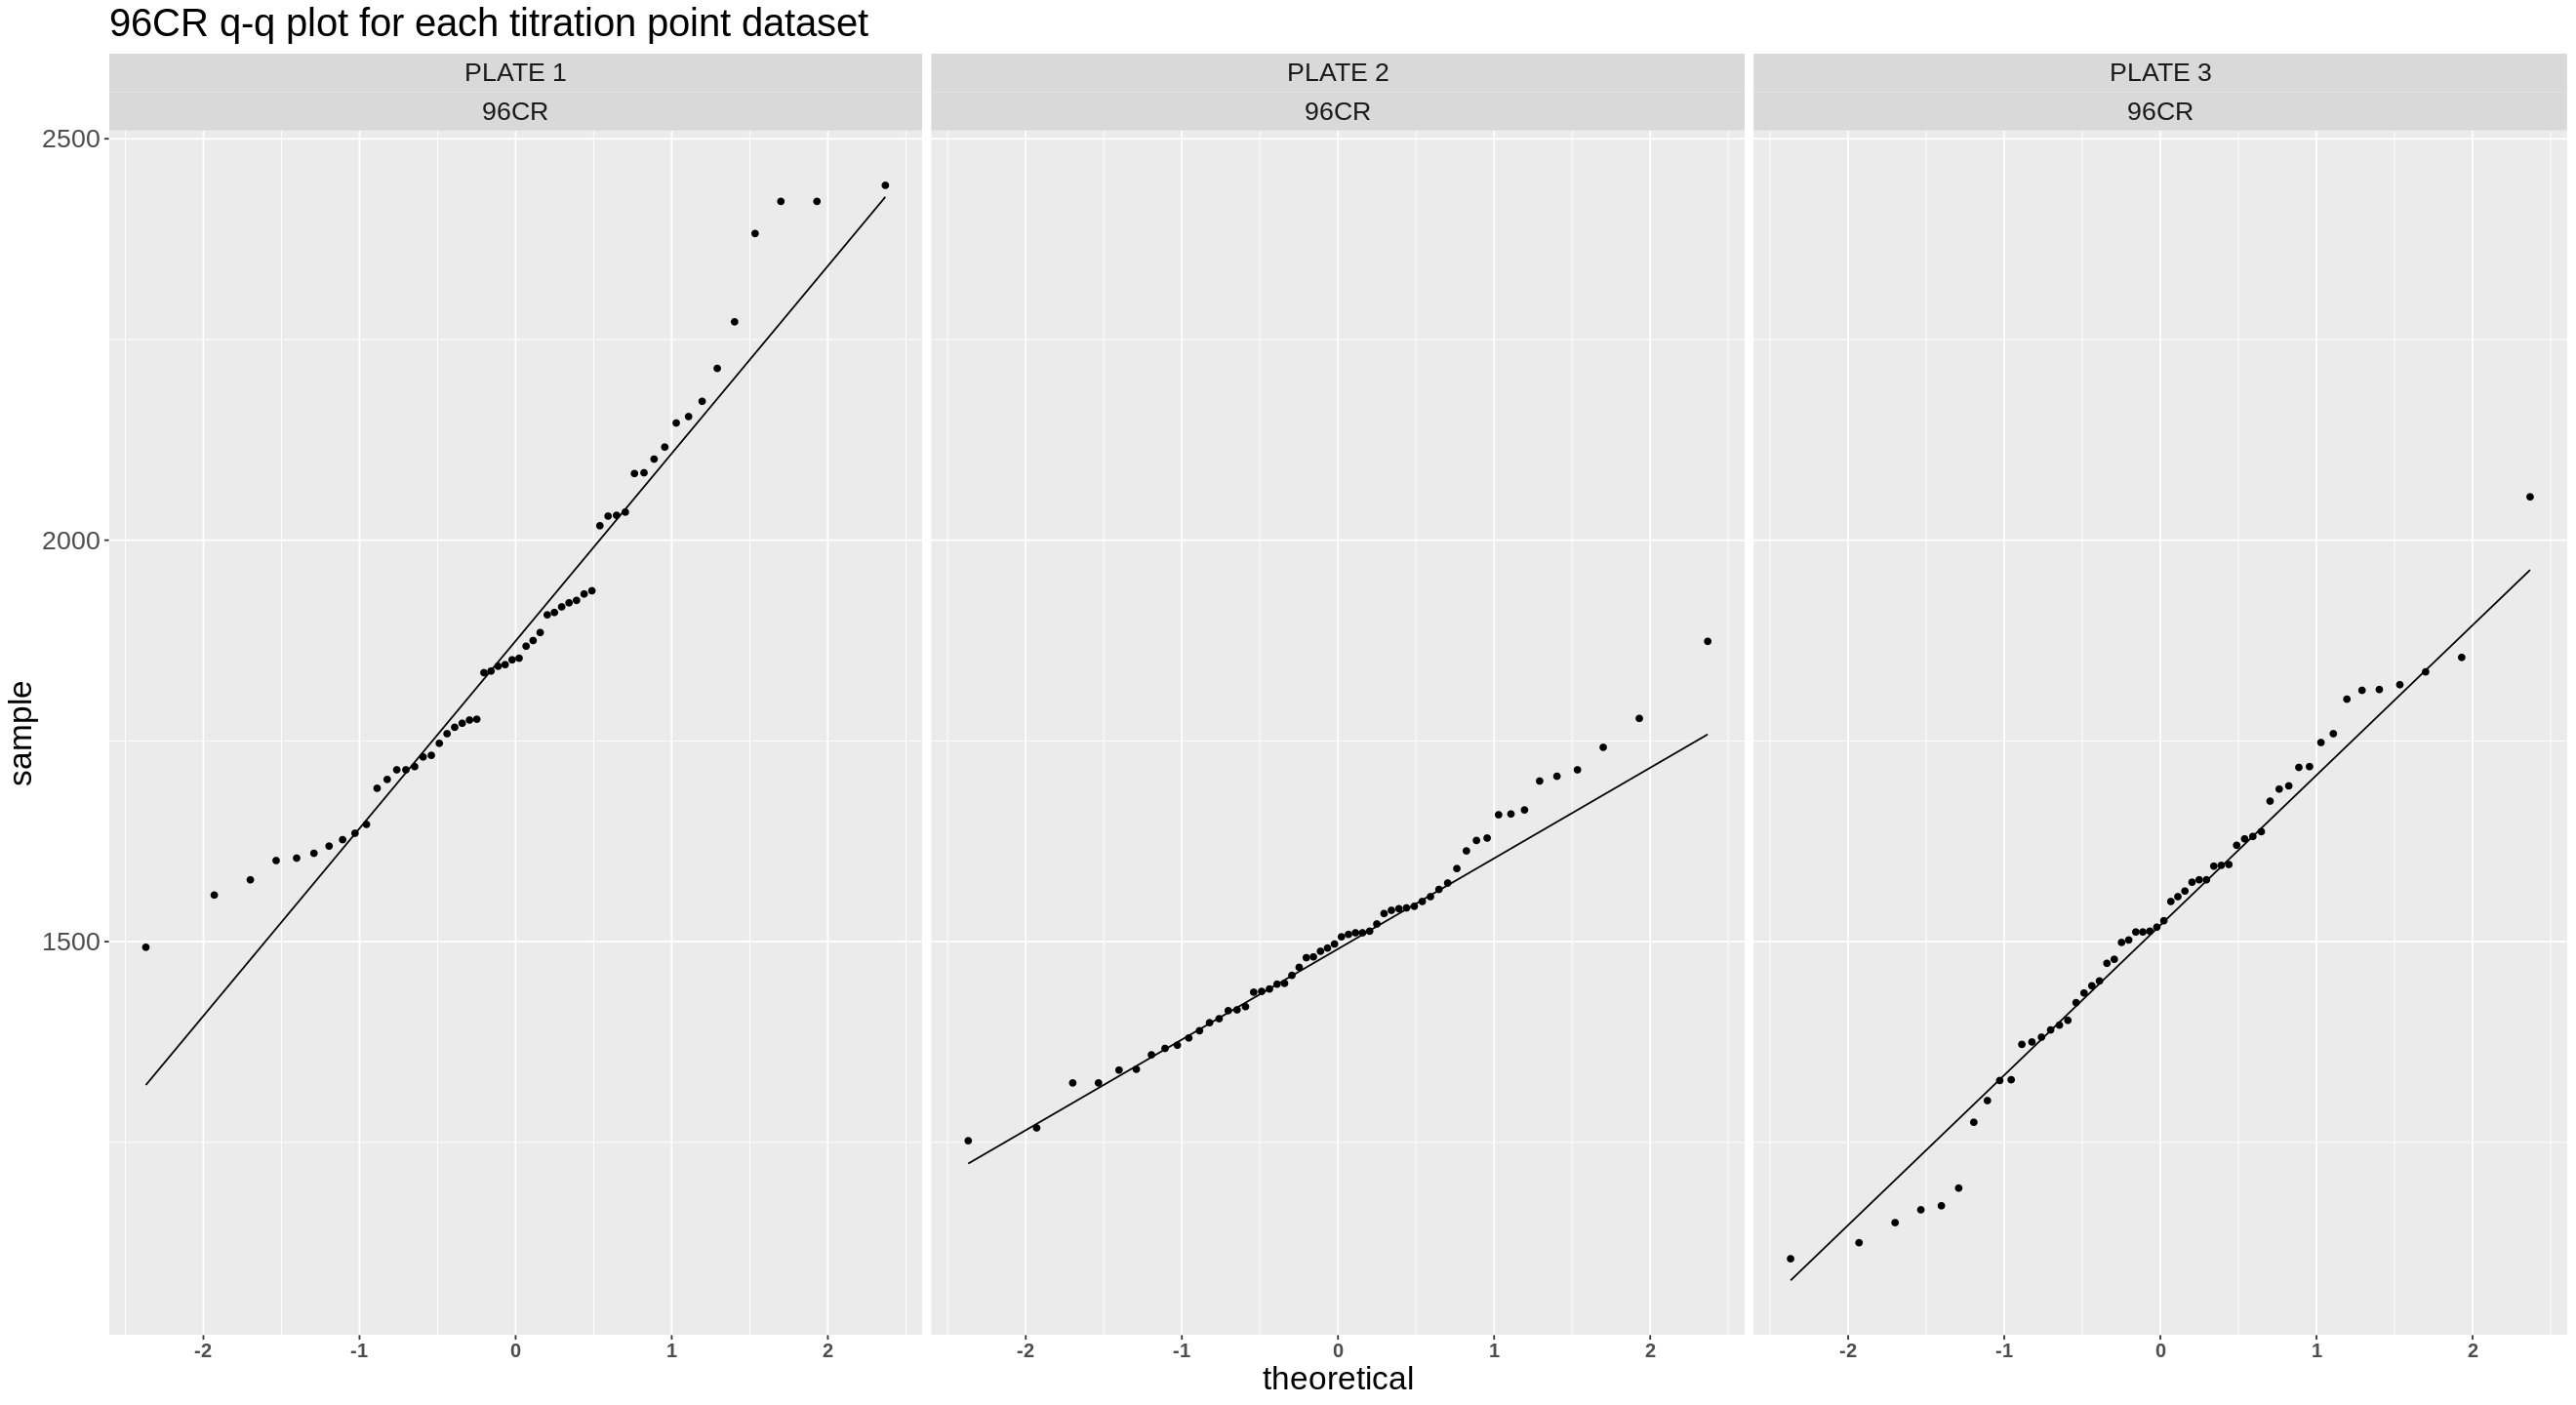

In [10]:
mtd = "96CR"
df.tmp <- df %>% filter(method == mtd)
ggplot(df.tmp, aes(sample = Z)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(plate~ method) +
            ggtitle(paste(mtd, "q-q plot for each titration point dataset")) +
            theme(text = element_text(size=20),
                axis.text.x = element_text(face = "bold", 
                                   size = 12)) 

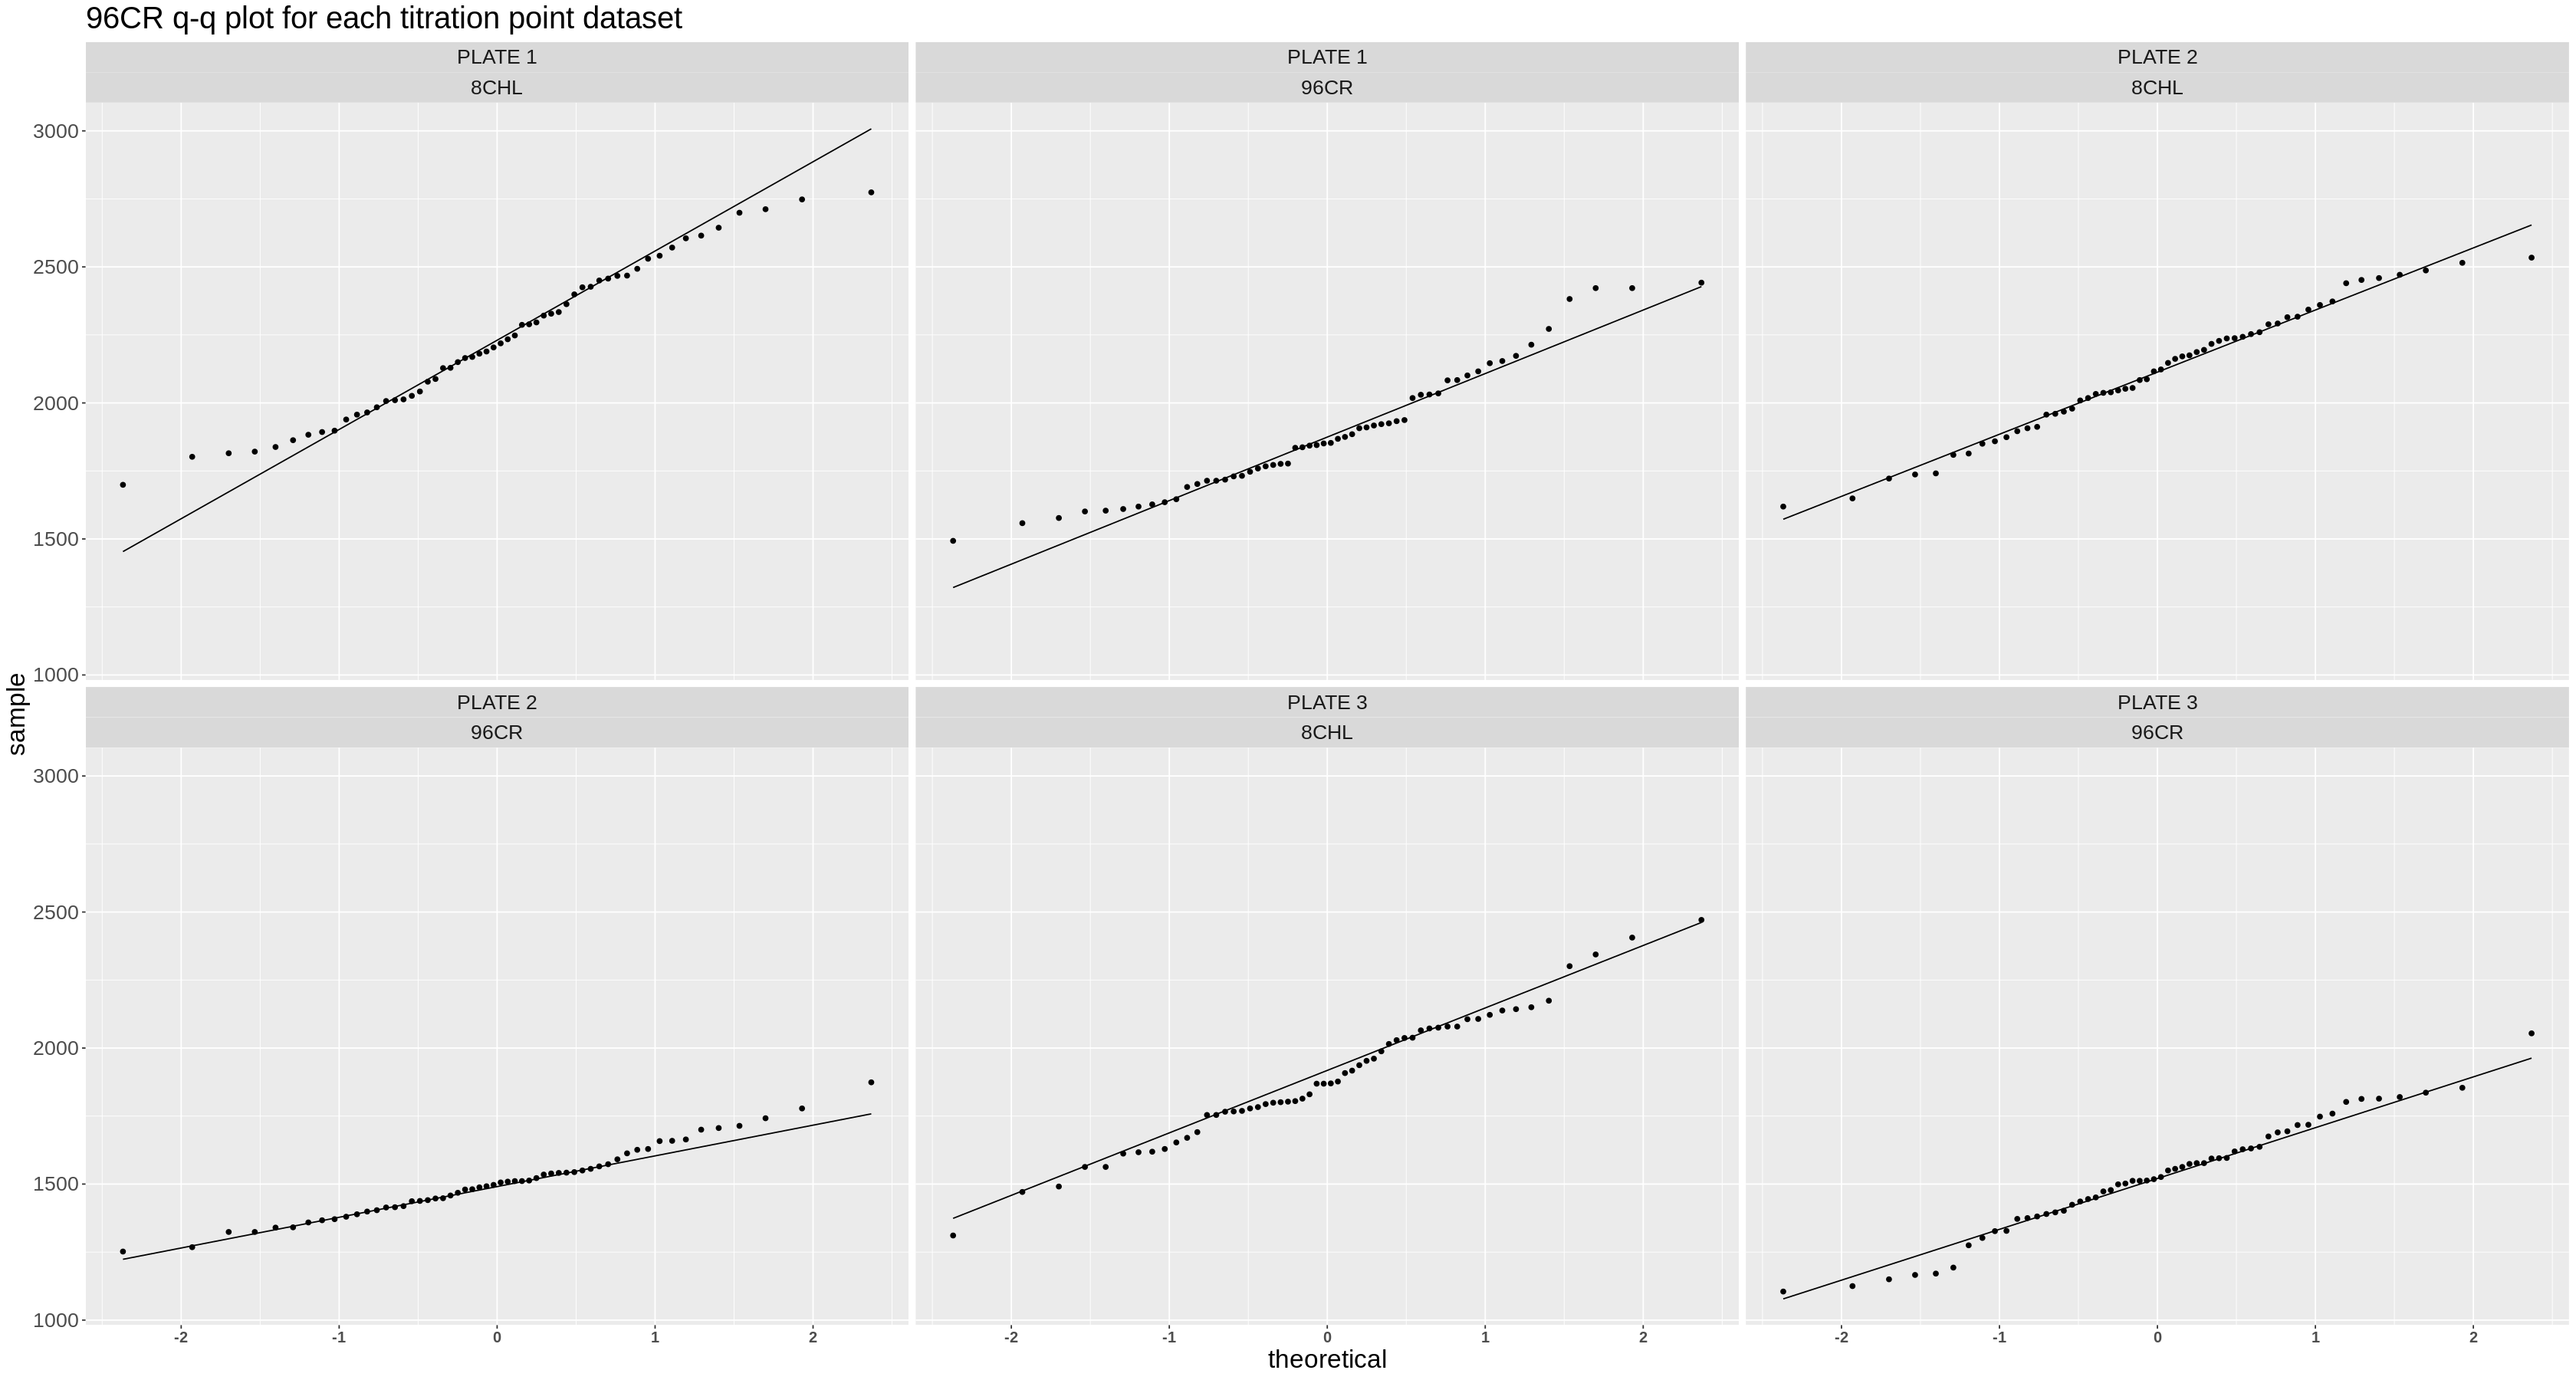

In [34]:
ggplot(df, aes(sample = Z)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(plate~ method) +
            ggtitle(paste(mtd, "q-q plot for each titration point dataset")) +
            theme(text = element_text(size=20),
                axis.text.x = element_text(face = "bold", 
                                   size = 12)) 

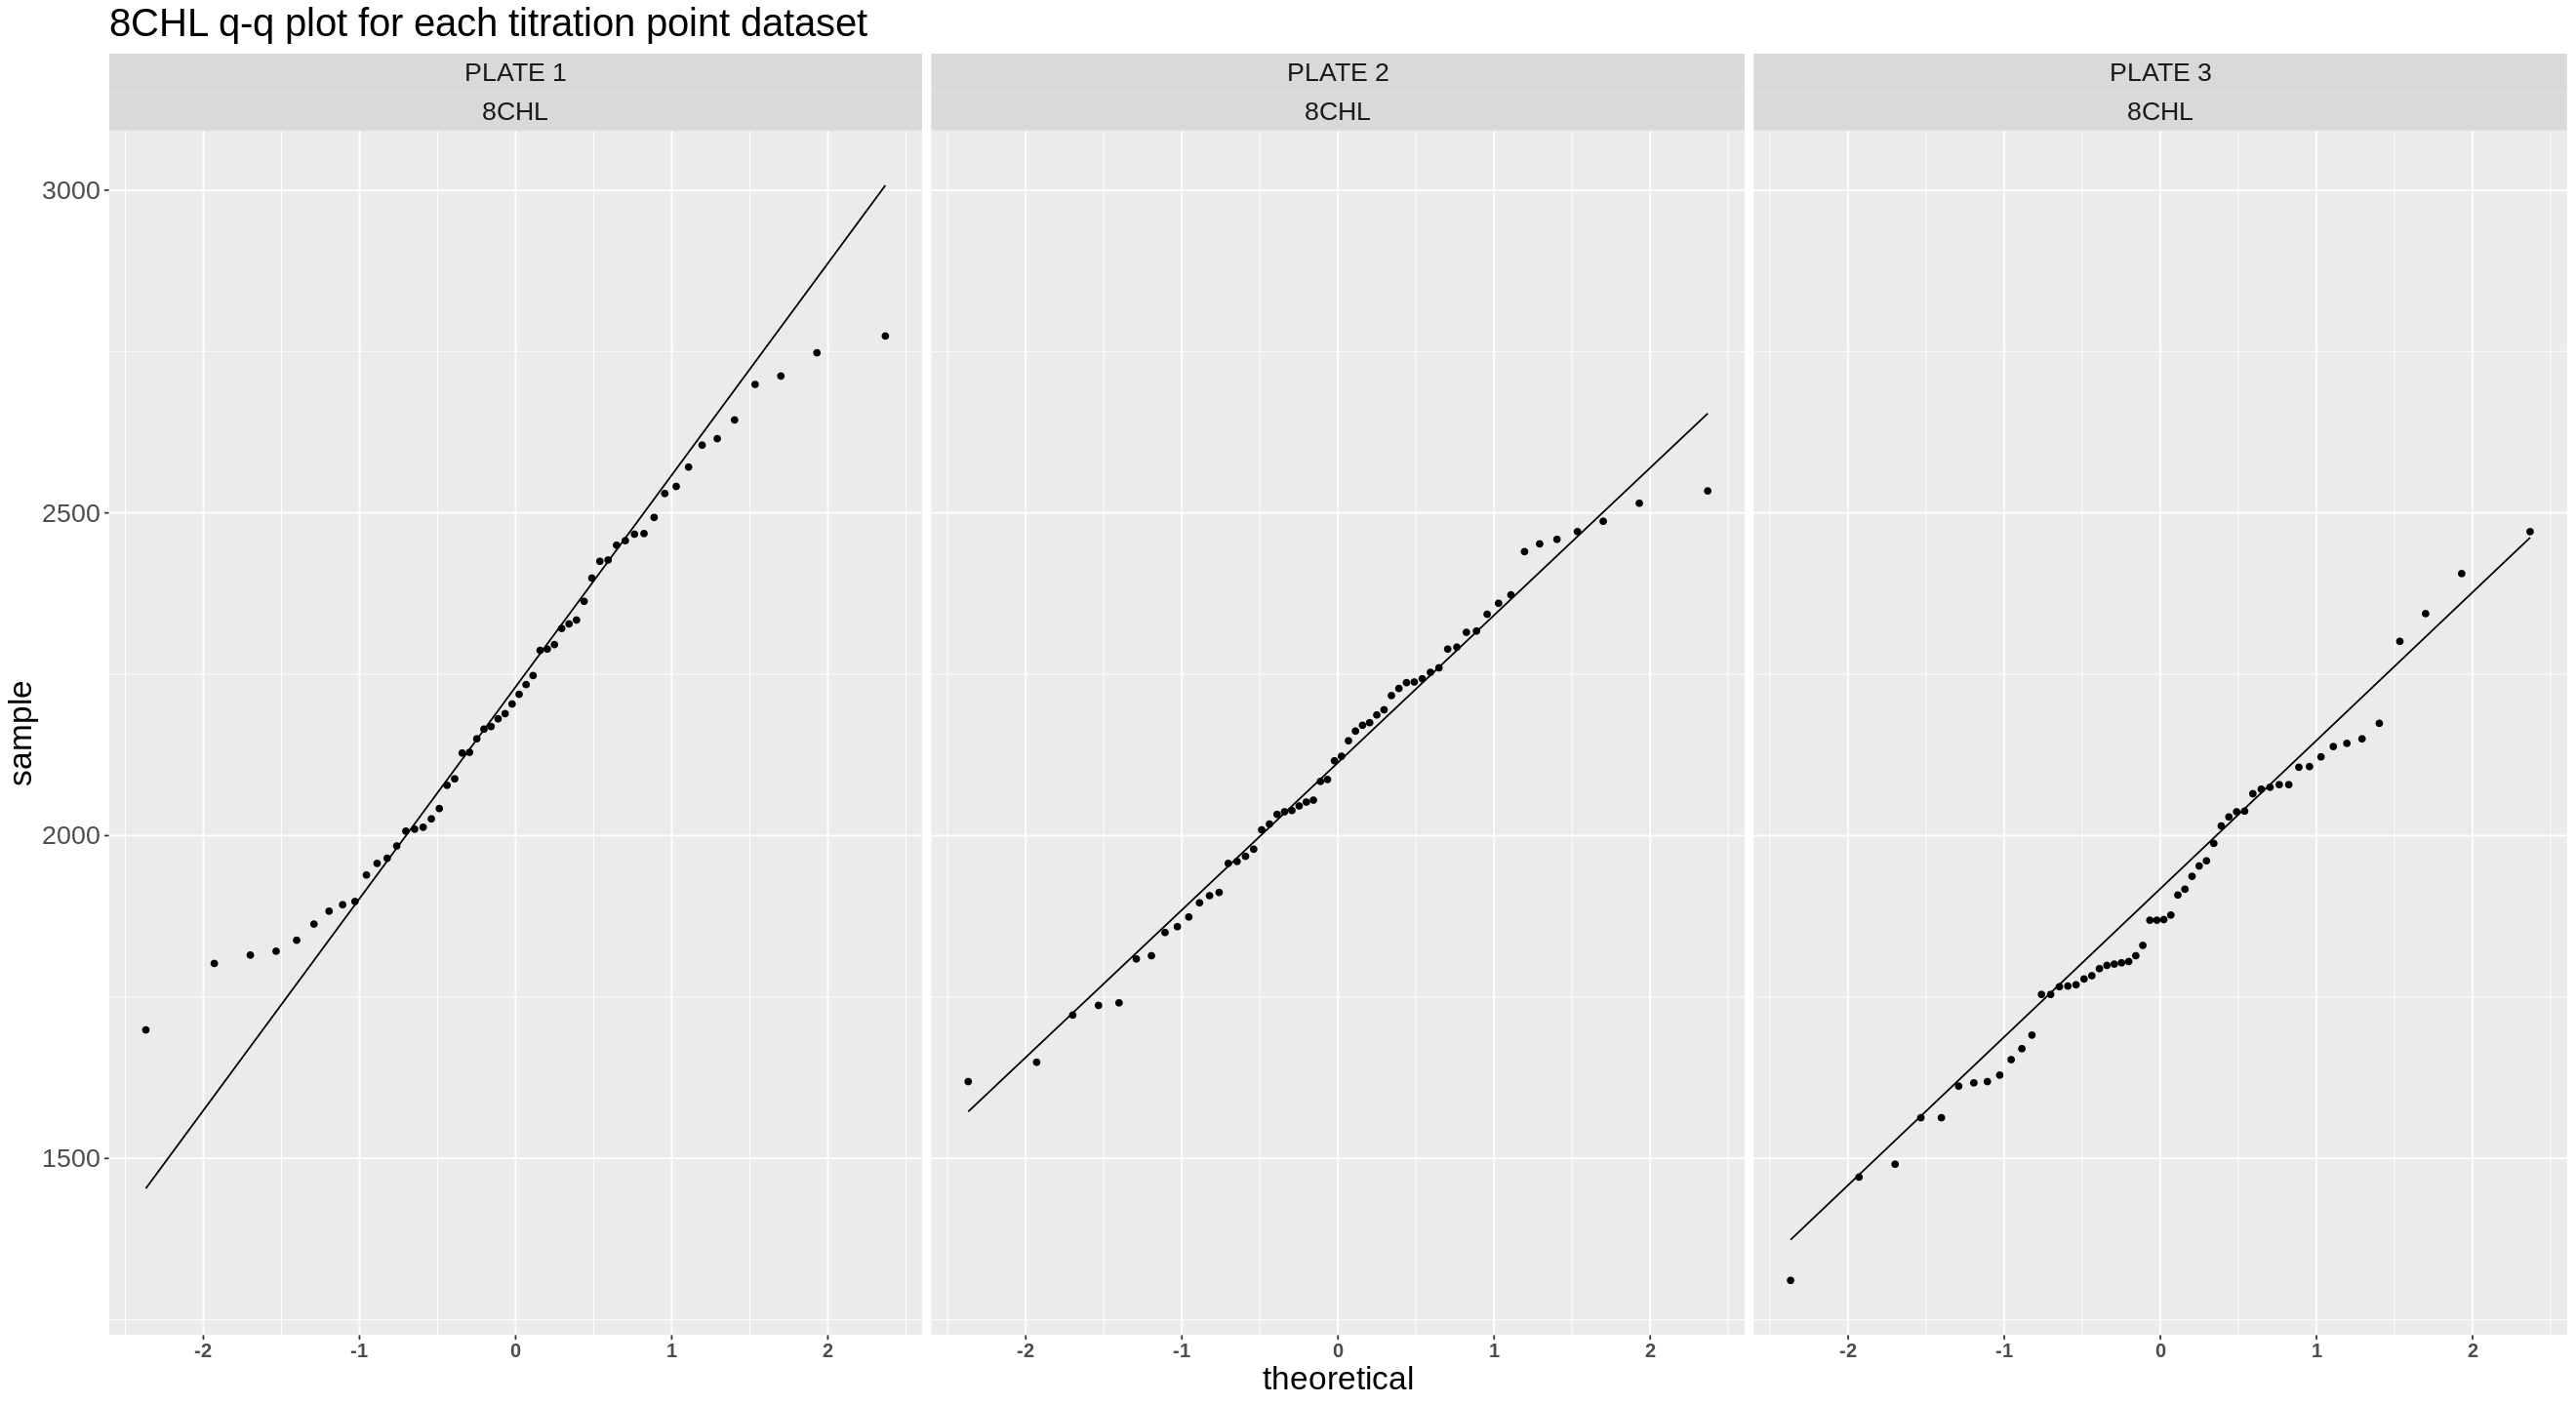

In [9]:
mtd = "8CHL"
df.tmp <- df %>% filter(method == mtd)
ggplot(df.tmp, aes(sample = Z)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(plate~ method) +
            ggtitle(paste(mtd, "q-q plot for each titration point dataset")) +
            theme(text = element_text(size=20),
                axis.text.x = element_text(face = "bold", 
                                   size = 12)) 

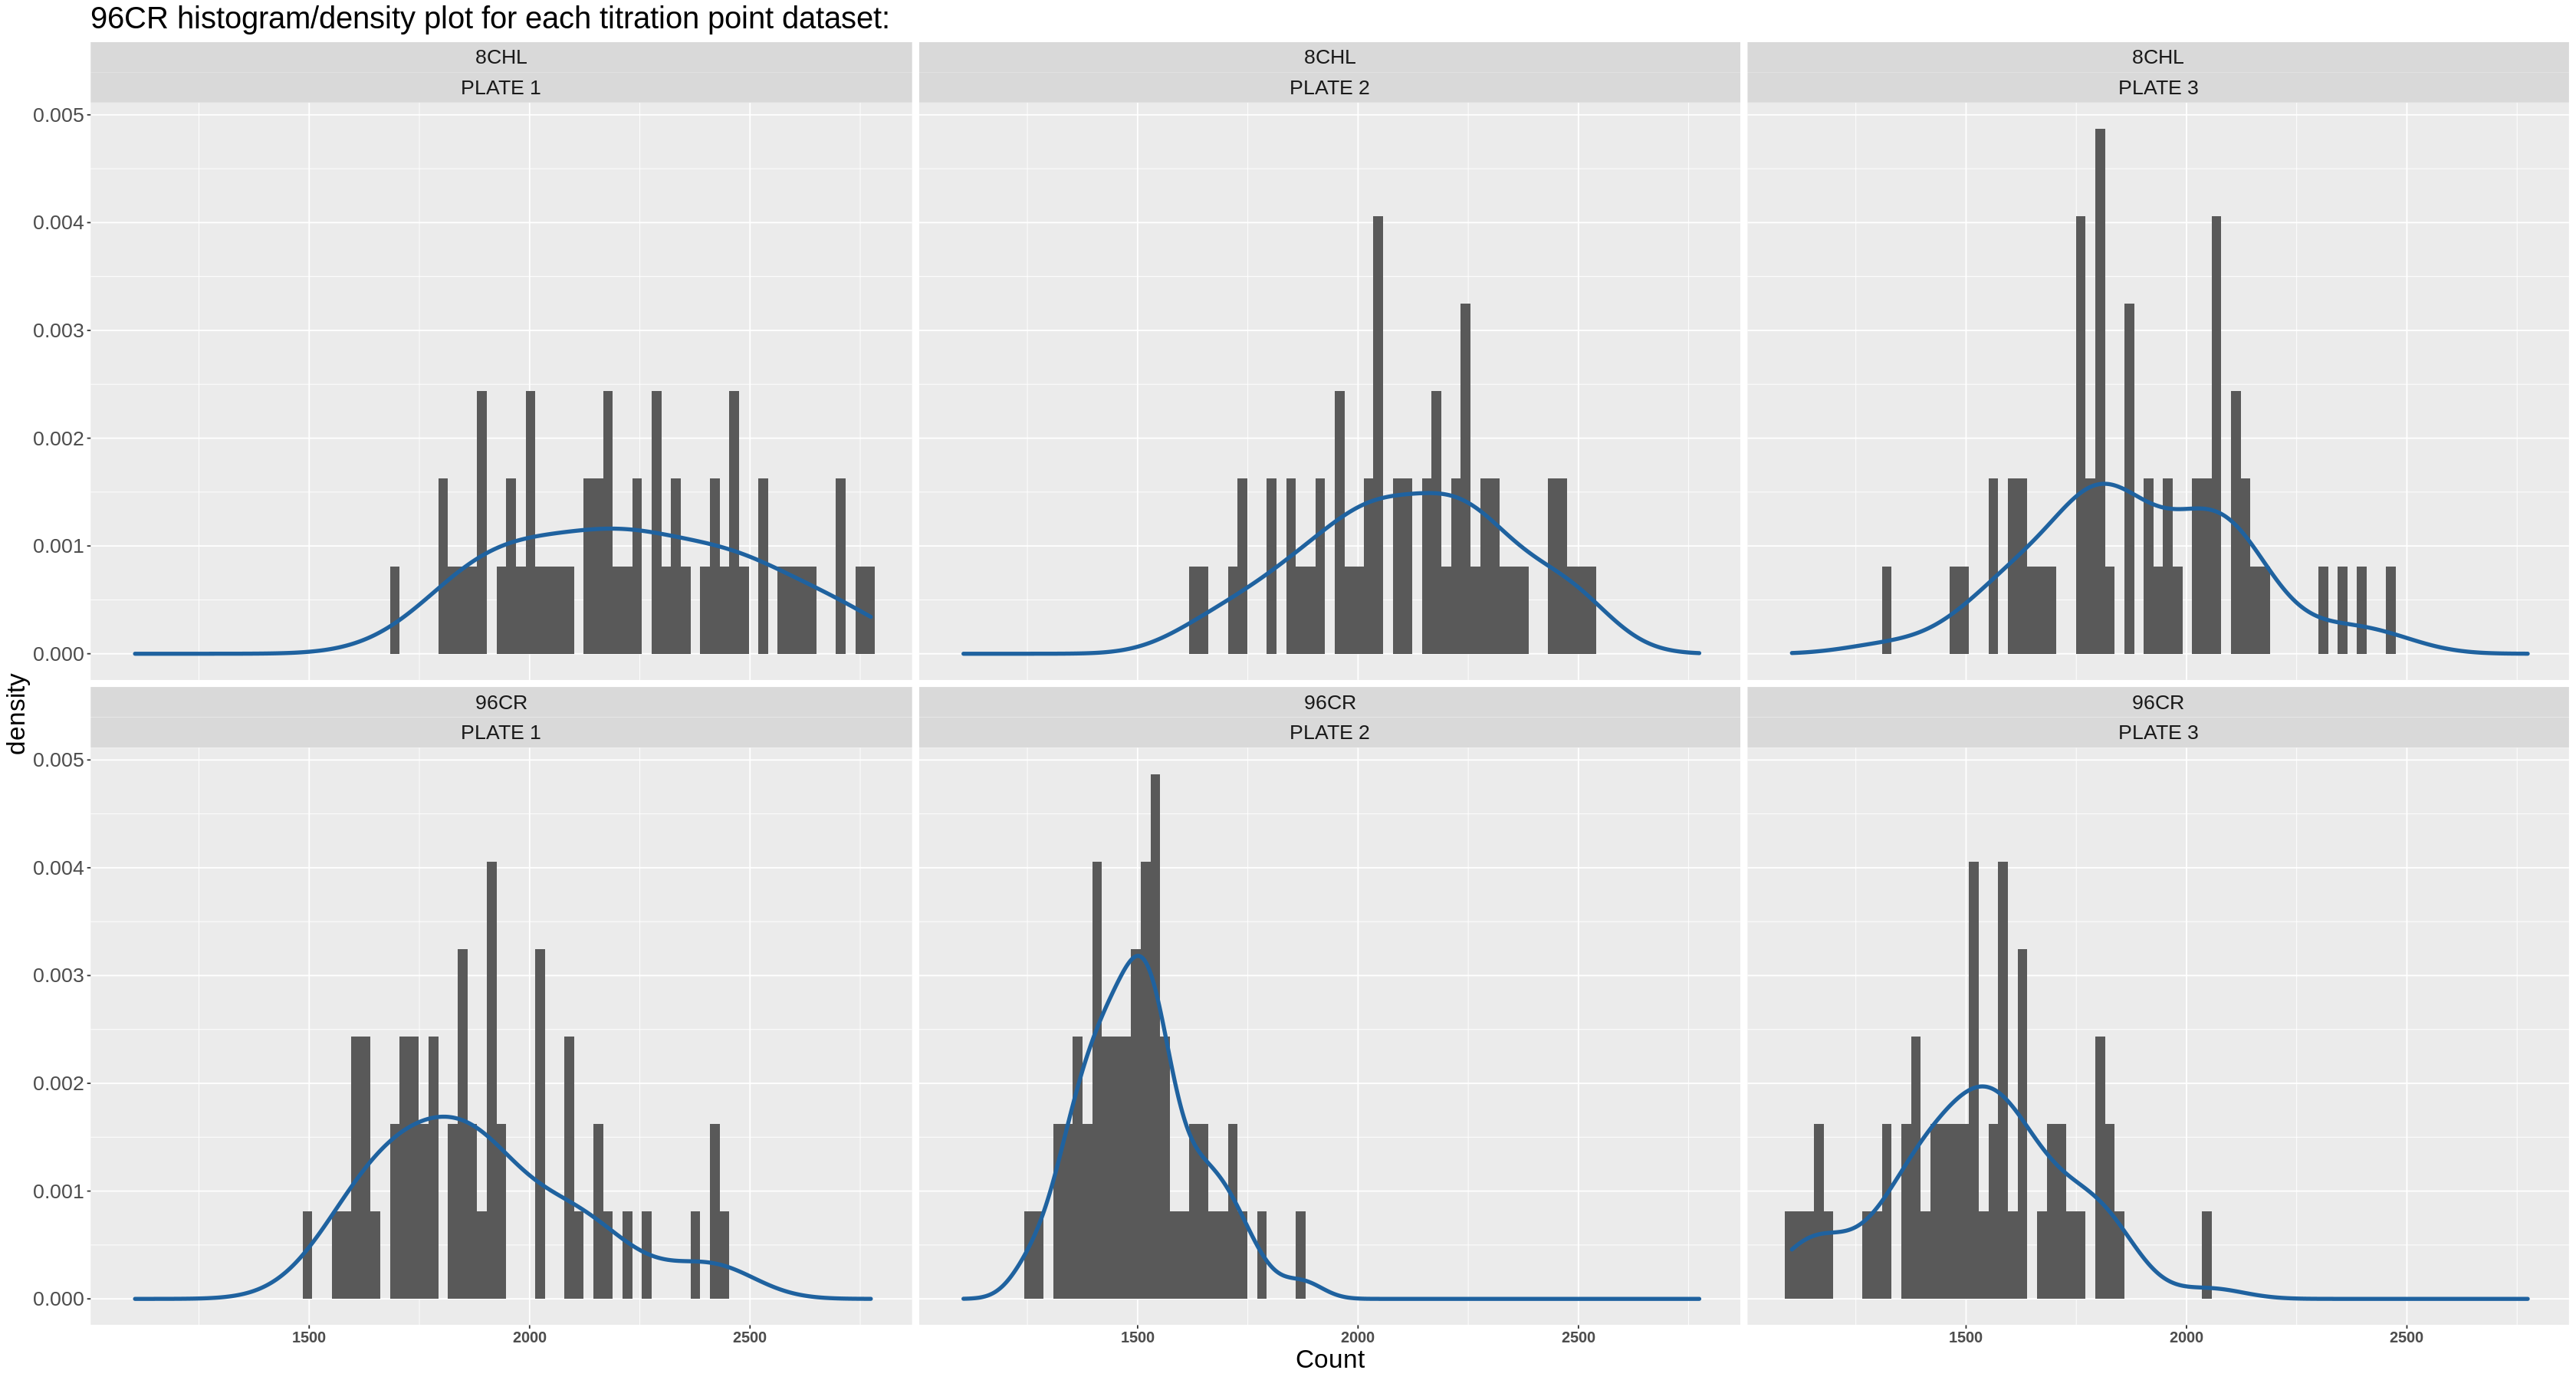

In [36]:
ggplot(data = df, aes(x = Z)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(method~plate) +
    xlab("Count") +
    ggtitle(paste(mtd, "histogram/density plot for each titration point dataset:")) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

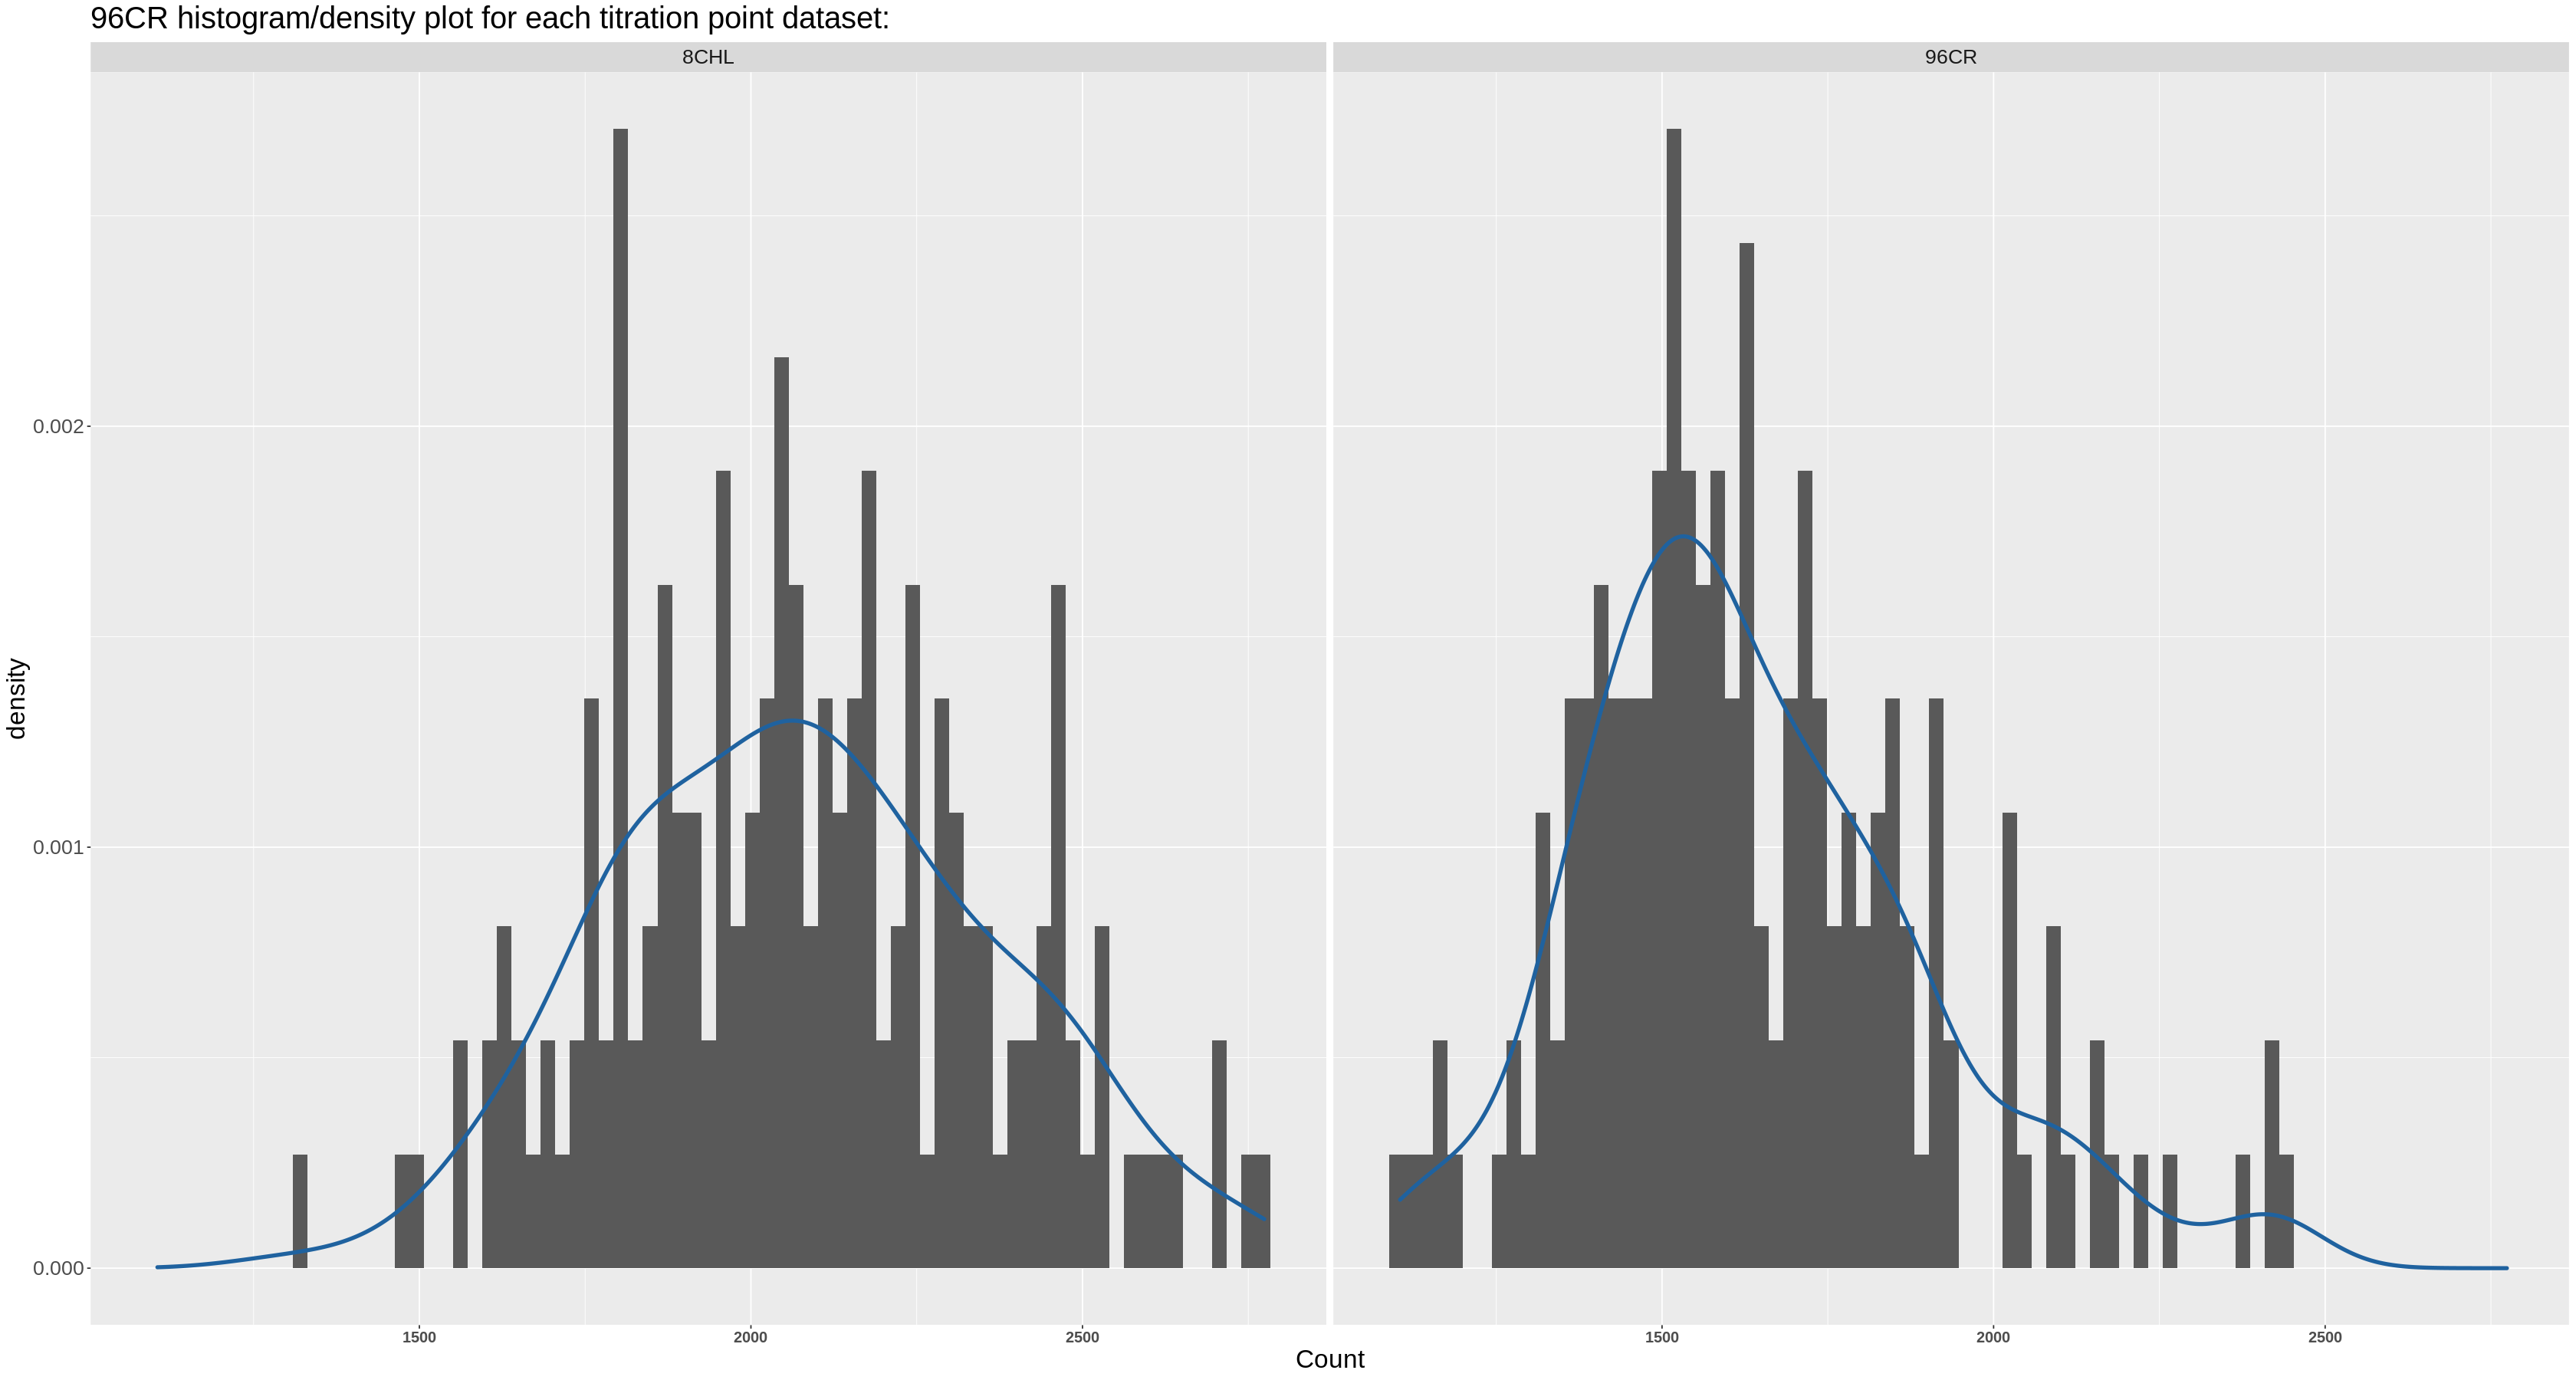

In [37]:

ggplot(data = df, aes(x = Z)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(~method) +
    xlab("Count") +
    ggtitle(paste(mtd, "histogram/density plot for each titration point dataset:")) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

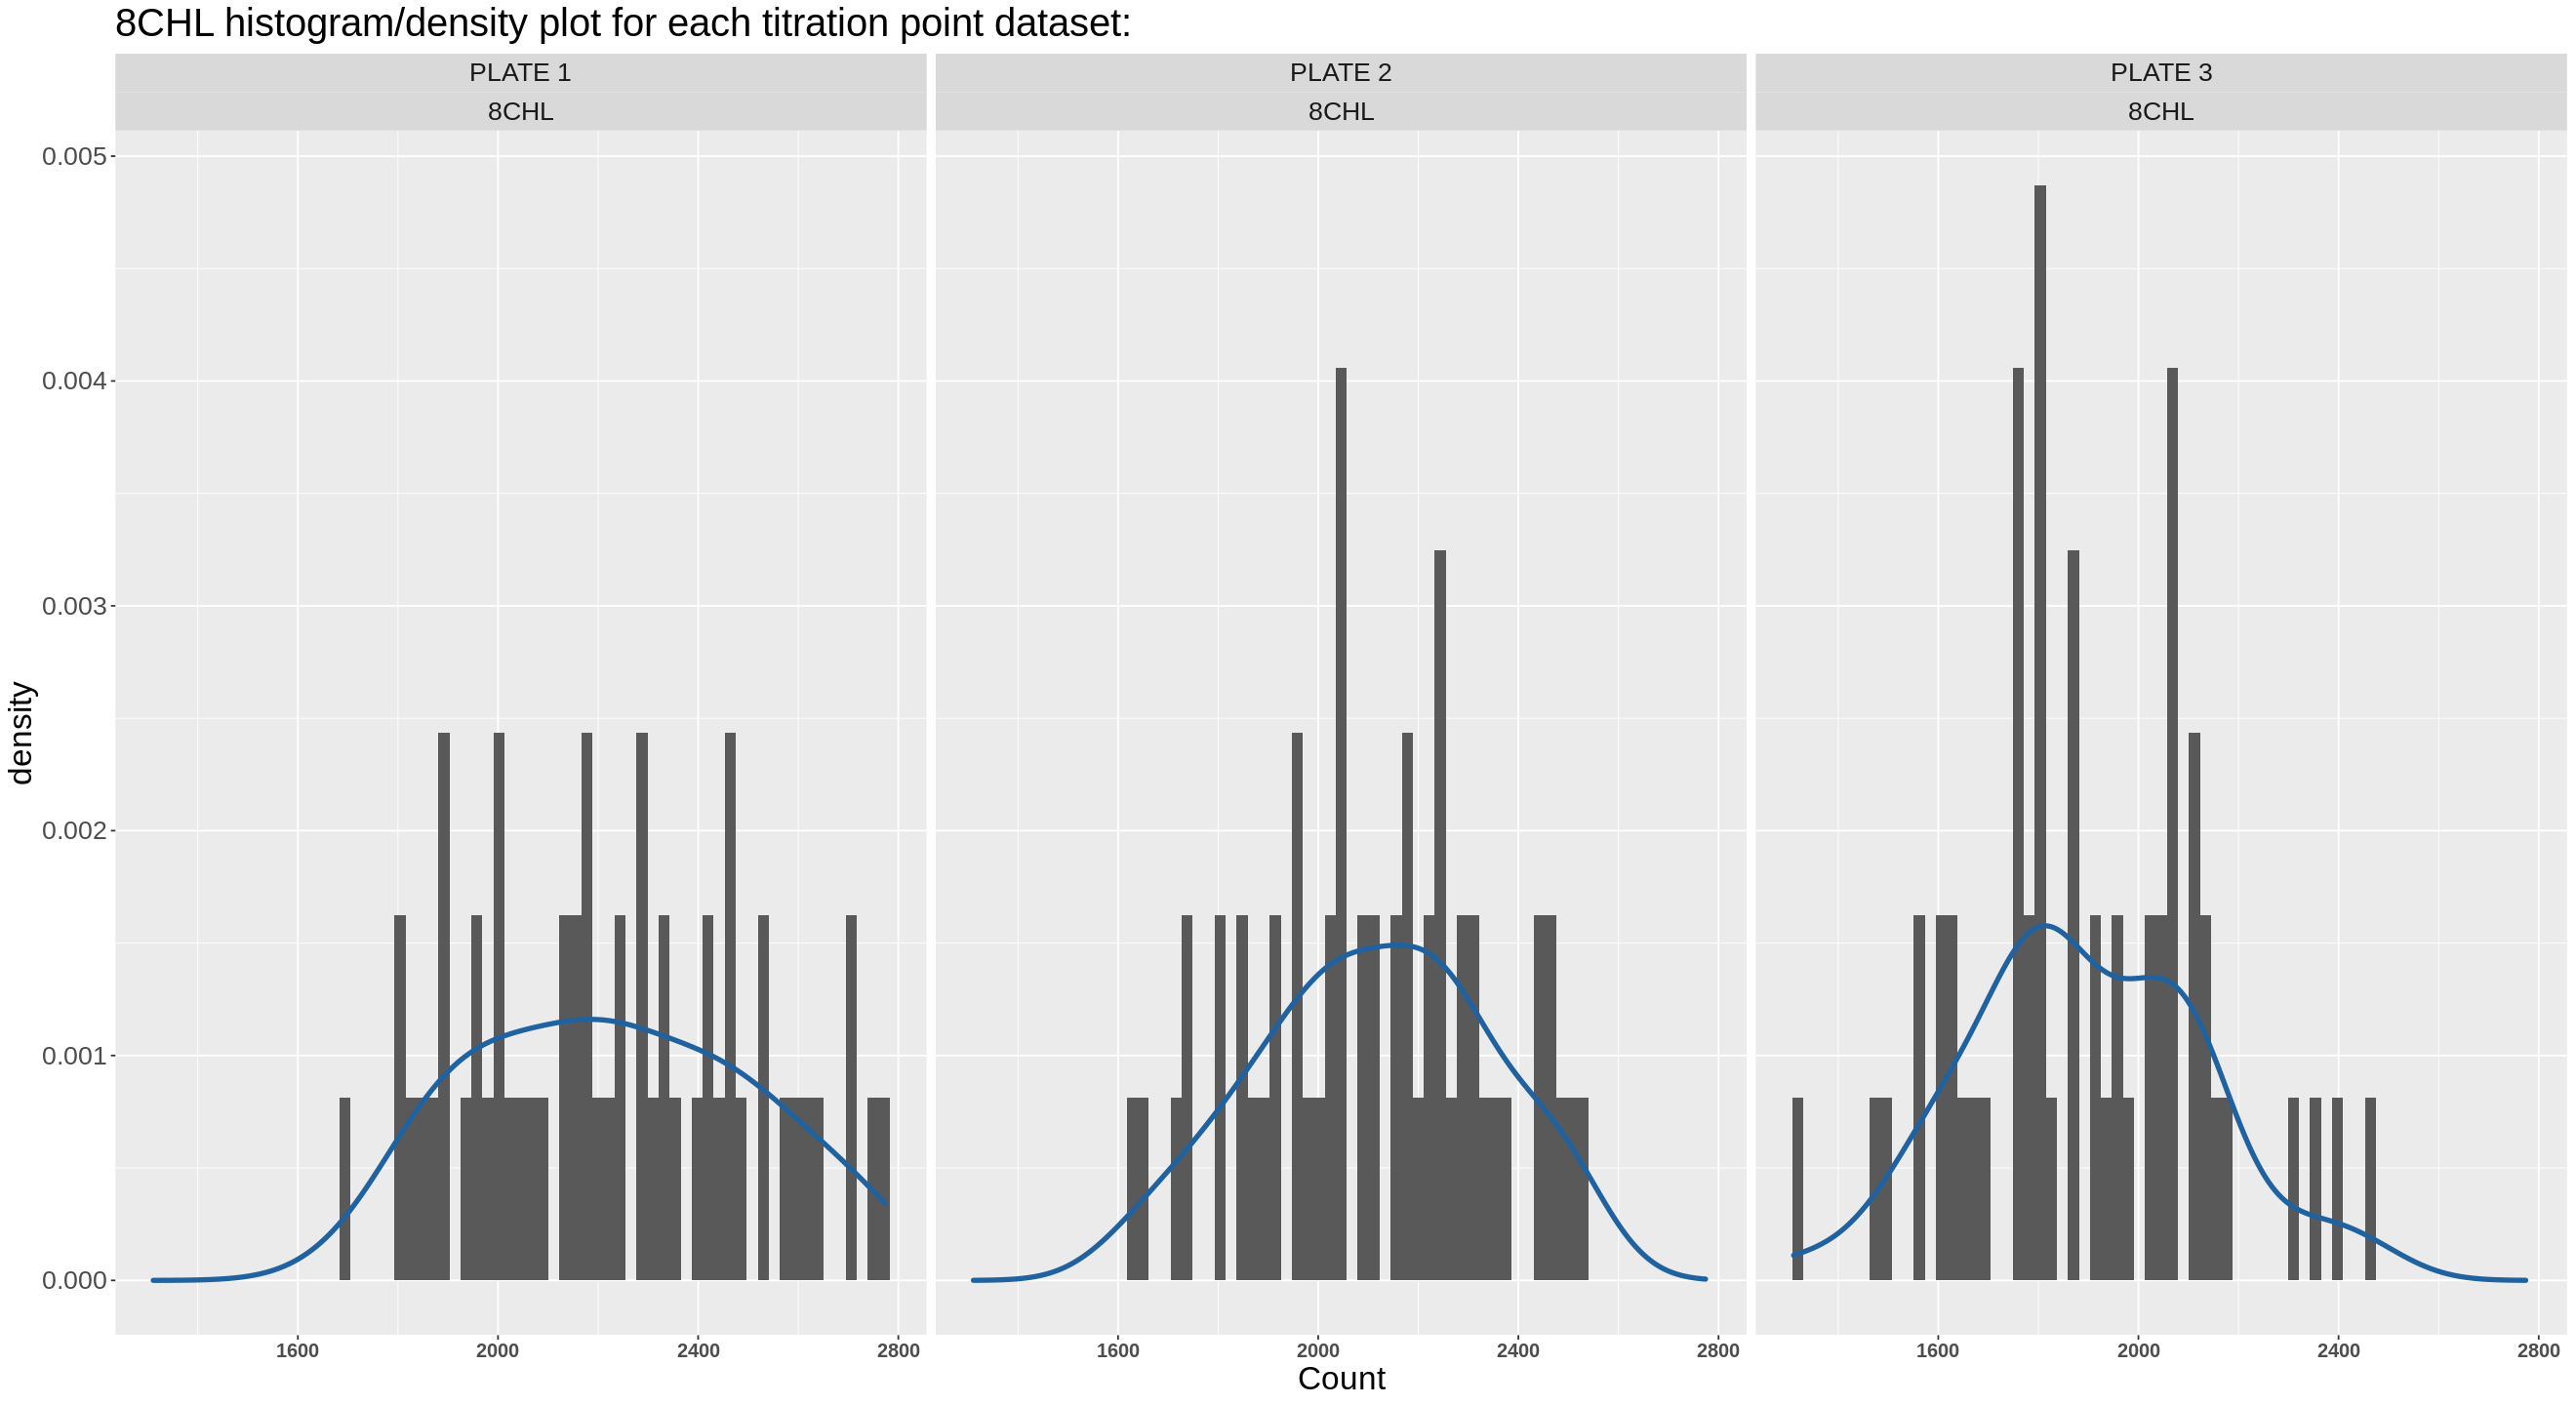

In [8]:
mtd = "8CHL"
df.tmp <- df %>% filter(method == mtd)

ggplot(data = df.tmp, aes(x = Z)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(plate~method) +
    xlab("Count") +
    ggtitle(paste(mtd, "histogram/density plot for each titration point dataset:")) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

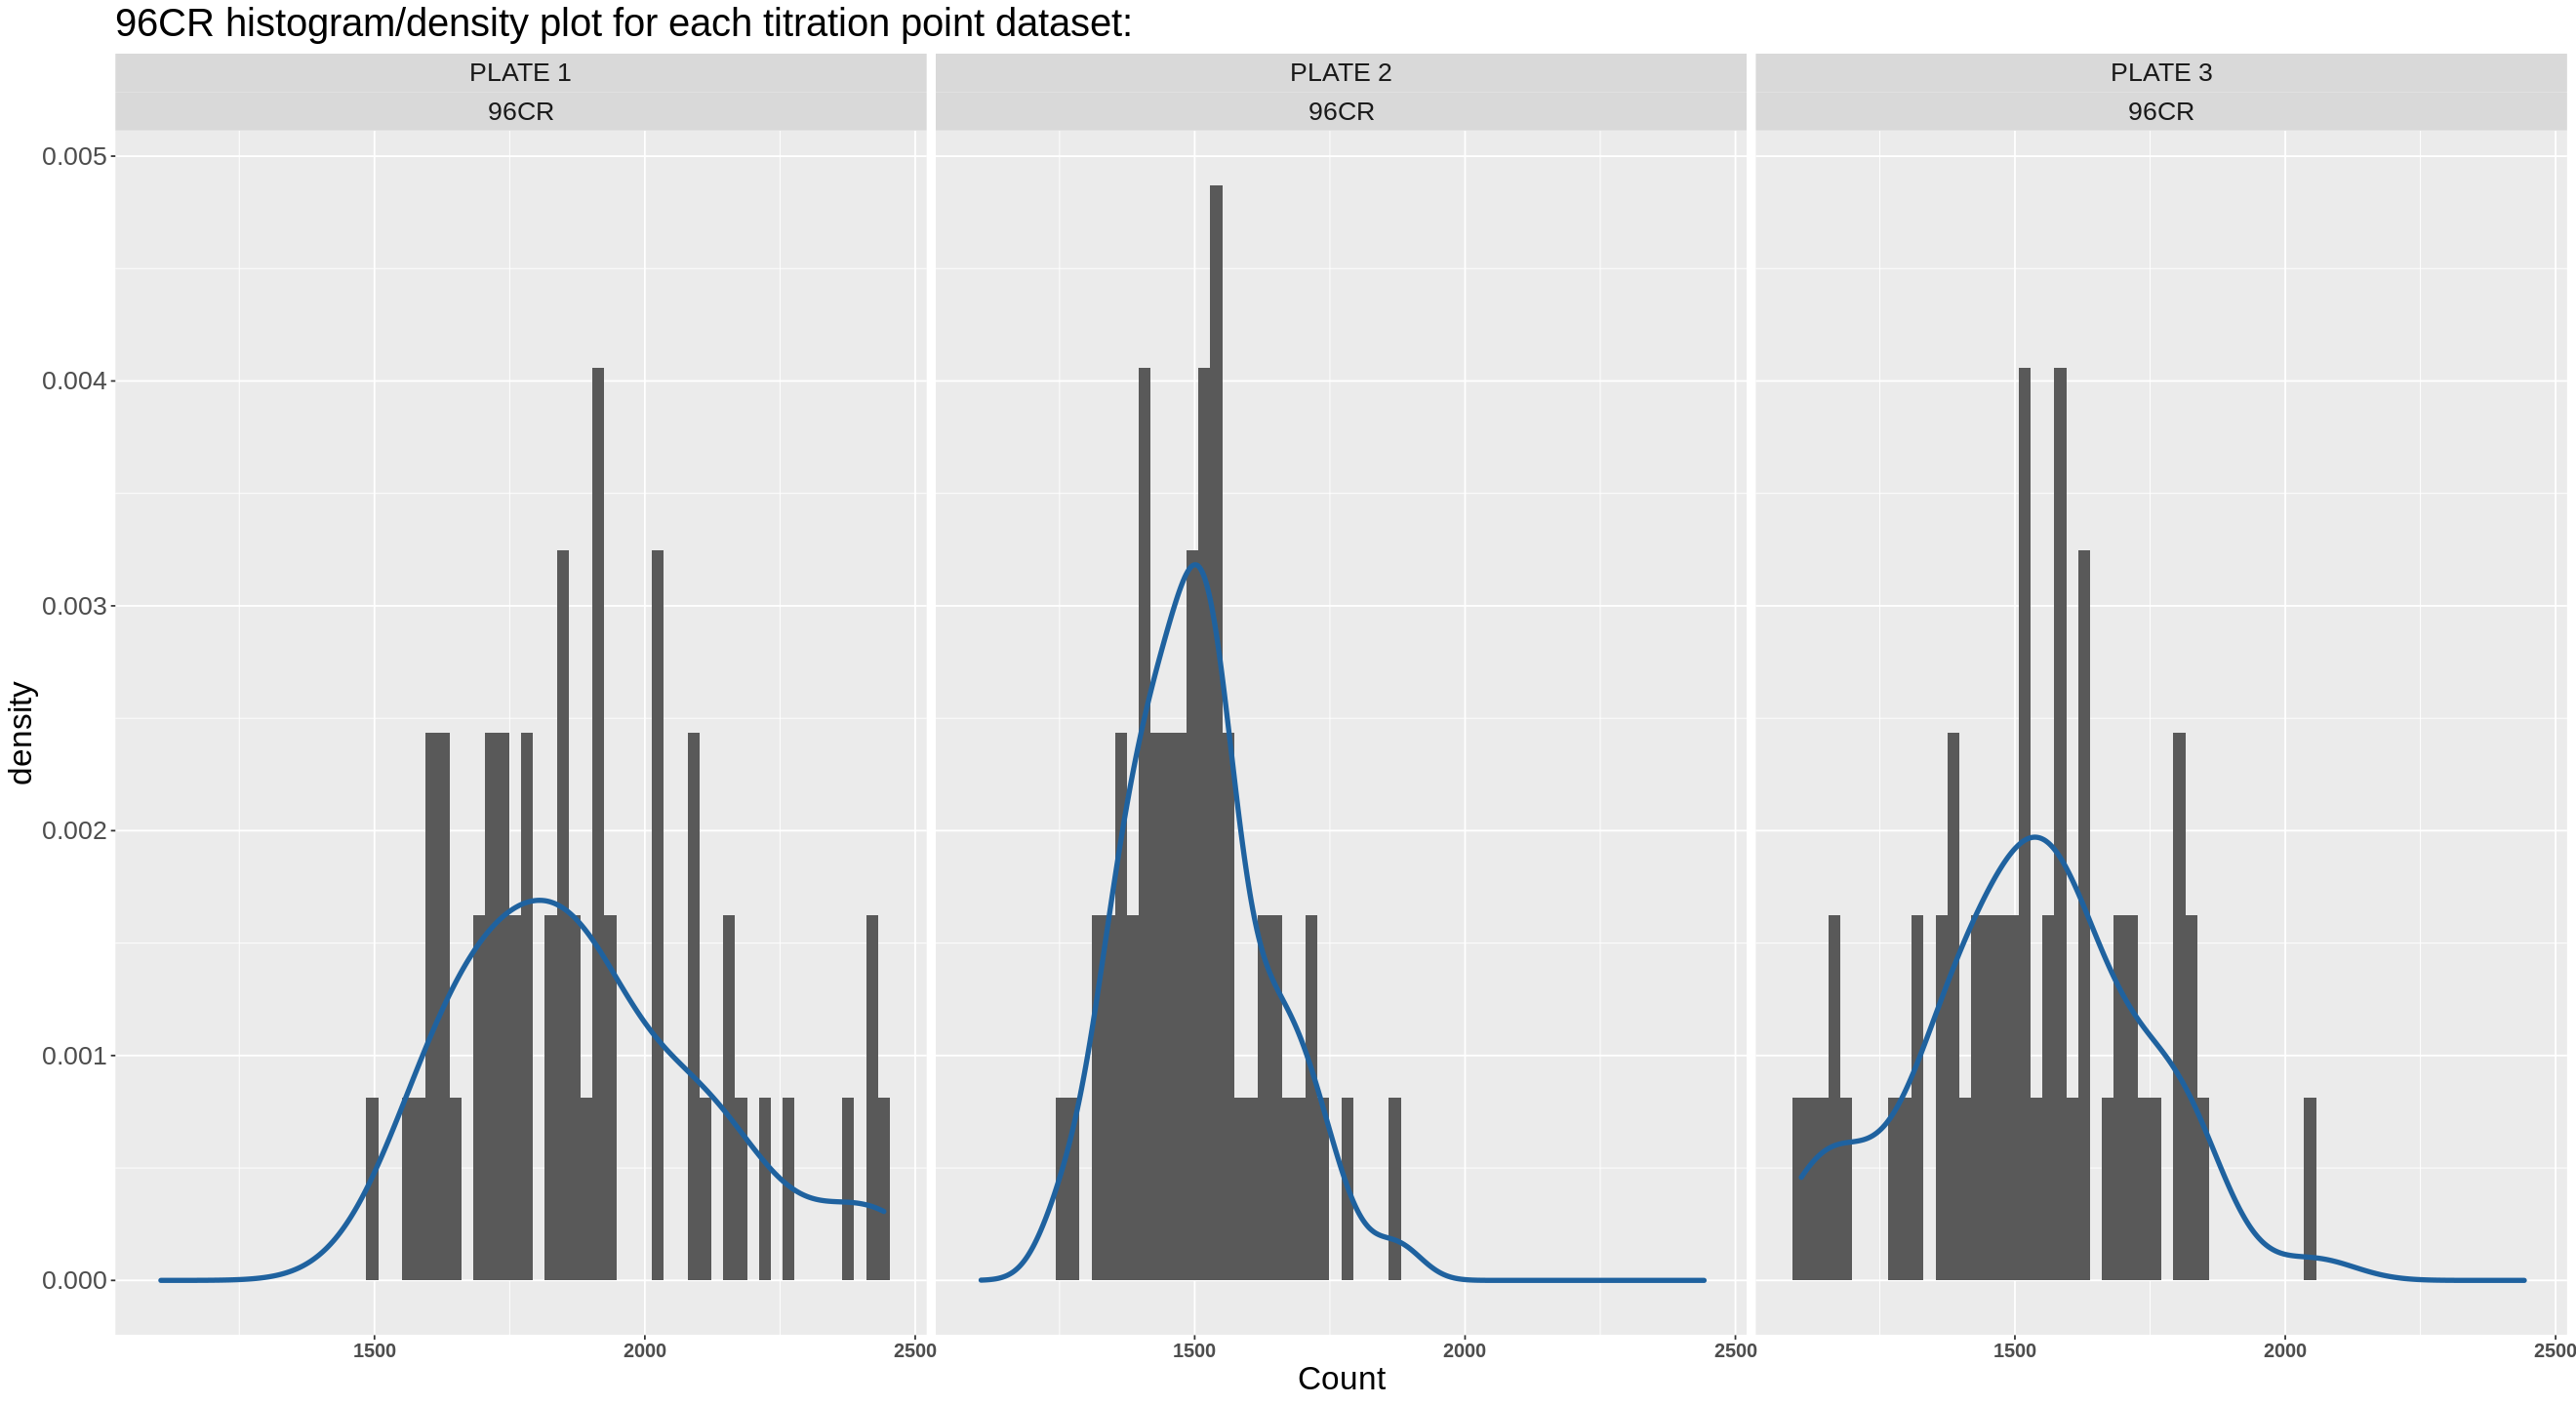

In [7]:
mtd = "96CR"
df.tmp <- df %>% filter(method == mtd)

ggplot(data = df.tmp, aes(x = Z)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(plate~method) +
    xlab("Count") +
    ggtitle(paste(mtd, "histogram/density plot for each titration point dataset:")) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

### Wilcoxon rank test

- check that the median of pairwise differences is different 
- non-parametric statistical test to compare 2 related samples, matched samples or repeated measurements on single sample to assess whether their population mean ranks differ 
- an alternative to t-test; this is when we can't assume the two populatios are normally distributed; determine wheterh two dependent samples were selected from populations have the same distribution
- analysis below shows using both wilcox and t-test the sample mean for intra-plate is very different
- assume not normal distribution

#### t test for new vs old plate sets
- check mean sample difference between two datasets
- requires normal and linear data

###### info
- the data will output 8 wilcoxon and t-test results for each titration point across 3 plates totalling to 6 per group since there are 2 data points per plate 

In [22]:
head(df)

X Y Z    method plate  
1 2 A 2774 8CHL   PLATE 1
2 3 A 2644 8CHL   PLATE 1
3 4 A 2605 8CHL   PLATE 1
4 5 A 2748 8CHL   PLATE 1
5 6 A 2615 8CHL   PLATE 1
6 7 A 2699 8CHL   PLATE 1

### combine all data to make general boxplot

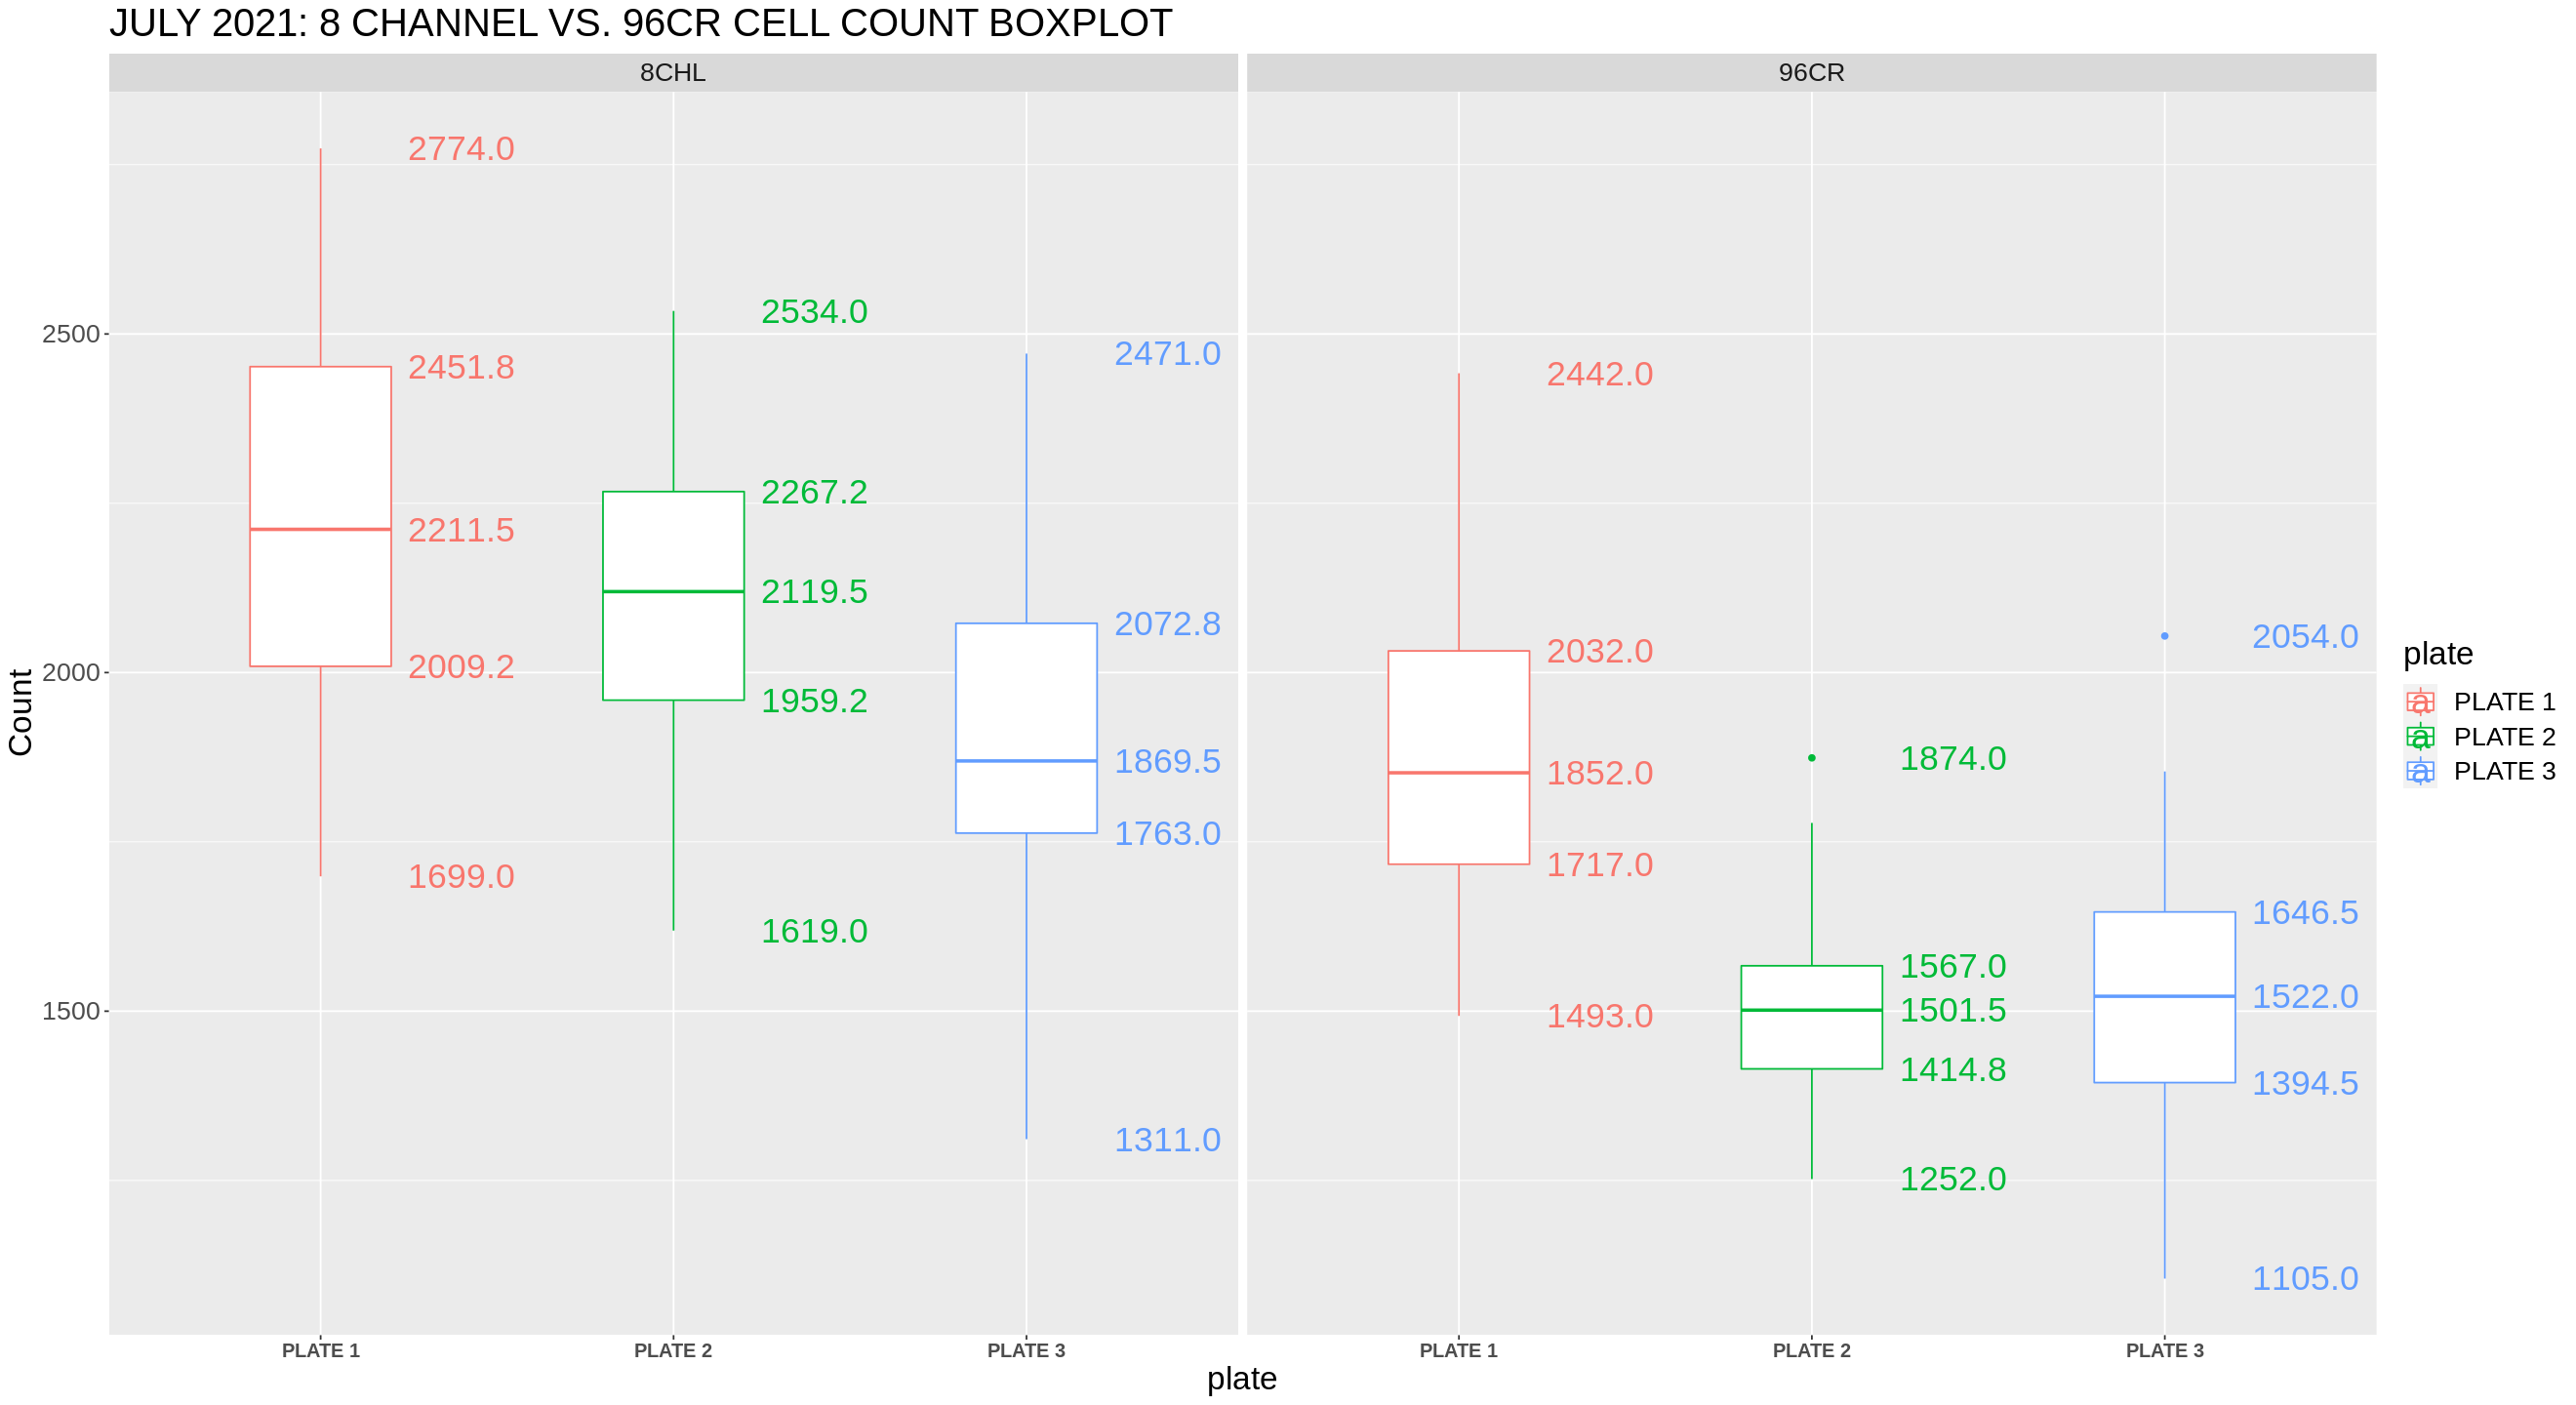

In [24]:
ggplot(df, aes(x=plate,y=Z)) +
  geom_boxplot(width = 0.4, aes(colour = plate)) +
  stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=plate),
           position=position_nudge(x=0.4), size=7.5) +
  labs(title="JULY 2021: 8 CHANNEL VS. 96CR CELL COUNT BOXPLOT - PAIRED") +
  ylab("Count") +
  facet_wrap(~method) + 
  theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

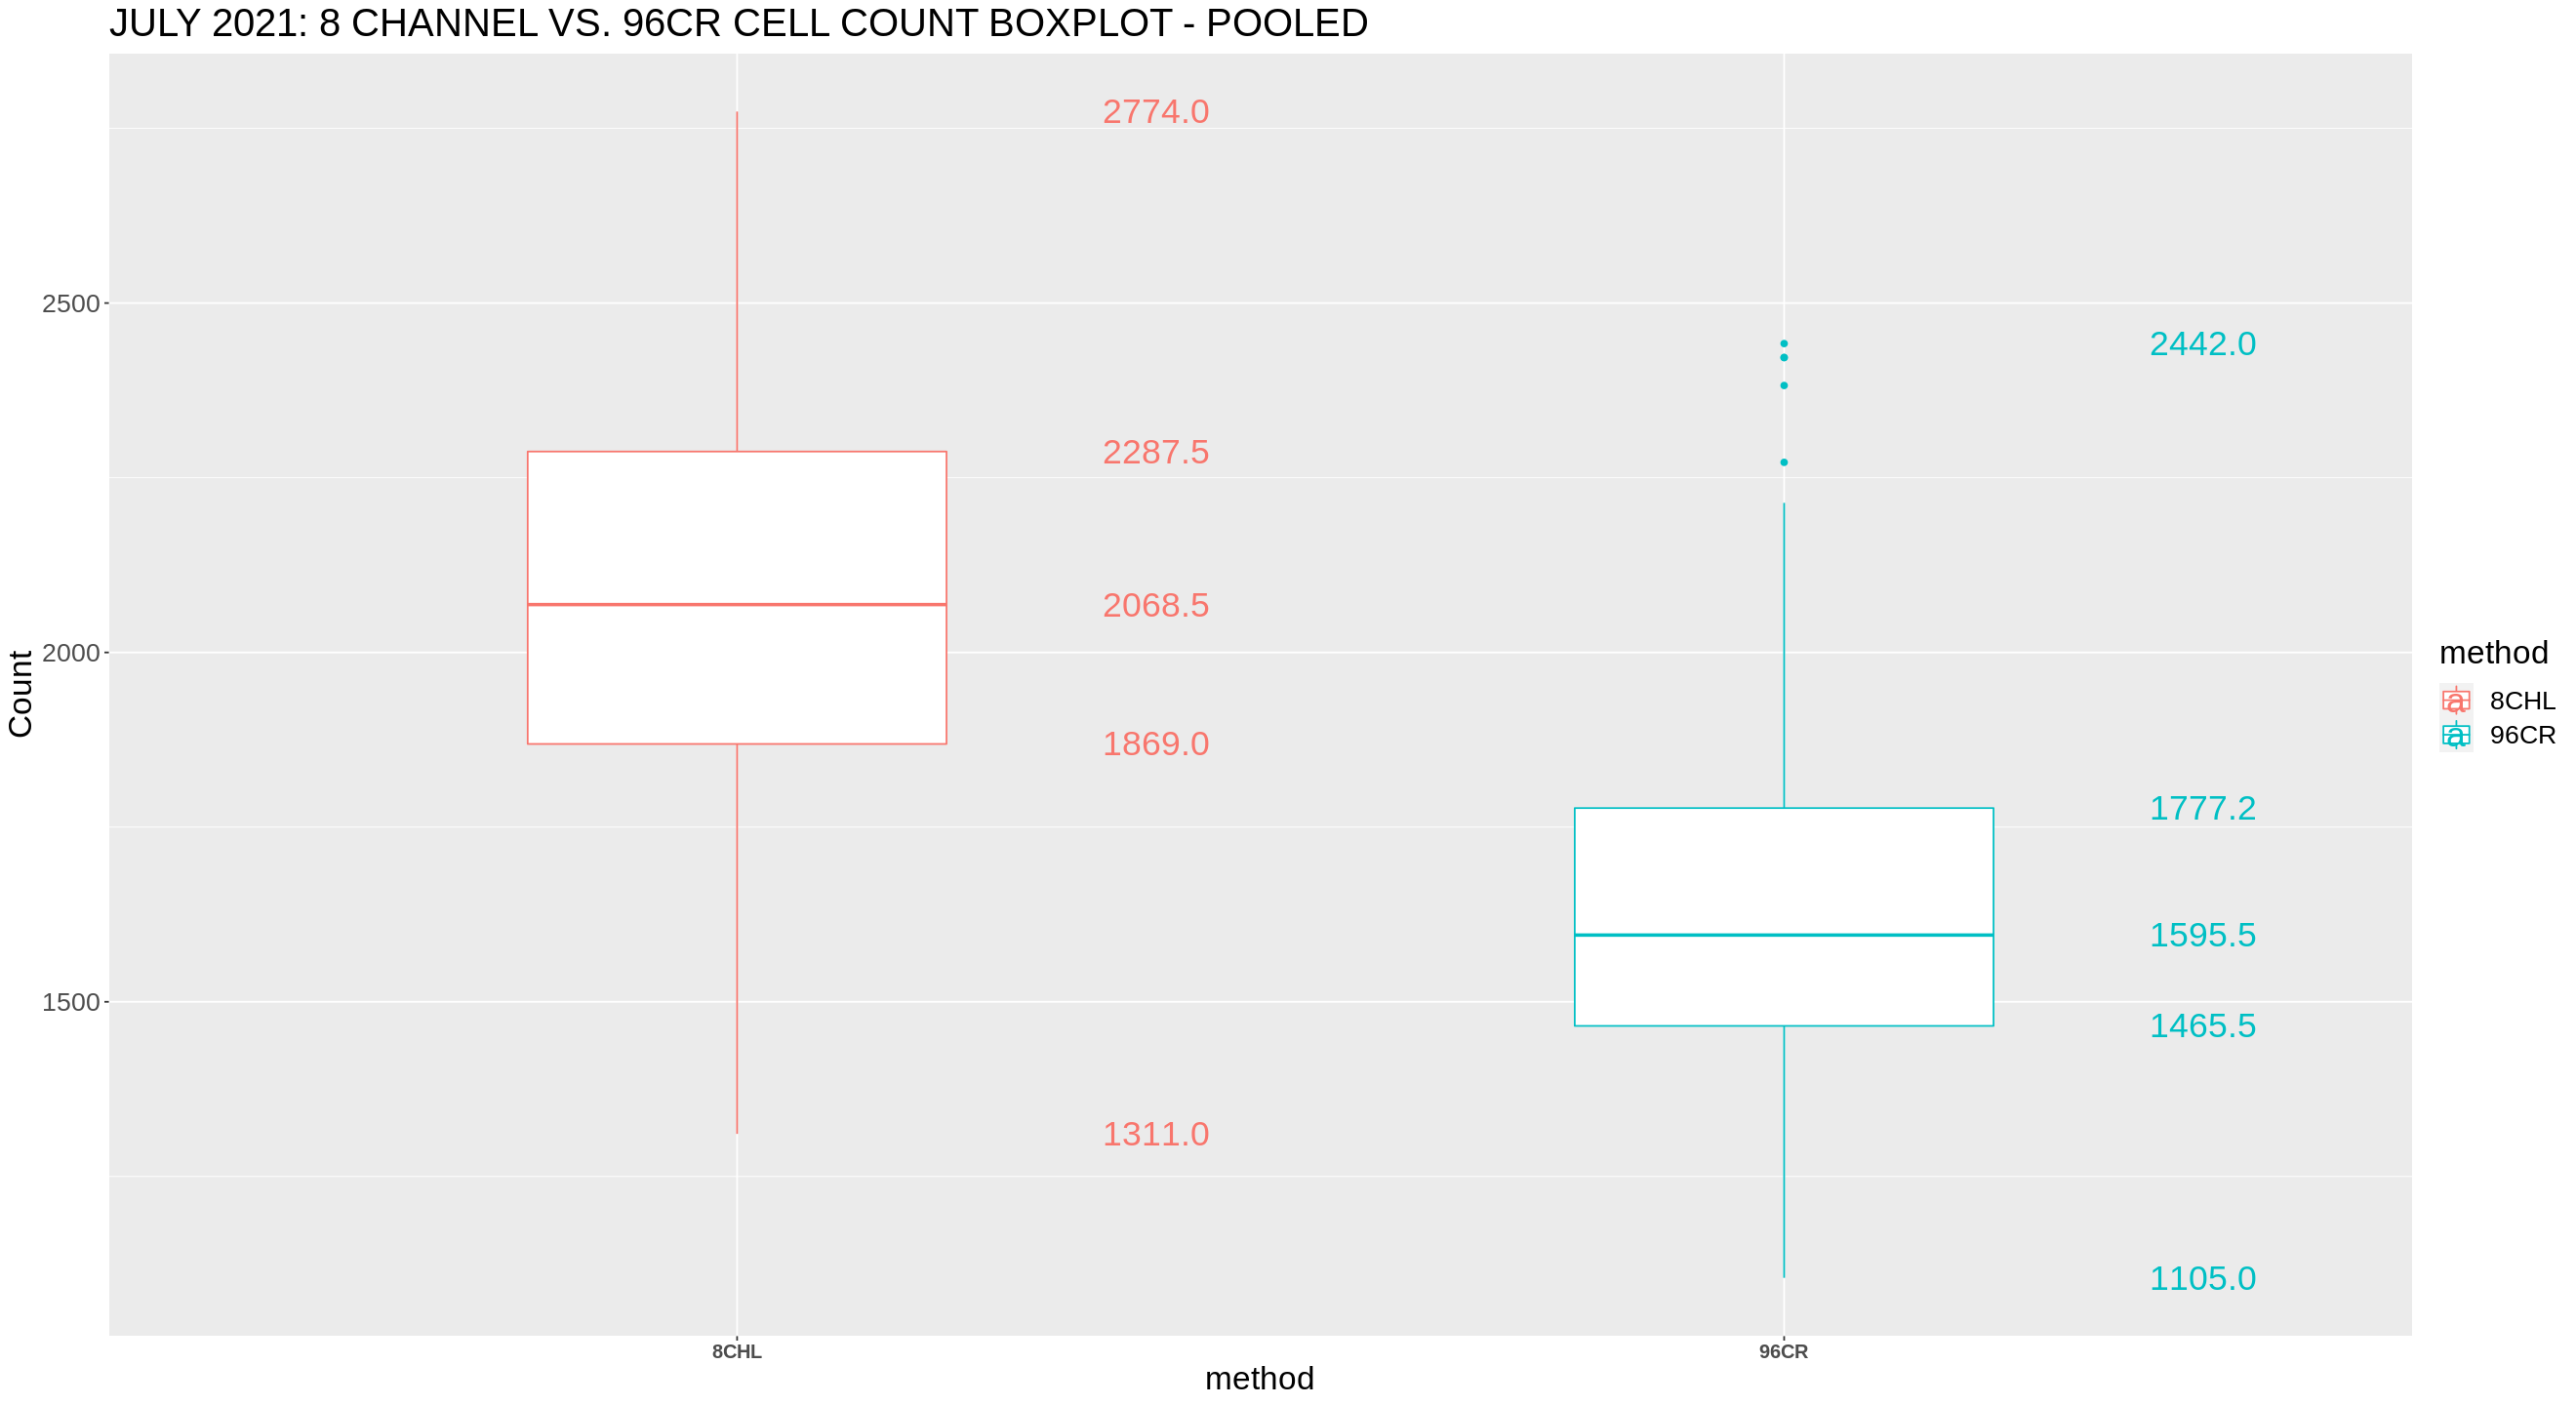

In [28]:
# pooled
ggplot(df, aes(x=method,y=Z)) +
  geom_boxplot(width = 0.4,aes(colour = method)) +
  stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=method),
           position=position_nudge(x=0.4), size=7.5) +
  labs(title="JULY 2021: 8 CHANNEL VS. 96CR CELL COUNT BOXPLOT - POOLED") +
  ylab("Count") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

In [10]:
head(dfm)

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method plate  
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93  240.8973 467.8717 8CHL   PLATE 1
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15  223.7325 444.5739 8CHL   PLATE 1
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10  201.7459 452.1773 8CHL   PLATE 1
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93  222.9273 448.8274 8CHL   PLATE 1
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59  188.4981 420.7647 8CHL   PLATE 1
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59  202.3096 421.2605 8CHL   PLATE 1
  wellid
1 A2    
2 A3    
3 A4    
4 A5    
5 A6    
6 A7

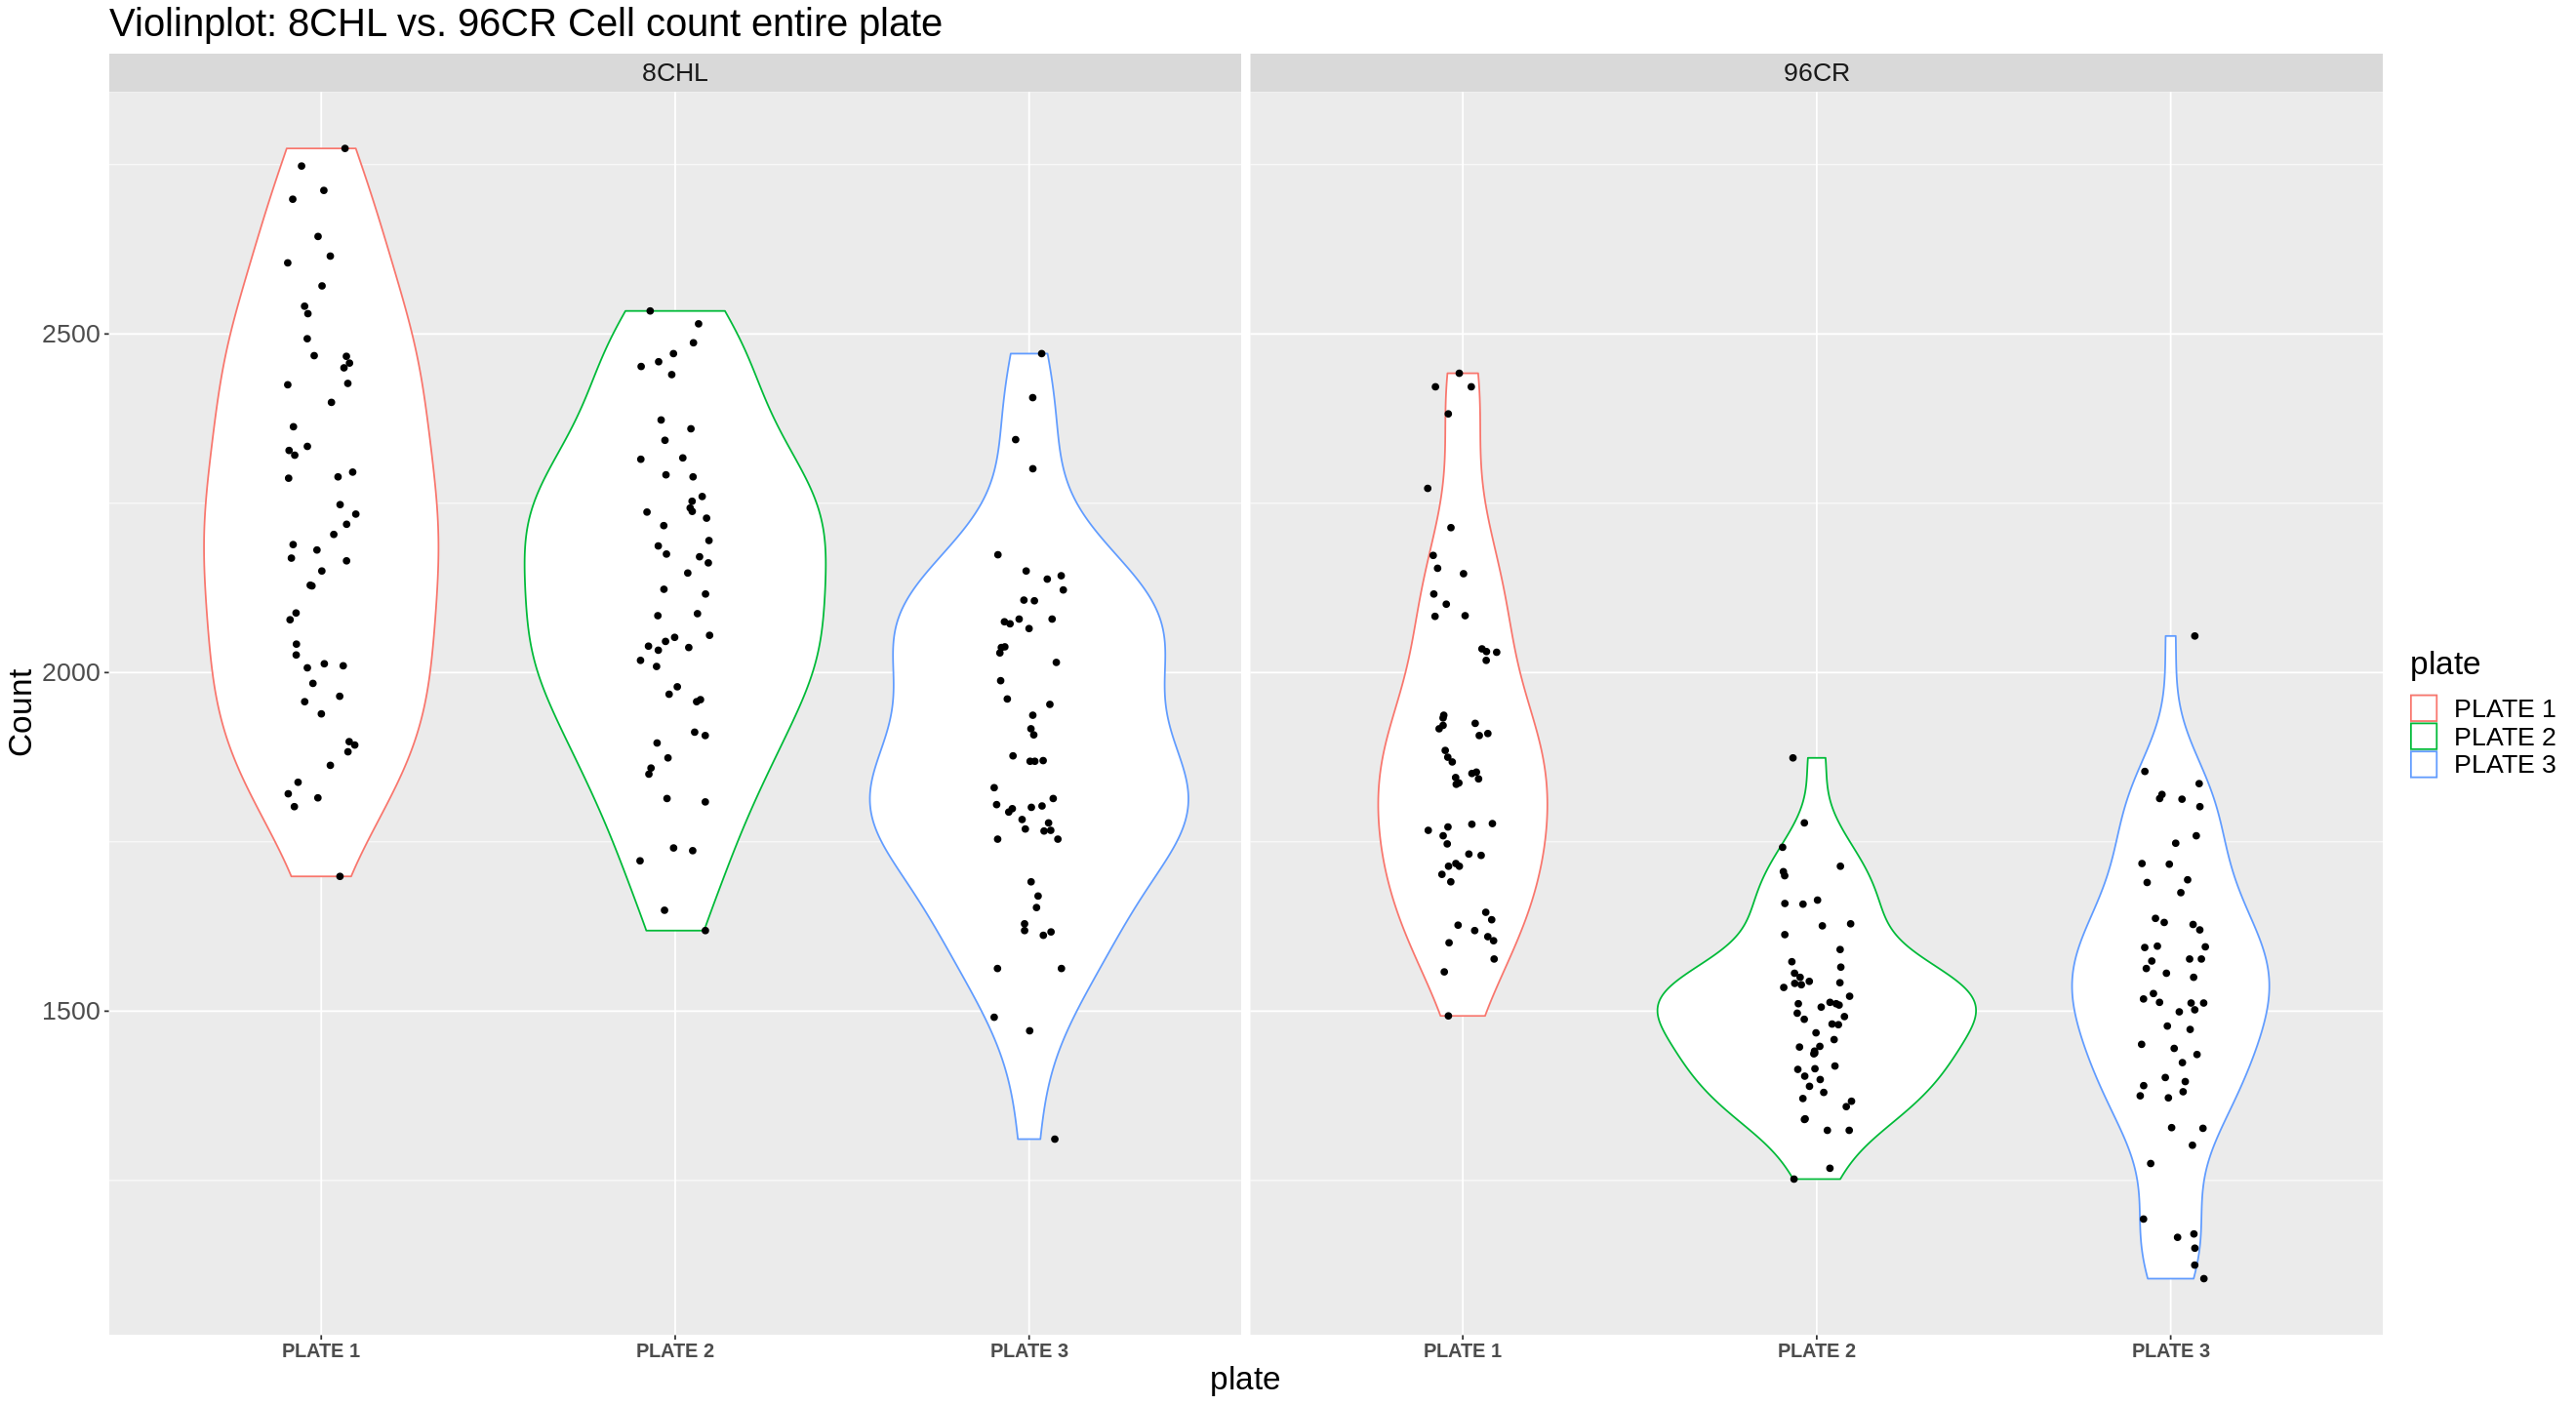

In [57]:
ggplot(df, aes(plate, Z)) + 
    geom_violin(aes(colour = plate)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("Violinplot: 8CHL vs. 96CR Cell count entire plate") +
    ylab("Count") +
    facet_wrap(~ method) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

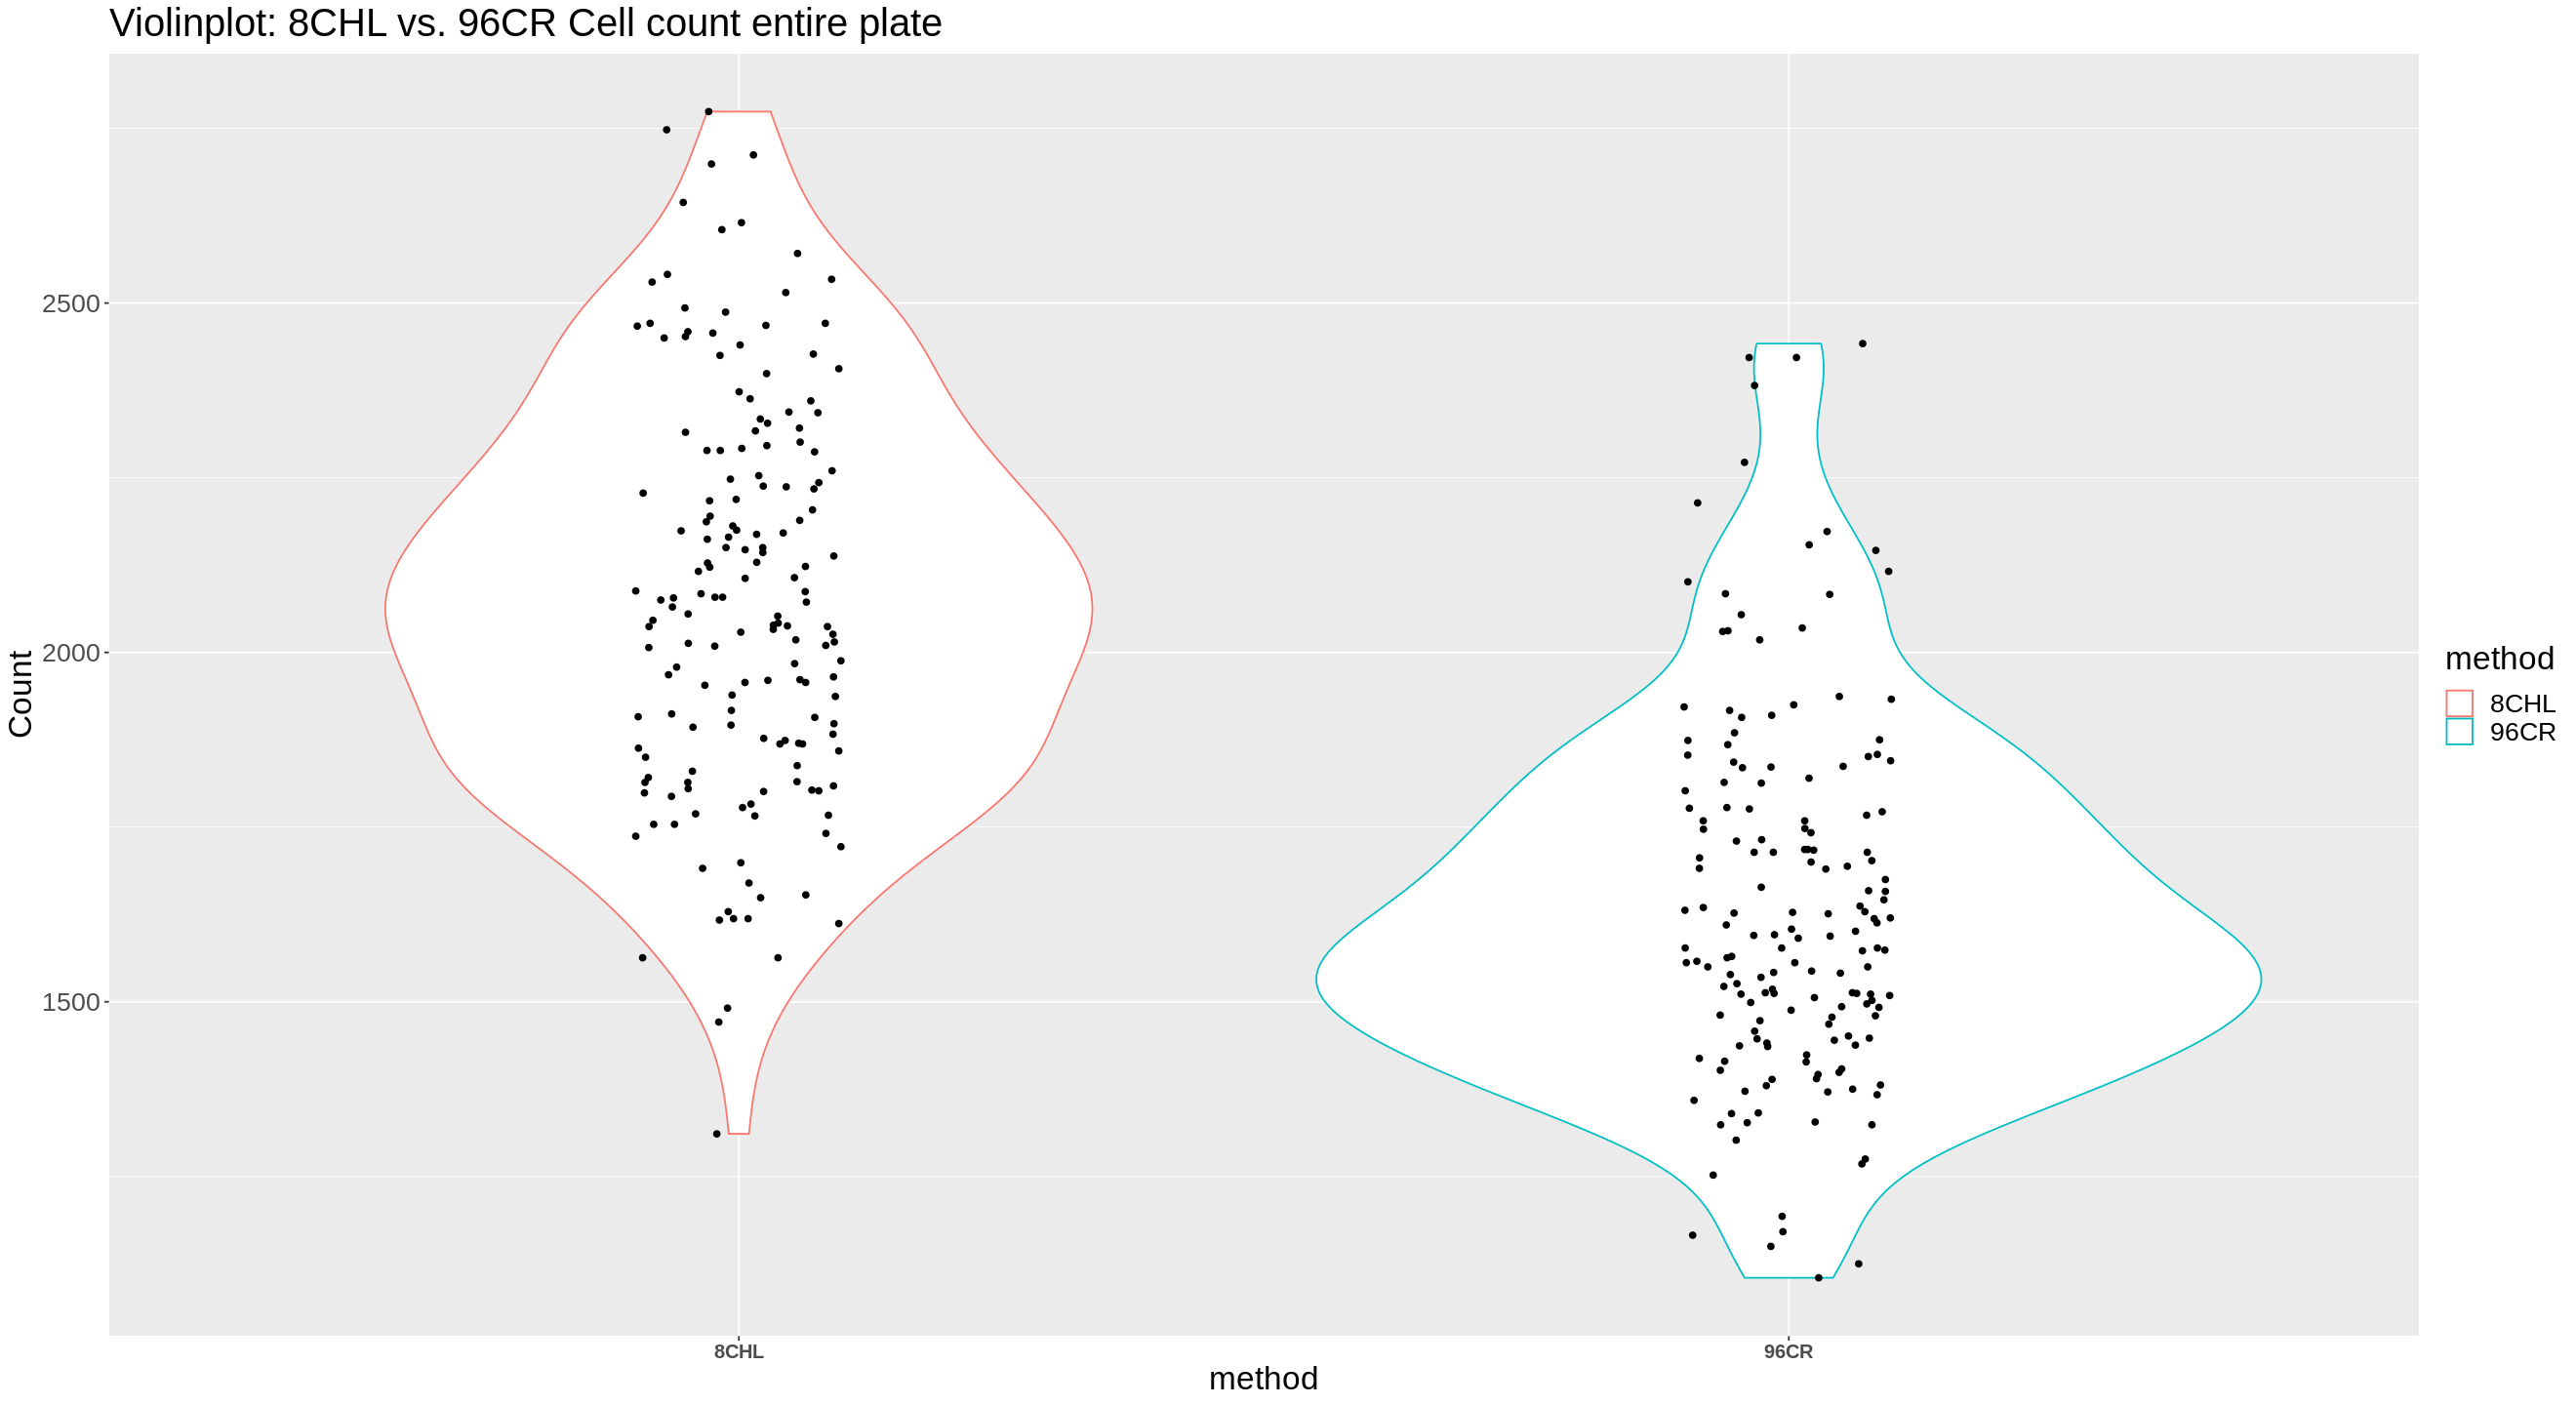

In [117]:
ggplot(df, aes(method, Z)) + 
    geom_violin(aes(colour = method)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("Violinplot: 8CHL vs. 96CR Cell count entire plate") +
    ylab("Count") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

## Heatmaps for cell count

![alt text](./rscript_data/96v8_redo_plate1/2021-07-28_8CHL_HM_plate1.png "Heatmap 8CHL Plate 1")

![alt text](./rscript_data/96v8_redo_plate2/2021-07-28_8CHL_HM_plate2.png "Heatmap 8CHL Plate 2")

![alt text](./rscript_data/96v8_redo_plate3/2021-07-28_8CHL_HM_plate3.png "Heatmap 8CHL Plate 3")

![alt text](./rscript_data/96v8_redo_plate1/2021-07-28_96CR_HM_plate1.png "Heatmap 96CR Plate 1")

![alt text](./rscript_data/96v8_redo_plate2/2021-07-28_96CR_HM_plate2.png "Heatmap 96CR Plate 2")

![alt text](./rscript_data/96v8_redo_plate3/2021-07-28_96CR_HM_plate3.png "Heatmap 96CR Plate 3")

## Histograms for reagents

![alt text](./rscript_data/96v8_redo_plate1/2021-07-28_8CHL_HST_plate1.png "Histogram 8CHL Plate 1")

![alt text](./rscript_data/96v8_redo_plate2/2021-07-28_8CHL_HST_plate2.png "Histogram 8CHL Plate 2")

![alt text](./rscript_data/96v8_redo_plate3/2021-07-28_8CHL_HST_plate3.png "Histogram 8CHL Plate 3")

![alt text](./rscript_data/96v8_redo_plate1/2021-07-28_96CR_HST_plate1.png "Histogram 96CR Plate 1")

![alt text](./rscript_data/96v8_redo_plate2/2021-07-28_96CR_HST_plate2.png "Histogram 96CR Plate 2")

![alt text](./rscript_data/96v8_redo_plate3/2021-07-28_96CR_HST_plate3.png "Histogram 96CR Plate 3")

In [76]:
#wellids <- paste0(rep(LETTERS[1:8], each=8), rep(seq(1,8)))
#wellids <- wellids[!grepl(pattern = '[1]', x = wellids)]

In [5]:
dff <- df %>% mutate(wellid = paste0(Y,X))
head(dff)

X Y Z    method plate   wellid
1 2 A 2774 8CHL   PLATE 1 A2    
2 3 A 2644 8CHL   PLATE 1 A3    
3 4 A 2605 8CHL   PLATE 1 A4    
4 5 A 2748 8CHL   PLATE 1 A5    
5 6 A 2615 8CHL   PLATE 1 A6    
6 7 A 2699 8CHL   PLATE 1 A7

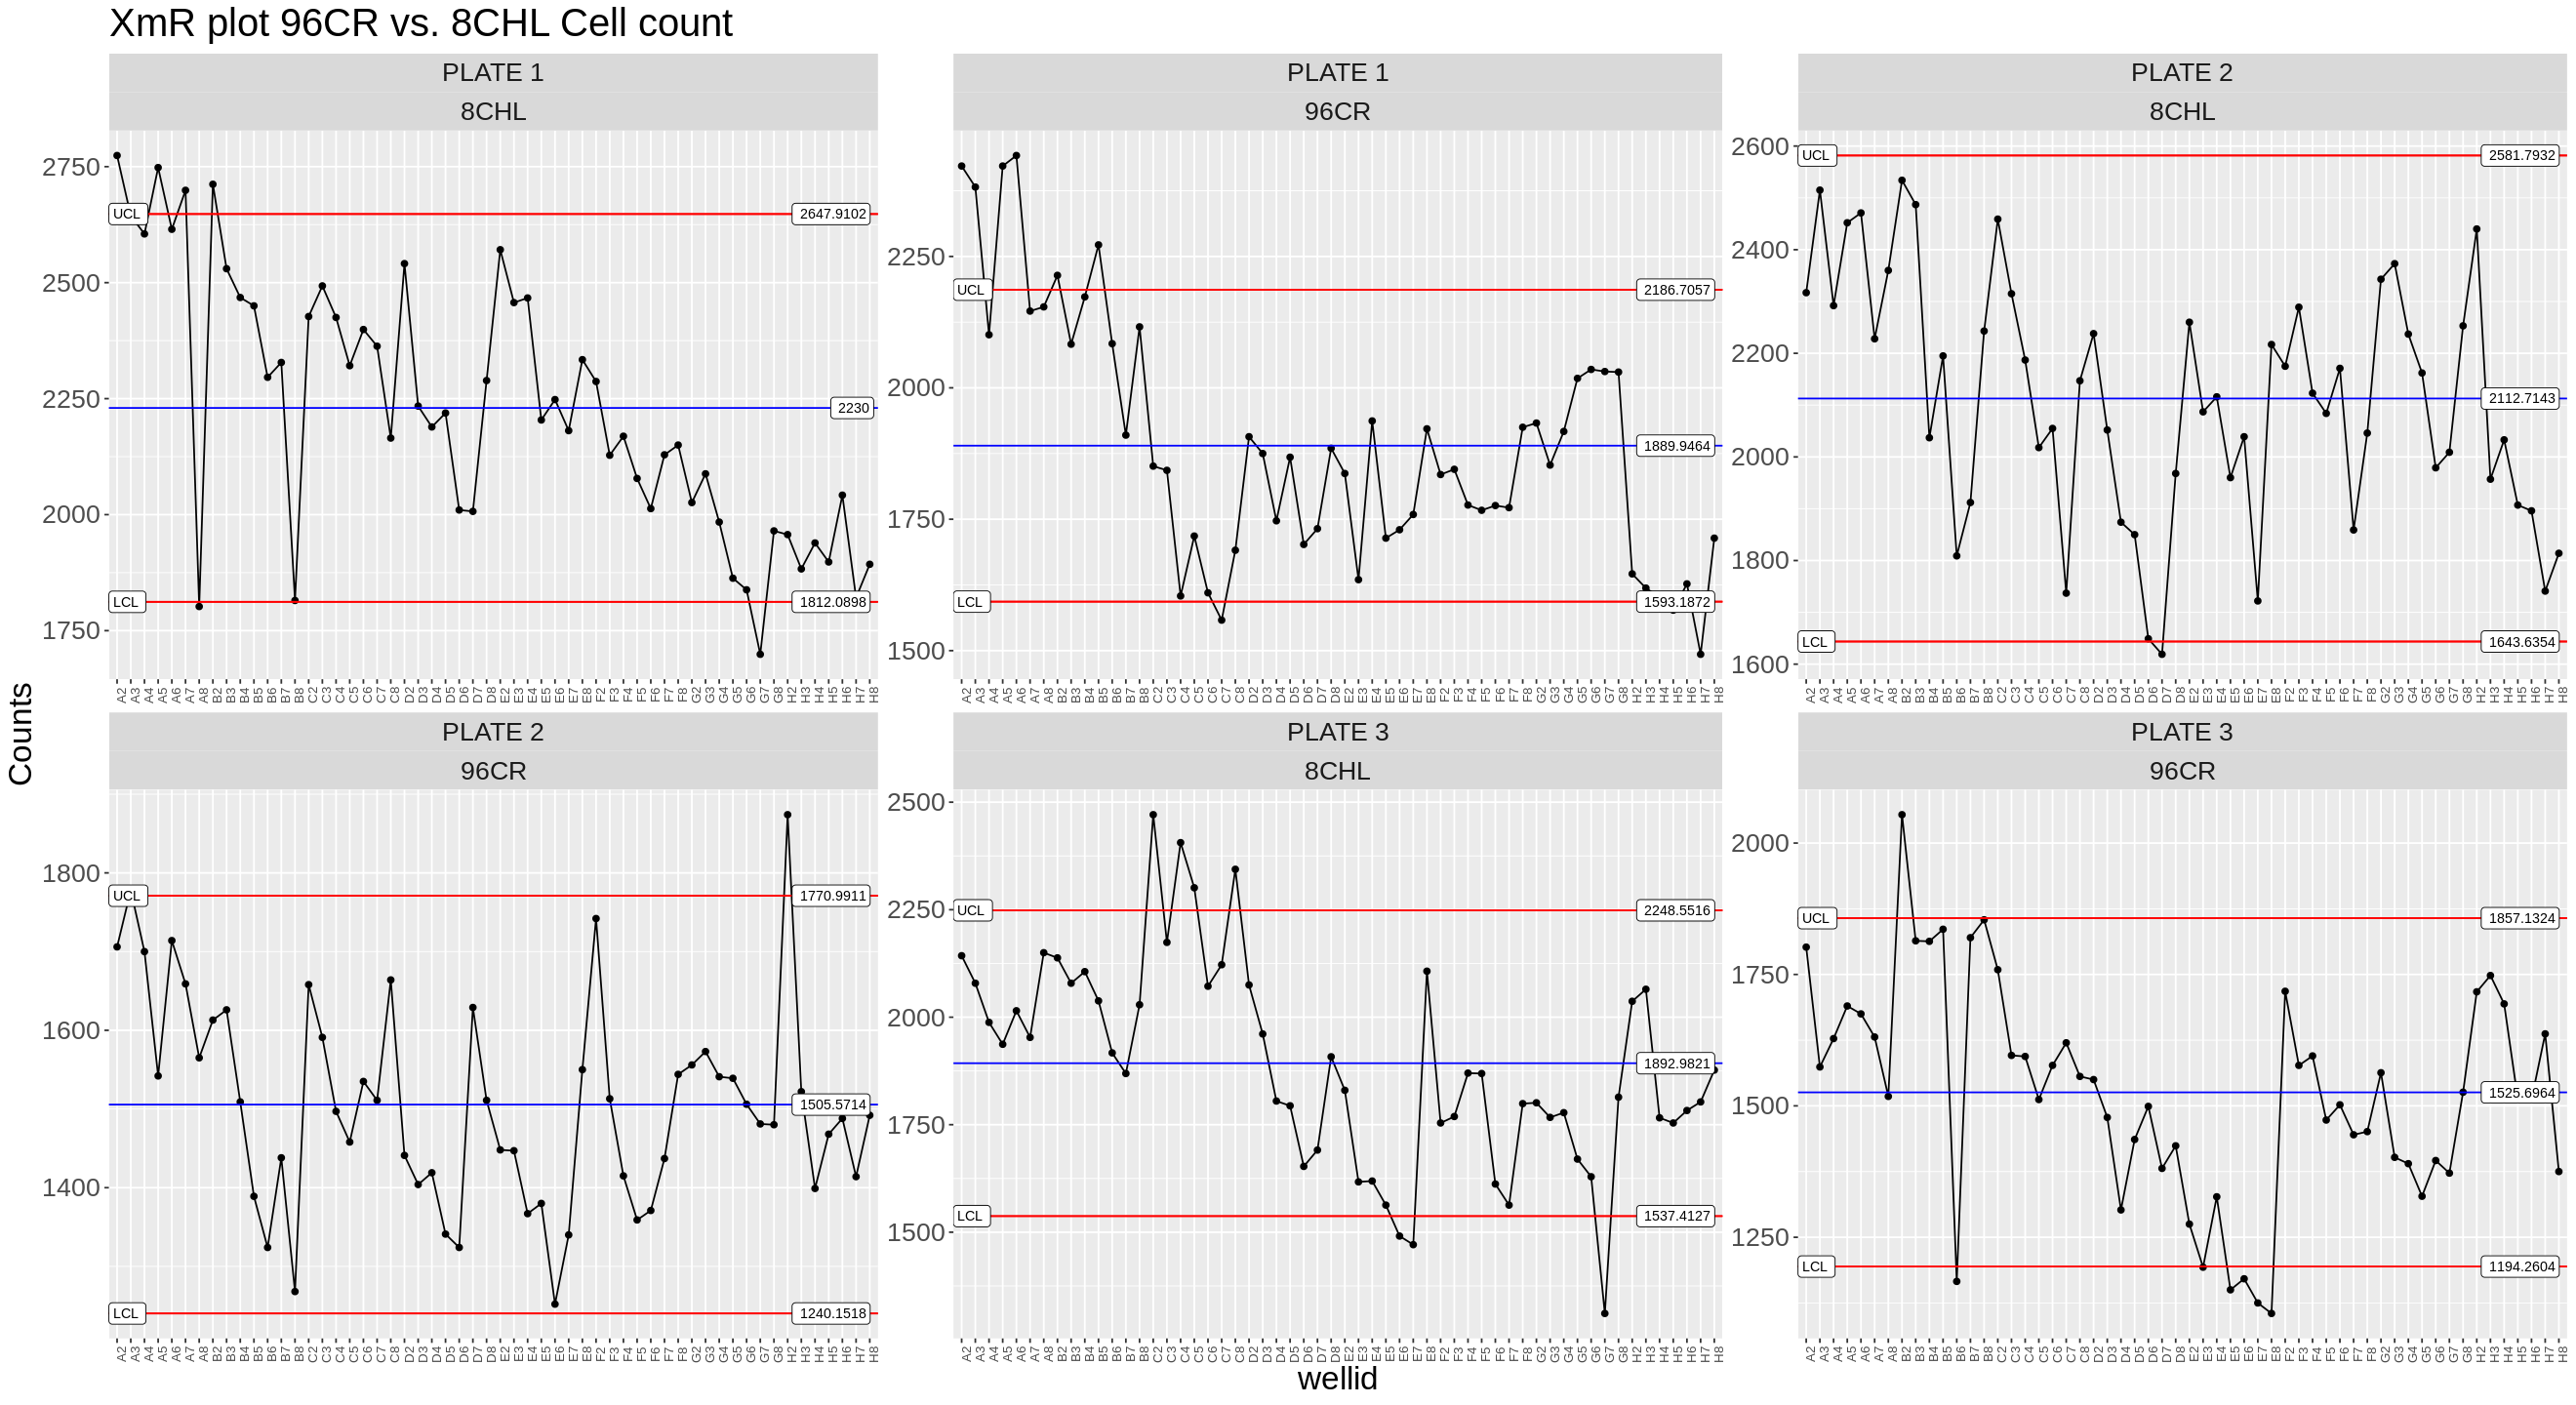

In [13]:
ggplot(dff, aes(x=wellid, y=Z, group=plate)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("Counts") +
  facet_wrap(plate~method, scales = "free") +
  ggtitle("XmR plot 96CR vs. 8CHL Cell count") + 
  theme(axis.text.x = element_text(size = 8, angle = 90),
        text = element_text(size=20))

In [8]:
head(dff)

X Y Z    method plate   wellid
1 2 A 2774 8CHL   PLATE 1 A2    
2 3 A 2644 8CHL   PLATE 1 A3    
3 4 A 2605 8CHL   PLATE 1 A4    
4 5 A 2748 8CHL   PLATE 1 A5    
5 6 A 2615 8CHL   PLATE 1 A6    
6 7 A 2699 8CHL   PLATE 1 A7

In [9]:
dft <- dff %>% group_by(method, wellid) %>% summarize(Mean = mean(Z))
head(dft)

`summarise()` regrouping output by 'method' (override with `.groups` argument)



method wellid Mean    
1 8CHL   A2     2411.333
2 8CHL   A3     2412.667
3 8CHL   A4     2295.000
4 8CHL   A5     2379.000
5 8CHL   A6     2367.000
6 8CHL   A7     2293.333

In [15]:
dft2 <- dff %>% 
    mutate(row = substr(wellid, 1,1) ) %>% 
    group_by(row, method) %>%
    summarise(AvgRow = mean(Z))
head(dft2)

`summarise()` regrouping output by 'row' (override with `.groups` argument)



row method AvgRow  
1 A   8CHL   2323.190
2 A   96CR   1869.095
3 B   8CHL   2190.095
4 B   96CR   1779.810
5 C   8CHL   2257.190
6 C   96CR   1619.190

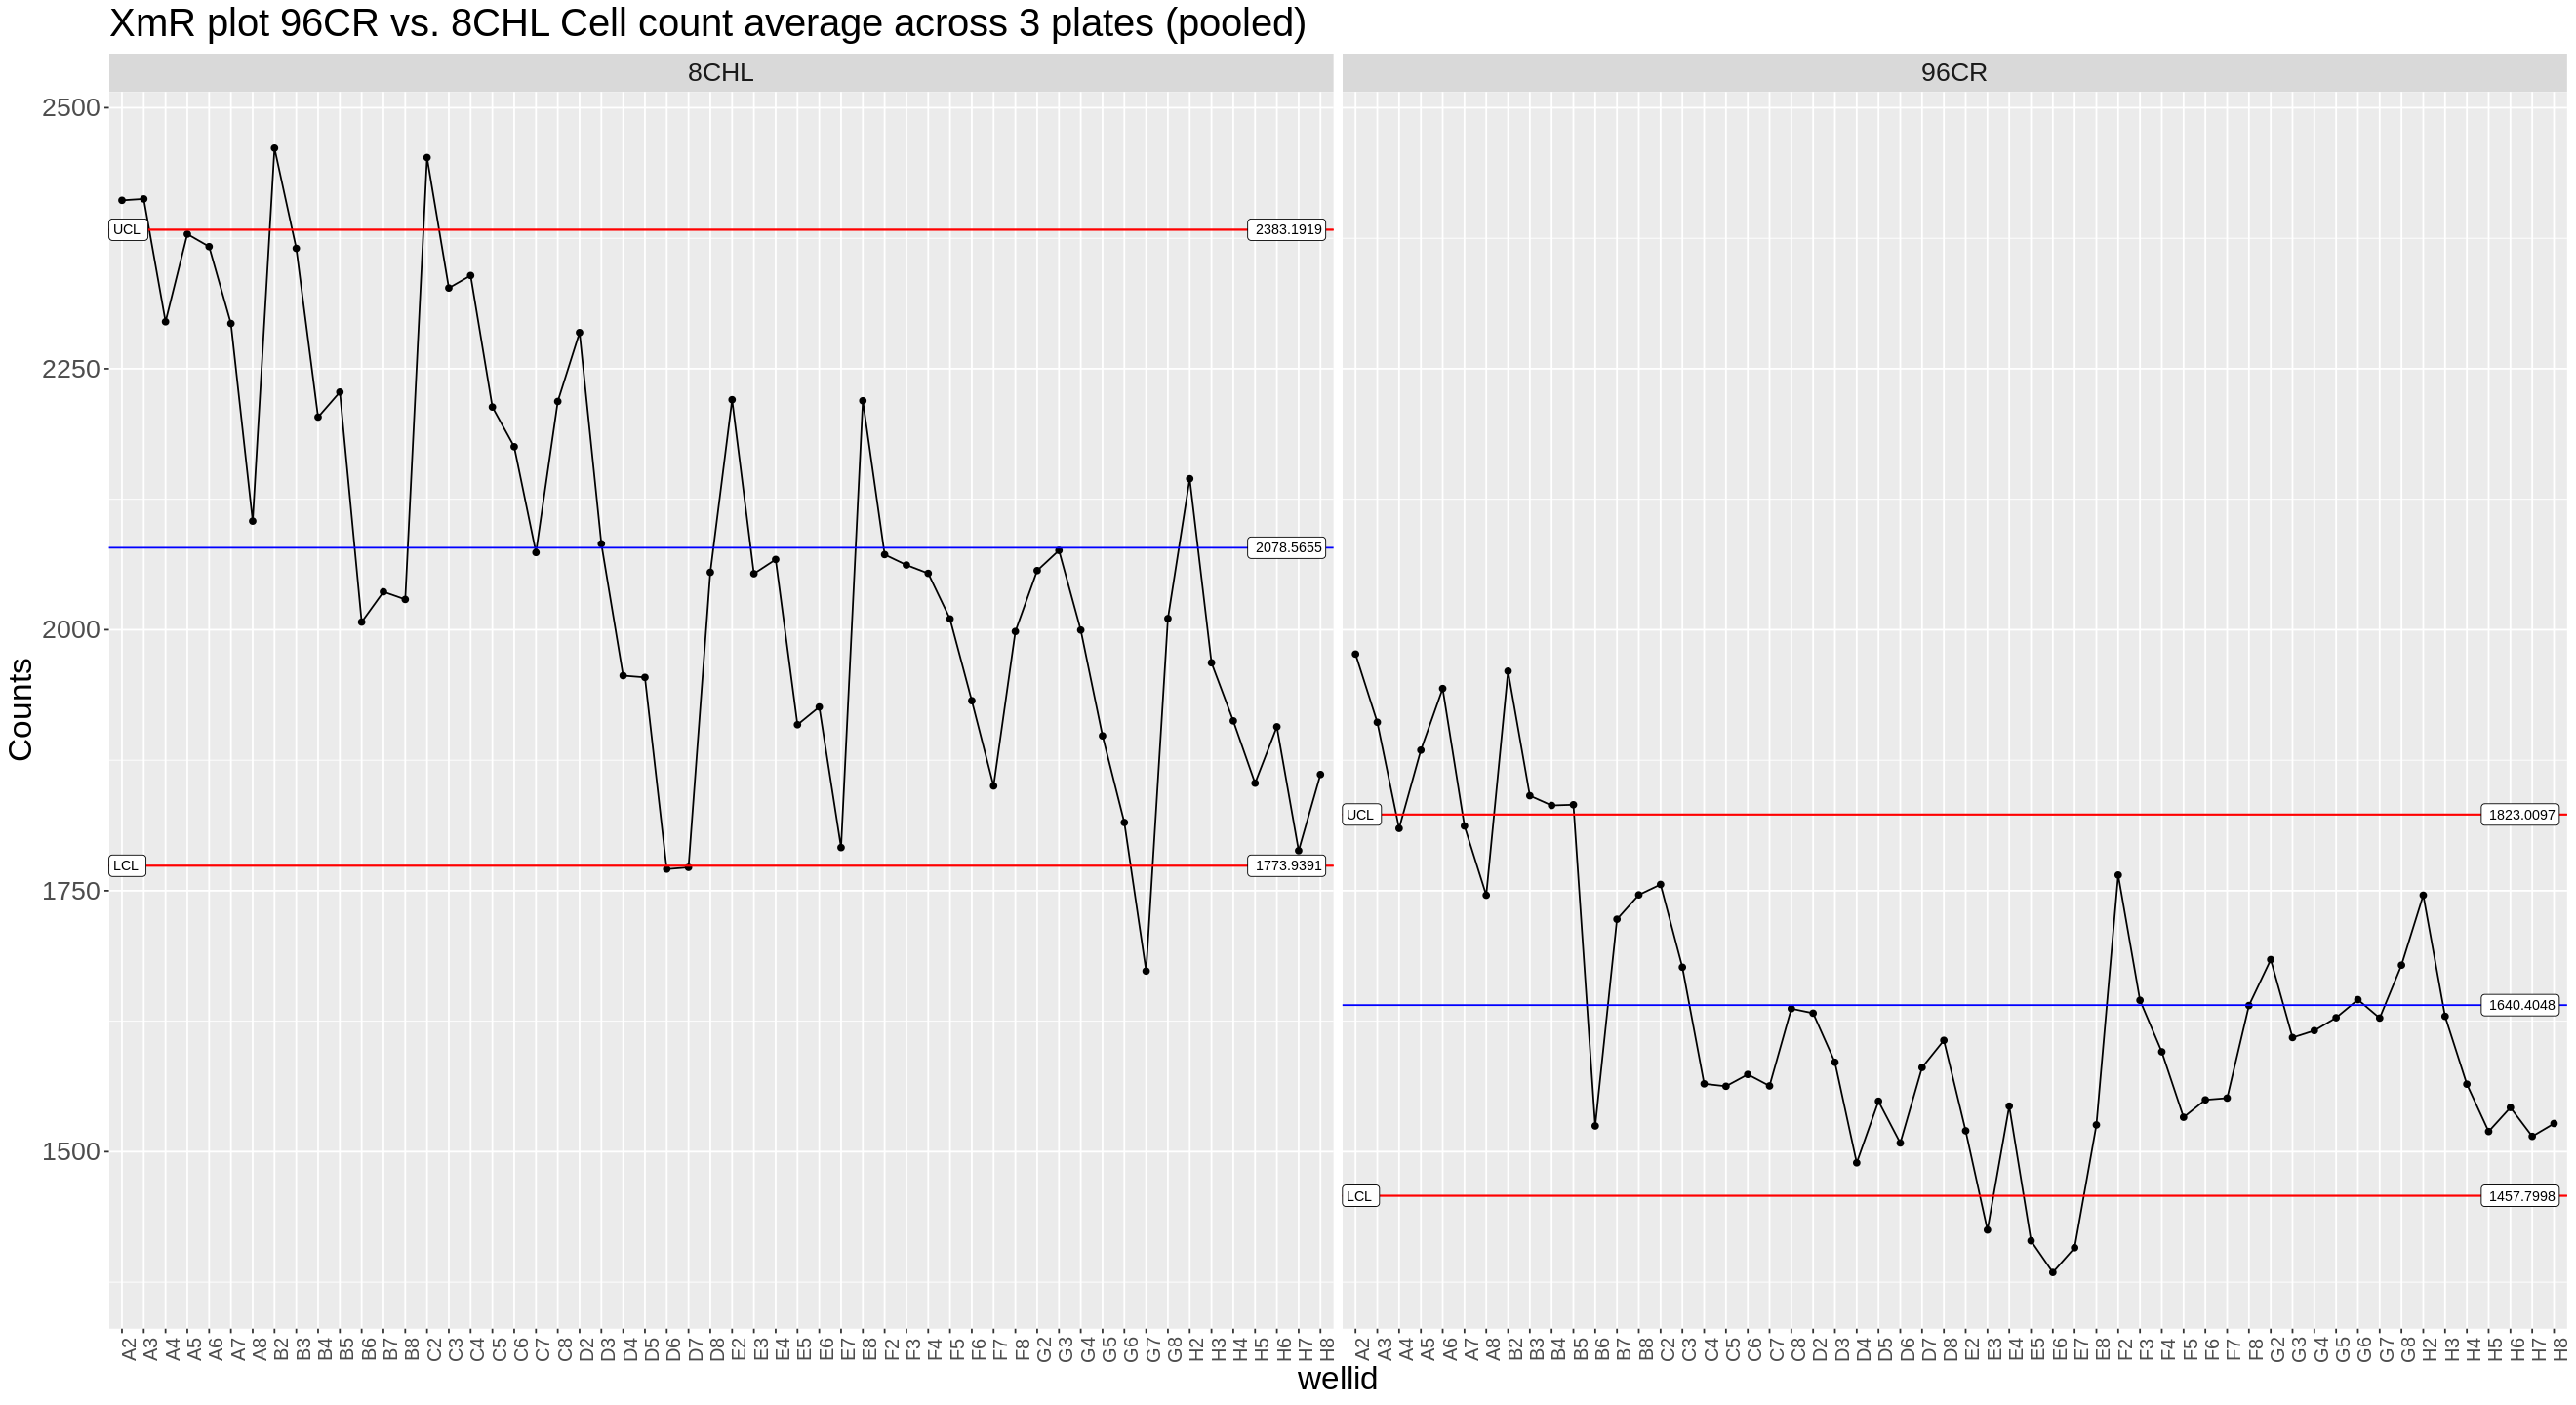

In [23]:
# pooled triplicates
ggplot(dft, aes(x=wellid, y=Mean, group = method)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("Counts") +
  facet_wrap(~method) +
  ggtitle("XmR plot 96CR vs. 8CHL Cell count average across 3 plates (pooled)") + 
  theme(axis.text.x = element_text(size = 12, angle = 90),
        text = element_text(size=20))

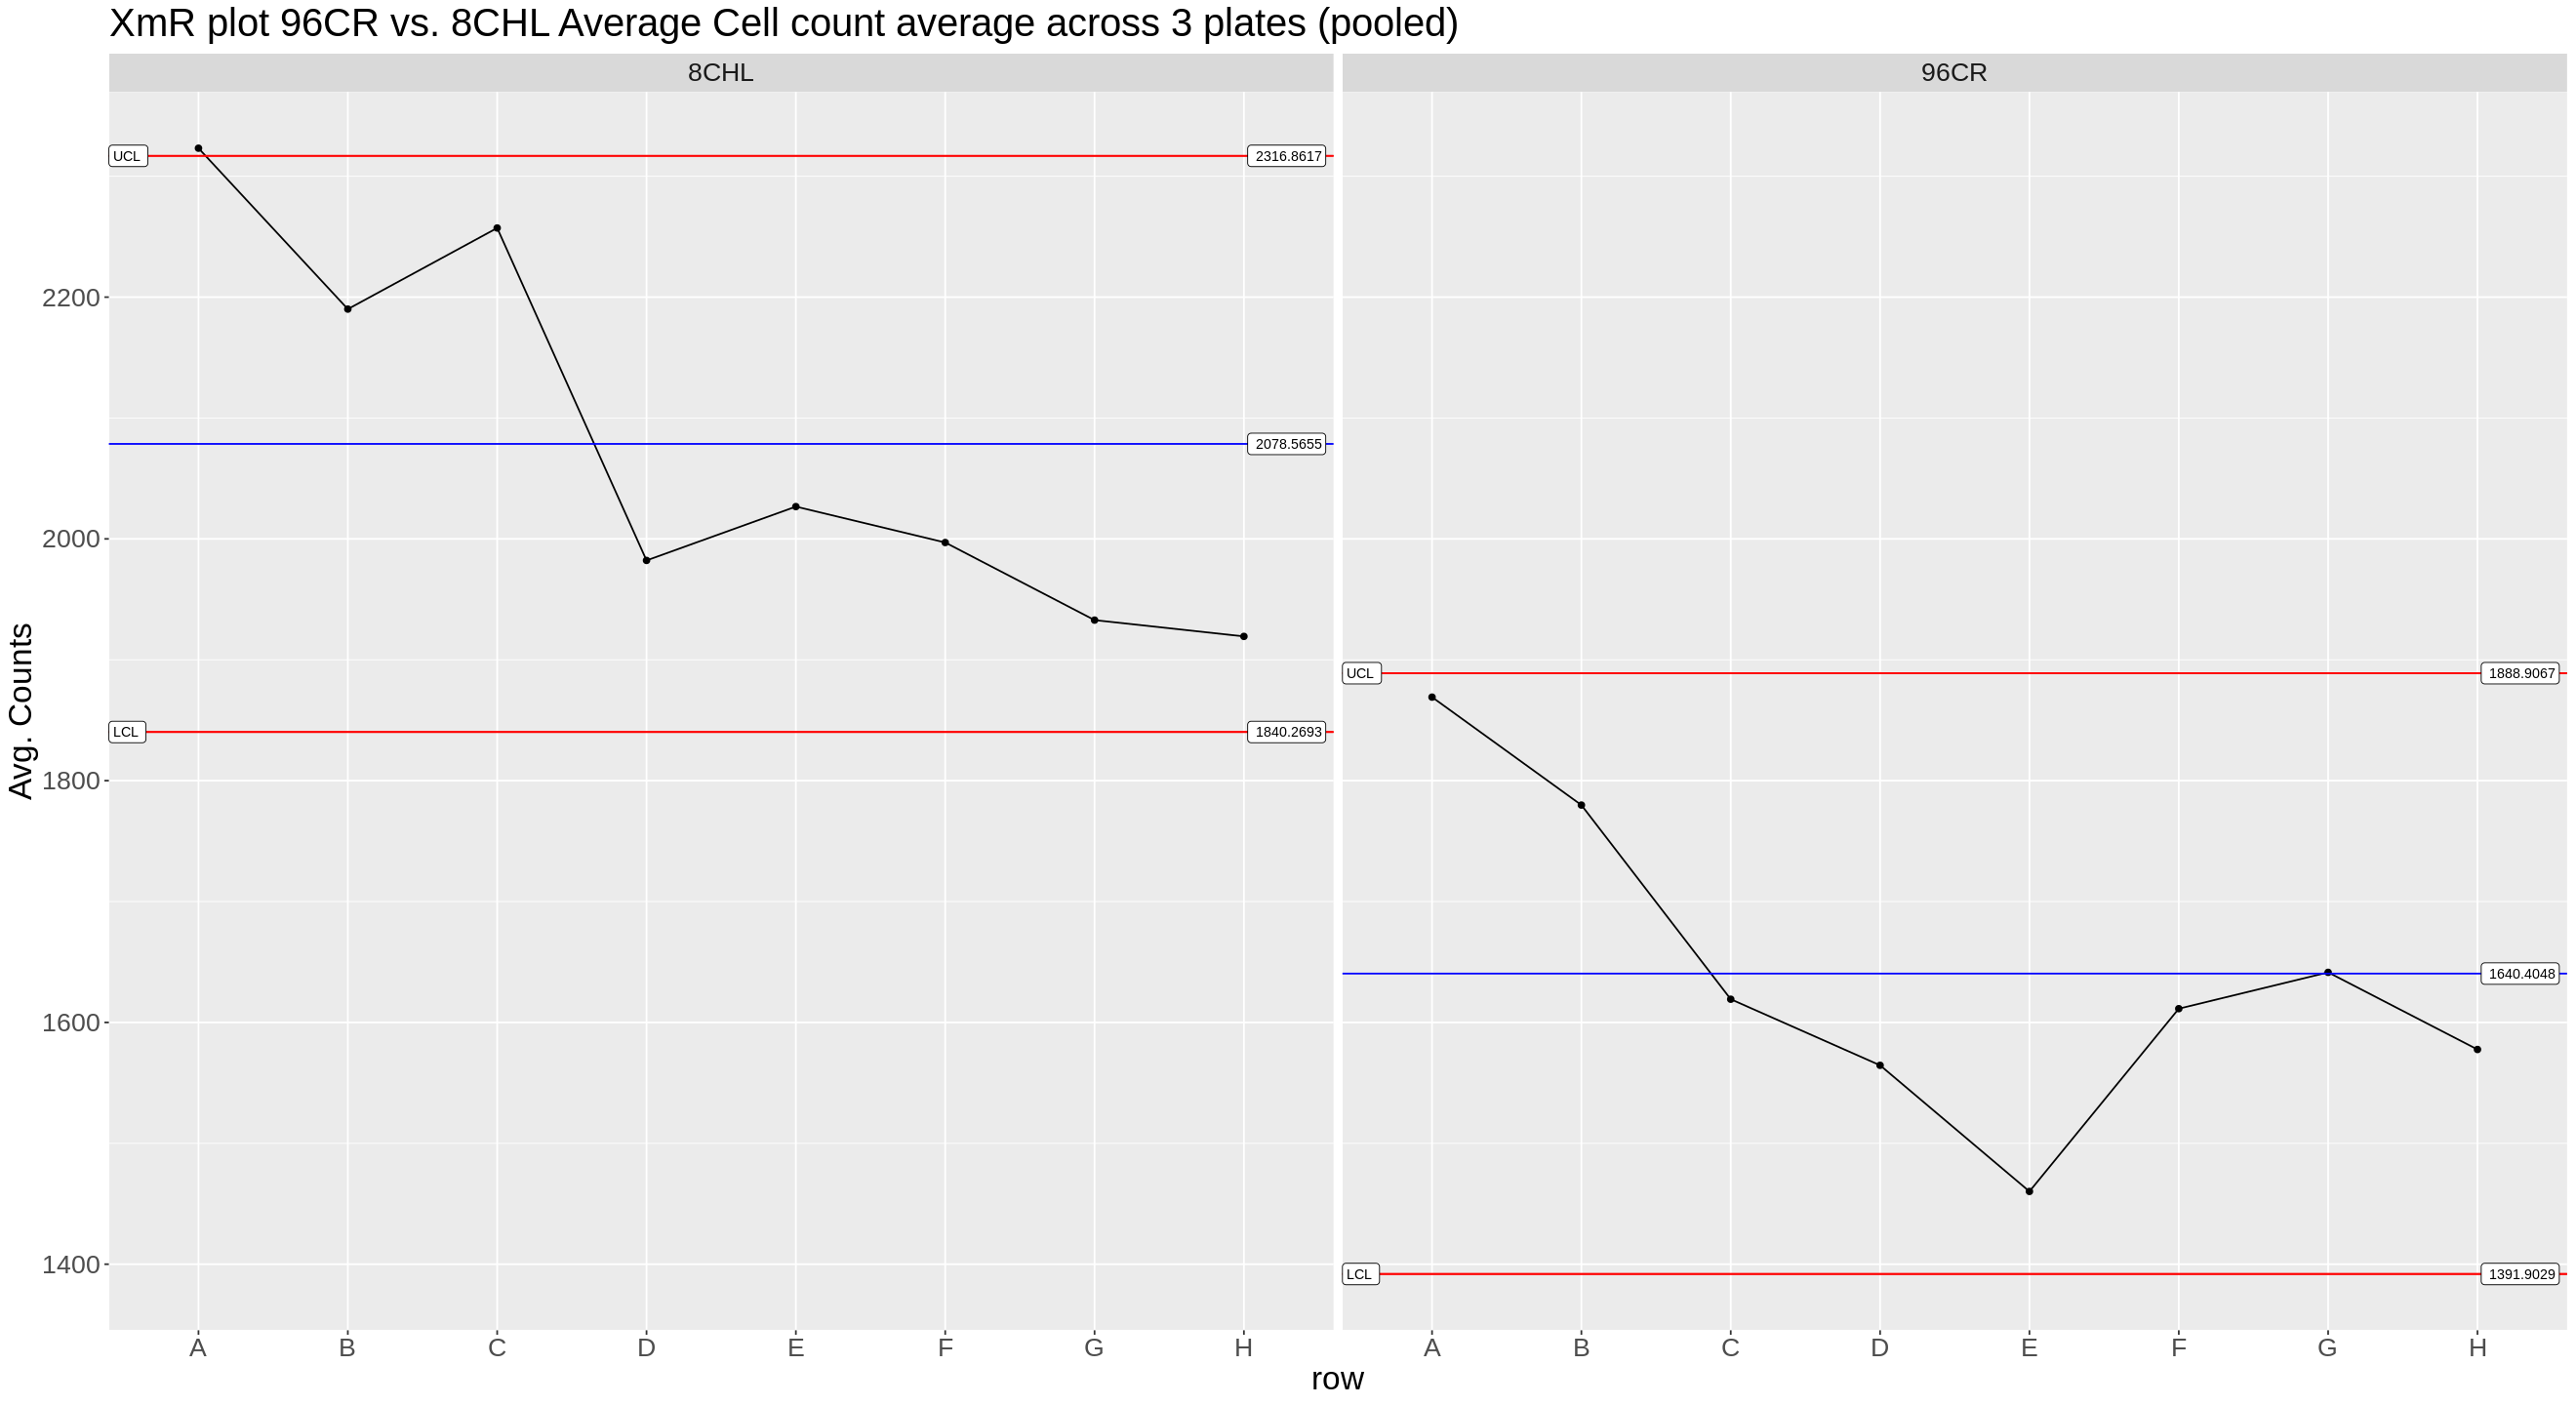

In [20]:
# per row average 
ggplot(dft2, aes(x=row, y=AvgRow, group = method)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("Avg. Counts") +
  facet_wrap(~method) +
  ggtitle("XmR plot 96CR vs. 8CHL Average Cell count average across 3 plates (pooled)") + 
  theme(axis.text.x = element_text(size = 16),
        text = element_text(size=20))

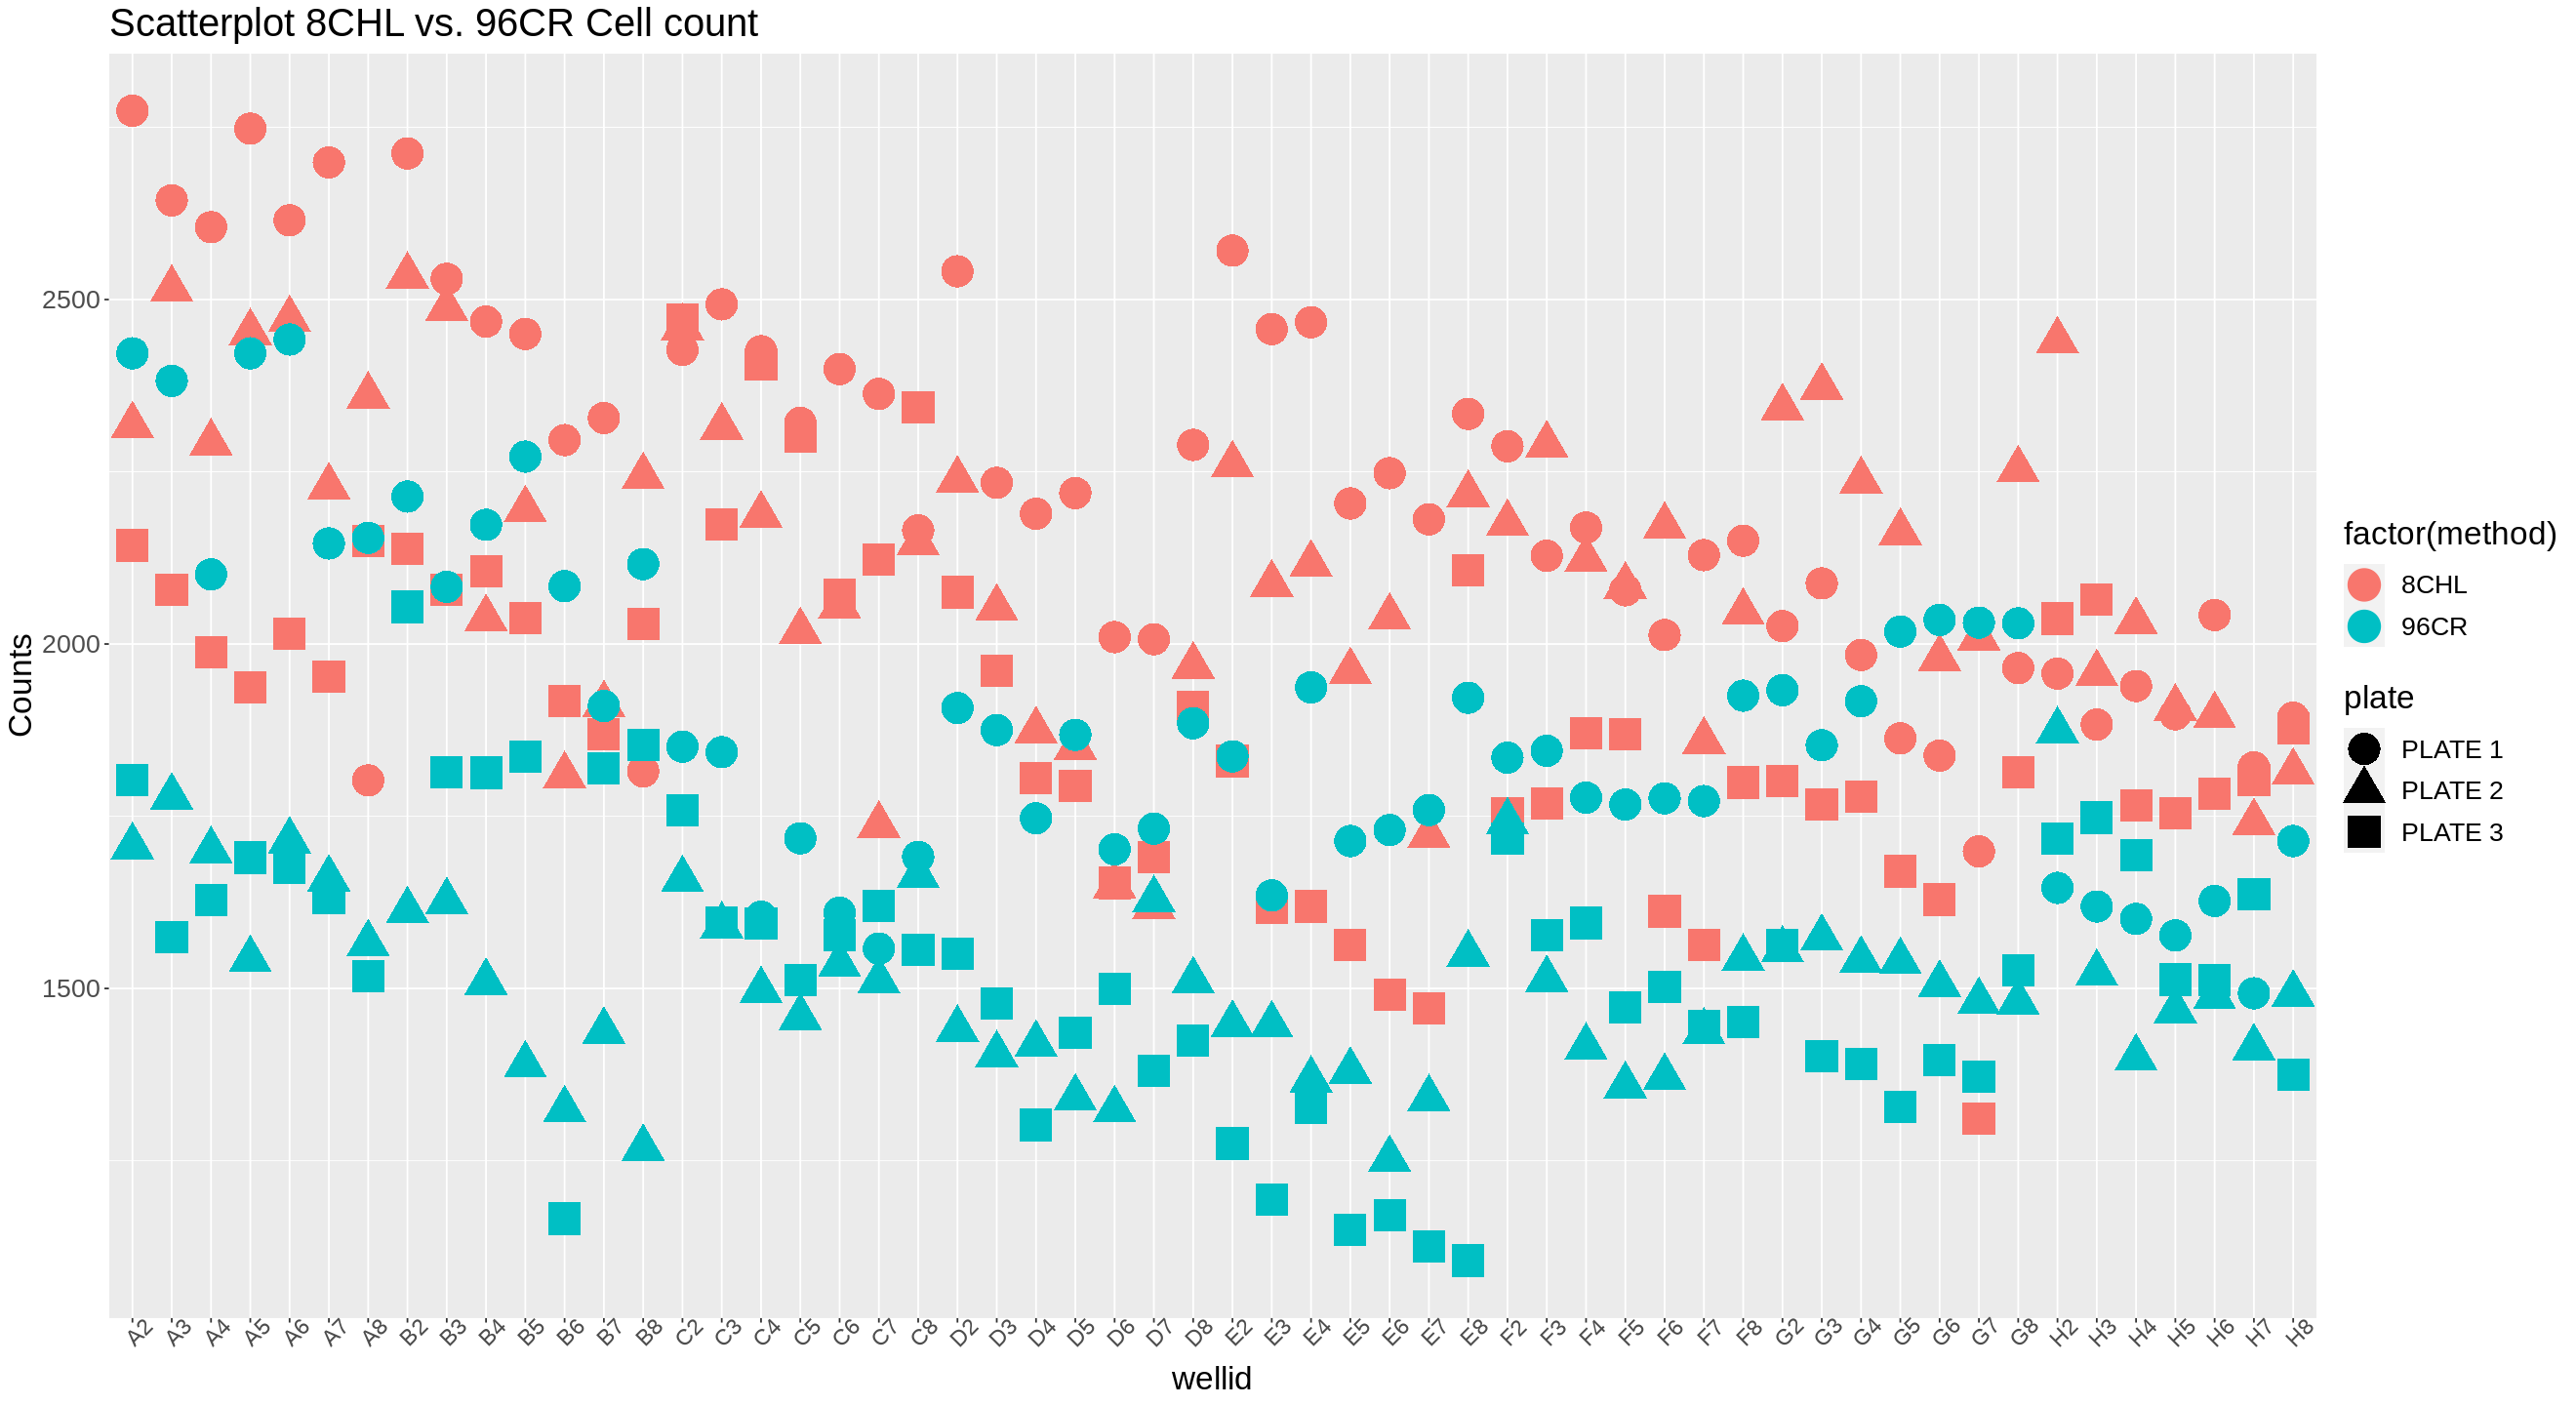

In [19]:
ggplot(dff, aes(x=wellid, y=Z) ) +
  geom_point(size = 9, aes(colour = factor(method), shape = plate)) + 
  ylab("Counts") +
  ggtitle("Scatterplot 8CHL vs. 96CR Cell count") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 14, angle = 45))

#### Summary statistics

#### USE SI / MFI+ AS SAMPLE DATA

In [6]:
df_si_ls <- list()

for (i in seq(3)) {
    dir = paste0(parentdir, "96v8_redo_plate", i)
    fi = list.files(dir)
    
    mtd = "8CHL"
    select_fi = fi[grepl(paste0(mtd,"_DF"), fi)]
    df.tmp <- read.csv(file.path(dir, select_fi)) %>%
        na.omit() %>% select(SAMPLE_NAME, 
            MFI.,
            MFI..1,
            SI,
            SN) %>%
        filter(grepl("[A-H]0[2-9]|1[0-1]", SAMPLE_NAME)) %>%
        mutate_at(vars(MFI., MFI..1, SI, SN), funs(as.numeric)) %>%
        mutate(method = mtd,
               plate = paste('PLATE', i),
               wellid = substr(SAMPLE_NAME, 14,15))
    
        mtd = "96CR"
        select_fi = fi[grepl(paste0(mtd,"_DF"), fi)]
        
        df_si_ls[[i]] <- rbind(df.tmp, read.csv(file.path(dir, select_fi)) %>% 
            na.omit() %>% select(SAMPLE_NAME, 
                MFI.,
                MFI..1,
                SI,
                SN) %>%
            filter(grepl("[A-H]0[2-9]|1[0-1]", SAMPLE_NAME)) %>%
            mutate_at(vars(MFI., MFI..1, SI, SN), funs(as.numeric)) %>%
            mutate(method = mtd,
                   plate = paste('PLATE', i),
                   wellid = substr(SAMPLE_NAME, 14,15))
            ) # rbind
}

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [7]:
dfm <- do.call(rbind,df_si_ls)
head(dfm)

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method plate  
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93  240.8973 467.8717 8CHL   PLATE 1
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15  223.7325 444.5739 8CHL   PLATE 1
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10  201.7459 452.1773 8CHL   PLATE 1
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93  222.9273 448.8274 8CHL   PLATE 1
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59  188.4981 420.7647 8CHL   PLATE 1
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59  202.3096 421.2605 8CHL   PLATE 1
  wellid
1 A2    
2 A3    
3 A4    
4 A5    
5 A6    
6 A7

In [9]:
nrow(dfm)

[1] 336

#### F test for normality
- The p values are big, meaning the variances do not change more from plate 1 to 3

#### Anderson-Darling test
- goodness of fit test that measures how well your data fit a specified distribution.
- H_0: The data follow a specified distribution

#### Shapiro test, bonett test, qq plot to show normality
- shapiro-wilk test - tell if a random sample comes from a normal distribution
- bonett test - measure of kurtosis for normally distributed data
- under the hypothesis of normality, data should have Geary's kurtosis equal to sqrt(2/pi) (0.7979)
- the kurtosis is near .7979, with p-value barely above 0.05, indicating it is slightly normal

In [10]:
# MFI + 
df_stats = data.frame()

for (i in seq(3)){
        plt = paste("PLATE", i)
        df_stats[i, "PLATE"] = plt 
        df.t <- dfm %>% filter(plate == plt)
        stat <- var.test(MFI. ~ method, df.t)
        df_stats[i, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        stat <- ad.test(df.t$MFI.)
        df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        stat <- shapiro.test(df.t$MFI.)
        df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        stat <- bonett.test(df.t$MFI.)
        df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        print("geary result:")
        stat <- geary(df.t$MFI.)
        df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
        print(stat)
}
write.csv(df_stats, paste0("96v8_pair_3plts_stats_MFI.csv"), row.names = FALSE)


	F test to compare two variances

data:  MFI. by method
F = 1.544, num df = 55, denom df = 55, p-value = 0.1102
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.9051208 2.6339221
sample estimates:
ratio of variances 
          1.544026 


	Anderson-Darling normality test

data:  df.t$MFI.
A = 0.40579, p-value = 0.3461


	Shapiro-Wilk normality test

data:  df.t$MFI.
W = 0.98497, p-value = 0.2441


	Bonett-Seier test for Geary kurtosis

data:  df.t$MFI.
tau = 574.1919, z = 1.0252, p-value = 0.3053
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "geary result:"
[1] 0.7777818

	F test to compare two variances

data:  MFI. by method
F = 0.98759, num df = 55, denom df = 55, p-value = 0.9632
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5789311 1.6847026
sample estimates:
ratio of variances 
         0.9875863 


	Anderson-Darling normality test

data:  df.t$MFI.
A = 0

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method
1   Specimen_001_A2_A02_002.fcs 32250.40 68.930 240.8973 467.8717 8CHL  
2   Specimen_001_A3_A03_003.fcs 31186.86 70.150 223.7325 444.5739 8CHL  
3   Specimen_001_A4_A04_004.fcs 30341.10 67.100 201.7459 452.1773 8CHL  
4   Specimen_001_A5_A05_005.fcs 30937.68 68.930 222.9273 448.8274 8CHL  
5   Specimen_001_A6_A06_006.fcs 30543.31 72.590 188.4981 420.7647 8CHL  
6   Specimen_001_A7_A07_007.fcs 30579.30 72.590 202.3096 421.2605 8CHL  
7   Specimen_001_A8_A08_008.fcs 31612.03 73.200 221.9013 431.8583 8CHL  
8   Specimen_001_B2_B02_014.fcs 29951.00 63.440 247.4545 472.1154 8CHL  
9   Specimen_001_B3_B03_015.fcs 29569.14 66.490 213.0617 444.7156 8CHL  
10  Specimen_001_B4_B04_016.fcs 29298.30 65.880 216.7894 444.7222 8CHL  
11  Specimen_001_B5_B05_017.fcs 30493.90 67.100 211.3559 454.4546 8CHL  
12  Specimen_001_B6_B06_018.fcs 30898.33 70.760 215.0510 436.6638 8CHL  
13  Specimen_001_B7_B07_019.fcs 30664.70 73.200 205.3432 418.9167 8CHL  
14  Specimen_001_B8_B08_020.fcs 32095.15 69.540 208.8339 461.5351 8CHL  
15  Specimen_001_C2_C02_026.fcs 30056.53 67.100 229.7337 447.9364 8CHL  
16  Specimen_001_C3_C03_027.fcs 30256.00 66.490 212.1434 455.0459 8CHL  
17  Specimen_001_C4_C04_028.fcs 30502.75 66.490 227.8333 458.7569 8CHL  
18  Specimen_001_C5_C05_029.fcs 29514.24 67.710 197.8402 435.8919 8CHL  
19  Specimen_001_C6_C06_030.fcs 30151.69 71.370 208.9492 422.4701 8CHL  
20  Specimen_001_C7_C07_031.fcs 30533.25 66.490 214.3584 459.2156 8CHL  
21  Specimen_001_C8_C08_032.fcs 29737.20 79.910 141.7449 372.1336 8CHL  
22  Specimen_001_D2_D02_038.fcs 30052.87 66.185 224.4680 454.0737 8CHL  
23  Specimen_001_D3_D03_039.fcs 30725.70 64.965 226.3952 472.9577 8CHL  
24  Specimen_001_D4_D04_040.fcs 31611.73 70.150 216.3494 450.6304 8CHL  
25  Specimen_001_D5_D05_041.fcs 31383.89 68.625 214.2283 457.3245 8CHL  
26  Specimen_001_D6_D06_042.fcs 32262.90 66.490 222.0120 485.2294 8CHL  
27  Specimen_001_D7_D07_043.fcs 30911.75 71.980 210.6542 429.4491 8CHL  
28  Specimen_001_D8_D08_044.fcs 30579.30 75.640 174.8462 404.2742 8CHL  
29  Specimen_001_E2_E02_050.fcs 30361.53 66.490 225.7455 456.6330 8CHL  
30  Specimen_001_E3_E03_051.fcs 30772.37 67.710 231.9608 454.4730 8CHL  
⋮   ⋮                           ⋮        ⋮      ⋮        ⋮        ⋮     
83  Specimen_001_D7_D07_043.fcs 30208.12 68.015 241.5767 444.1390 96CR  
84  Specimen_001_D8_D08_044.fcs 30781.52 70.150 260.1209 438.7957 96CR  
85  Specimen_001_E2_E02_050.fcs 29383.40 68.320 243.9467 430.0848 96CR  
86  Specimen_001_E3_E03_051.fcs 30292.91 68.320 257.8857 443.3973 96CR  
87  Specimen_001_E4_E04_052.fcs 30225.81 68.320 239.6461 442.4152 96CR  
88  Specimen_001_E5_E05_053.fcs 30211.17 64.660 257.3984 467.2311 96CR  
89  Specimen_001_E6_E06_054.fcs 29967.78 67.710 235.7825 442.5901 96CR  
90  Specimen_001_E7_E07_055.fcs 30392.64 67.100 256.2577 452.9455 96CR  
91  Specimen_001_E8_E08_056.fcs 29923.55 66.490 236.4541 450.0459 96CR  
92  Specimen_001_F2_F02_062.fcs 29947.95 64.660 249.9439 463.1604 96CR  
93  Specimen_001_F3_F03_063.fcs 29473.98 65.270 264.8956 451.5701 96CR  
94  Specimen_001_F4_F04_064.fcs 30229.16 64.050 254.9020 471.9619 96CR  
95  Specimen_001_F5_F05_065.fcs 29556.64 63.440 254.4710 465.8990 96CR  
96  Specimen_001_F6_F06_066.fcs 30102.59 64.355 259.1737 467.7583 96CR  
97  Specimen_001_F7_F07_067.fcs 29498.99 67.710 243.6768 435.6667 96CR  
98  Specimen_001_F8_F08_068.fcs 29643.26 68.320 229.7796 433.8884 96CR  
99  Specimen_001_G2_G02_074.fcs 30087.03 66.490 259.6119 452.5046 96CR  
100 Specimen_001_G3_G03_075.fcs 29094.87 67.710 245.9166 429.6982 96CR  
101 Specimen_001_G4_G04_076.fcs 30471.94 66.490 249.8057 458.2936 96CR  
102 Specimen_001_G5_G05_077.fcs 28987.20 65.270 253.7638 444.1121 96CR  
103 Specimen_001_G6_G06_078.fcs 29646.00 63.440 249.9794 467.3077 96CR  
104 Specimen_001_G7_G07_079.fcs 29236.08 66.490 246.4897 439.7064 96CR  
105 Specimen_001_G8_G08_080.fcs 29475.81 61.610 242.5076 478.4

In [102]:
# SI 
df_stats = data.frame()

for (i in seq(3)){
        plt = paste("PLATE", i)
        df_stats[i, "PLATE"] = plt 
        df.t <- dfm %>% filter(plate == plt)
        stat <- var.test(SI ~ method, df.t)
        df_stats[i, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        stat <- ad.test(df.t$SI)
        df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        stat <- shapiro.test(df.t$SI)
        df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        stat <- bonett.test(df.t$SI)
        df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
        print(stat)
        print("geary result:")
        stat <- geary(df.t$SI)
        df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
        print(stat)
}
write.csv(df_stats, paste0("96v8_pair_3plts_stats_SI.csv"), row.names = FALSE)


	F test to compare two variances

data:  SI by method
F = 3.4272, num df = 55, denom df = 55, p-value = 1.012e-05
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.009036 5.846341
sample estimates:
ratio of variances 
          3.427173 


	Anderson-Darling normality test

data:  df.t$SI
A = 0.90488, p-value = 0.0204


	Shapiro-Wilk normality test

data:  df.t$SI
W = 0.96441, p-value = 0.004426


	Bonett-Seier test for Geary kurtosis

data:  df.t$SI
tau = 19.37104, z = -0.96131, p-value = 0.3364
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "geary result:"
[1] 0.817298

	F test to compare two variances

data:  SI by method
F = 1.282, num df = 55, denom df = 55, p-value = 0.3598
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7514899 2.1868525
sample estimates:
ratio of variances 
          1.281951 


	Anderson-Darling normality test

data:  df.t$SI
A = 0.6448, p-

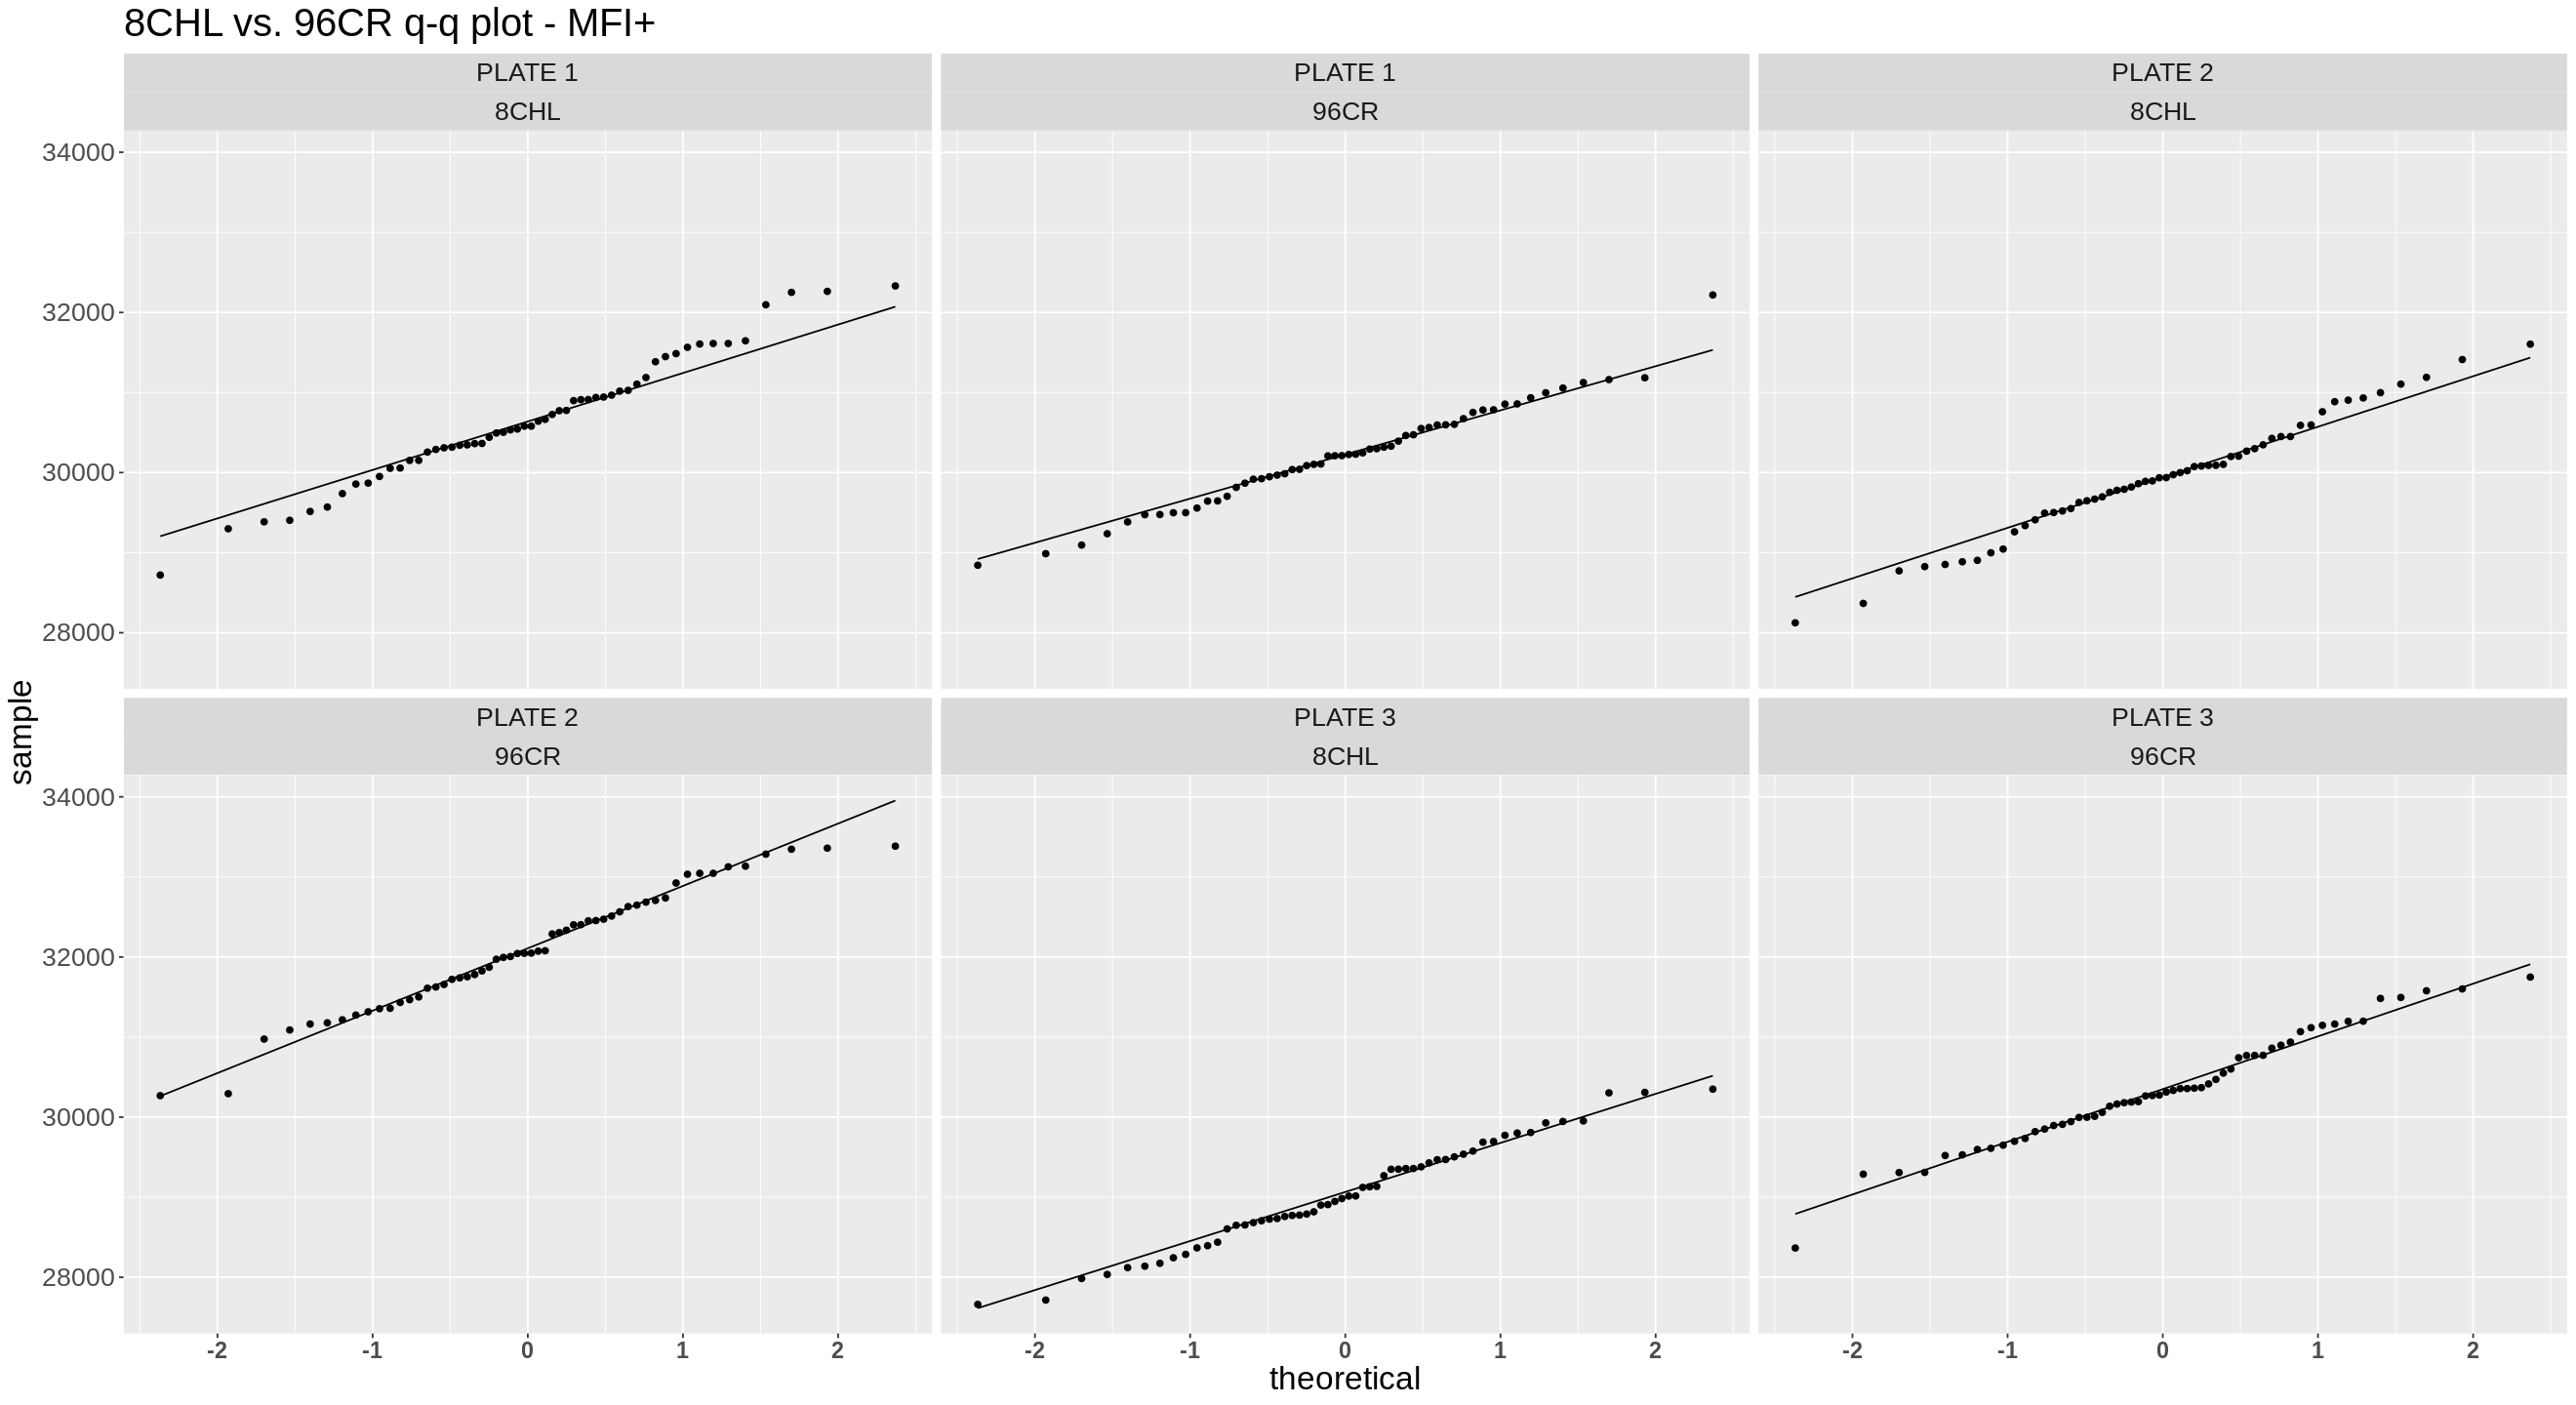

In [11]:
# MFI
ggplot(dfm, aes(sample = MFI., group = plate)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(plate~ method) +
                ggtitle("8CHL vs. 96CR q-q plot - MFI+") +
                theme(text = element_text(size=20),
                    axis.text.x = element_text(face = "bold", 
                                       size = 14)) 

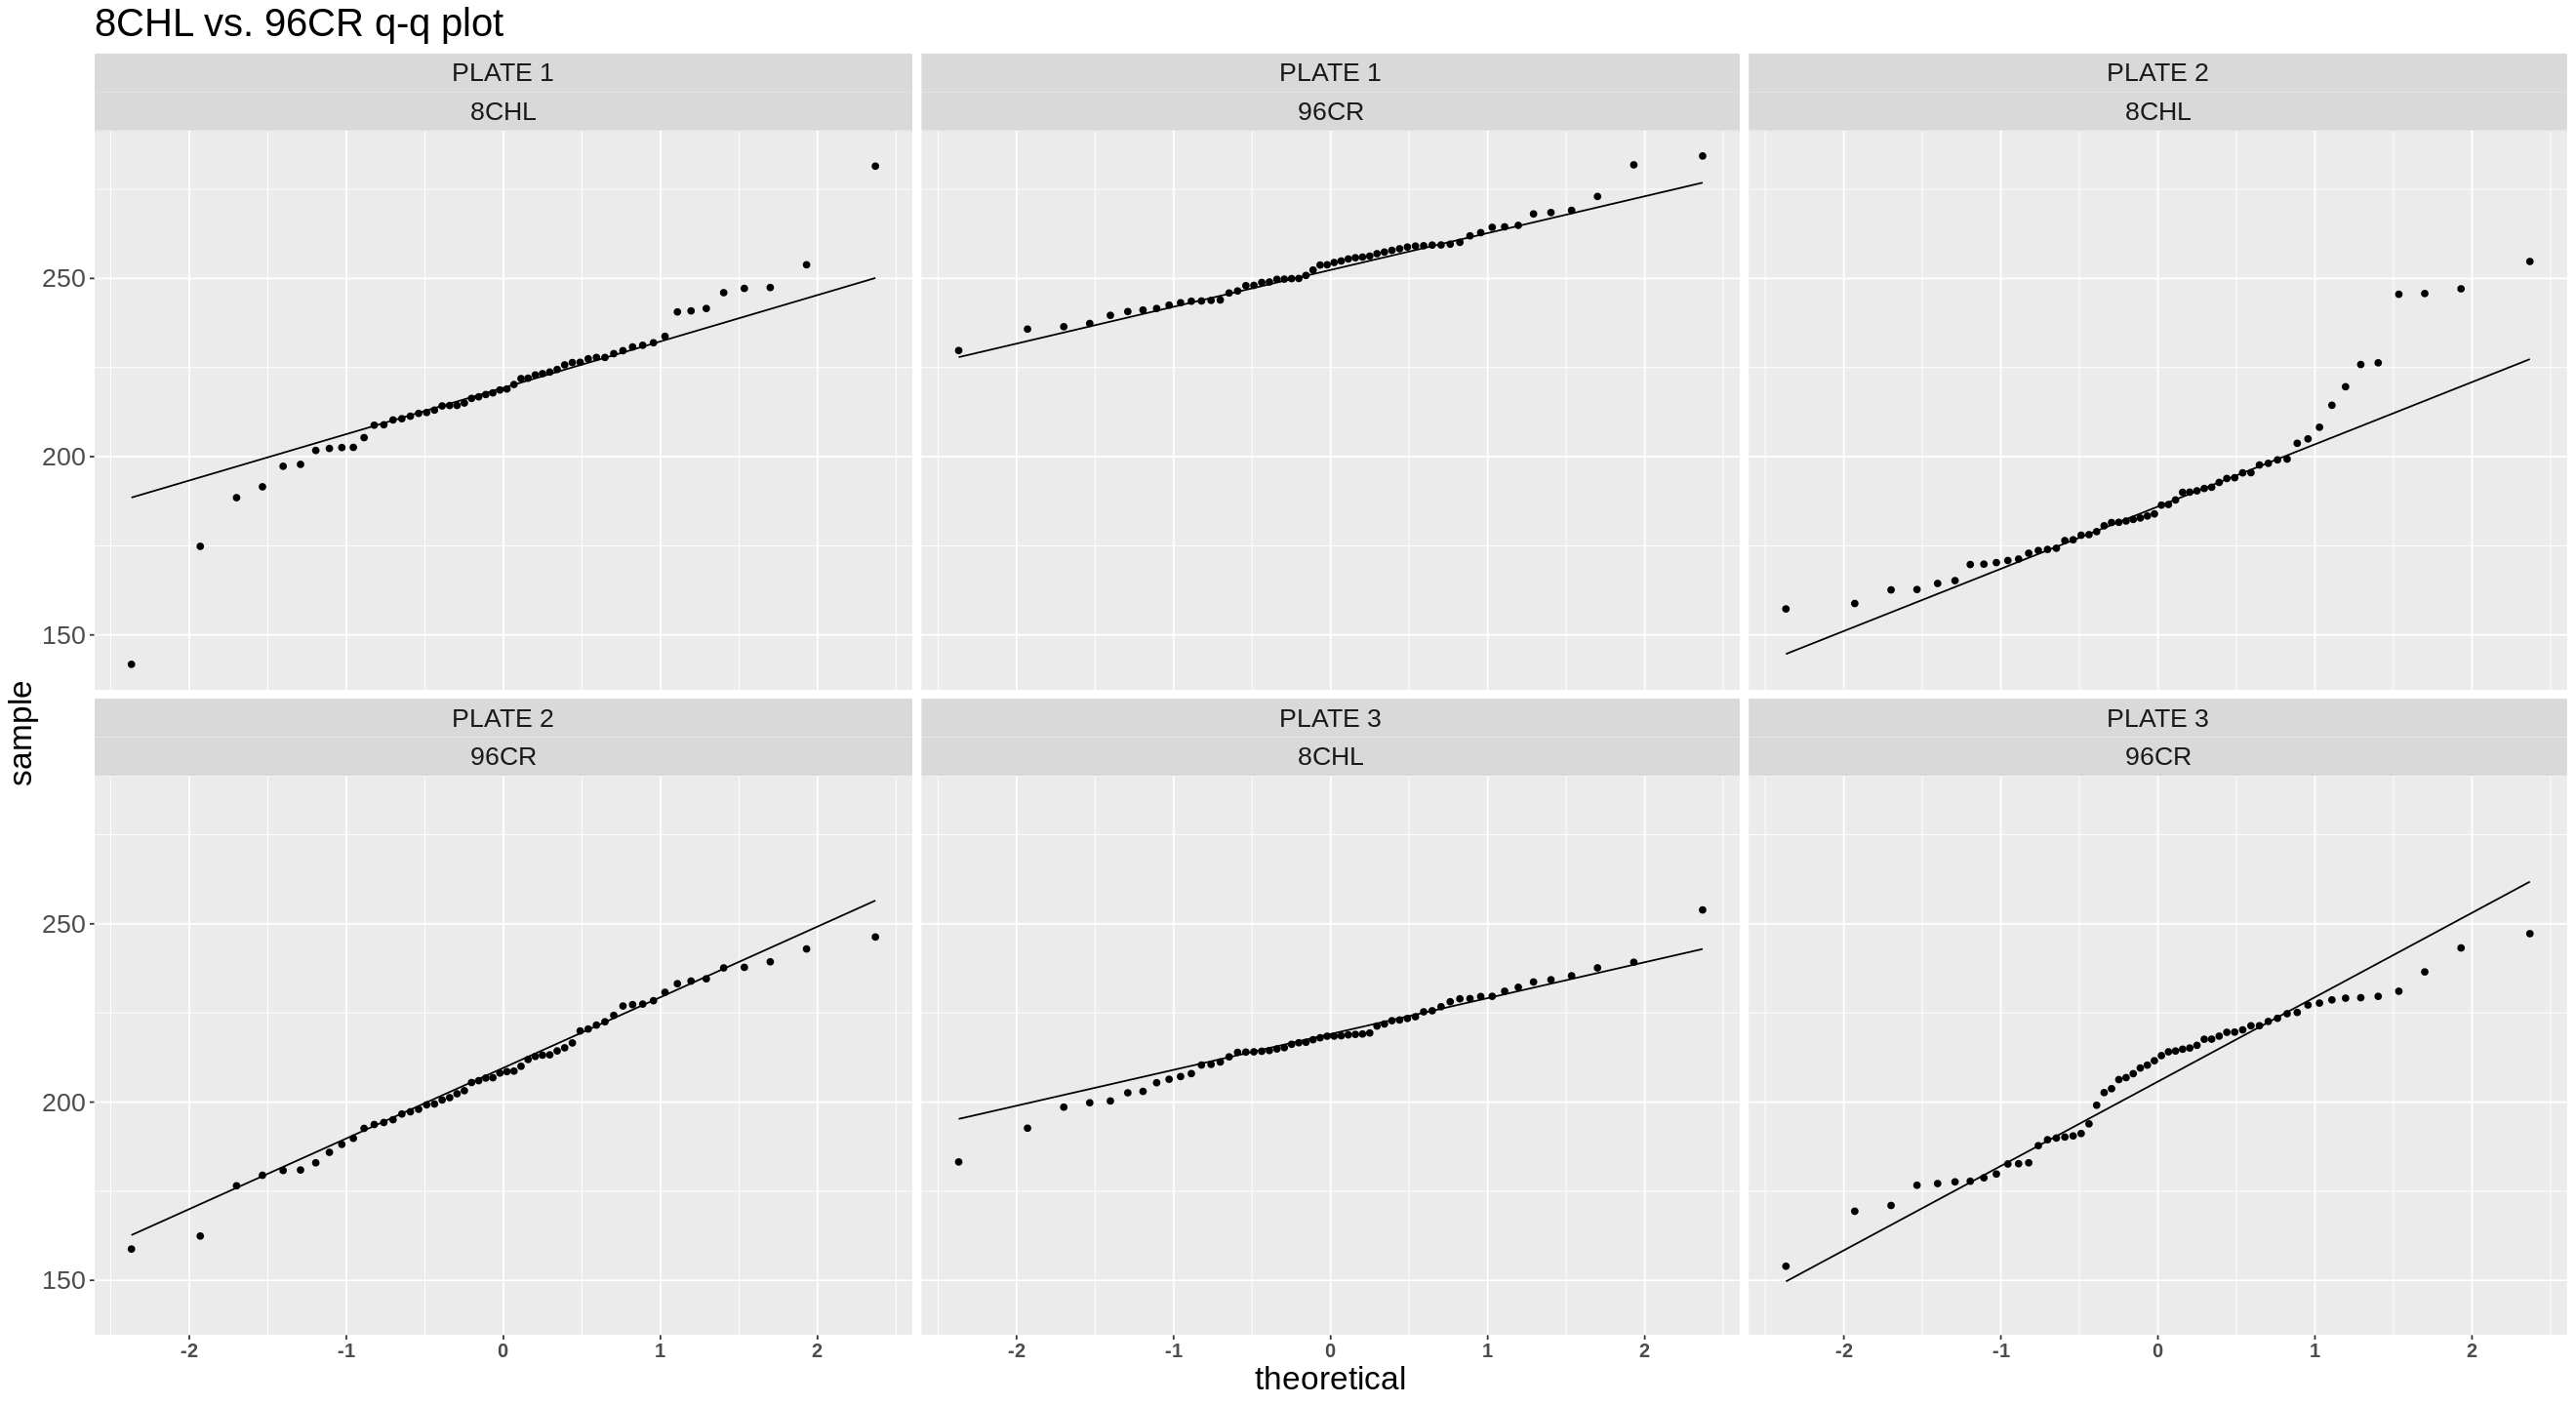

In [17]:
# SI
ggplot(dfm, aes(sample = SI, group = plate)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(plate~ method) +
                ggtitle("8CHL vs. 96CR q-q plot - SI") +
                theme(text = element_text(size=20),
                    axis.text.x = element_text(face = "bold", 
                                       size = 14)) 

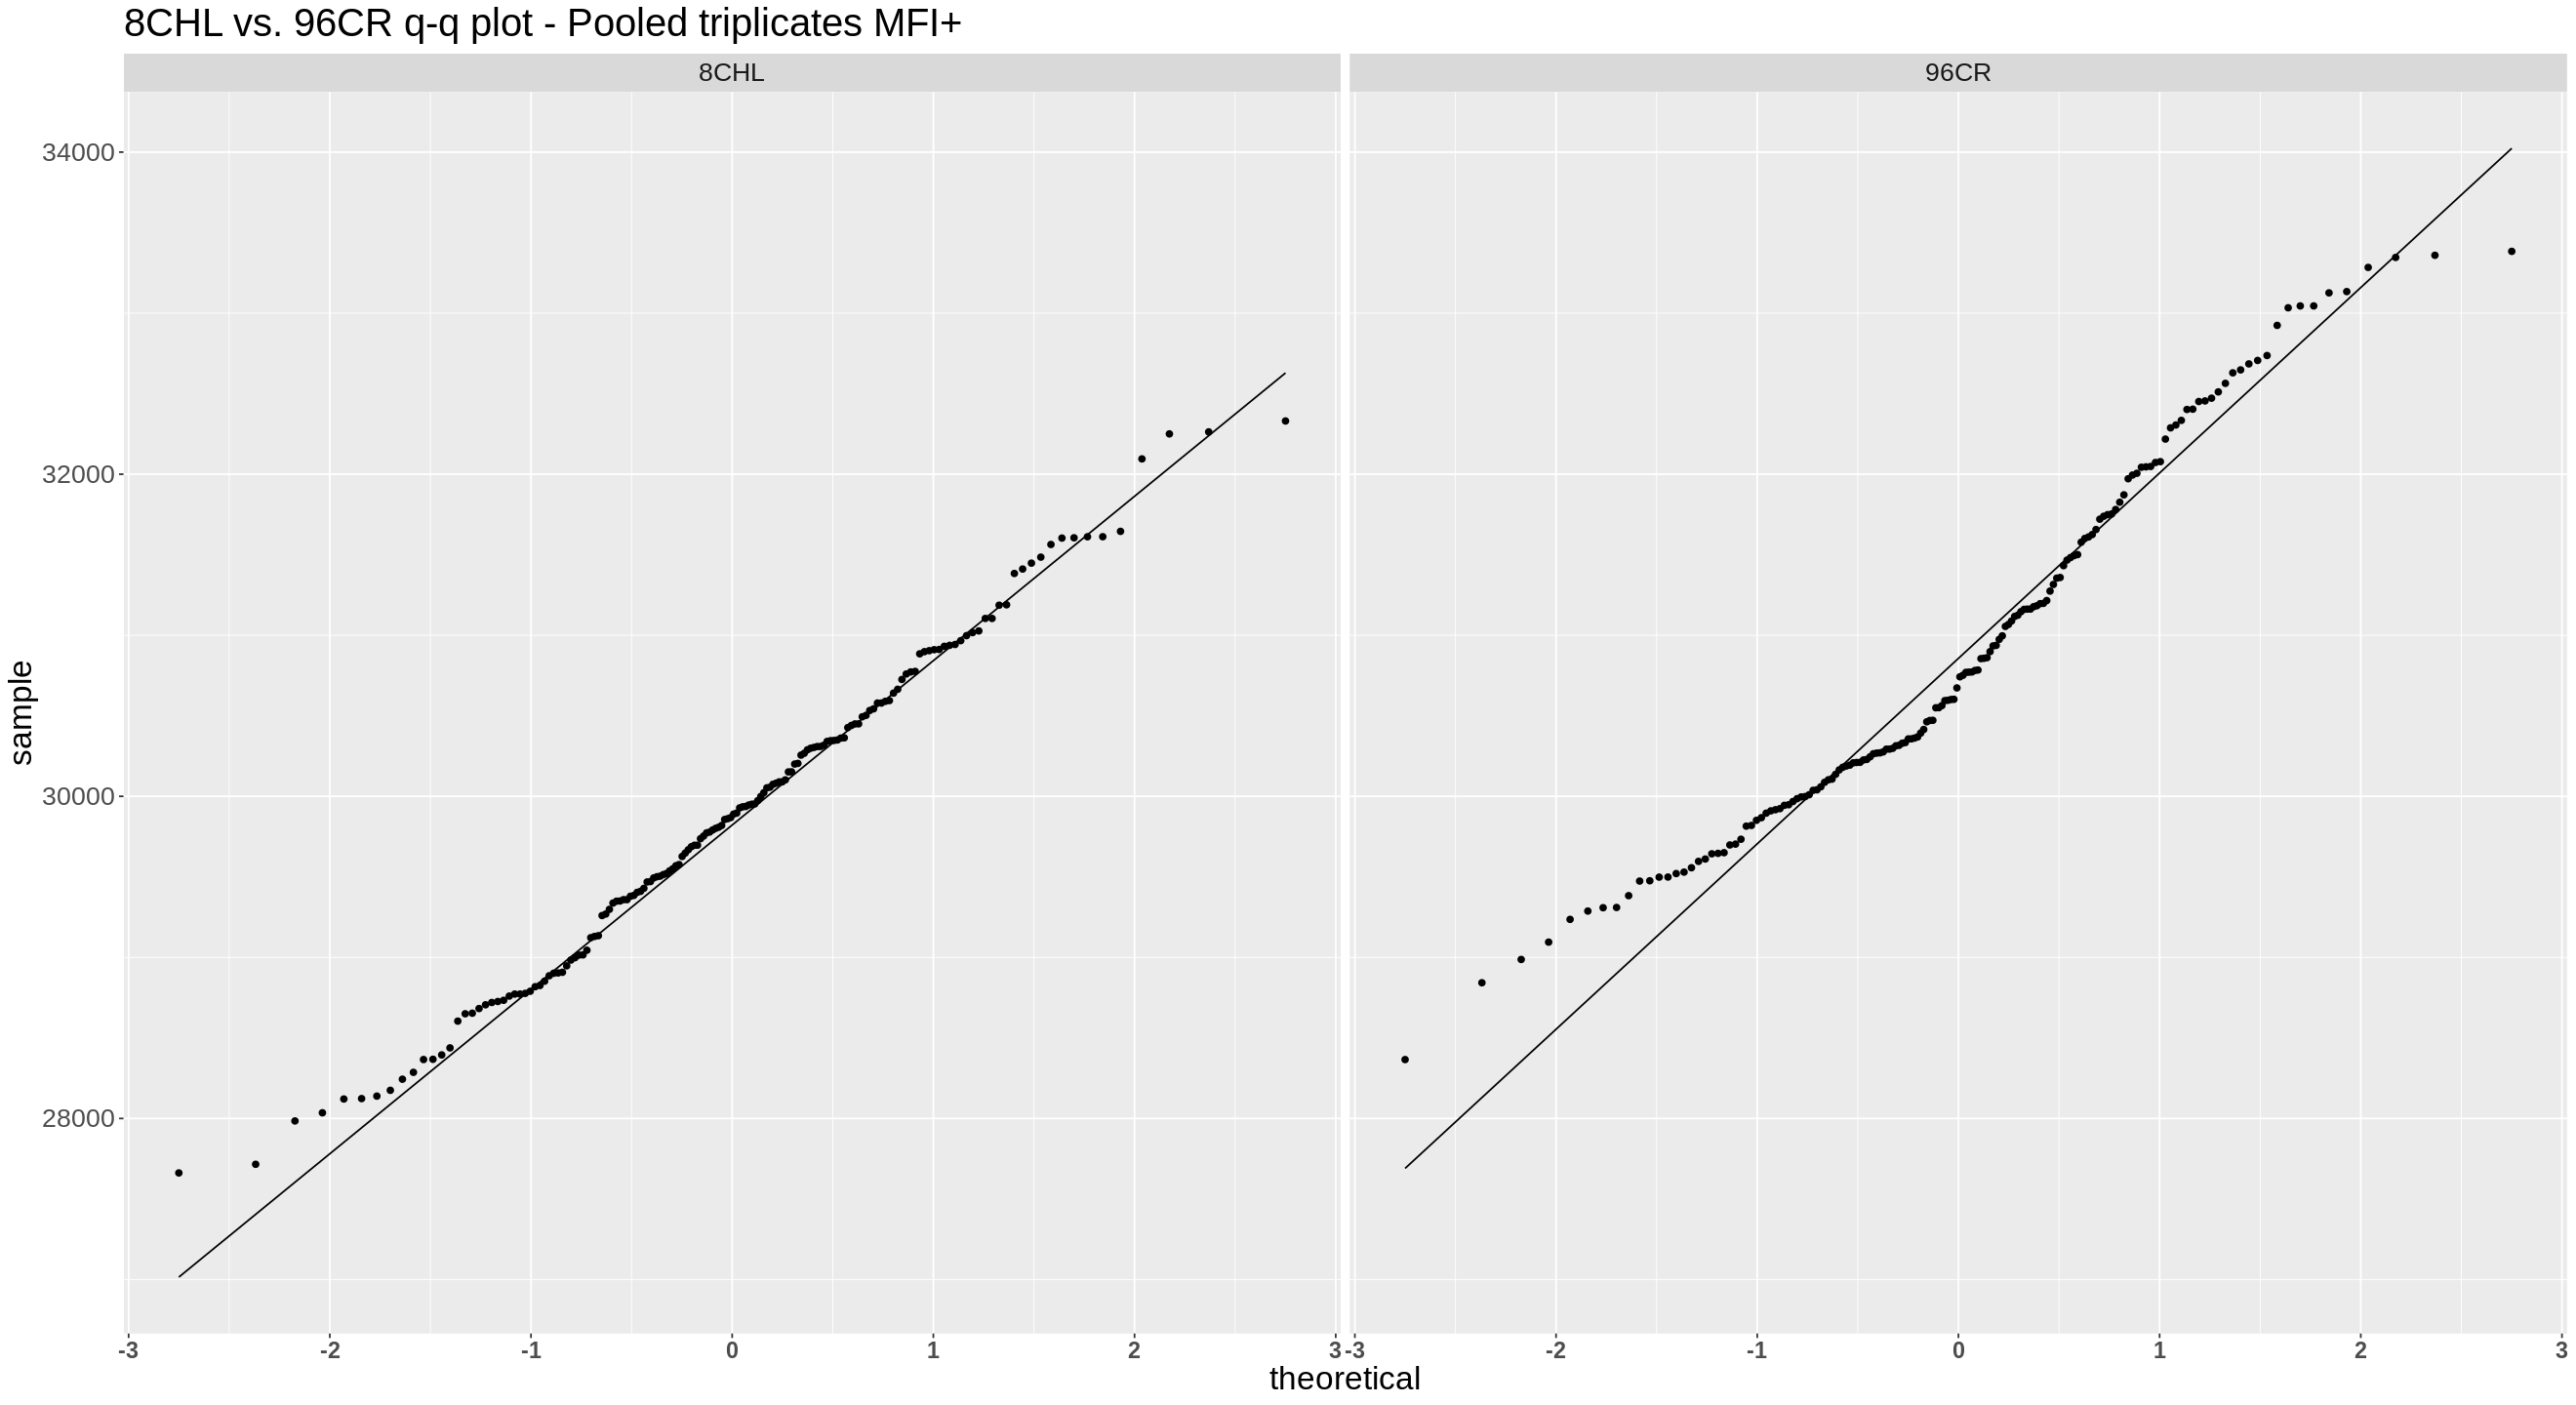

In [12]:
# pooled MFI+ triplicates
ggplot(dfm, aes(sample = MFI.)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(~ method) +
                ggtitle("8CHL vs. 96CR q-q plot - Pooled triplicates MFI+") +
                theme(text = element_text(size=20),
                    axis.text.x = element_text(face = "bold", 
                                       size = 14)) 

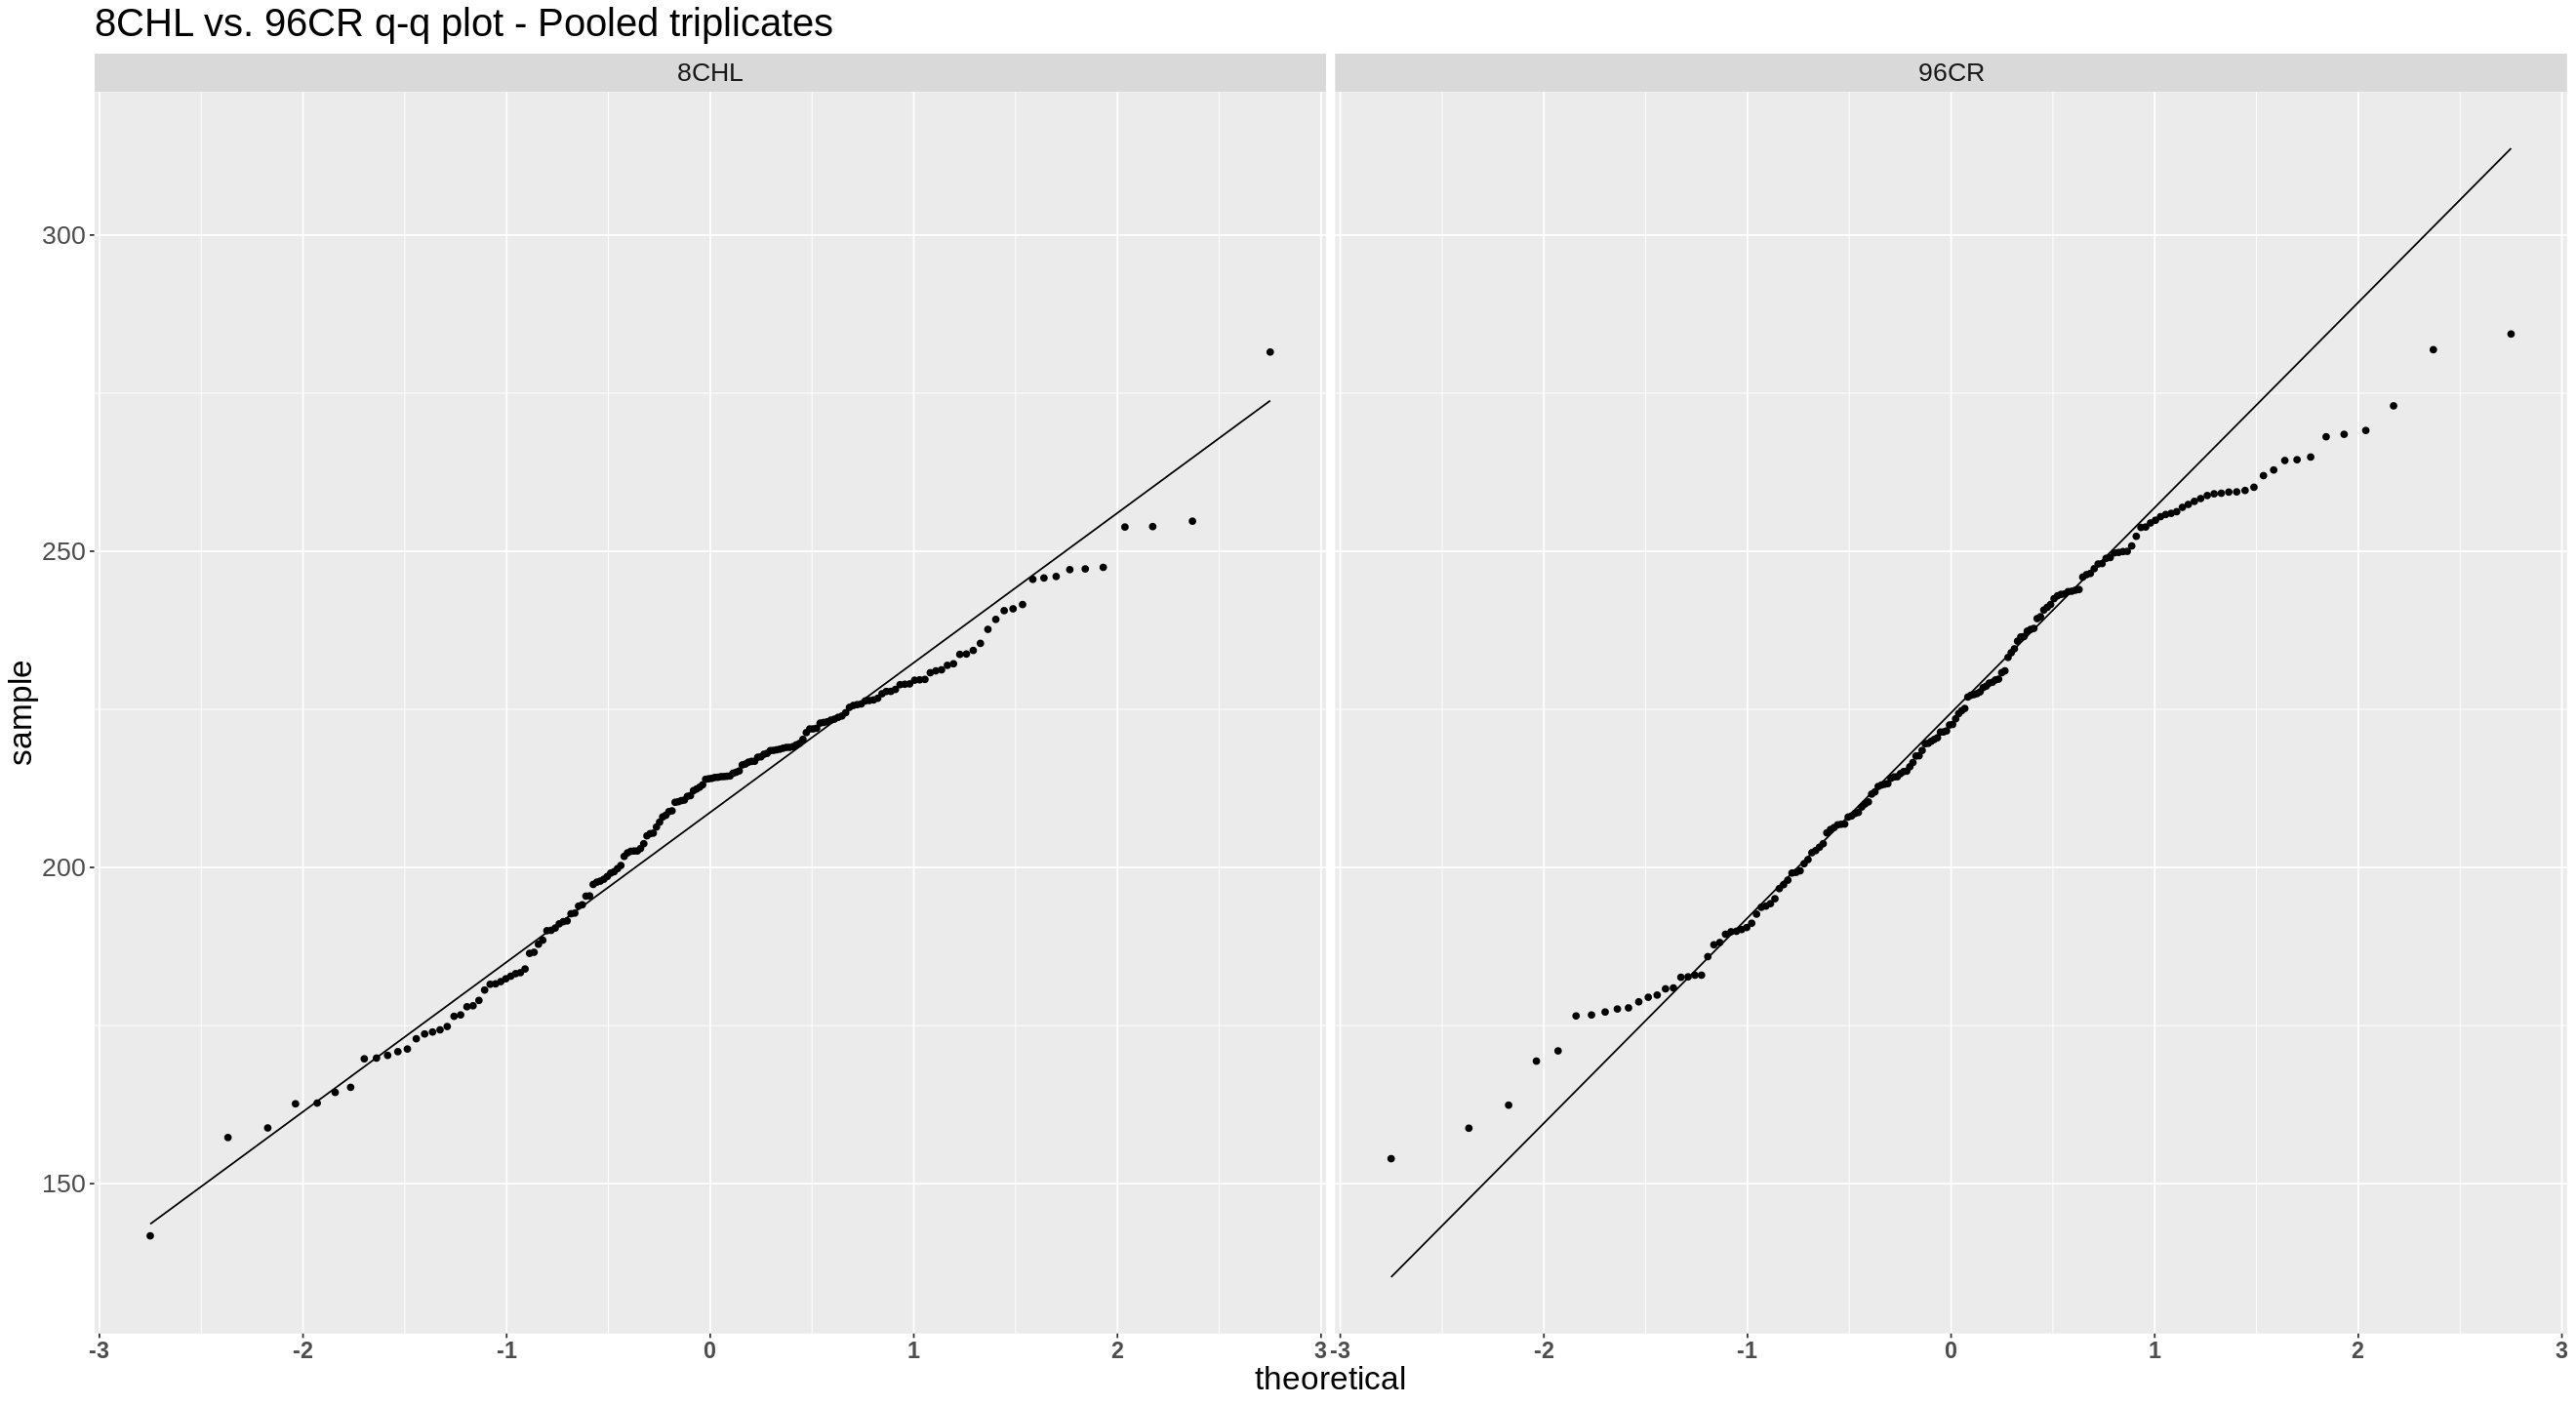

In [26]:
# SI pooled triplicates
ggplot(dfm, aes(sample = SI)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(~ method) +
                ggtitle("8CHL vs. 96CR q-q plot - Pooled triplicates - SI") +
                theme(text = element_text(size=20),
                    axis.text.x = element_text(face = "bold", 
                                       size = 14)) 

In [59]:
ls <- c("10.1", "10/89", "test")

In [60]:
out <- paste(ls, collapse=', ')
out

[1] "10.1, 10/89, test"

In [64]:
d = sapply(ls, function(x) {paste0("'", x, "'")}, USE.NAMES = F)
for (e in d) {
    print(e)
}

[1] "'10.1'"
[1] "'10/89'"
[1] "'test'"


In [19]:
head(dfm)

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method plate  
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93  240.8973 467.8717 8CHL   PLATE 1
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15  223.7325 444.5739 8CHL   PLATE 1
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10  201.7459 452.1773 8CHL   PLATE 1
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93  222.9273 448.8274 8CHL   PLATE 1
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59  188.4981 420.7647 8CHL   PLATE 1
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59  202.3096 421.2605 8CHL   PLATE 1
  wellid
1 A2    
2 A3    
3 A4    
4 A5    
5 A6    
6 A7

In [8]:
dfm2 <- dfm %>%
  group_by(method, plate) %>%
  summarise(Mean = mean(MFI.))
dfm2

`summarise()` regrouping output by 'method' (override with `.groups` argument)



method plate   Mean    
1 8CHL   PLATE 1 30656.22
2 8CHL   PLATE 2 29932.06
3 8CHL   PLATE 3 29035.73
4 96CR   PLATE 1 30214.59
5 96CR   PLATE 2 32089.34
6 96CR   PLATE 3 30347.25

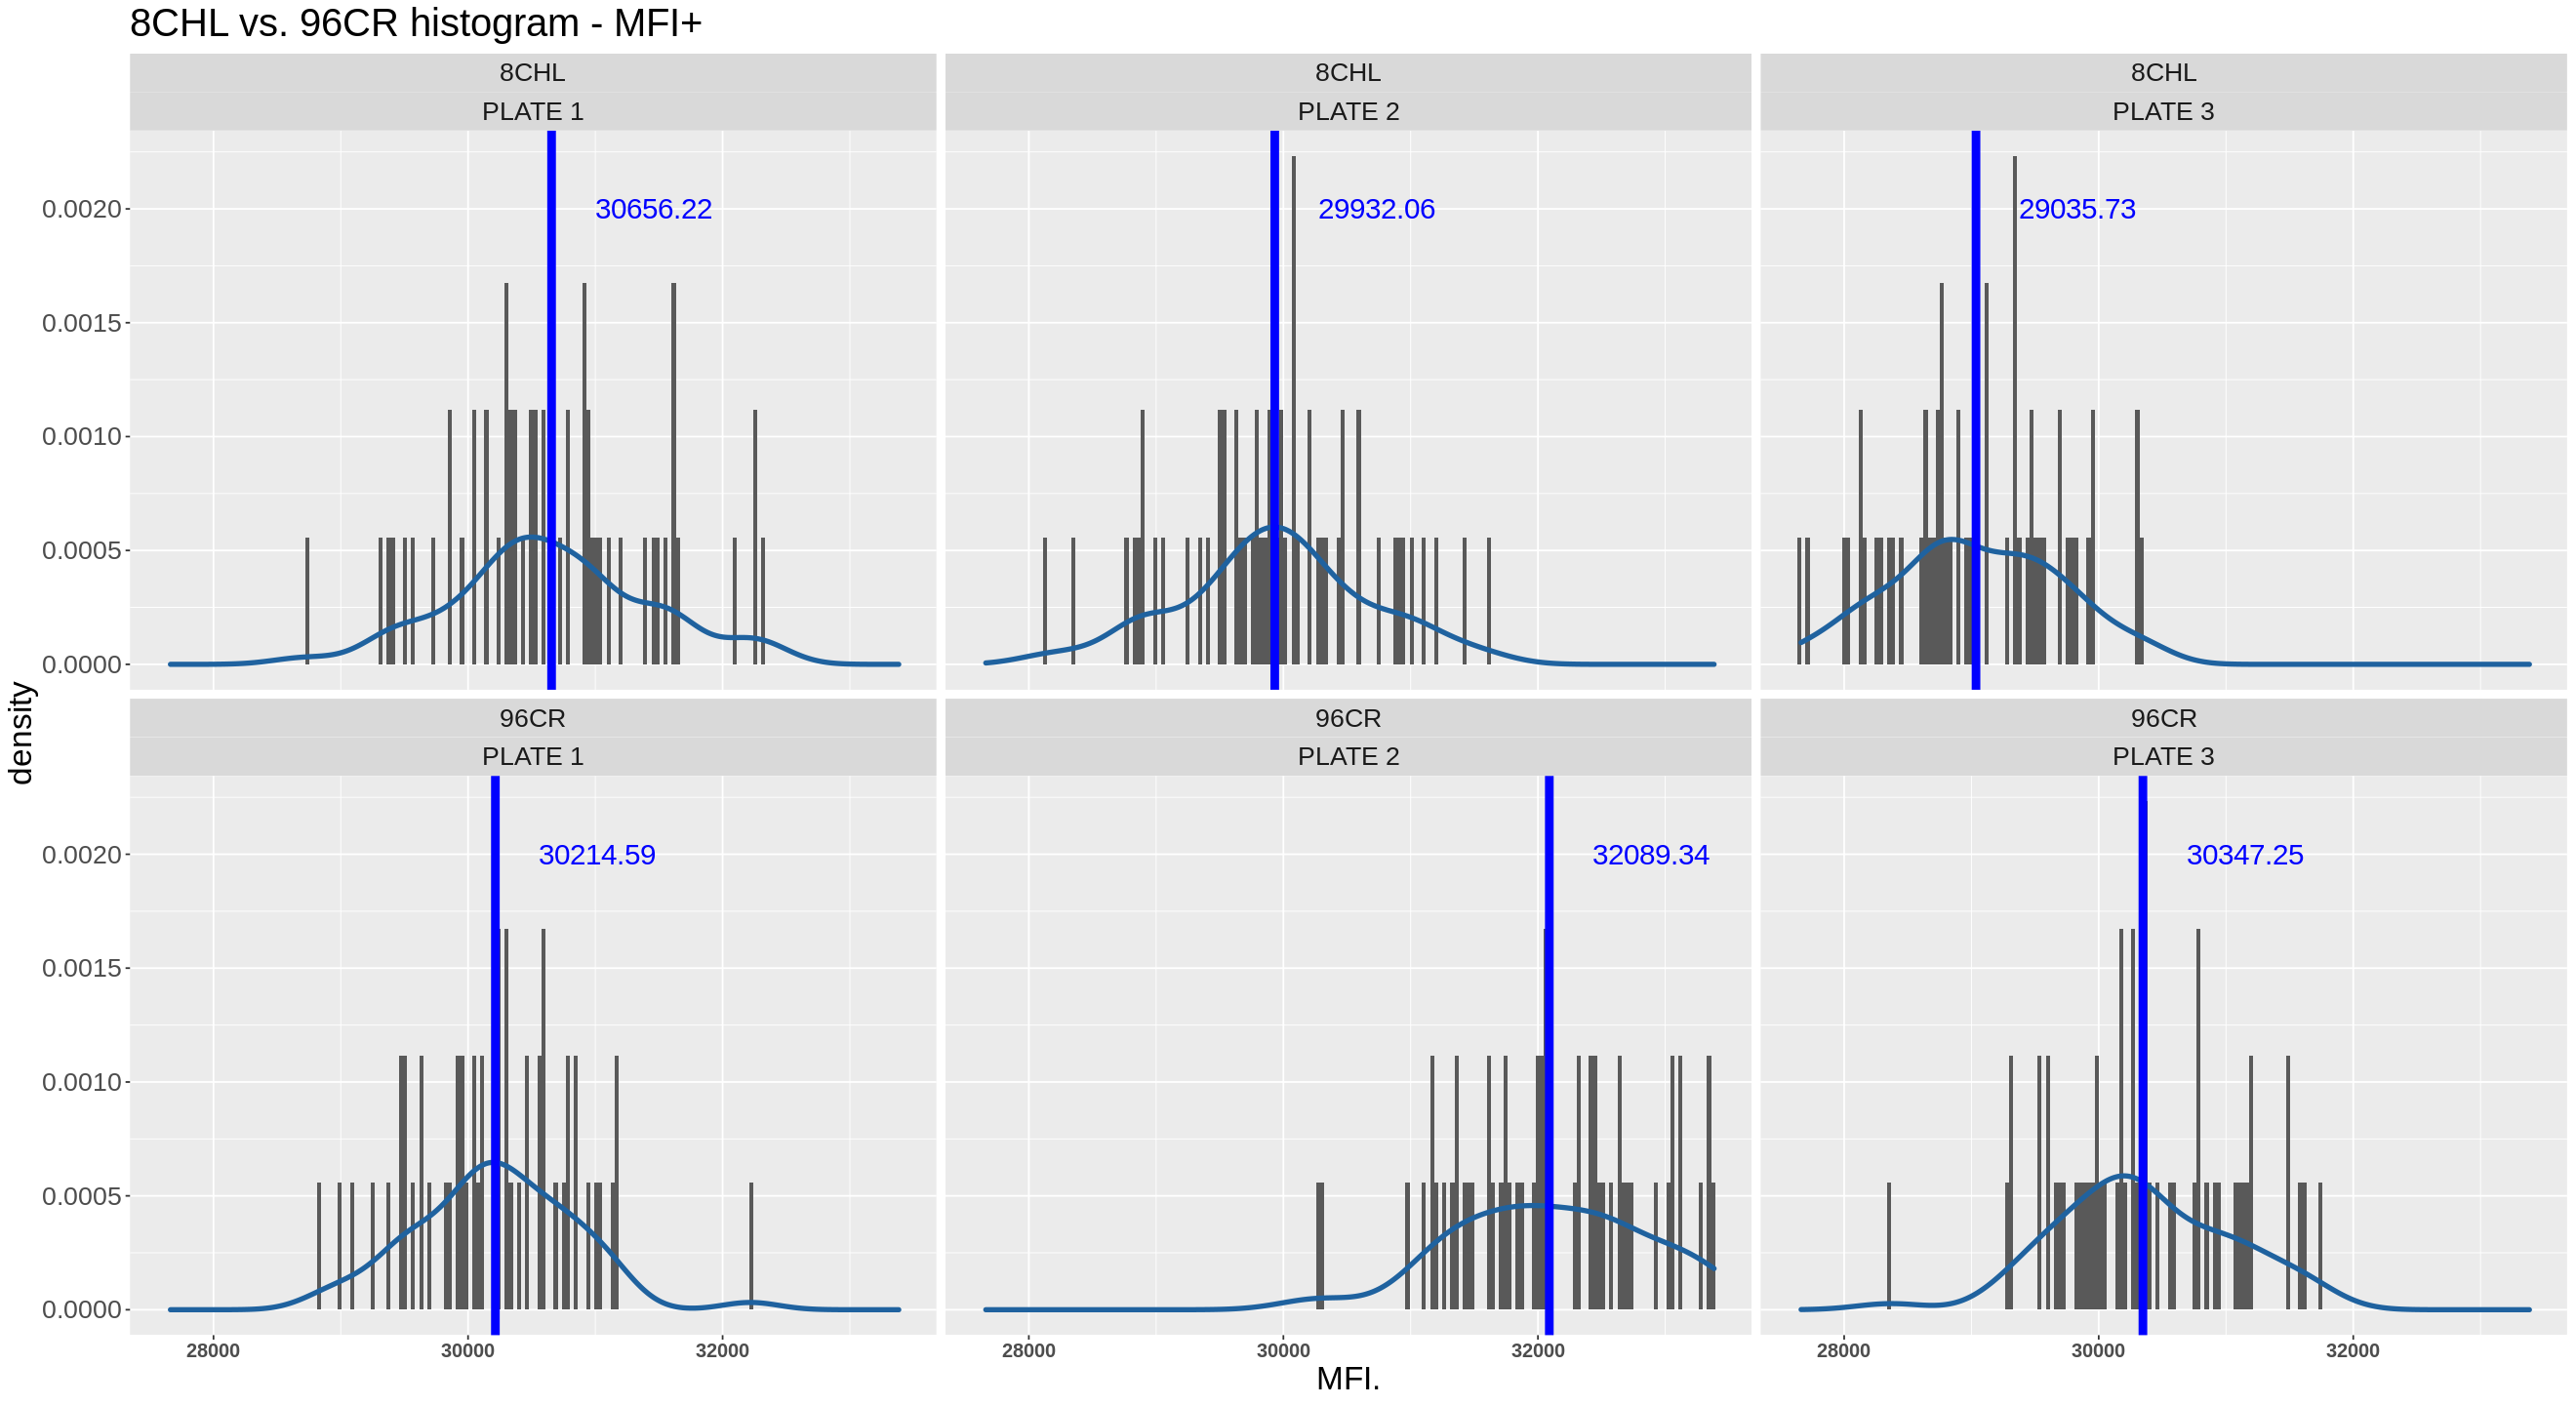

In [50]:
# MFI+
# per plate/day
ggplot(data = dfm, aes(group = plate, x = MFI.)) +
    geom_histogram(aes(y = ..density..), binwidth = 32, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    geom_vline(data=dfm2, mapping = aes(xintercept = Mean), color = "blue", size=2.5) + 
    geom_text(data = dfm2, aes(label=round(Mean,2), x=Mean+800, y=0.0020), color = "blue", size = 6.25) + 
    facet_wrap(method~plate) +
    ggtitle("8CHL vs. 96CR histogram - MFI+") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

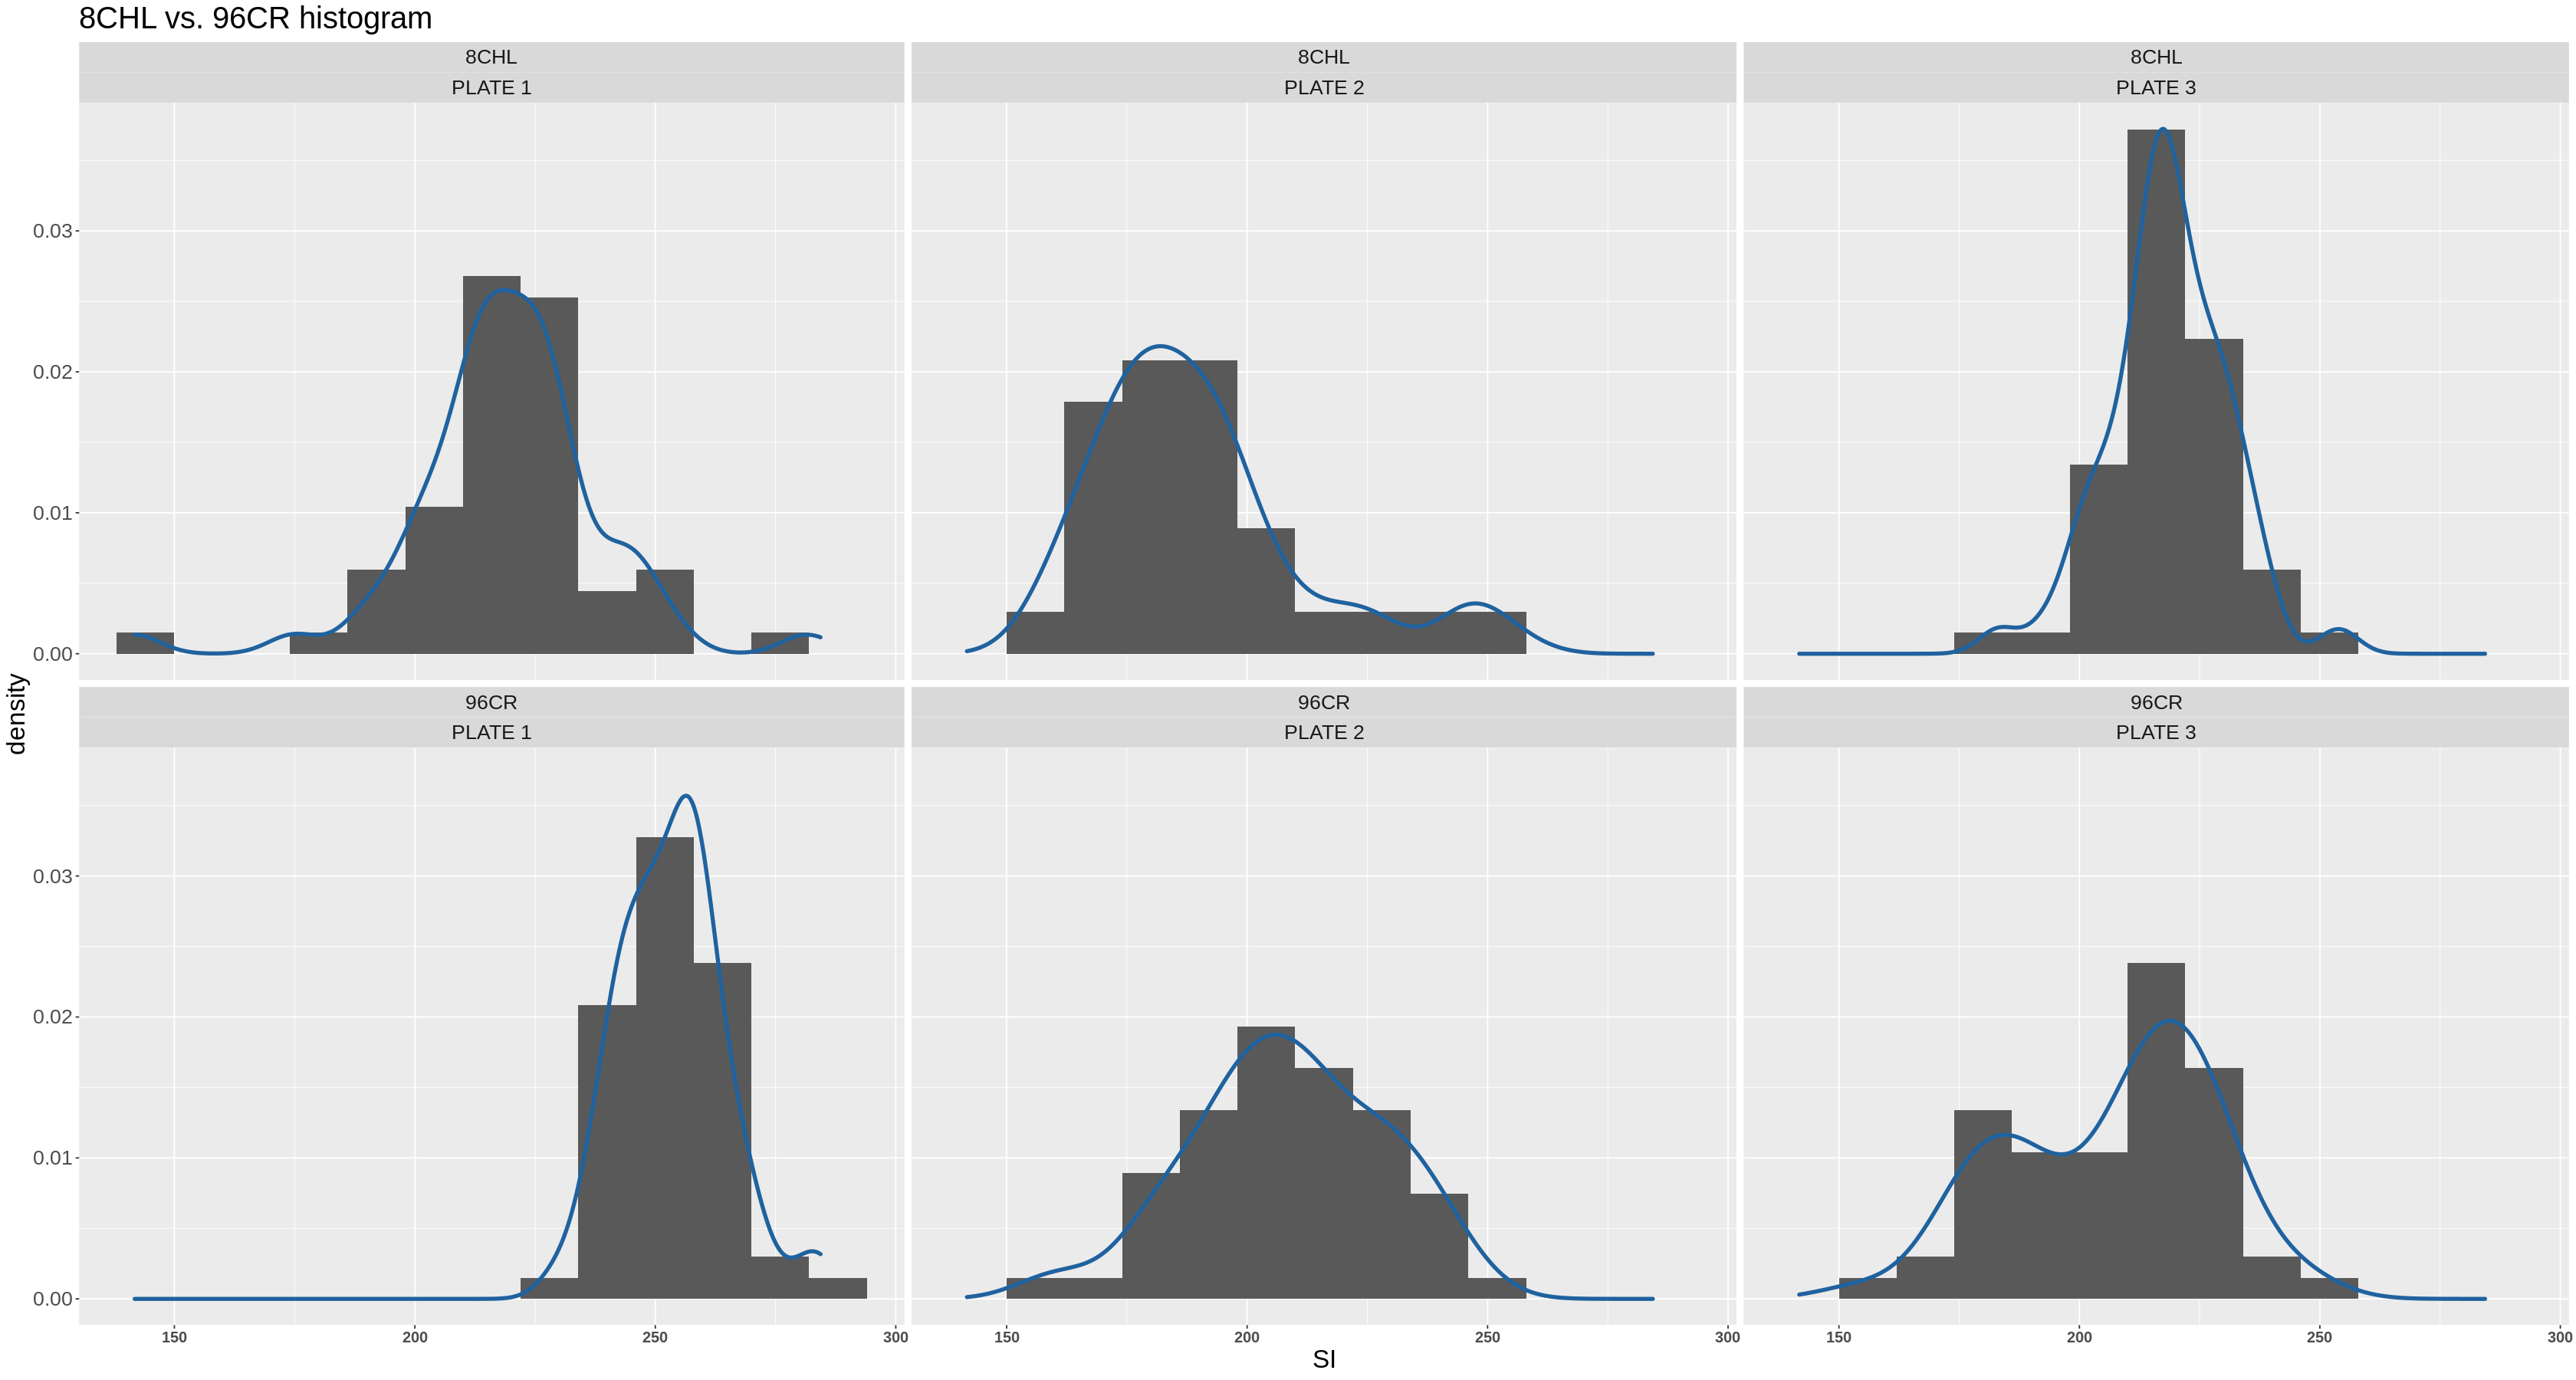

In [68]:
# per plate/day
ggplot(data = dfm, aes(group = plate, x = SI)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(method~plate) +
    ggtitle("8CHL vs. 96CR histogram - SI") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

In [91]:
dfm2 <- dfm %>%
  group_by(method) %>%
  summarise(Mean = mean(MFI.))
dfm2

`summarise()` ungrouping output (override with `.groups` argument)



method Mean    
1 8CHL   29874.67
2 96CR   30883.73

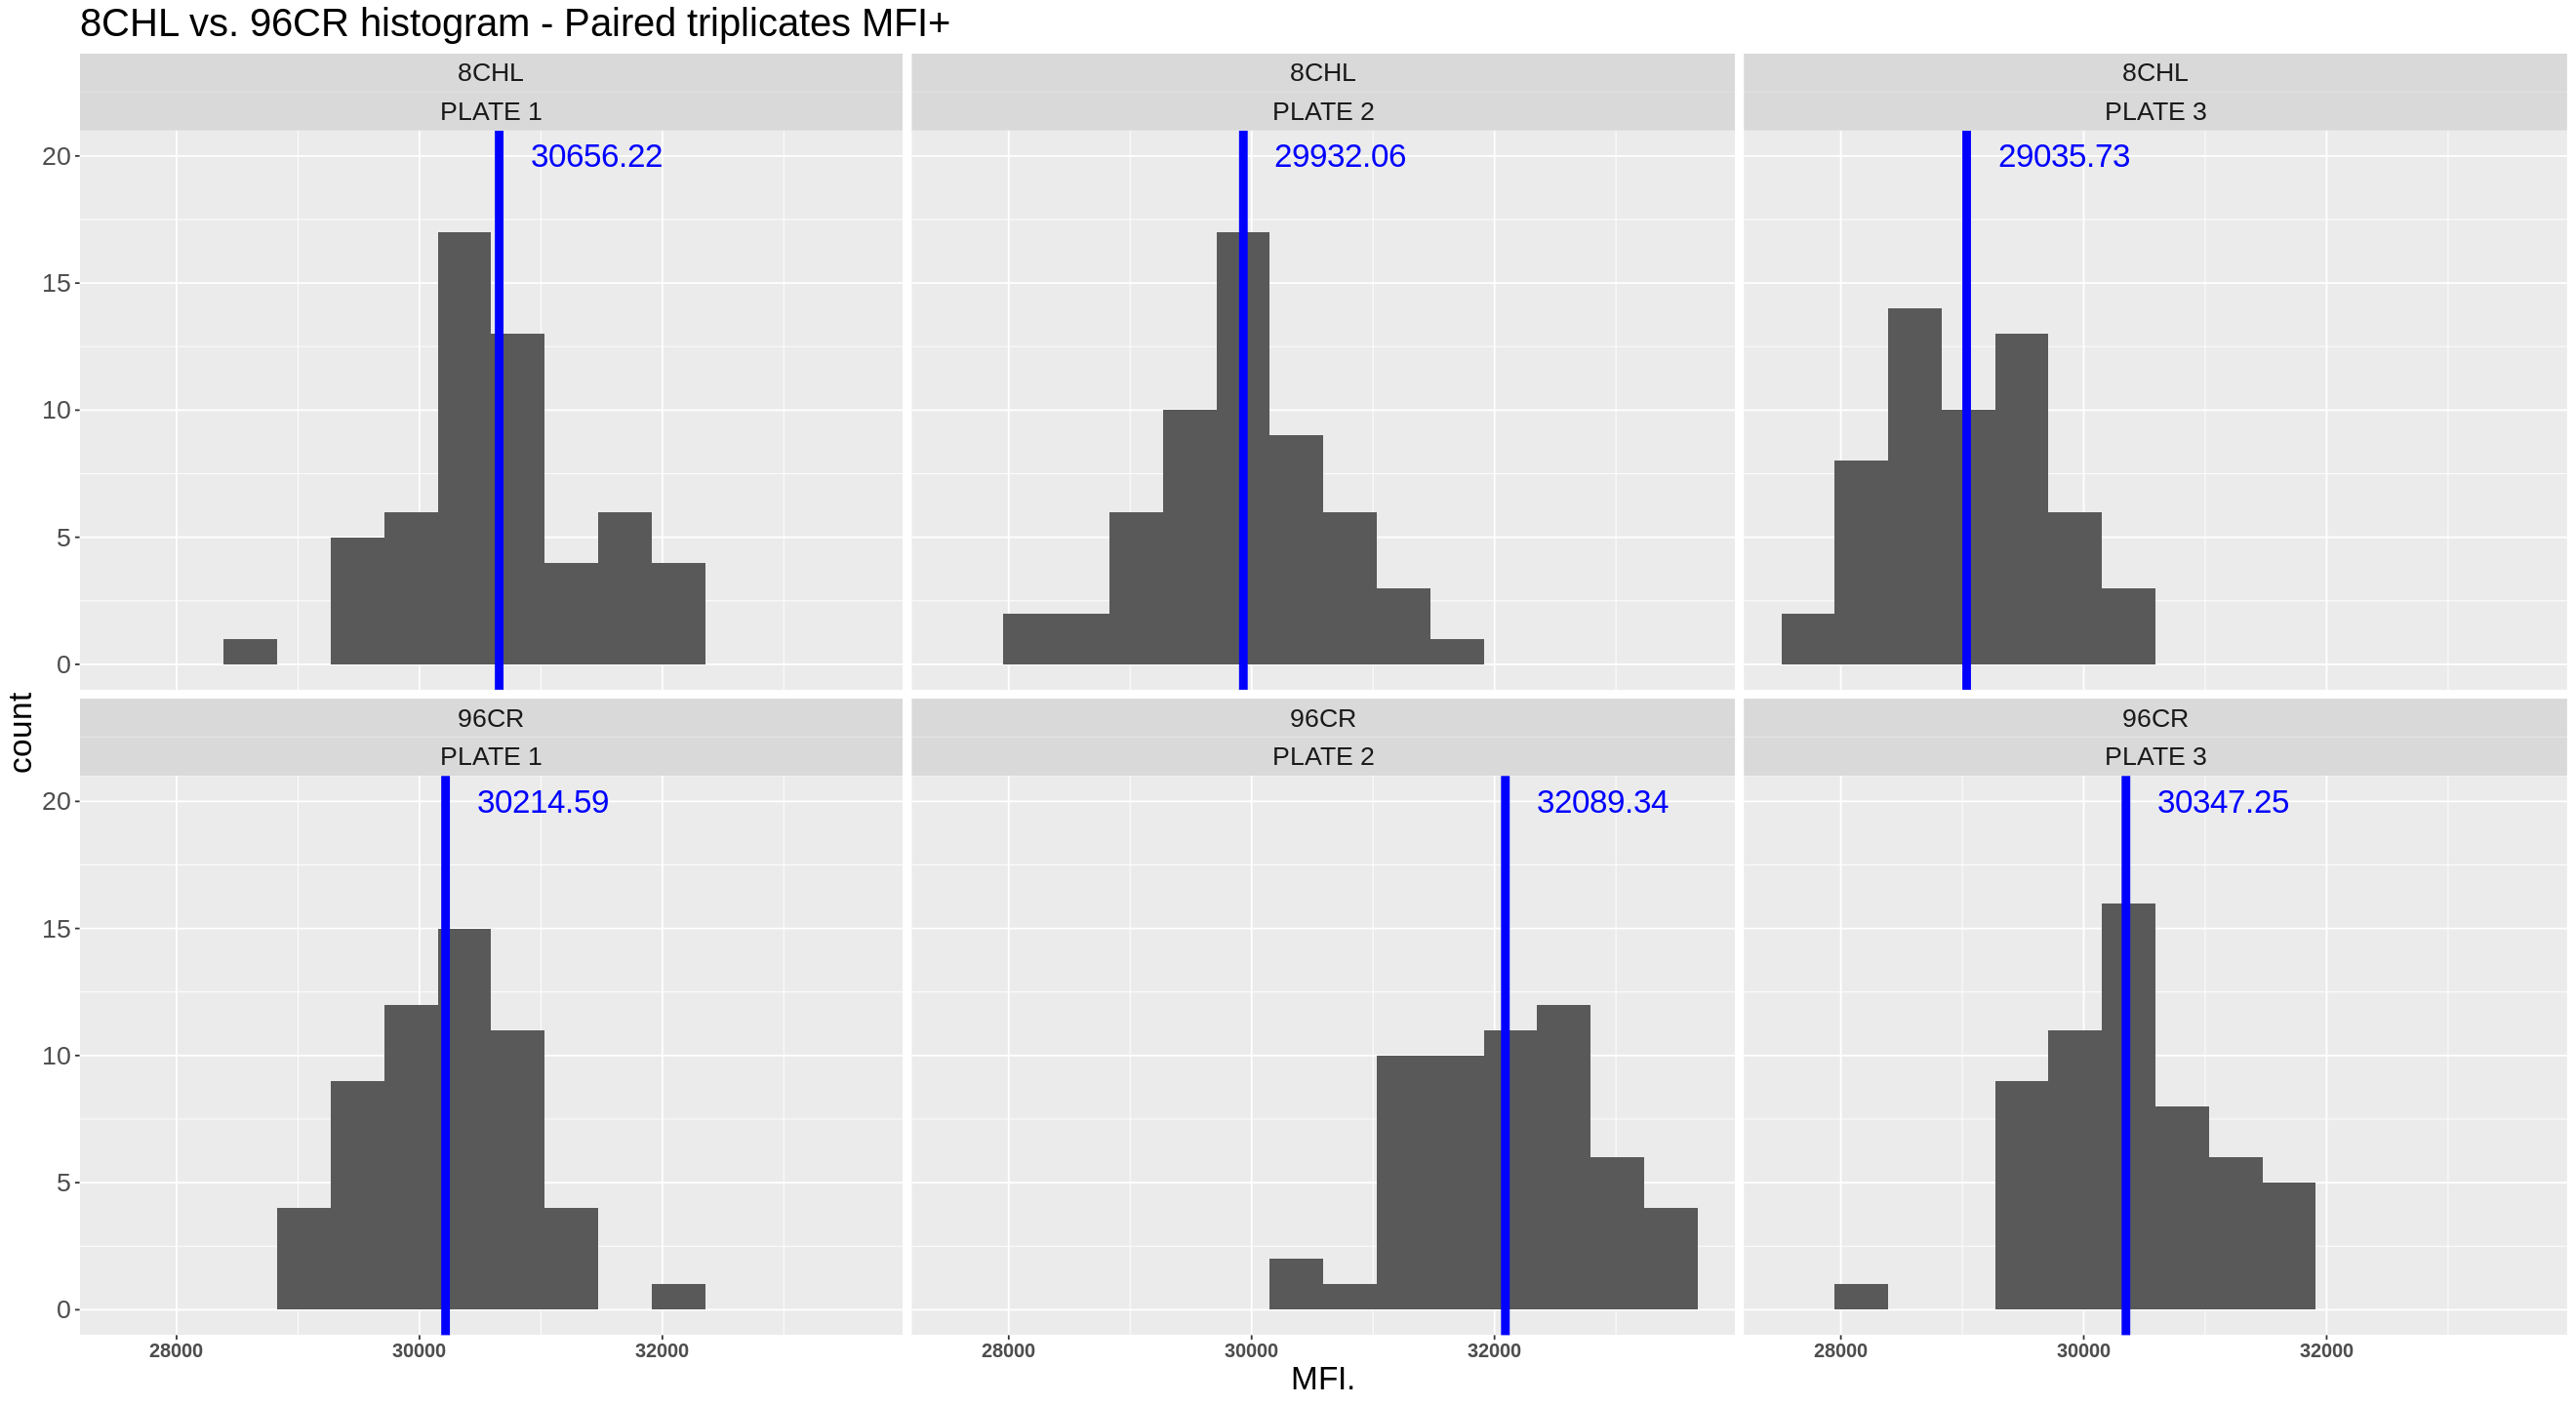

In [6]:
# MFI pooled triplicates using count not density
ggplot(data = dfm, aes(x = MFI.)) +
    geom_histogram(bins=14, position = "identity") + 
    geom_vline(data=dfm2, mapping = aes(xintercept = Mean), color = "blue", size=2.5) + 
    geom_text(data = dfm2, aes(label=round(Mean,2), x=Mean+800, y=20), color = "blue", size = 7) + 
    facet_wrap(method~plate) +
    ggtitle("8CHL vs. 96CR histogram - Paired triplicates MFI+") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

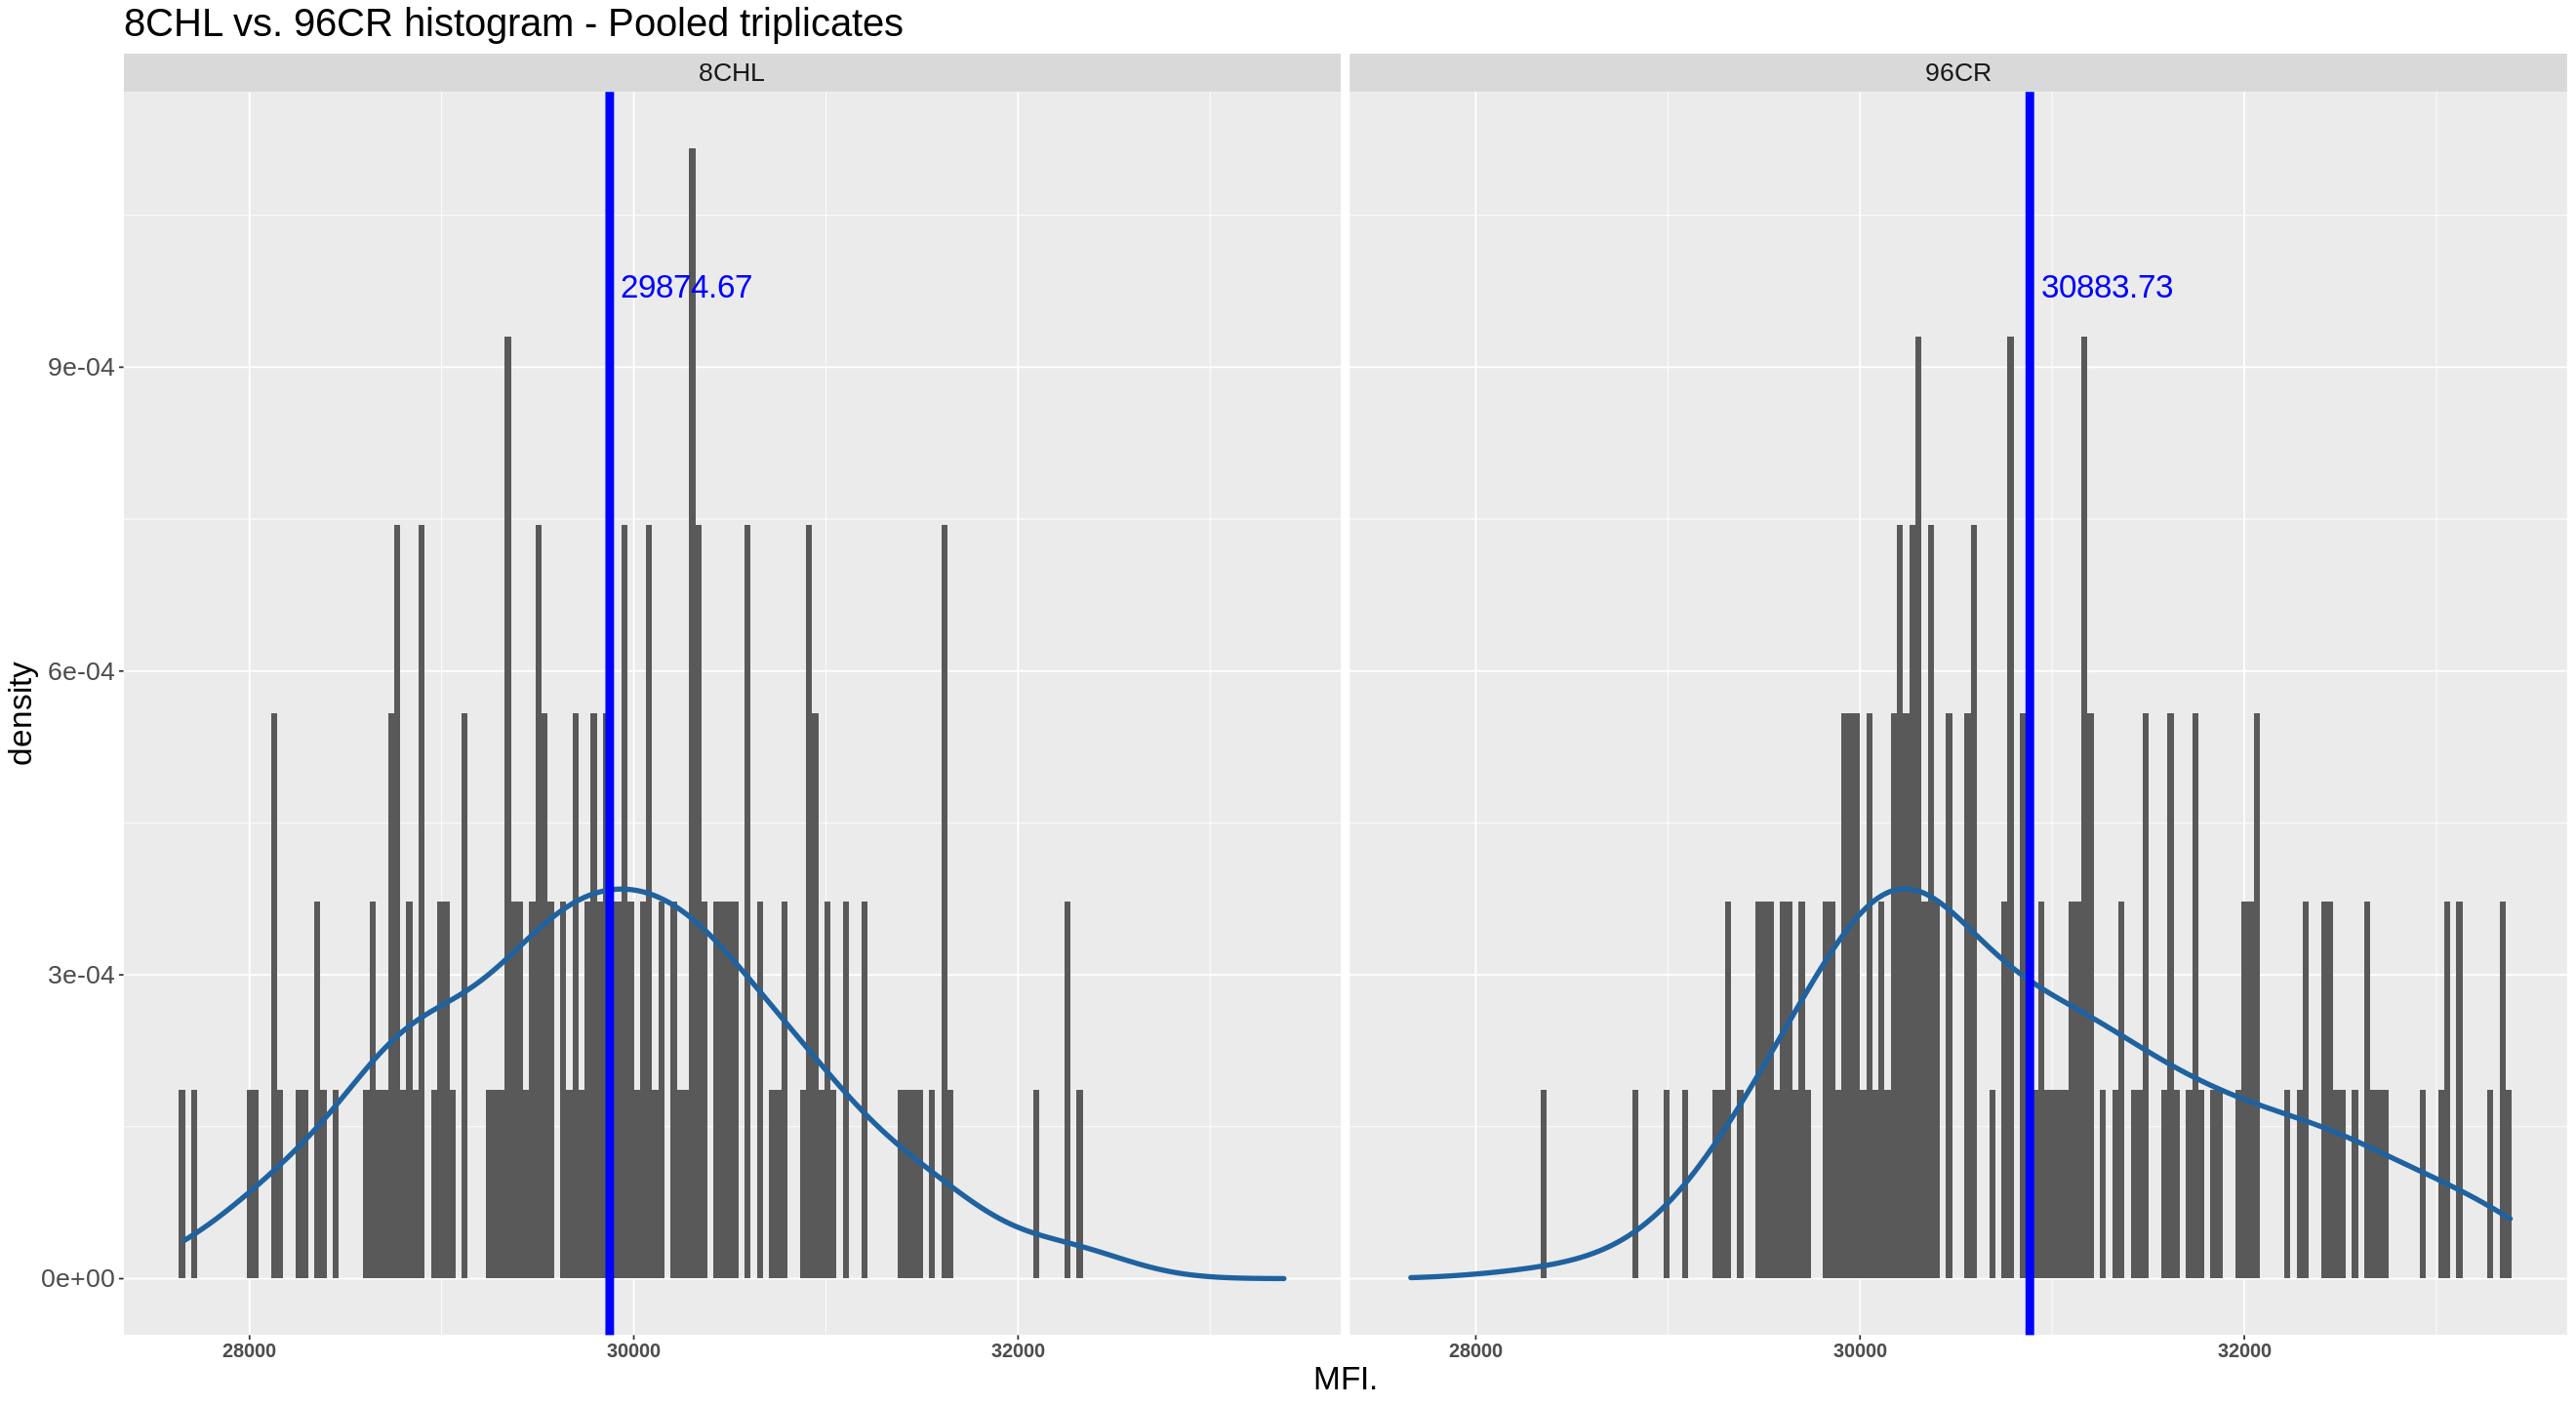

In [46]:
# MFI+
# pooled triplicates
ggplot(data = dfm, aes(x = MFI.)) +
    geom_histogram(aes(y = ..density..), binwidth = 32, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    geom_vline(data=dfm2, mapping = aes(xintercept = Mean), color = "blue", size=2.5) + 
    geom_text(data = dfm2, aes(label=round(Mean,2), x=Mean+400, y=9.8e-4), color = "blue", size = 7) + 
    facet_wrap(~ method) +
    ggtitle("8CHL vs. 96CR histogram - Pooled triplicates") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

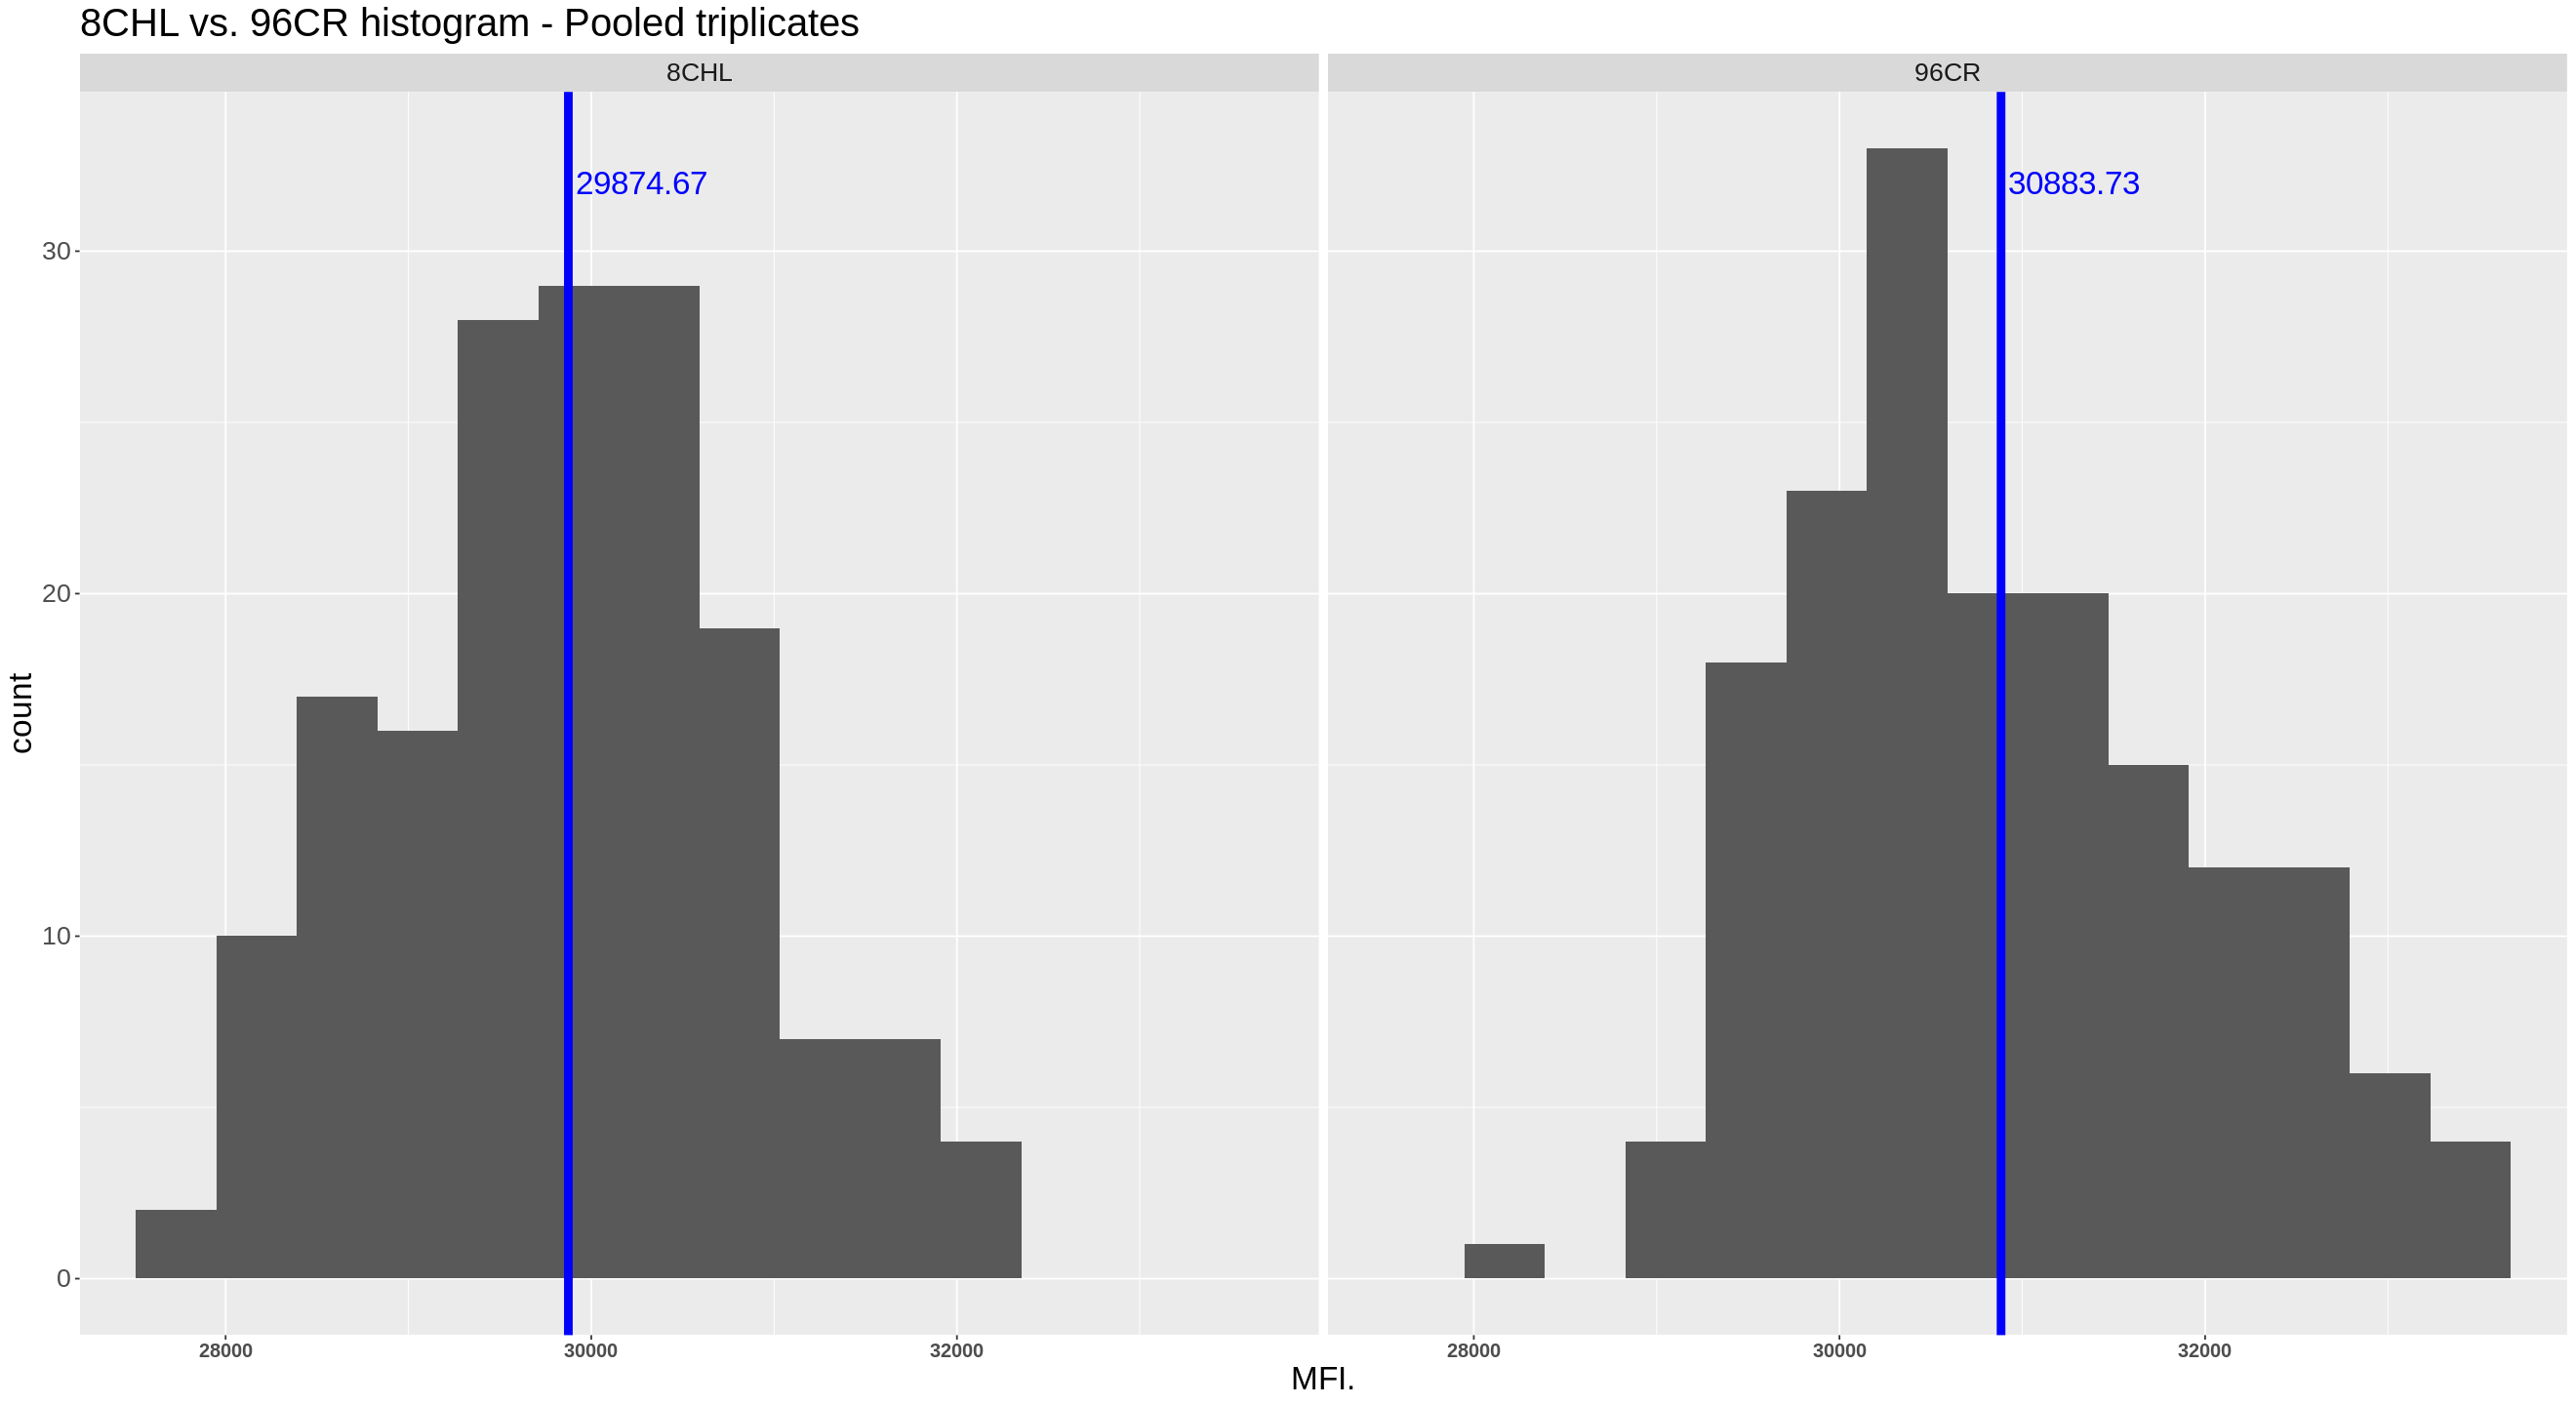

In [93]:
# MFI+
# pooled triplicates NO density
ggplot(data = dfm, aes(x = MFI.)) +
    geom_histogram(bins = 14, position = "identity") + 
    geom_vline(data=dfm2, mapping = aes(xintercept = Mean), color = "blue", size=2.5) + 
    geom_text(data = dfm2, aes(label=round(Mean,2), x=Mean+400, y=32), color = "blue", size = 7) + 
    facet_wrap(~ method) +
    ggtitle("8CHL vs. 96CR histogram - Pooled triplicates") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

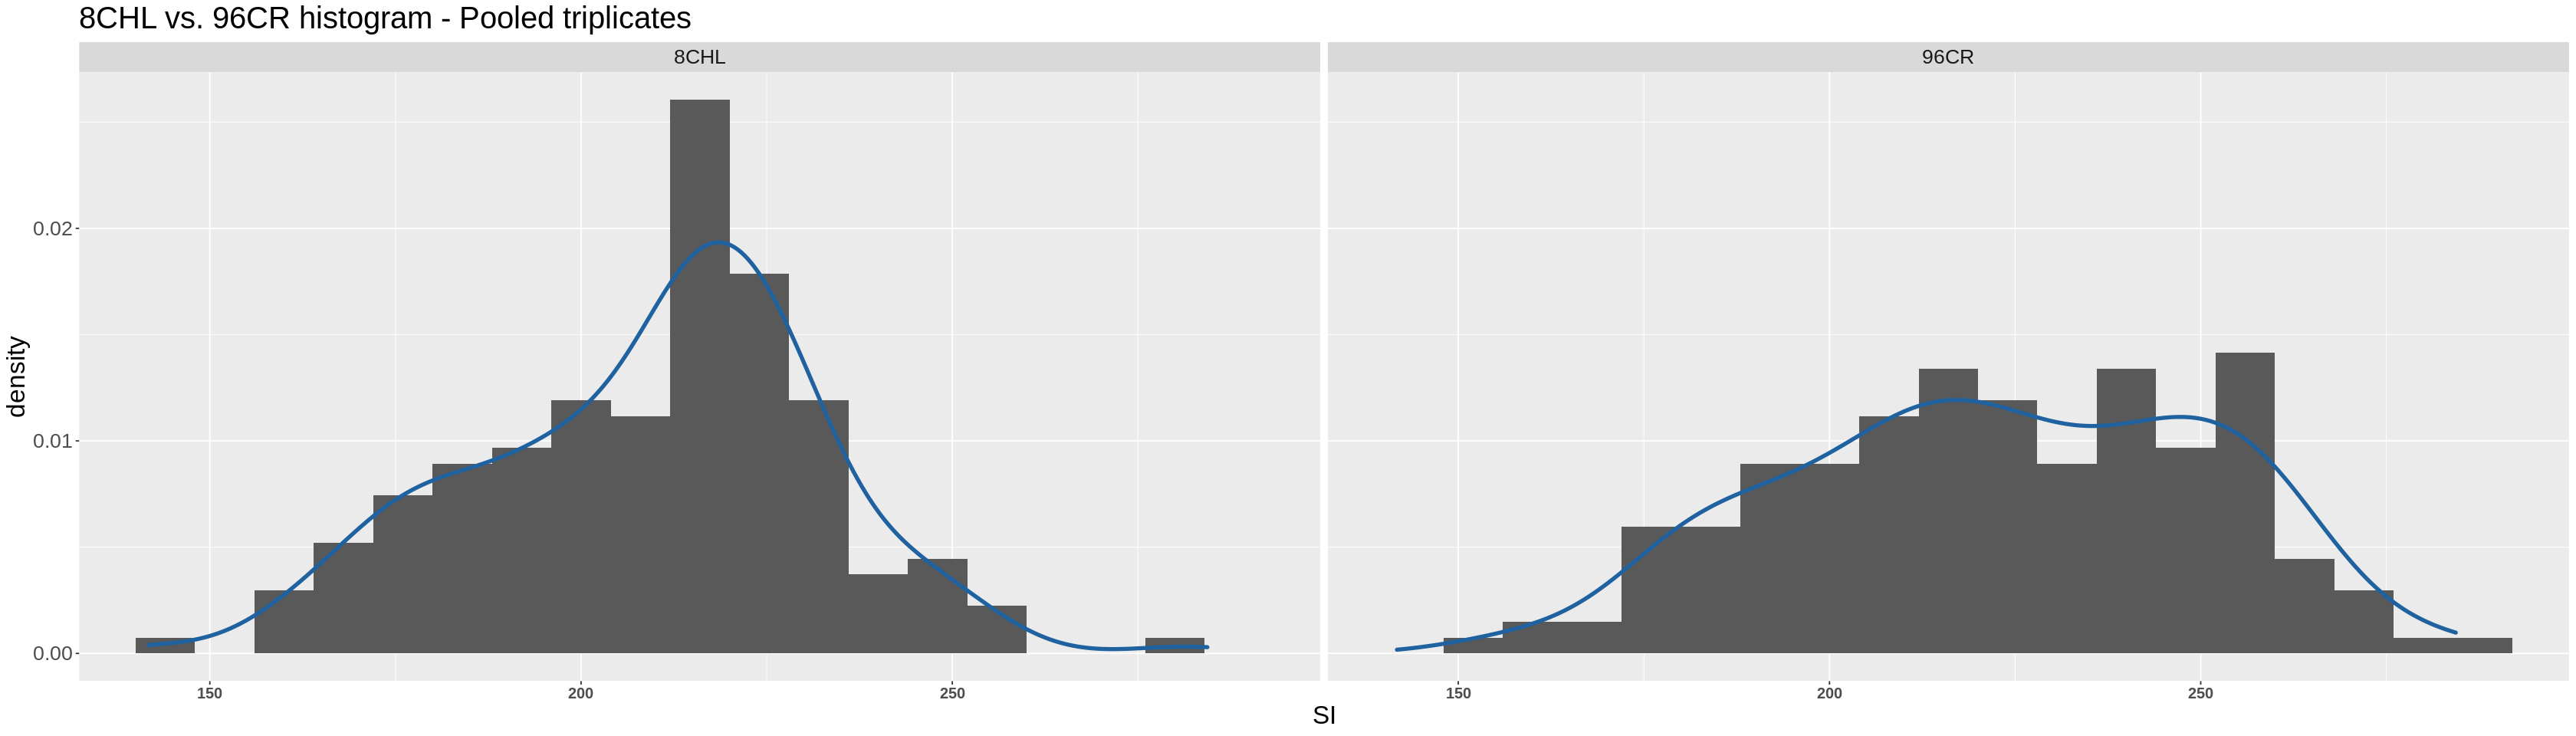

In [62]:
# SI
# pooled triplicates
ggplot(data = dfm, aes(x = SI)) +
    geom_histogram(aes(y = ..density..), binwidth = 8, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(~ method) +
    ggtitle("8CHL vs. 96CR histogram - Pooled triplicates (SI)") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

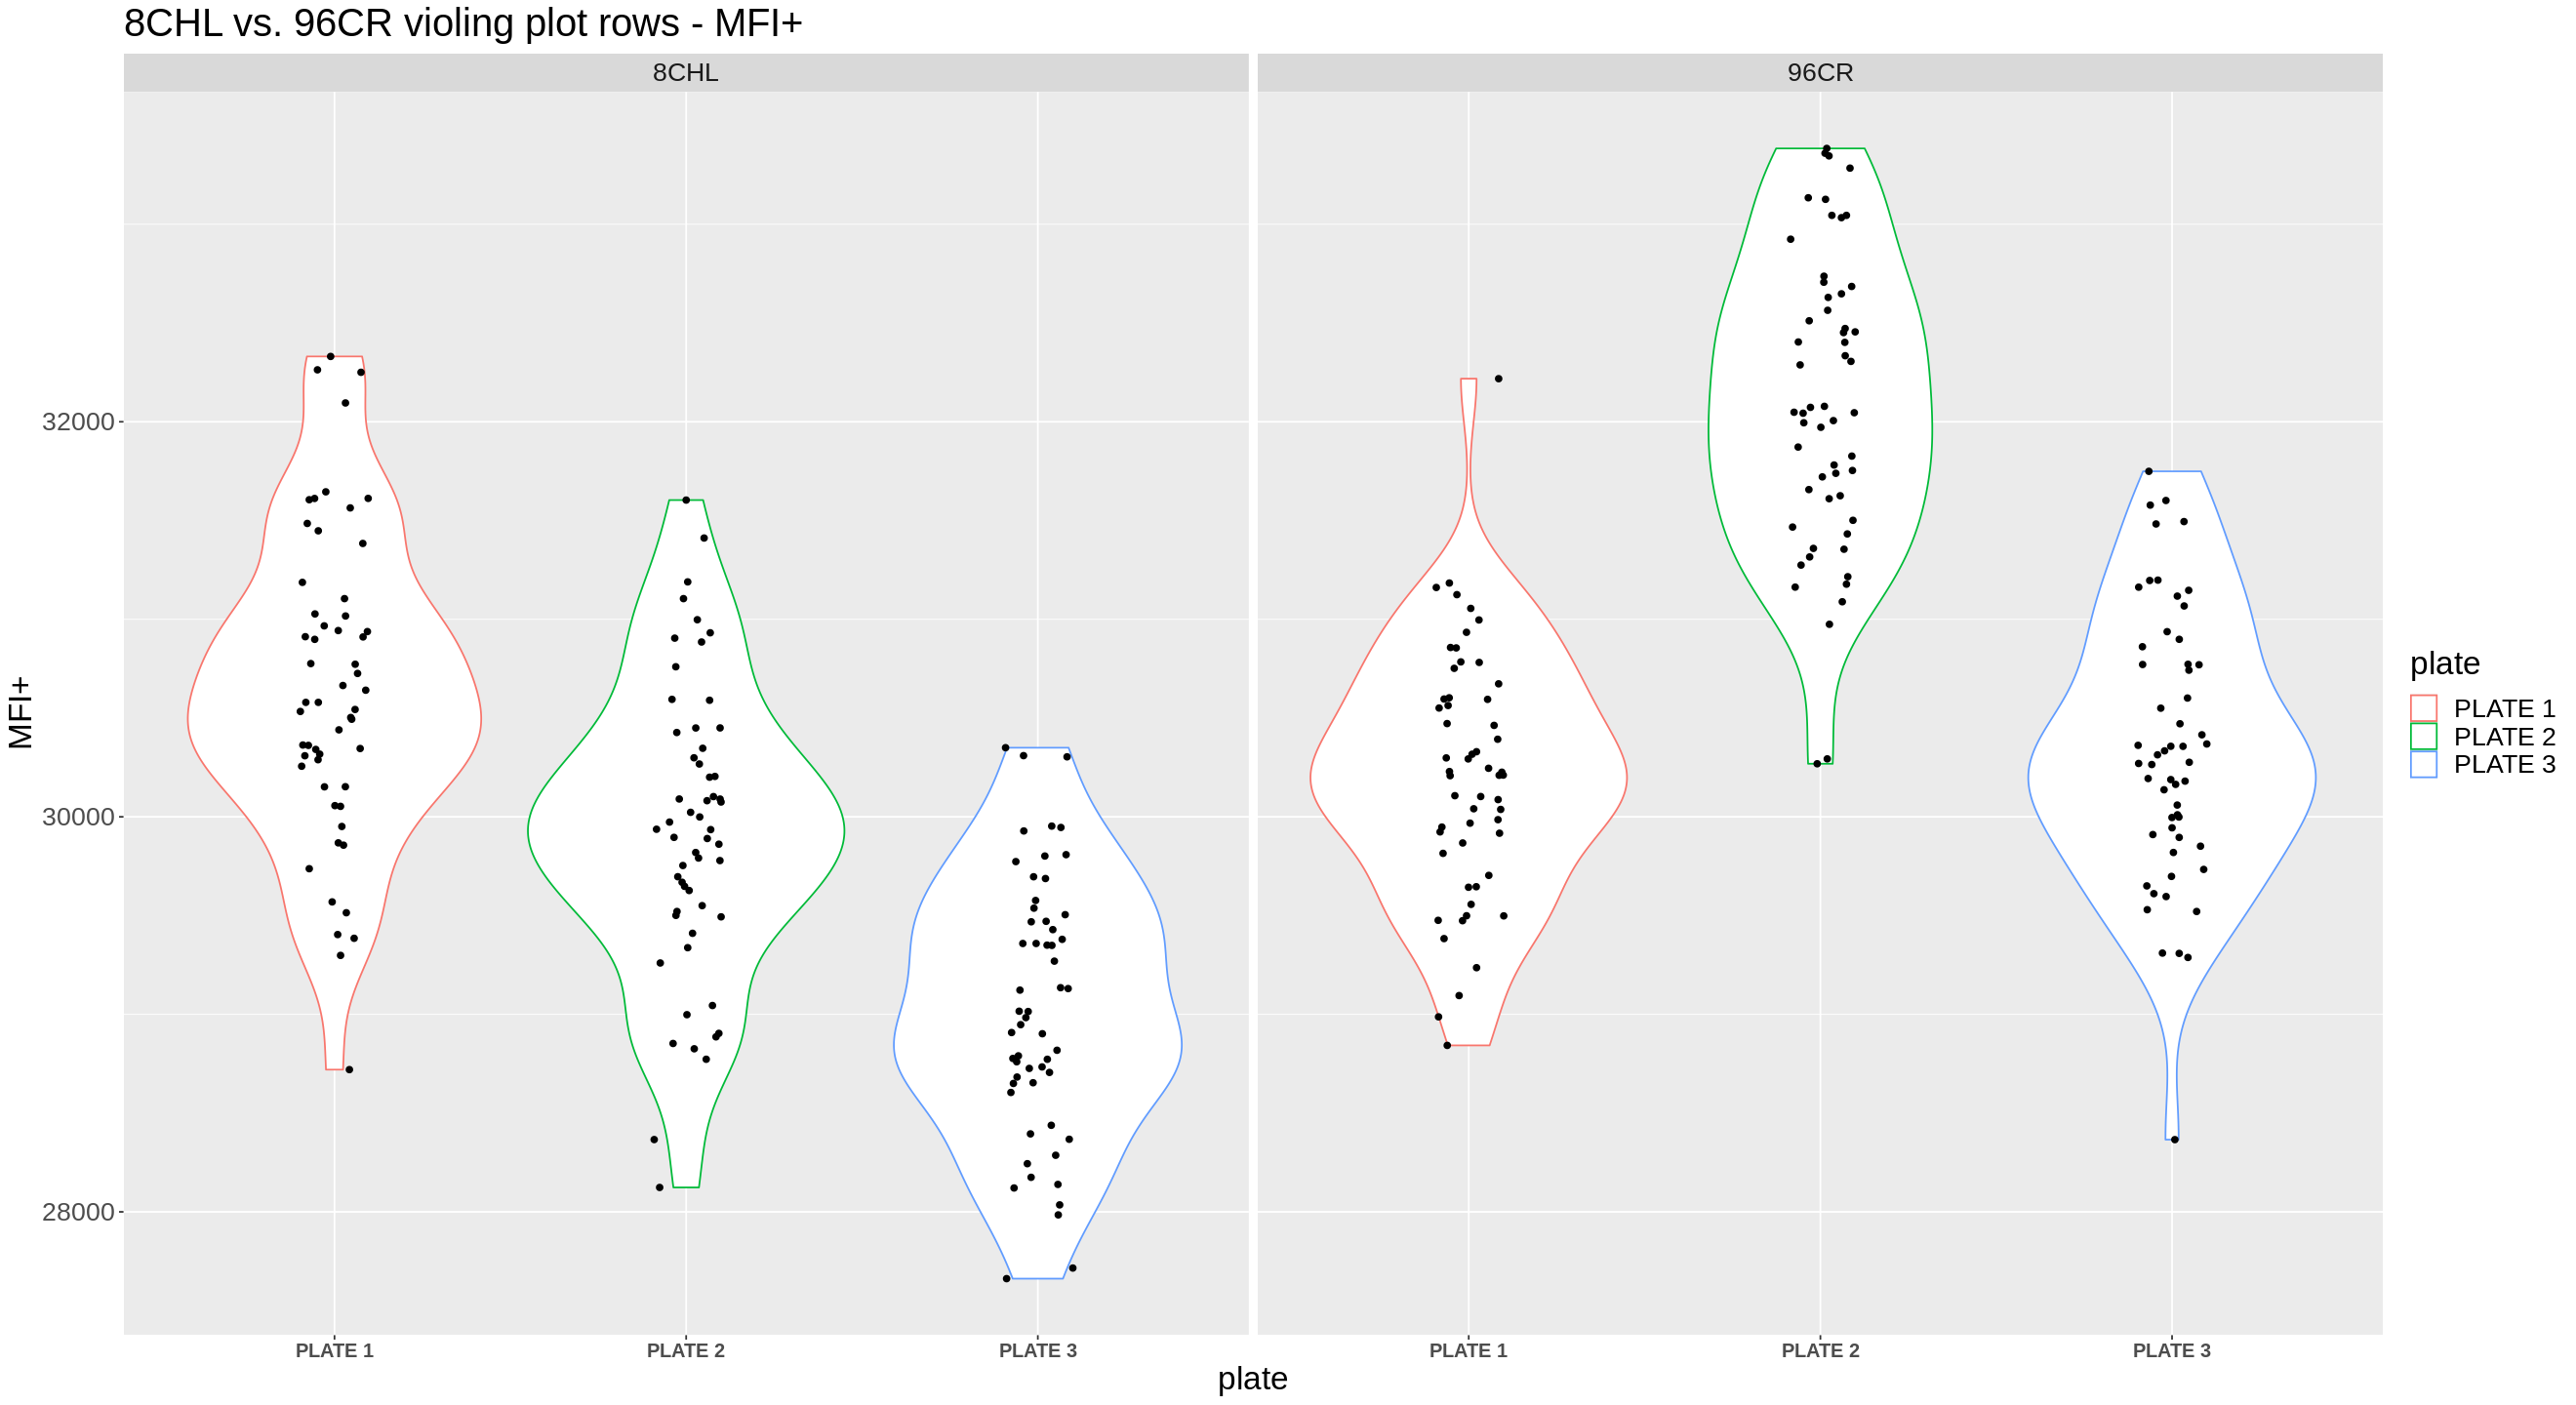

In [78]:
# MFI +
ggplot(dfm, aes(plate, MFI.)) + 
    geom_violin(aes(colour = plate)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8CHL vs. 96CR violing plot rows - MFI+") +
    facet_wrap(~ method) +
    ylab("MFI+") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

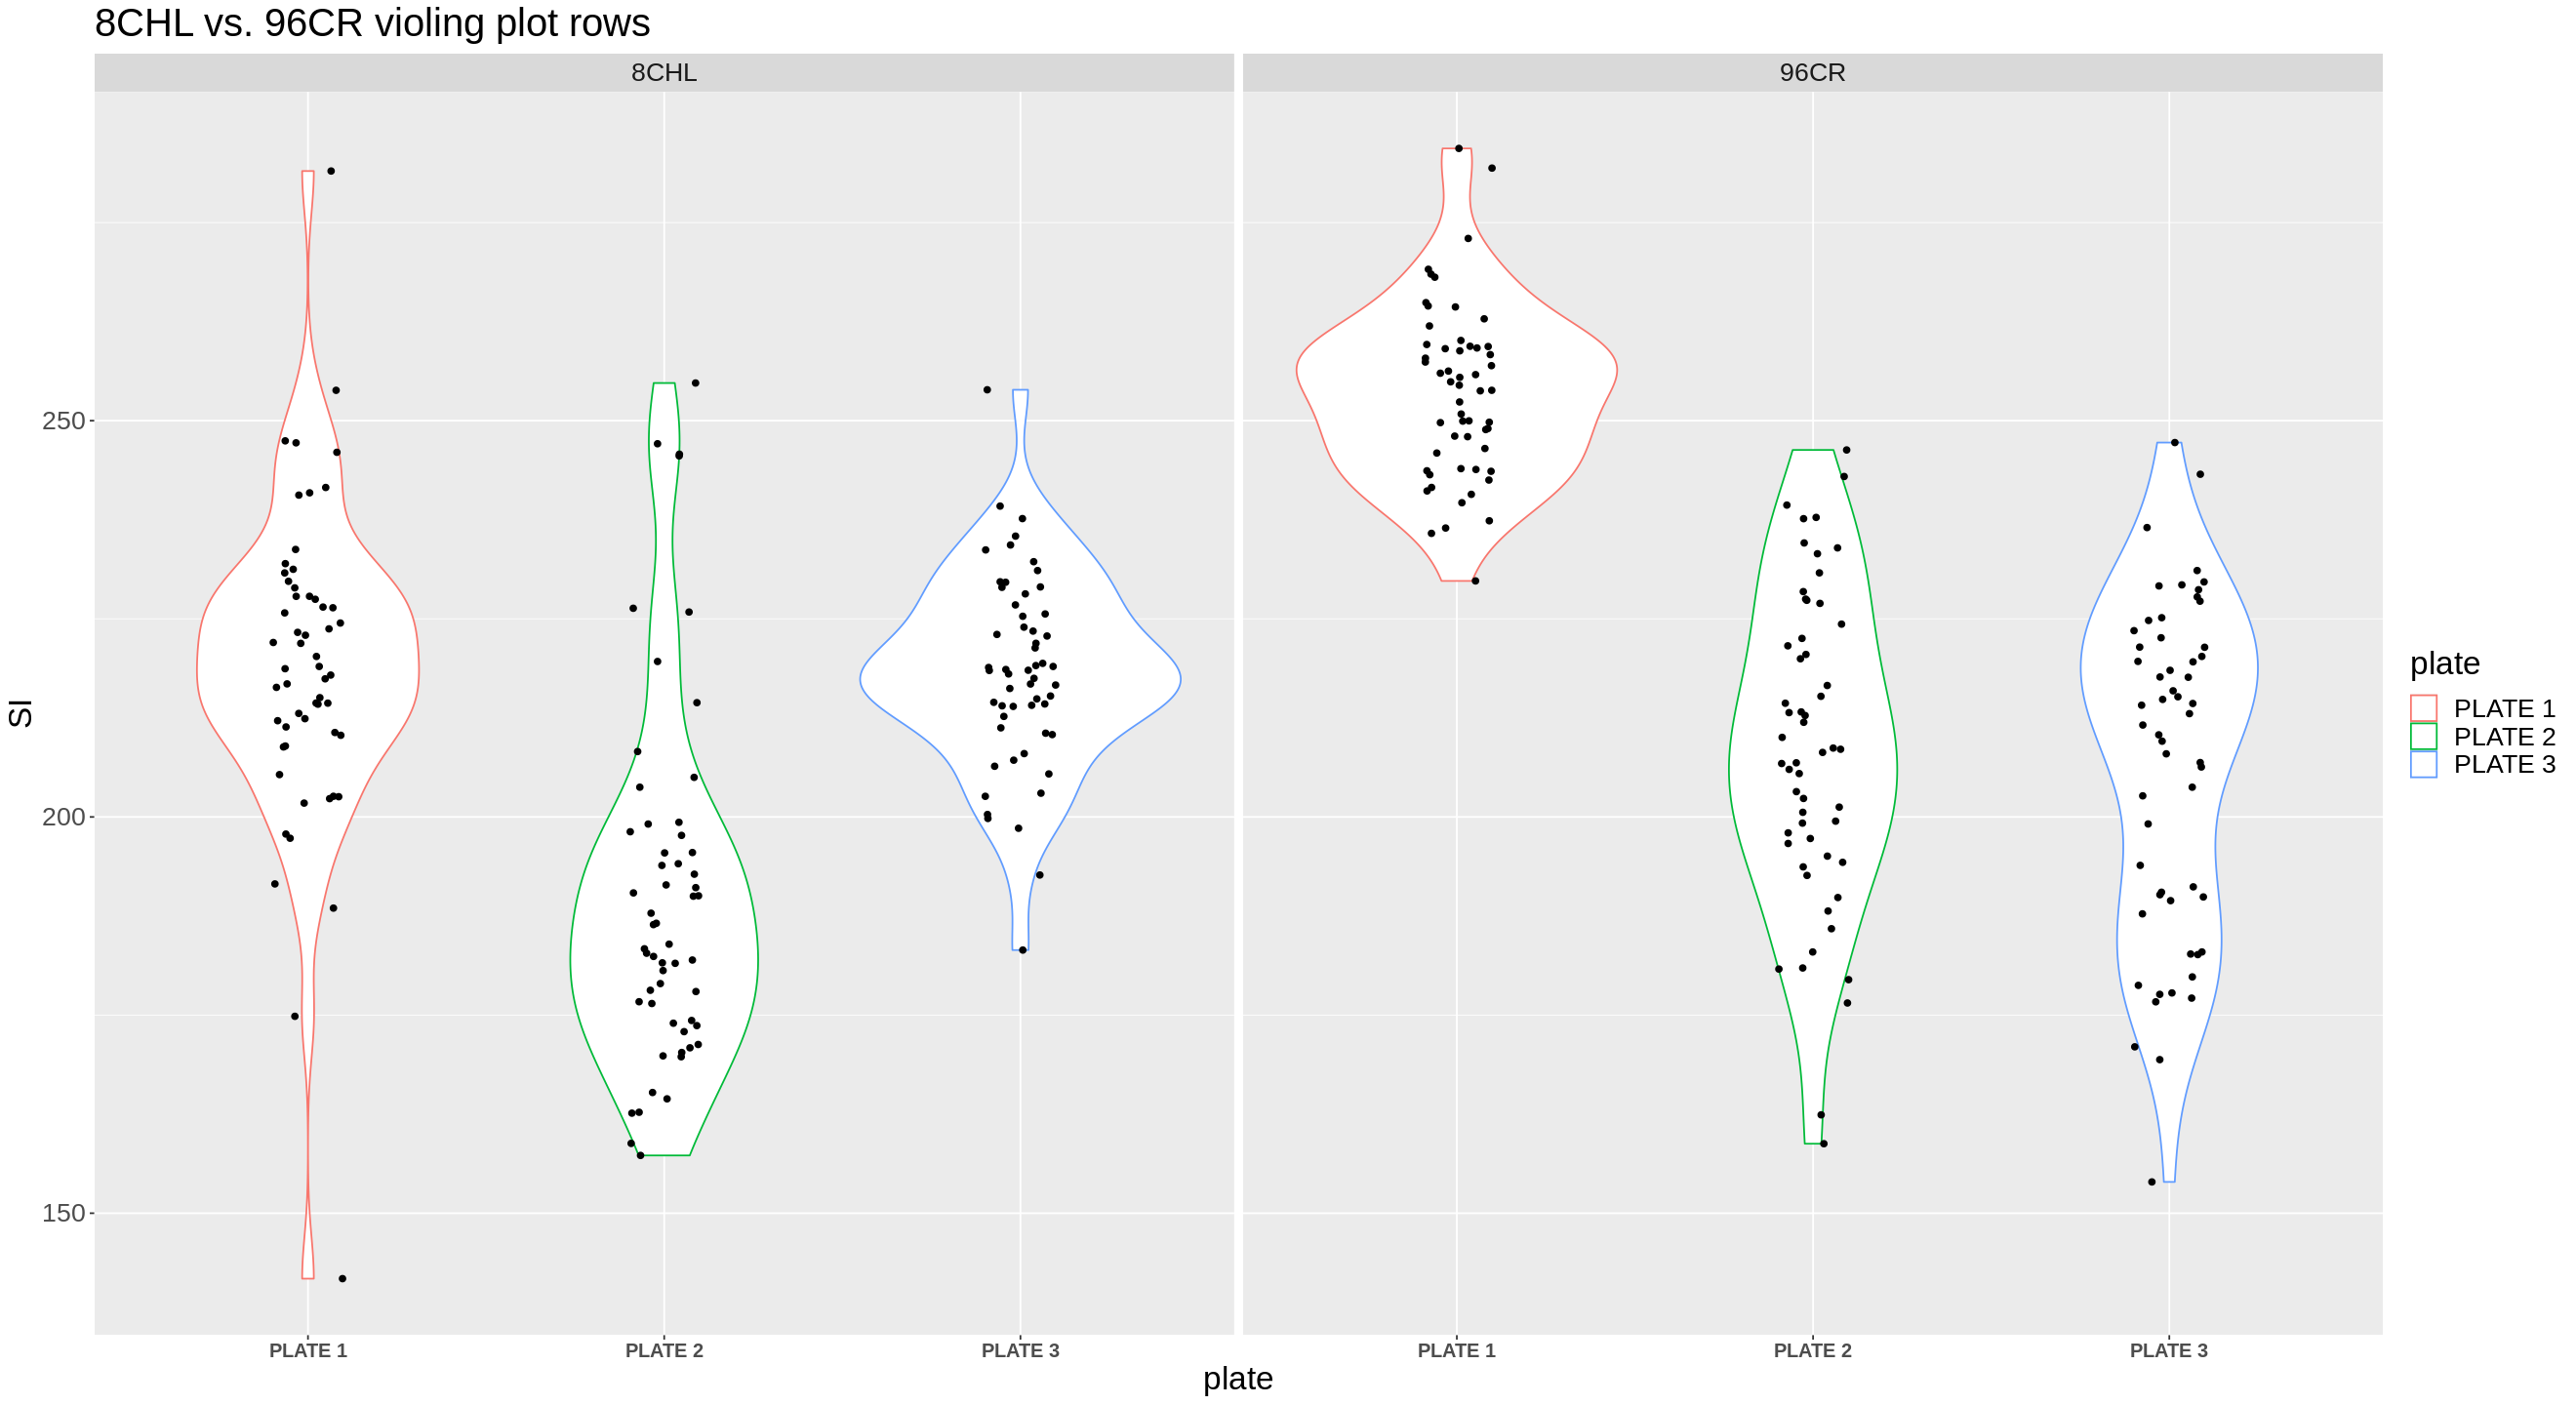

In [19]:
ggplot(dfm, aes(plate, SI)) + 
    geom_violin(aes(colour = plate)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8CHL vs. 96CR violing plot rows") +
    facet_wrap(~ method) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

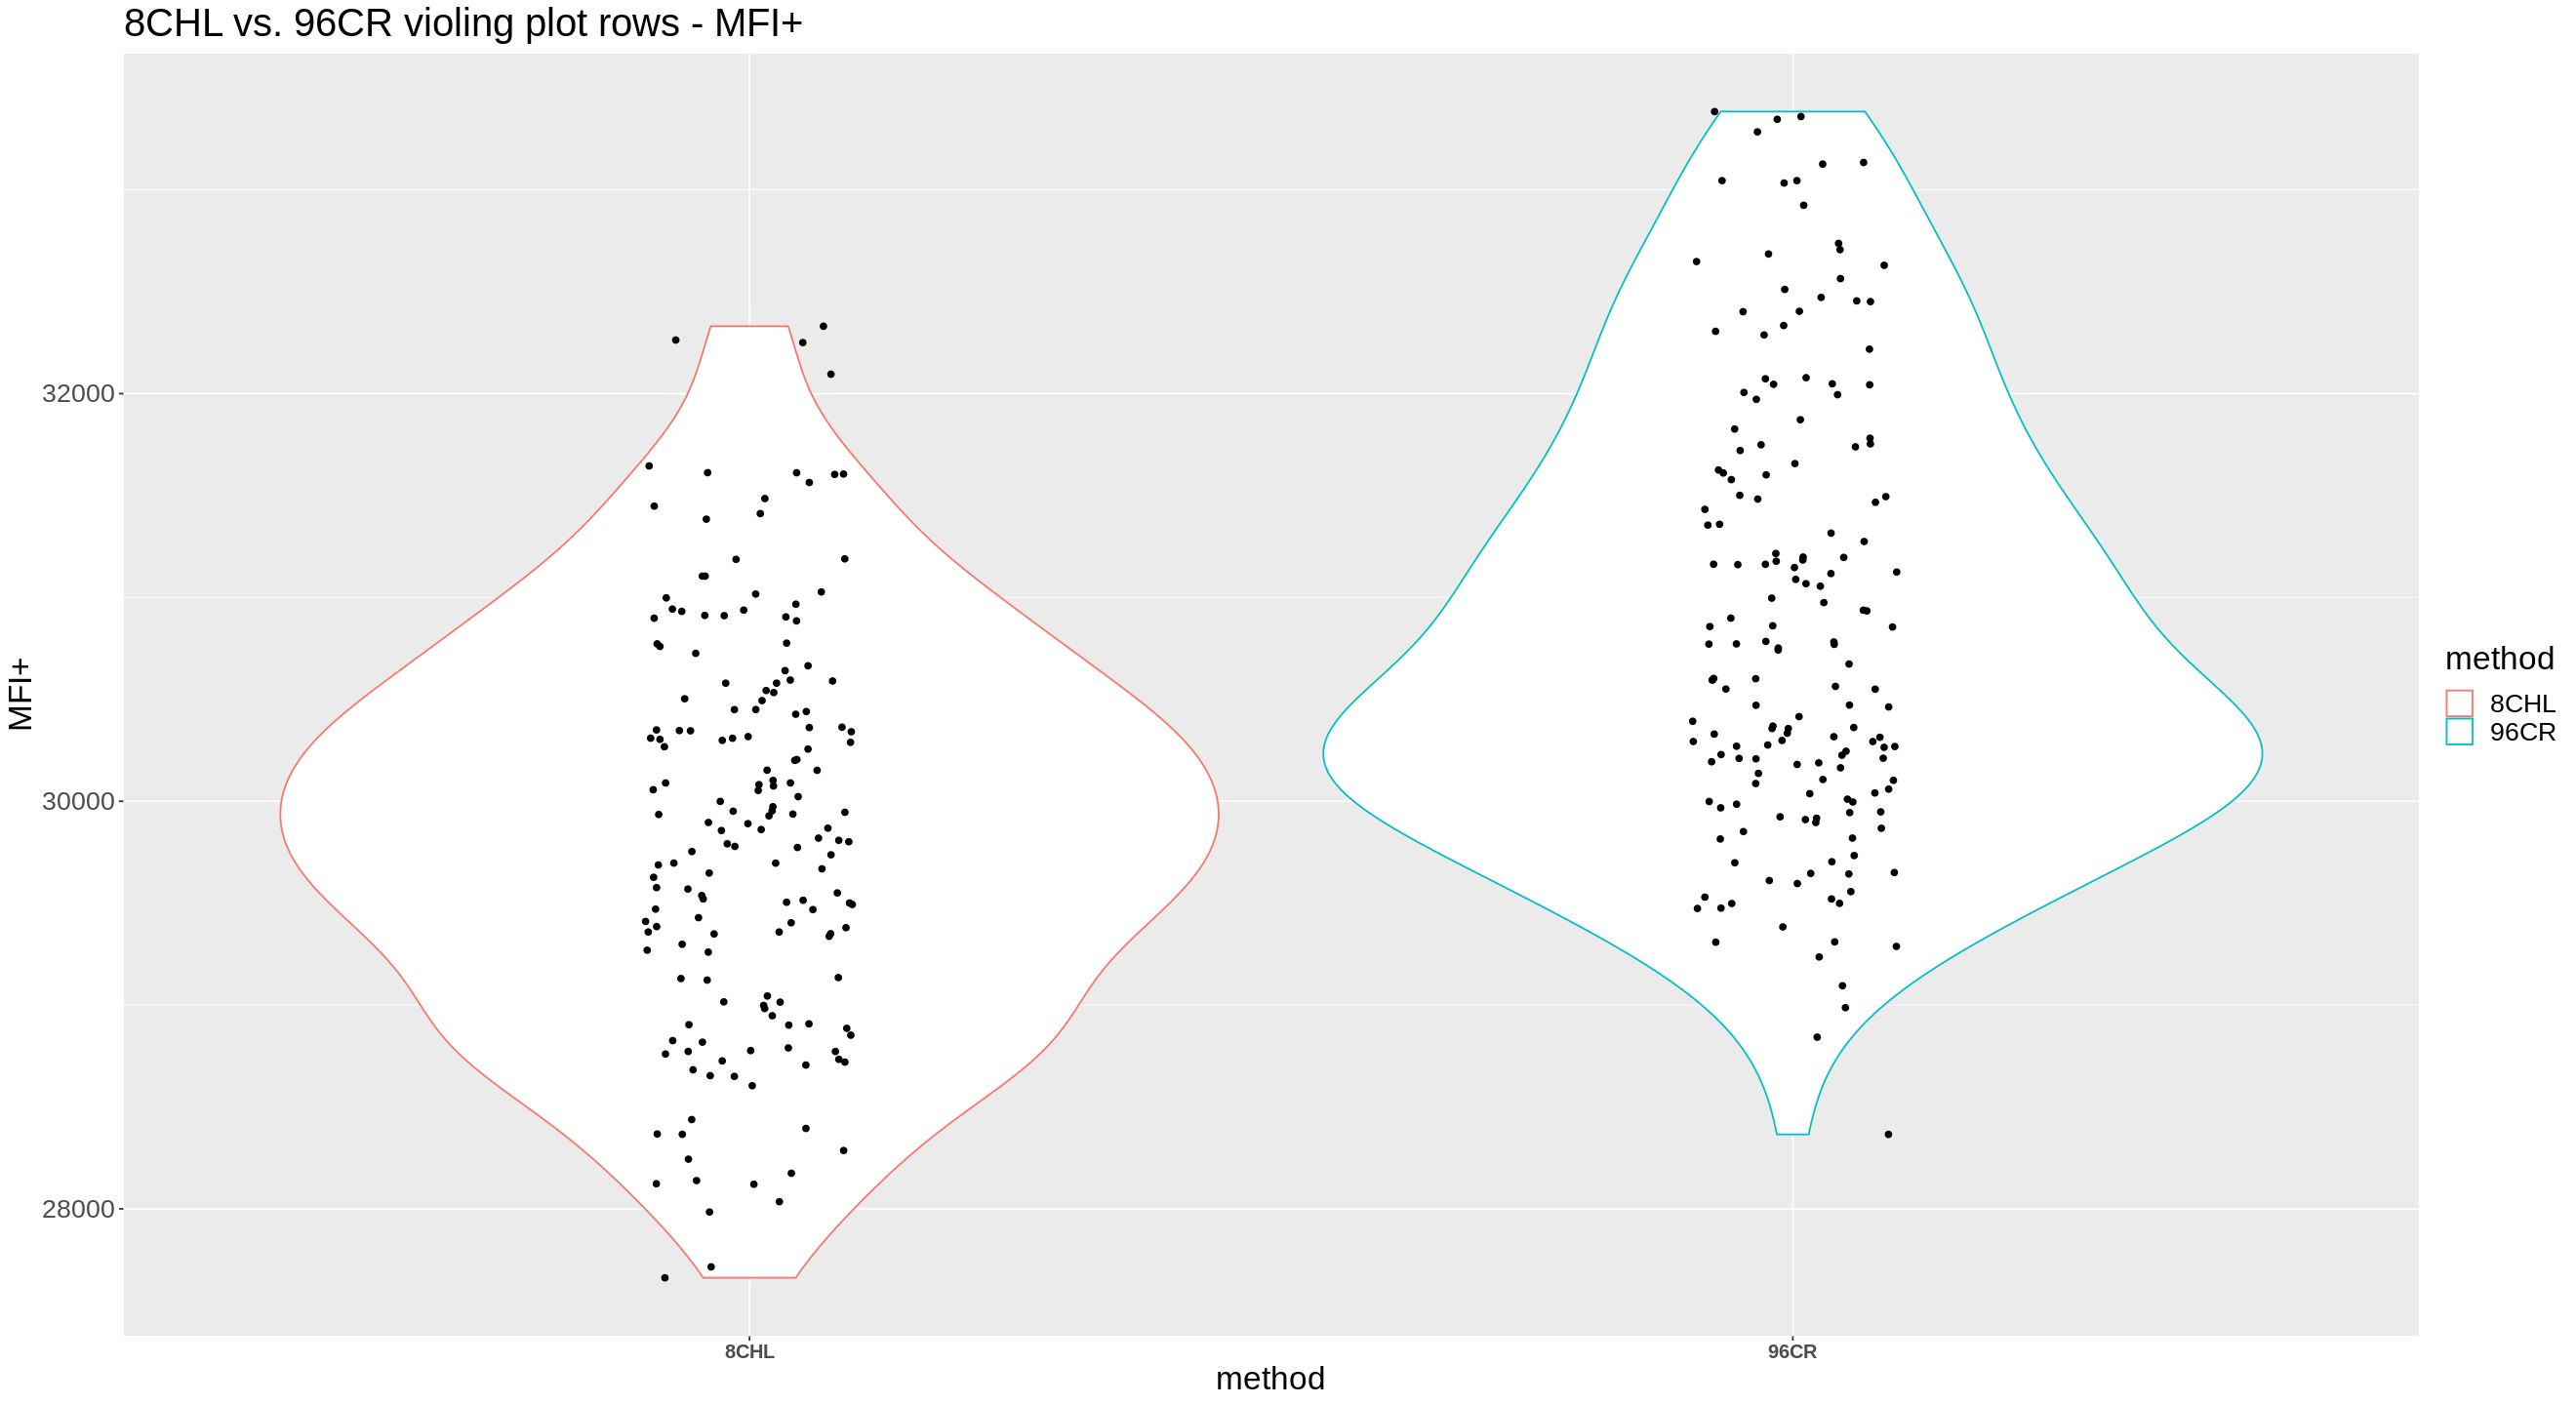

In [77]:
# MFI
ggplot(dfm, aes(method, MFI.)) + 
    geom_violin(aes(colour = method)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8CHL vs. 96CR violing plot rows - MFI+") +
    ylab("MFI+") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

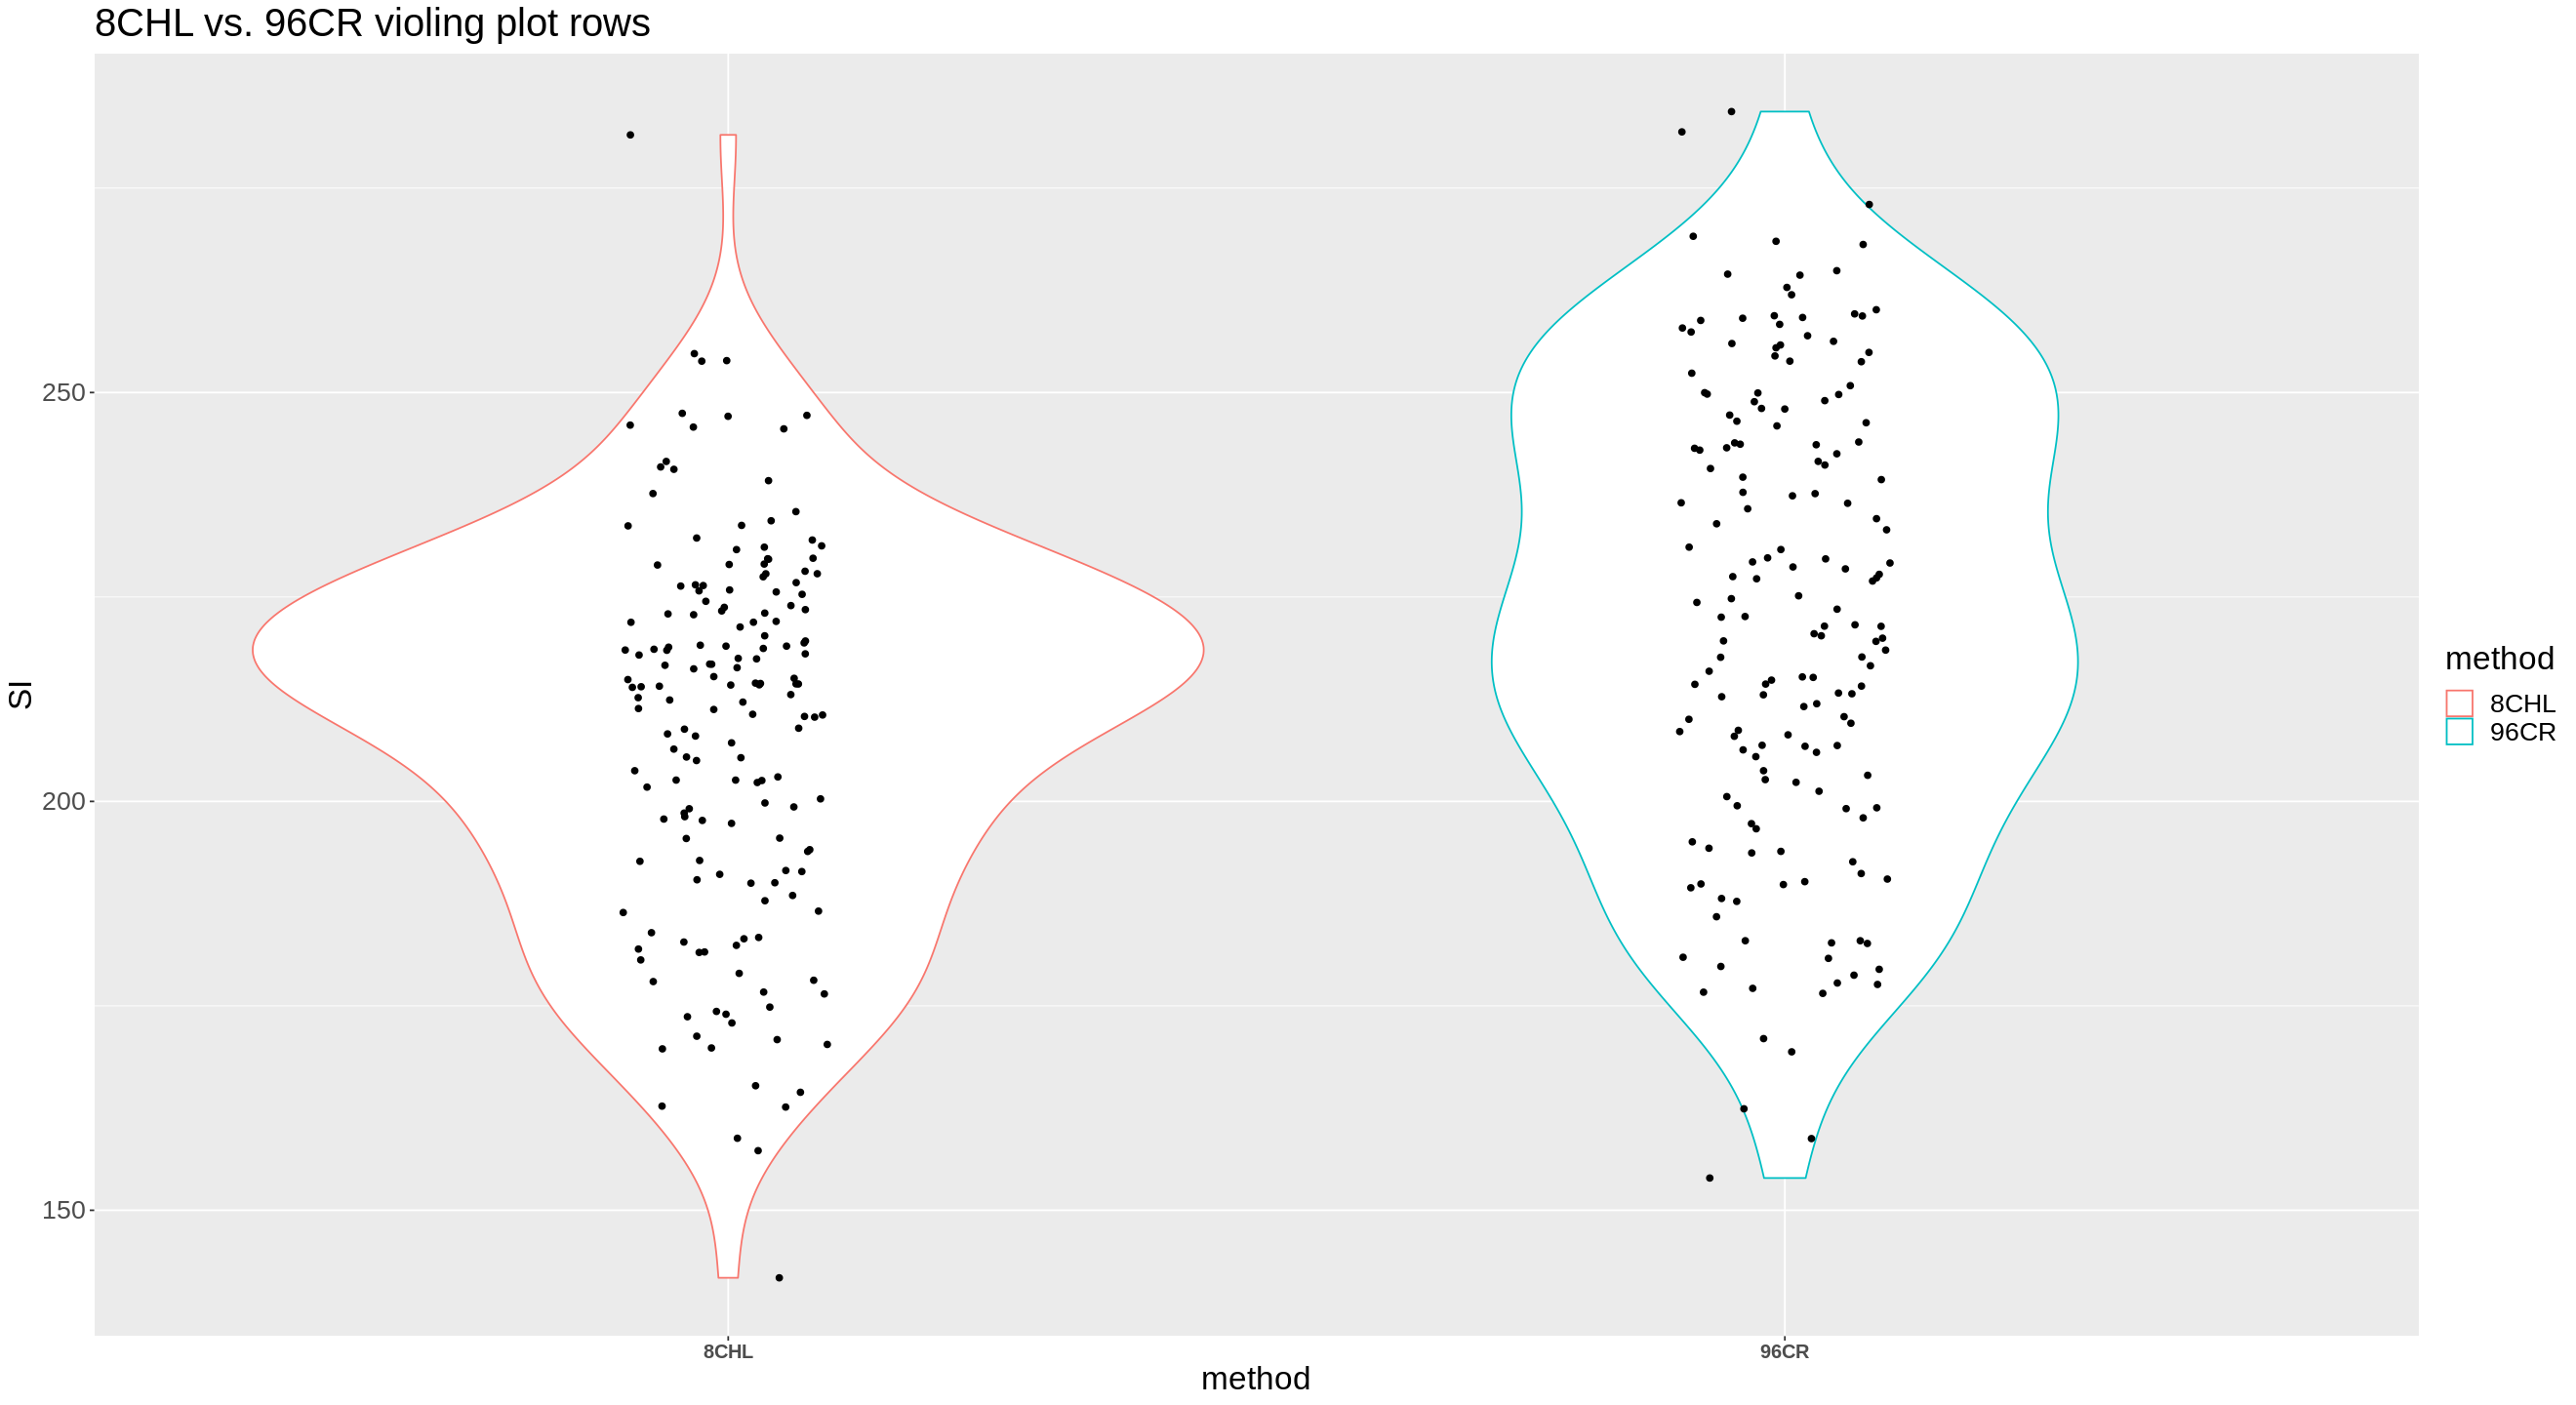

In [20]:
# SI 
ggplot(dfm, aes(method, SI)) + 
    geom_violin(aes(colour = method)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle("8CHL vs. 96CR violing plot rows") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

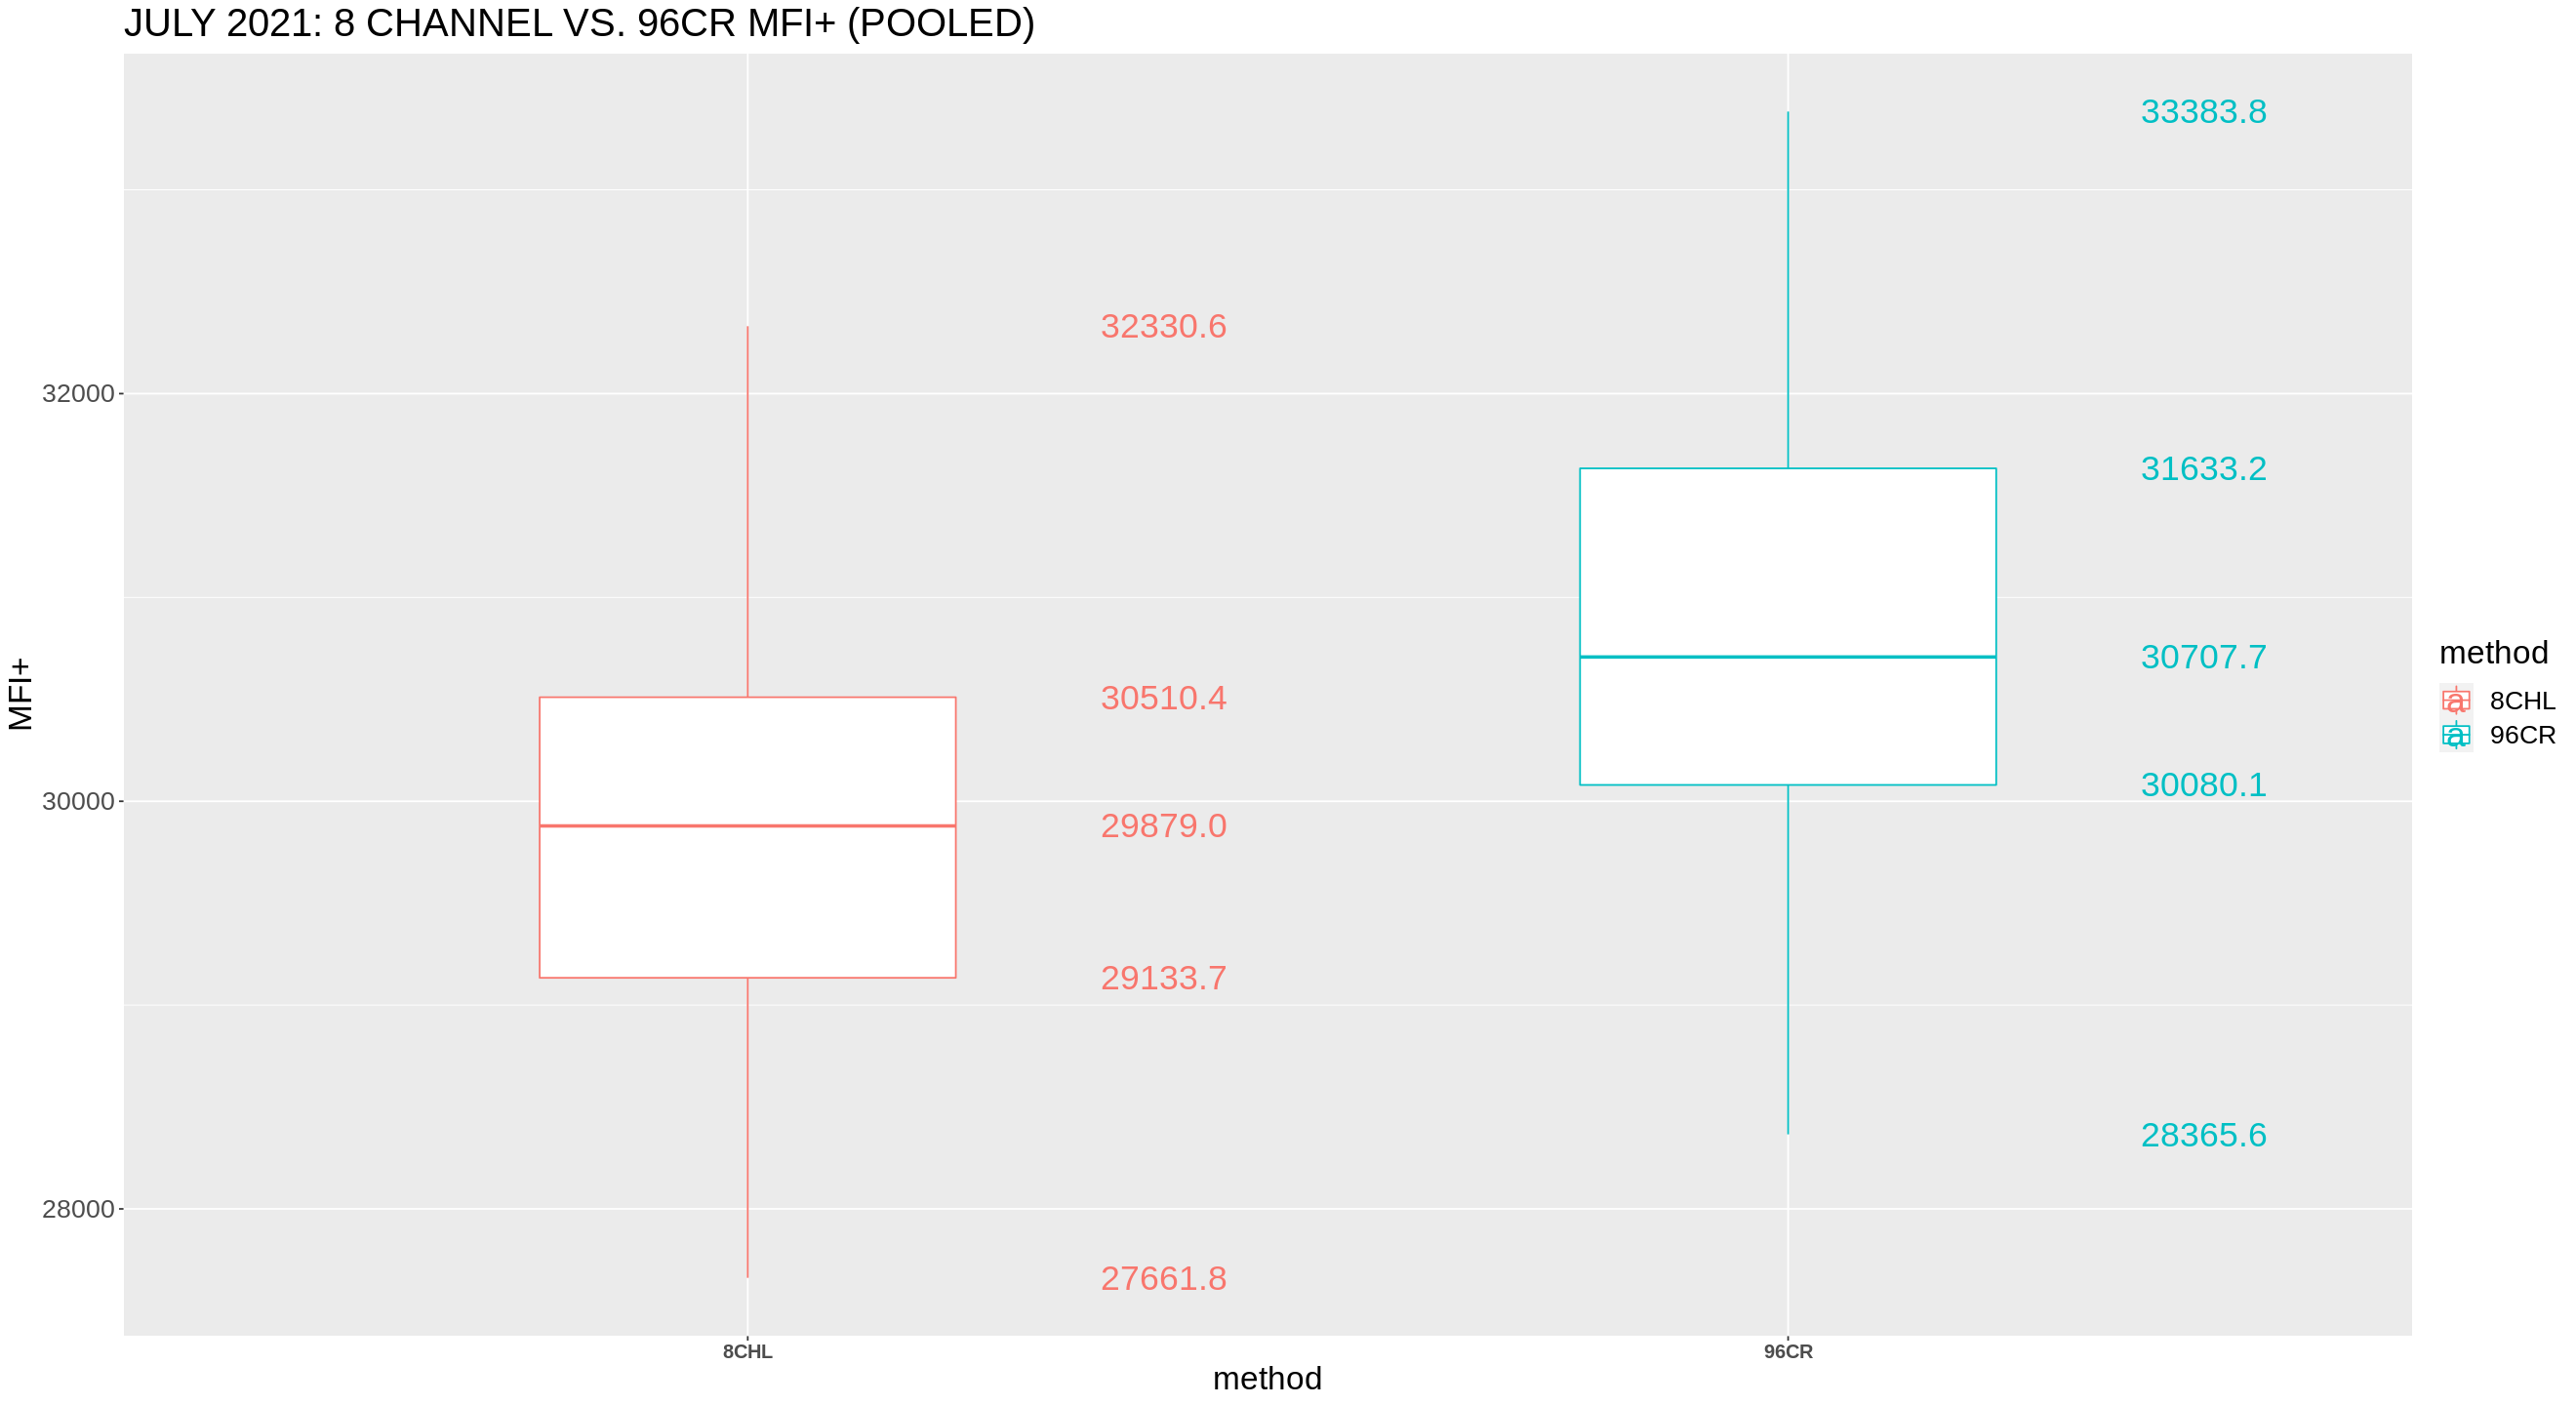

In [34]:
# MFI+ Pooled
ggplot(dfm, aes(method, MFI.)) + 
    geom_boxplot(width = 0.4, aes(group = method, colour = method)) + #, fill = plate)) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=method),
           position=position_nudge(x=0.4), size=7.5) +
    ggtitle("JULY 2021: 8 CHANNEL VS. 96CR MFI+ (POOLED)") + 
    ylab("MFI+") +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

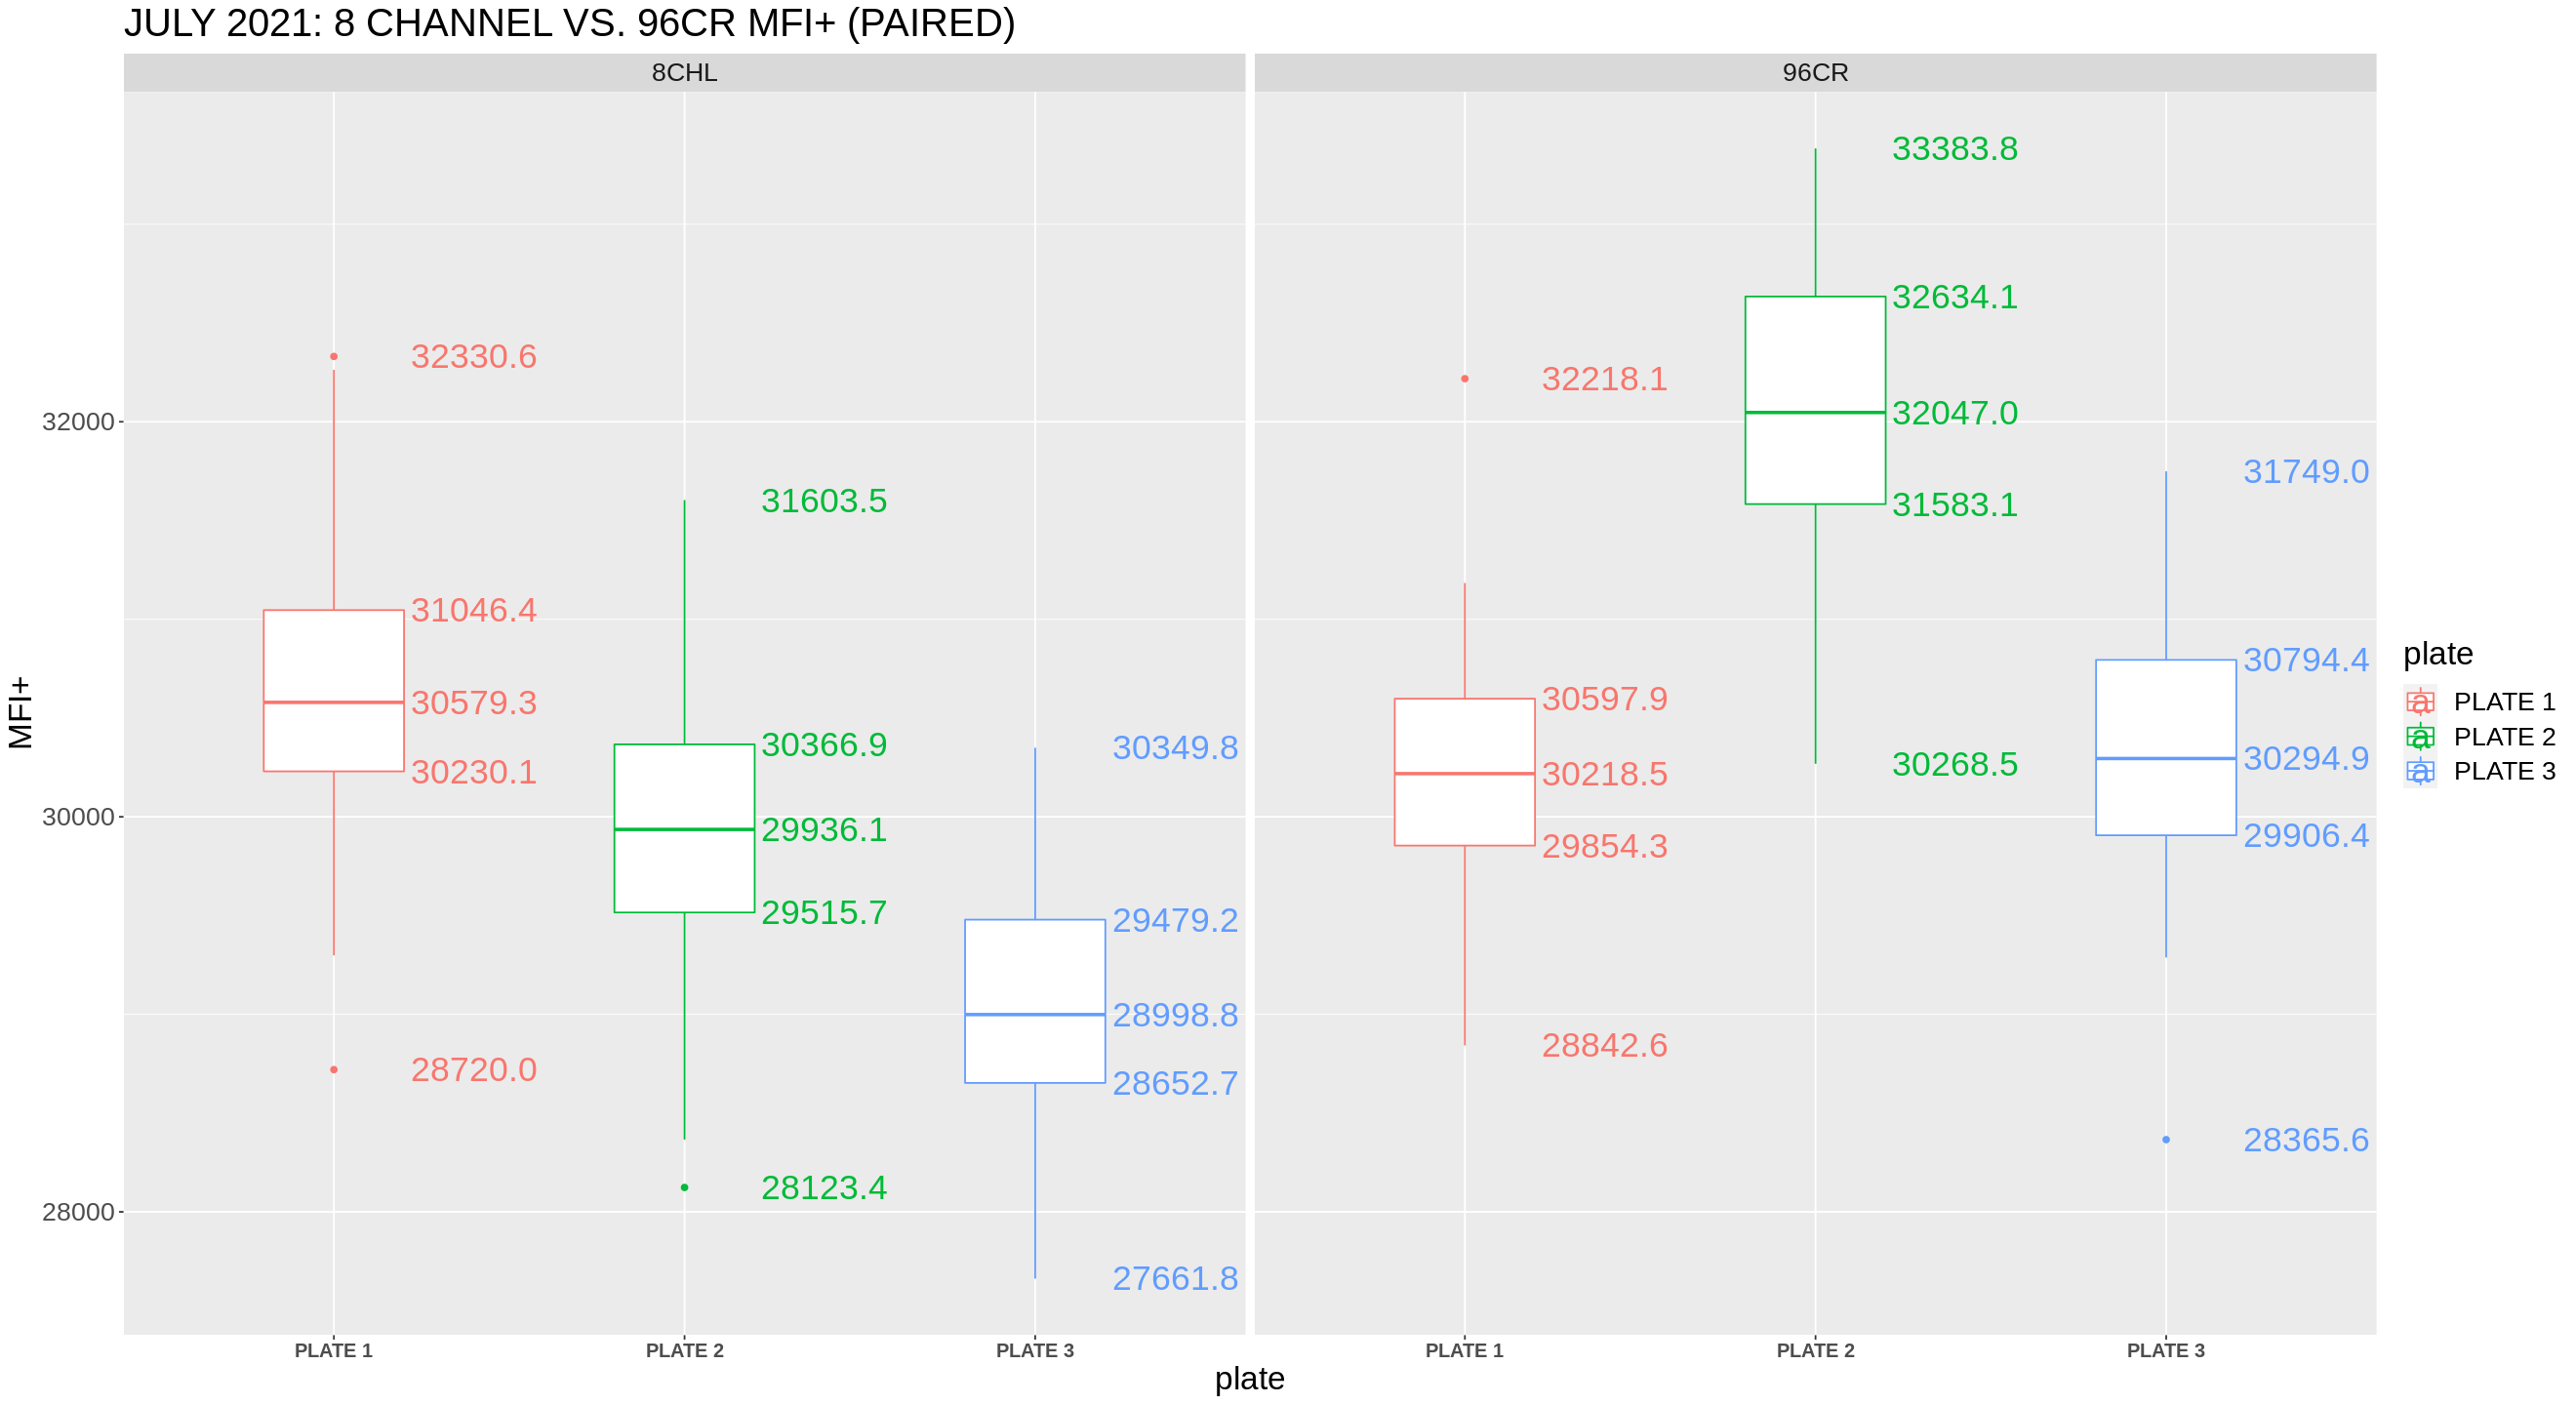

In [28]:
# MFI+ paired
ggplot(dfm, aes(plate, MFI.)) + 
    geom_boxplot(width = 0.4, aes(group = plate, colour = plate)) + #, fill = plate)) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=plate),
           position=position_nudge(x=0.4), size=7.5) +
    ggtitle("JULY 2021: 8 CHANNEL VS. 96CR MFI+ (PAIRED)") + 
    ylab("MFI+") +
    facet_wrap(~ method) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

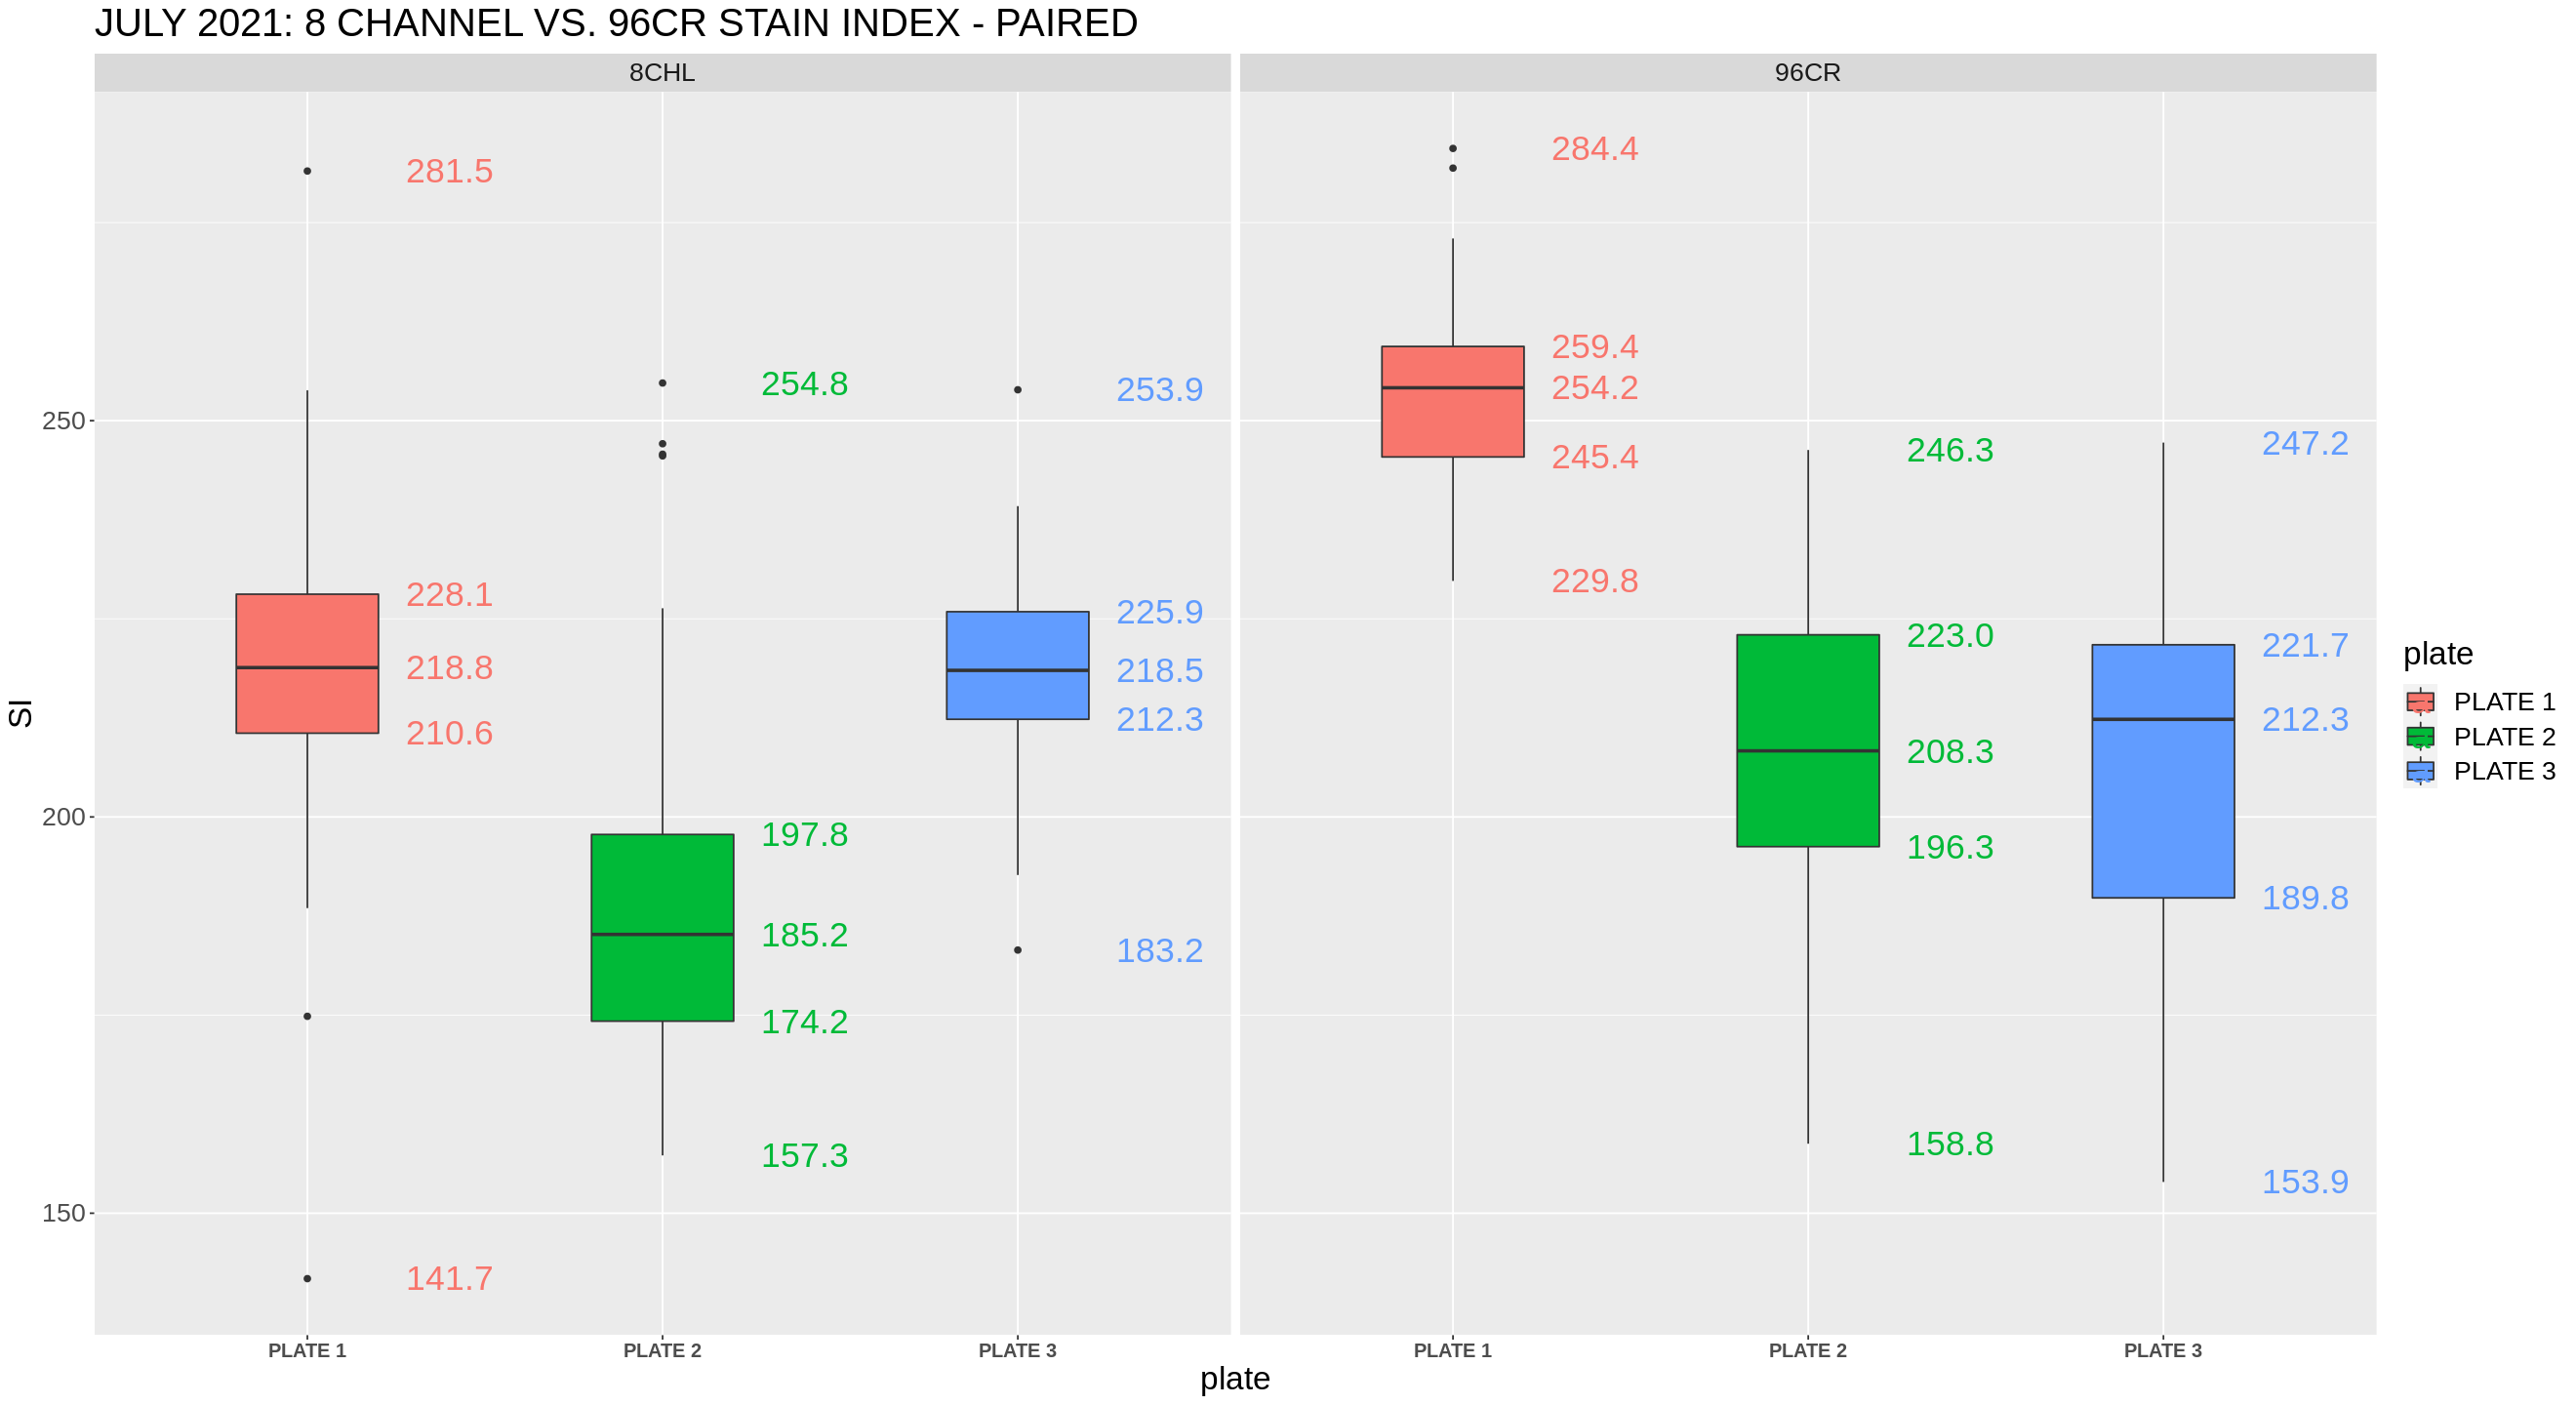

In [12]:
# SI
ggplot(dfm, aes(plate, SI)) + 
    geom_boxplot(width = 0.4, aes(group = plate, fill = plate)) + 
    stat_summary(geom="text", fun=quantile,
           aes(label=sprintf("%1.1f", ..y..), color=plate),
           position=position_nudge(x=0.4), size=7.5) +
    ggtitle("JULY 2021: 8 CHANNEL VS. 96CR STAIN INDEX - PAIRED") + 
    ylab("SI") +
    facet_wrap(~ method) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12)) 

#### Violin plots
-  It is similar to a box plot, with the addition of a rotated kernel density plot on each side

### simple stats

In [65]:

df.t <- dfm %>% filter(plate != 'PLATE 1', method == '8CHL')
head(df.t)

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method plate  
1 Specimen_001_A2_A02_002.fcs 29819.24 62.83  245.7714 474.6019 8CHL   PLATE 2
2 Specimen_001_A3_A03_003.fcs 30589.98 71.37  199.3247 428.6111 8CHL   PLATE 2
3 Specimen_001_A4_A04_004.fcs 30449.98 67.71  193.8818 449.7117 8CHL   PLATE 2
4 Specimen_001_A5_A05_005.fcs 29550.23 73.20  178.9741 403.6916 8CHL   PLATE 2
5 Specimen_001_A6_A06_006.fcs 29626.79 62.22  247.0905 476.1618 8CHL   PLATE 2
6 Specimen_001_A7_A07_007.fcs 29753.36 70.15  226.3302 424.1391 8CHL   PLATE 2
  wellid
1 A2    
2 A3    
3 A4    
4 A5    
5 A6    
6 A7

In [100]:
df.t <- dfm %>% filter(plate != 'PLATE 2')

y = t.test(MFI.~ method, dfm,
                alternative= "two.sided",
                paired=FALSE, 
                var.equal=TRUE, 
                conf.level=0.95)
y$p.value

[1] 4.367425e-17

In [87]:
df.t <- dfm %>% filter(plate != 'PLATE 1')
head(df.t)

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method plate  
1 Specimen_001_A2_A02_002.fcs 29819.24 62.83  245.7714 474.6019 8CHL   PLATE 2
2 Specimen_001_A3_A03_003.fcs 30589.98 71.37  199.3247 428.6111 8CHL   PLATE 2
3 Specimen_001_A4_A04_004.fcs 30449.98 67.71  193.8818 449.7117 8CHL   PLATE 2
4 Specimen_001_A5_A05_005.fcs 29550.23 73.20  178.9741 403.6916 8CHL   PLATE 2
5 Specimen_001_A6_A06_006.fcs 29626.79 62.22  247.0905 476.1618 8CHL   PLATE 2
6 Specimen_001_A7_A07_007.fcs 29753.36 70.15  226.3302 424.1391 8CHL   PLATE 2
  wellid
1 A2    
2 A3    
3 A4    
4 A5    
5 A6    
6 A7

### Effect Size Calculator for T-Test
- For the independent samples T-test, Cohen's d is determined by calculating the mean difference between your two groups, and then dividing the result by the pooled standard deviation.
- Cohen's d is the appropriate effect size measure if two groups have similar standard deviations and are of the same size
- Cohen’s D , or standardized mean difference, is one of the most common ways to measure effect size. An effect size is how large an effect is. For example, medication A has a larger effect than medication B. While a p-value can tell you if there is an effect, it won’t tell you how large that effect is
- also called z-score, they range from 0-1. Take absolute value or use larger value in the first position in the formula
- medium effect size ~ 0.5, large effect size >0.8, <0.2 is trivial
- can calculate correlation coefficient from cohen's d => d/(sqrt(d^2 + 4))

In [8]:
devtools::install_github("mtorchiano/effsize")

✔  checking for file ‘/tmp/Rtmp9UCOhU/remotes4b272dd4df/mtorchiano-effsize-03025ad/DESCRIPTION’
─  preparing ‘effsize’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘effsize_0.8.0.tar.gz’
   


In [9]:
library(effsize)

In [15]:
df8 <- dfm %>% filter(method == "8CHL") %>% select(MFI.) %>% pull()
df96 <- dfm %>% filter(method == "96CR") %>% select(MFI.)%>% pull()

In [20]:
cohen_result <- cohen.d(df8,df96,pooled=TRUE,paired=FALSE,
                   na.rm=FALSE, mu=0, hedges.correction=FALSE,
                   conf.level=0.95,noncentral=FALSE, 
                   within=TRUE, subject=NA) 

In [26]:
cod_estimate <- abs(cohen_result$estimate)
corr_coef <- cod_estimate/(sqrt(cod_estimate^2 +4))
print(paste(cod_estimate, corr_coef))

[1] "0.968240026427494 0.435742552040191"


In [42]:
for (i in seq(3)) {
    df8 <- dfm %>% filter(method == "8CHL", plate == paste("PLATE", i)) %>% select(MFI.) %>% pull()
    df96 <- dfm %>% filter(method == "96CR", plate == paste("PLATE", i)) %>% select(MFI.)%>% pull()
    cohen_result <- cohen.d(df8,df96,pooled=TRUE,paired=FALSE,
                       na.rm=FALSE, mu=0, hedges.correction=FALSE,
                       conf.level=0.95,noncentral=FALSE, 
                       within=TRUE, subject=NA) 
    cod_estimate <- abs(cohen_result$estimate)
    corr_coef <- cod_estimate/(sqrt(cod_estimate^2 +4))
    print(paste("plate", i, cod_estimate, corr_coef))
}

[1] "plate 1 0.621294545833314 0.296662659112771"
[1] "plate 2 2.89259280586862 0.822533293714066"
[1] "plate 3 1.95313396791886 0.698674641018809"


In [102]:
wilcox.test(MFI.~method, 
                    dfm,
                    alternative= "two.sided",
                    paired=FALSE, 
                    var.equal=TRUE, 
                    conf.level=0.95)


	Wilcoxon rank sum test with continuity correction

data:  MFI. by method
W = 7245.5, p-value = 1.238e-14
alternative hypothesis: true location shift is not equal to 0


In [106]:
unique(dfm$method)

[1] "8CHL" "96CR"

In [107]:
df1 <- dfm %>% filter(plate == 'PLATE 1', method == '8CHL')
df1_ <- dfm %>% filter(plate == 'PLATE 1', method == '96CR')

In [116]:
dft <- inner_join(df1, df1_, by = c("wellid","SAMPLE_NAME"))
head(dft)

SAMPLE_NAME                 MFI..x   MFI..1.x SI.x     SN.x     method.x
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93    240.8973 467.8717 8CHL    
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15    223.7325 444.5739 8CHL    
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10    201.7459 452.1773 8CHL    
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93    222.9273 448.8274 8CHL    
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59    188.4981 420.7647 8CHL    
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59    202.3096 421.2605 8CHL    
  plate.x wellid MFI..y   MFI..1.y SI.y     SN.y     method.y plate.y
1 PLATE 1 A2     30996.54 69.54    249.7537 445.7369 96CR     PLATE 1
2 PLATE 1 A3     30594.55 69.54    248.8754 439.9561 96CR     PLATE 1
3 PLATE 1 A4     30037.32 65.88    268.4891 455.9398 96CR     PLATE 1
4 PLATE 1 A5     30563.44 70.15    258.8108 435.6870 96CR     PLATE 1
5 PLATE 1 A6     30040.67 68.32    237.3672 439.7054 96CR     PLATE 1
6 PLATE 1 A7     30857.16 68.32    247.9796 451.6563 96CR     PLATE 1

In [117]:
dft

SAMPLE_NAME                 MFI..x   MFI..1.x SI.x     SN.x     method.x
1  Specimen_001_A2_A02_002.fcs 32250.40 68.93000 240.8973 467.8717 8CHL    
2  Specimen_001_A3_A03_003.fcs 31186.86 70.15000 223.7325 444.5739 8CHL    
3  Specimen_001_A4_A04_004.fcs 30341.10 67.10000 201.7459 452.1773 8CHL    
4  Specimen_001_A5_A05_005.fcs 30937.68 68.93000 222.9273 448.8274 8CHL    
5  Specimen_001_A6_A06_006.fcs 30543.31 72.59000 188.4981 420.7647 8CHL    
6  Specimen_001_A7_A07_007.fcs 30579.30 72.59000 202.3096 421.2605 8CHL    
7  Specimen_001_A8_A08_008.fcs 31612.03 73.20000 221.9013 431.8583 8CHL    
8  Specimen_001_B2_B02_014.fcs 29951.00 63.44000 247.4545 472.1154 8CHL    
9  Specimen_001_B3_B03_015.fcs 29569.14 66.49000 213.0617 444.7156 8CHL    
10 Specimen_001_B4_B04_016.fcs 29298.30 65.88000 216.7894 444.7222 8CHL    
11 Specimen_001_B5_B05_017.fcs 30493.90 67.10000 211.3559 454.4546 8CHL    
12 Specimen_001_B6_B06_018.fcs 30898.33 70.76000 215.0510 436.6638 8CHL    
13 Specimen_001_B7_B07_019.fcs 30664.70 73.20000 205.3432 418.9167 8CHL    
14 Specimen_001_B8_B08_020.fcs 32095.15 69.54000 208.8339 461.5351 8CHL    
15 Specimen_001_C2_C02_026.fcs 30056.53 67.10000 229.7337 447.9364 8CHL    
16 Specimen_001_C3_C03_027.fcs 30256.00 66.49000 212.1434 455.0459 8CHL    
17 Specimen_001_C4_C04_028.fcs 30502.75 66.49000 227.8333 458.7569 8CHL    
18 Specimen_001_C5_C05_029.fcs 29514.24 67.71000 197.8402 435.8919 8CHL    
19 Specimen_001_C6_C06_030.fcs 30151.69 71.37000 208.9492 422.4701 8CHL    
20 Specimen_001_C7_C07_031.fcs 30533.25 66.49000 214.3584 459.2156 8CHL    
21 Specimen_001_C8_C08_032.fcs 29737.20 79.91000 141.7449 372.1336 8CHL    
22 Specimen_001_D2_D02_038.fcs 30052.87 66.18500 224.4680 454.0737 8CHL    
23 Specimen_001_D3_D03_039.fcs 30725.70 64.96500 226.3952 472.9577 8CHL    
24 Specimen_001_D4_D04_040.fcs 31611.73 70.15000 216.3494 450.6304 8CHL    
25 Specimen_001_D5_D05_041.fcs 31383.89 68.62500 214.2283 457.3245 8CHL    
26 Specimen_001_D6_D06_042.fcs 32262.90 66.49000 222.0120 485.2294 8CHL    
27 Specimen_001_D7_D07_043.fcs 30911.75 71.98000 210.6542 429.4491 8CHL    
28 Specimen_001_D8_D08_044.fcs 30579.30 75.64000 174.8462 404.2742 8CHL    
29 Specimen_001_E2_E02_050.fcs 30361.53 66.49000 225.7455 456.6330 8CHL    
30 Specimen_001_E3_E03_051.fcs 30772.37 67.71000 231.9608 454.4730 8CHL    
31 Specimen_001_E4_E04_052.fcs 30317.31 68.93000 227.4656 439.8274 8CHL    
32 Specimen_001_E5_E05_053.fcs 30910.53 73.81001 218.7046 418.7851 8CHL    
33 Specimen_001_E6_E06_054.fcs 30966.65 68.32000 214.3711 453.2590 8CHL    
34 Specimen_001_E7_E07_055.fcs 29856.45 71.37000 202.6058 418.3333 8CHL    
35 Specimen_001_E8_E08_056.fcs 30942.86 68.93000 197.3126 448.9027 8CHL    
36 Specimen_001_F2_F02_062.fcs 30152.30 65.88000 231.2476 457.6852 8CHL    
37 Specimen_001_F3_F03_063.fcs 28720.02 65.88000 218.9865 435.9444 8CHL    
38 Specimen_001_F4_F04_064.fcs 30363.36 69.54000 223.2895 436.6316 8CHL    
39 Specimen_001_F5_F05_065.fcs 31027.04 65.27000 228.9038 475.3645 8CHL    
40 Specimen_001_F6_F06_066.fcs 30345.67 70.15000 210.3051 432.5826 8CHL    
41 Specimen_001_F7_F07_067.fcs 30775.72 69.54000 212.3986 442.5614 8CHL    
42 Specimen_001_F8_F08_068.fcs 31645.28 77.47000 202.5530 408.4843 8CHL    
43 Specimen_001_G2_G02_074.fcs 31016.67 67.71000 246.0107 458.0811 8CHL    
44 Specimen_001_G3_G03_075.fcs 31605.32 70.76000 241.5701 446.6552 8CHL    
45 Specimen_001_G4_G04_076.fcs 30640.91 69.54000 217.9000 440.6228 8CHL    
46 Specimen_001_G5_G05_077.fcs 32330.61 68.93000 253.8309 469.0354 8CHL    
47 Specimen_001_G6_G06_078.fcs 31447.94 67.10000 247.2045 468.6728 8CHL    
48 Specimen_001_G7_G07_079.fcs 30309.07 74.42000 240.6068 407.2705 8CHL    
49 Specimen_001_G8_G08_080.fcs 29403.83 75.64000 191.5498 388.7339 8CHL    
50 Specimen_001_H2_H02_086.fcs 29384.92 69.54000 230.7896 422.5614 8CHL    
51 Specimen_001_H3_H03_087.fcs 29868.04 67.10000 233.7512 445.1273 8CHL    
52 Specimen_001_H4_H04_088.fcs 30288.94 67.10000 28

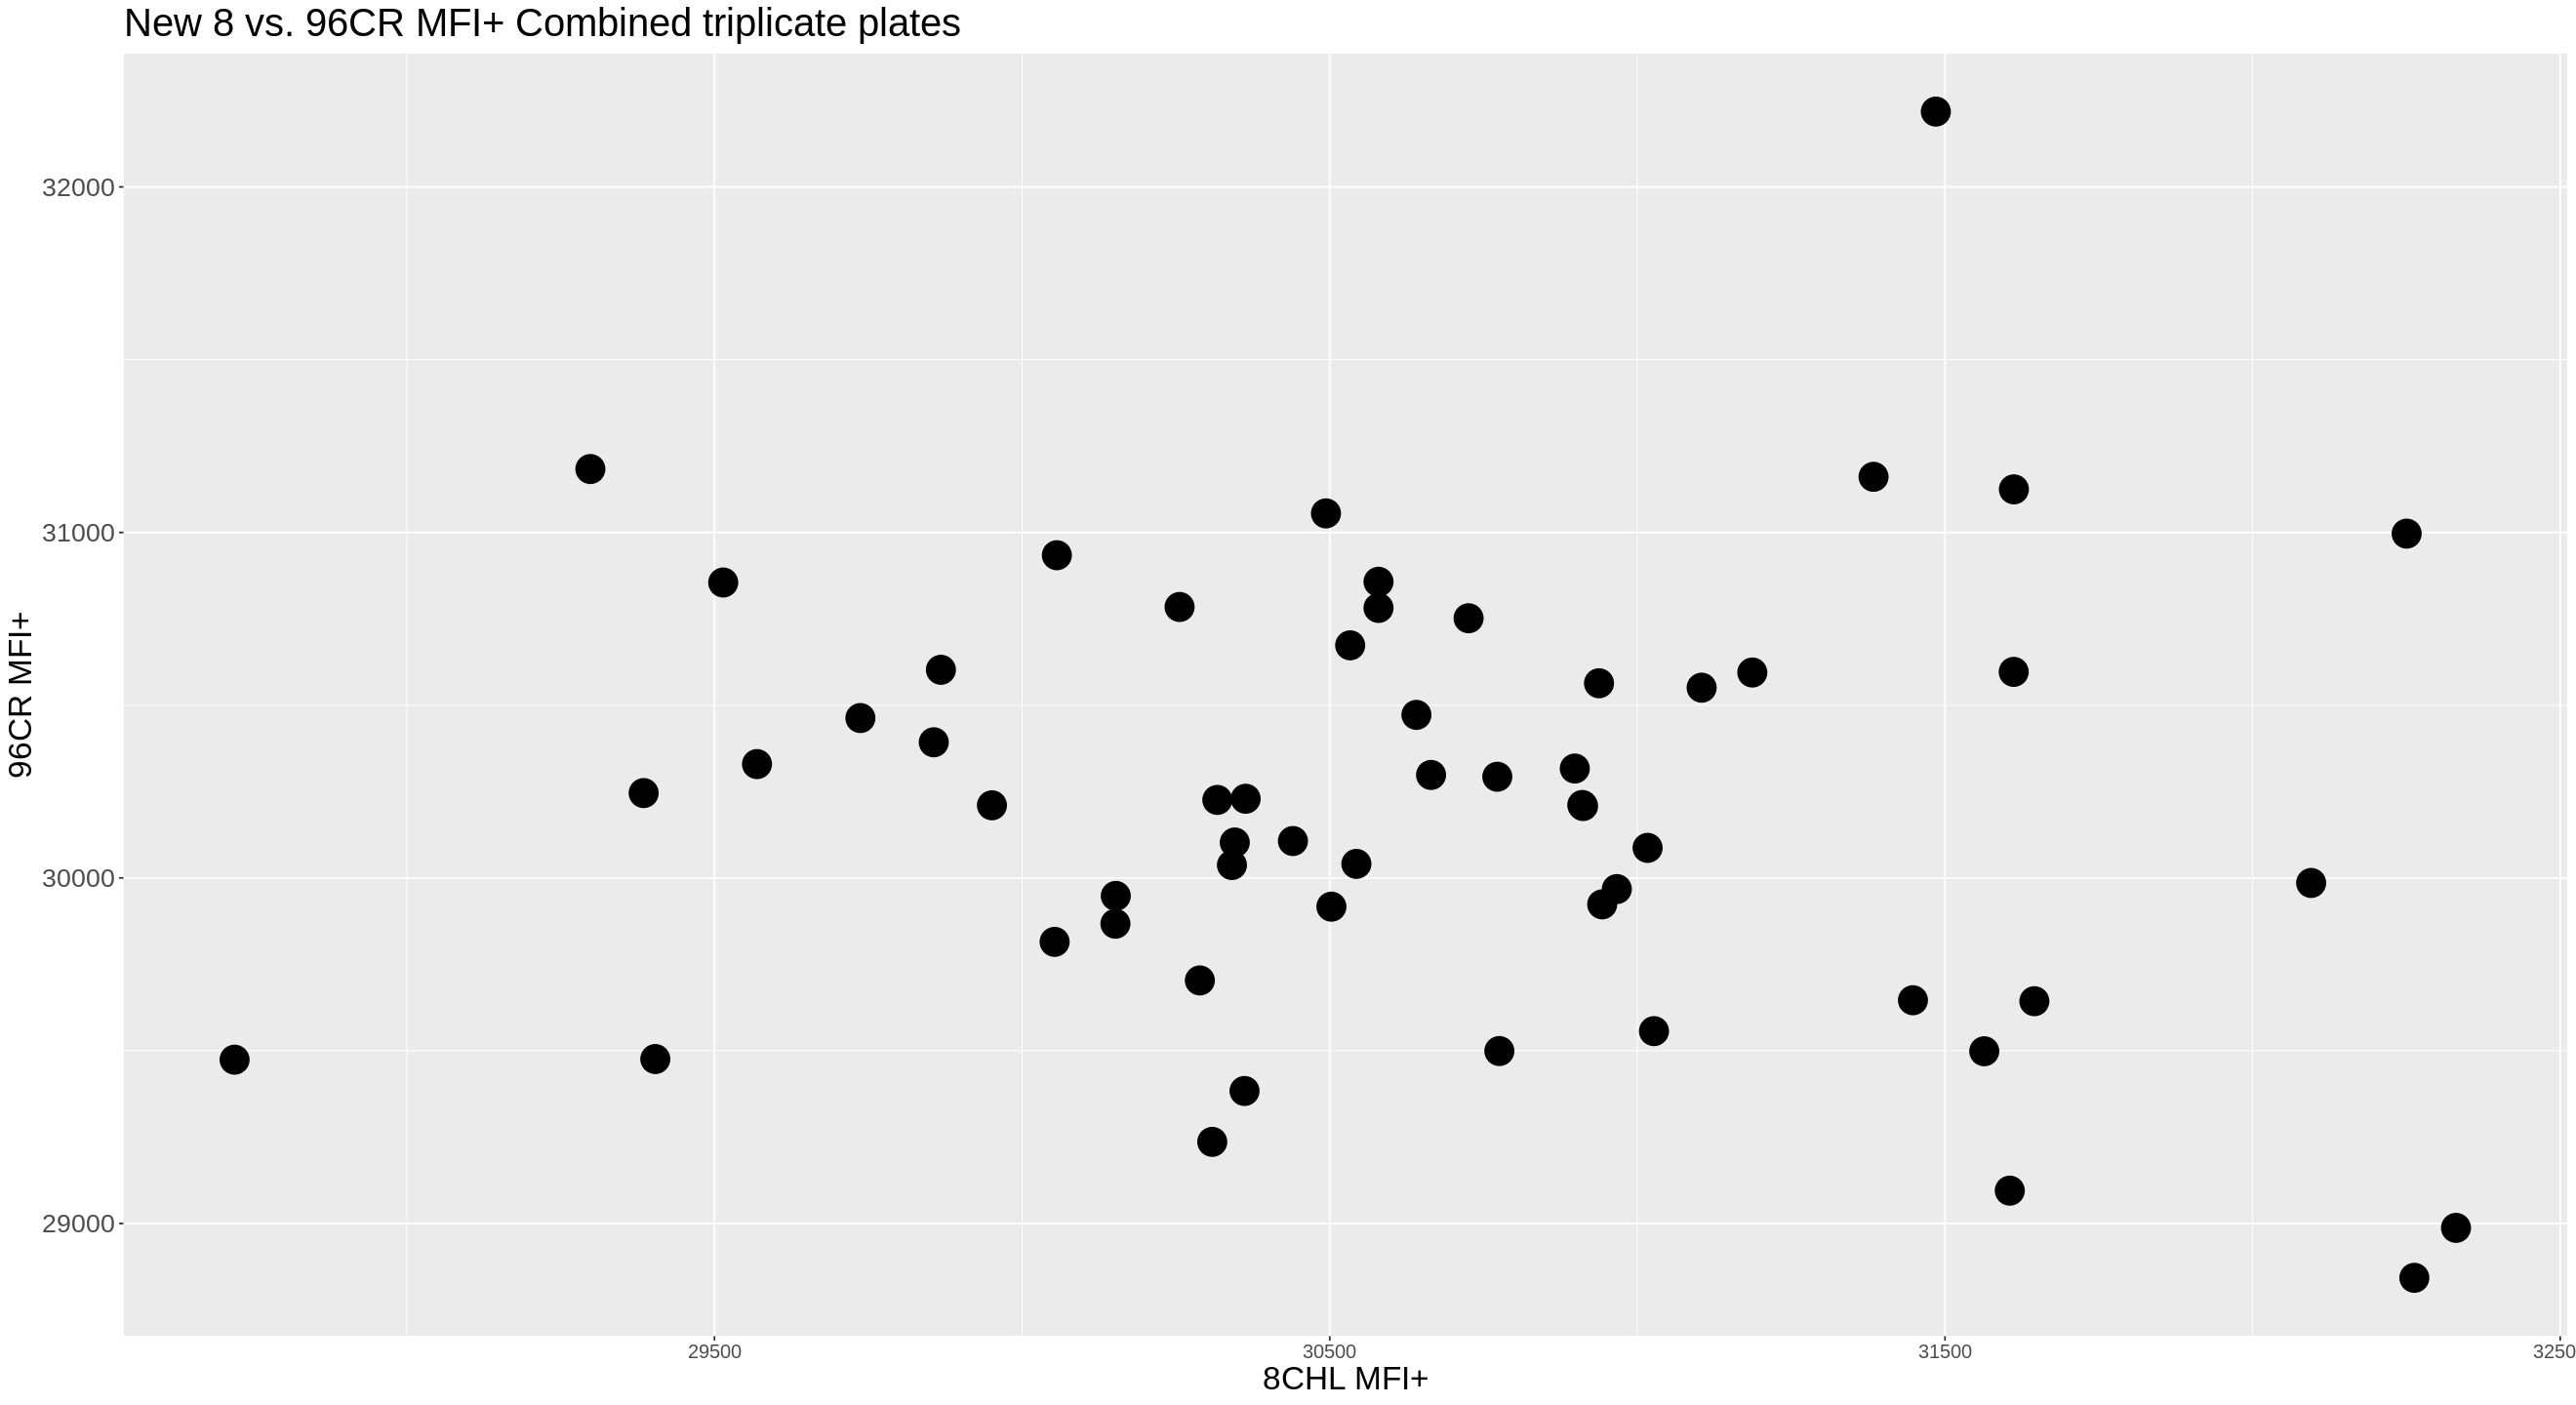

In [120]:
# scatter of MFI+
ggplot(dft) + 
    geom_point(size = 8, aes(x = MFI..x, 
                   y = MFI..y)) + 
    ggtitle("New 8 vs. 96CR MFI+ Combined triplicate plates") + 
    xlab("8CHL MFI+") + 
    ylab("96CR MFI+") + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

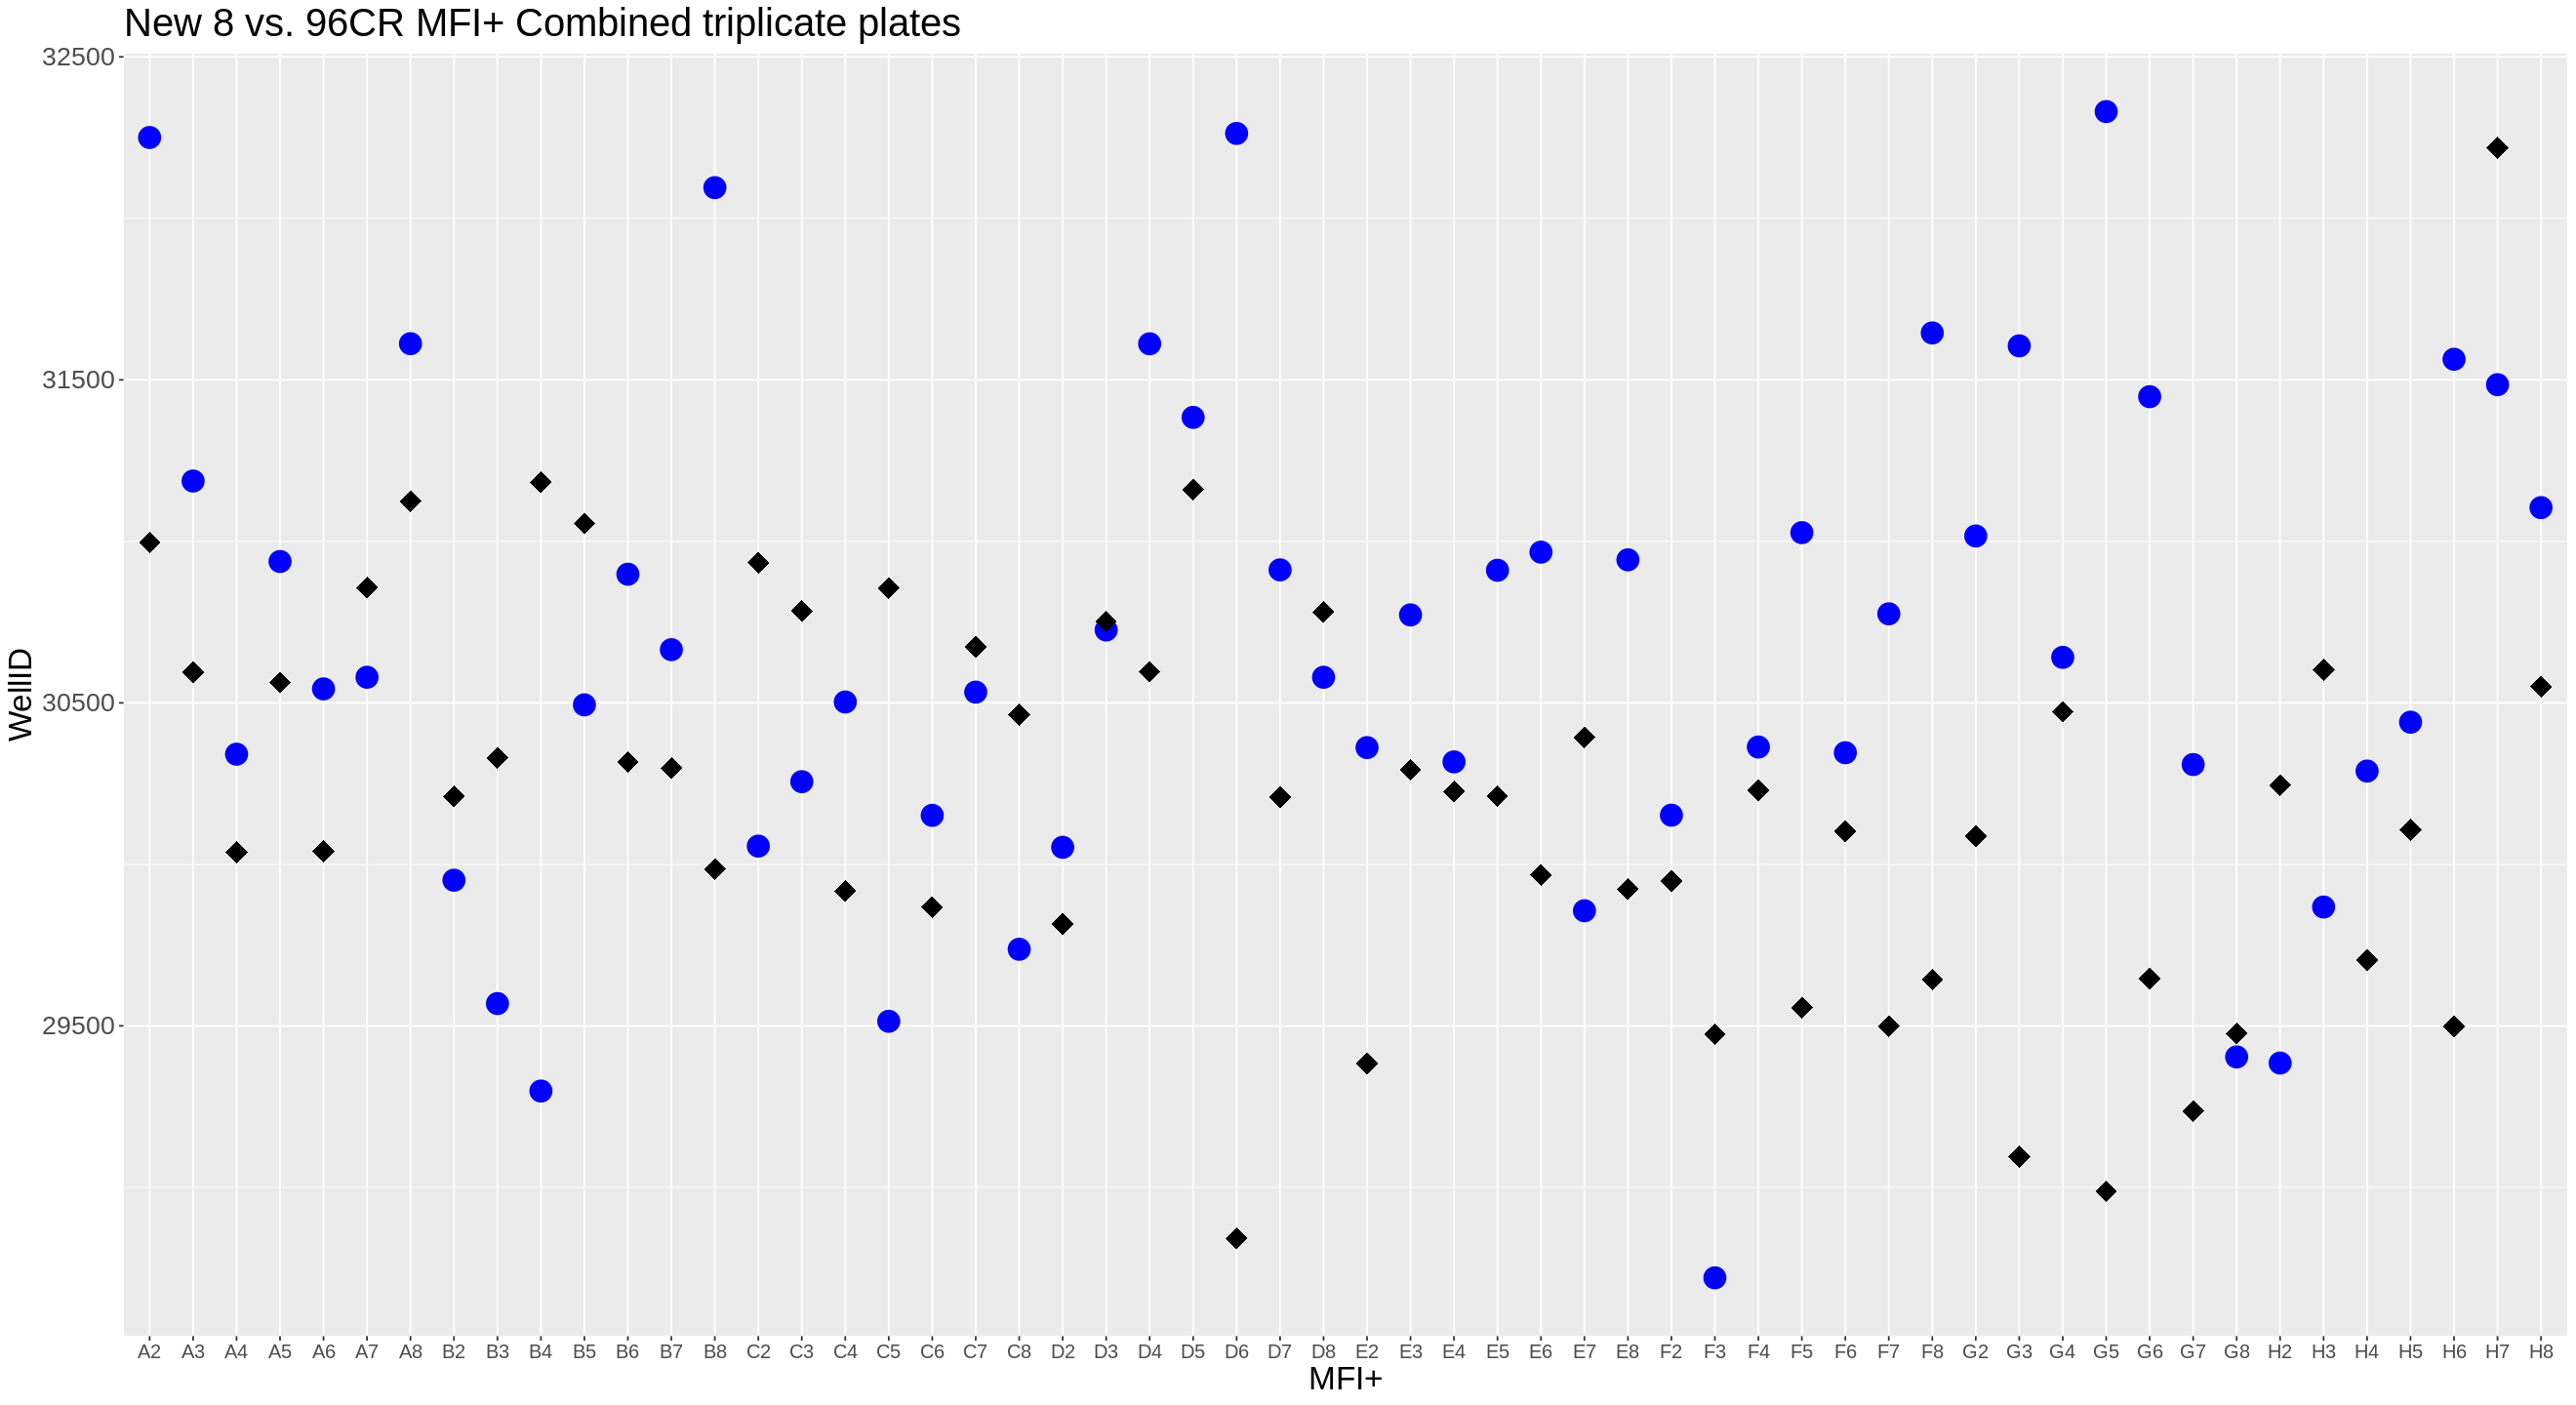

In [128]:
# compare scatter of MFI+
ggplot(dft) + 
    geom_point(size = 6, aes(y = MFI..x, 
                   x = wellid), colour = "blue") + 
    geom_point(size = 6, aes(y = MFI..y, 
                   x = wellid), shape = 18) + 
    ggtitle("New 8 vs. 96CR MFI+ Combined triplicate plates") + 
    xlab("MFI+") + 
    ylab("WellID") + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

In [144]:
dft <- dft %>% mutate(diff = abs(MFI..x - MFI..y))  %>% mutate(pctdiff=diff/max(MFI..x, MFI..y))

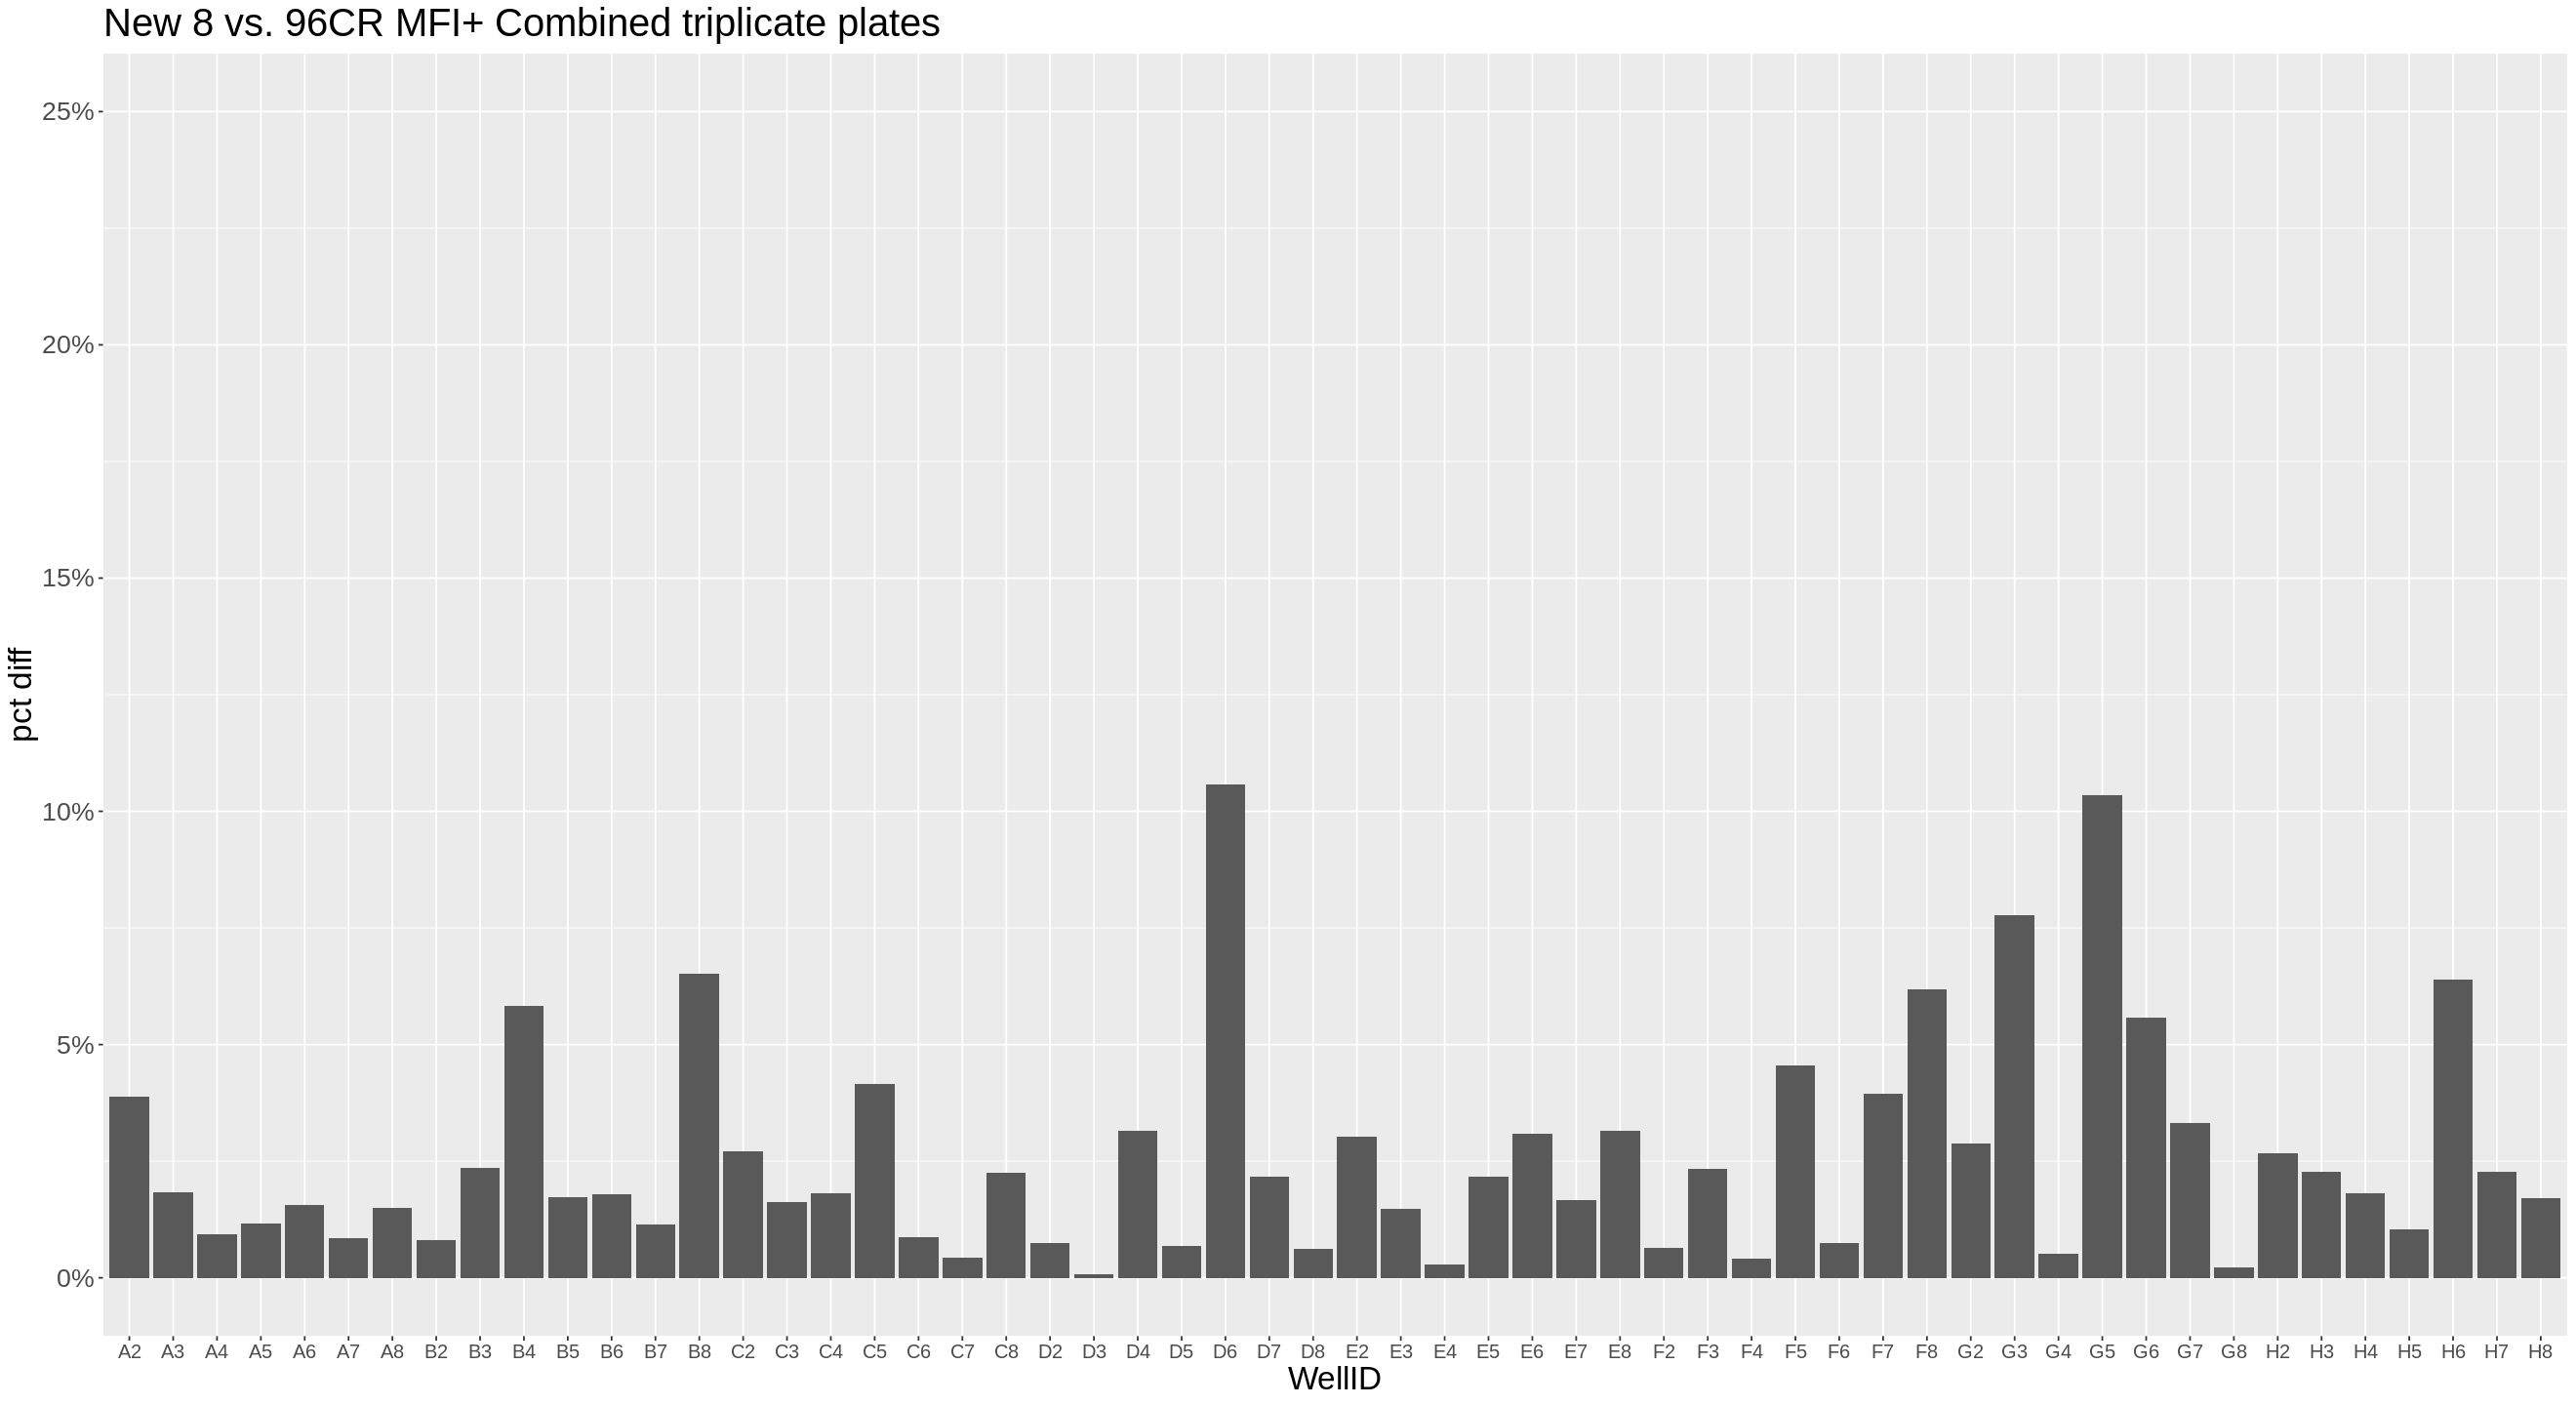

In [154]:
# compare difference scatter of MFI+
ggplot(dft, aes(wellid, pctdiff)) +
    geom_col() + 
#     geom_bar(size = 6, aes(y = MFI..x, 
#                    x = wellid), colour = "blue") + 
    ggtitle("New 8 vs. 96CR MFI+ Combined triplicate plates") + 
    ylab("pct diff") + 
    xlab("WellID") + 
    scale_y_continuous(labels = scales::percent_format(accuracy = 1), limits = c(0,0.25)) +
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

In [121]:
head(dft)

SAMPLE_NAME                 MFI..x   MFI..1.x SI.x     SN.x     method.x
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93    240.8973 467.8717 8CHL    
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15    223.7325 444.5739 8CHL    
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10    201.7459 452.1773 8CHL    
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93    222.9273 448.8274 8CHL    
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59    188.4981 420.7647 8CHL    
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59    202.3096 421.2605 8CHL    
  plate.x wellid MFI..y   MFI..1.y SI.y     SN.y     method.y plate.y
1 PLATE 1 A2     30996.54 69.54    249.7537 445.7369 96CR     PLATE 1
2 PLATE 1 A3     30594.55 69.54    248.8754 439.9561 96CR     PLATE 1
3 PLATE 1 A4     30037.32 65.88    268.4891 455.9398 96CR     PLATE 1
4 PLATE 1 A5     30563.44 70.15    258.8108 435.6870 96CR     PLATE 1
5 PLATE 1 A6     30040.67 68.32    237.3672 439.7054 96CR     PLATE 1
6 PLATE 1 A7     30857.16 68.32    247.9796 451.6563 96CR     PLATE 1

In [83]:
# MFI+ pooled
df_stats <- data.frame()
i = 1
stat <- var.test(MFI. ~ method, dfm)
print(stat)
df_stats[i, "F_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
stat <- wilcox.test(MFI.~method, 
                    dfm,
                    alternative= "two.sided",
                    paired=FALSE, 
                    var.equal=TRUE, 
                    conf.level=0.95)
print(stat)
df_stats[i, "WILCOXON_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_WX"] = stat$p.value > 0.05
stat <- t.test(MFI.~method, 
                    dfm,
                    alternative= "two.sided",
                    paired=FALSE, 
                    var.equal=TRUE, 
                    conf.level=0.95)
print(stat)
df_stats[i, "T_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_TT"] = stat$p.value > 0.05

write.csv(df_stats, paste0("96v8_pooled_stats_3plts_mfi.csv"), row.names = FALSE)


	F test to compare two variances

data:  MFI. by method
F = 0.8037, num df = 167, denom df = 167, p-value = 0.159
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5928019 1.0896398
sample estimates:
ratio of variances 
         0.8037042 


	Wilcoxon rank sum test with continuity correction

data:  MFI. by method
W = 7245.5, p-value = 1.238e-14
alternative hypothesis: true location shift is not equal to 0


	Two Sample t-test

data:  MFI. by method
t = -8.8741, df = 334, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1232.7325  -785.3821
sample estimates:
mean in group 8CHL mean in group 96CR 
          29874.67           30883.73 



In [84]:
# SI pooled
df_stats <- data.frame()
i = 1
stat <- var.test(SI ~ method, dfm)
print(stat)
df_stats[i, "F_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
stat <- wilcox.test(SI~method, 
                    dfm,
                    alternative= "two.sided",
                    paired=FALSE, 
                    var.equal=TRUE, 
                    conf.level=0.95)
print(stat)
df_stats[i, "WILCOXON_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_WX"] = stat$p.value > 0.05
stat <- t.test(SI~method, 
                    dfm,
                    alternative= "two.sided",
                    paired=FALSE, 
                    var.equal=TRUE, 
                    conf.level=0.95)
print(stat)
df_stats[i, "T_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_TT"] = stat$p.value > 0.05

write.csv(df_stats, paste0("96v8_pooled_stats_3plts_si.csv"), row.names = FALSE)


	F test to compare two variances

data:  SI by method
F = 0.67892, num df = 167, denom df = 167, p-value = 0.01275
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5007651 0.9204653
sample estimates:
ratio of variances 
         0.6789233 


	Wilcoxon rank sum test with continuity correction

data:  SI by method
W = 10124, p-value = 7.504e-06
alternative hypothesis: true location shift is not equal to 0


	Two Sample t-test

data:  SI by method
t = -4.8973, df = 334, p-value = 1.516e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -19.306460  -8.241387
sample estimates:
mean in group 8CHL mean in group 96CR 
          209.1177           222.8916 



In [85]:
# MFI+
# per plate basis for pairwise tests
df_stats <- data.frame()
for (i in seq(3)) {
    df.t <- dfm %>% filter(plate == paste("PLATE", i))
    stat <- var.test(MFI. ~ method, df.t)
    print(stat)
    df_stats[i, "F_TEST"] = format(stat$p.value, format = "e", digits = 2)
    df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
    stat <- wilcox.test(MFI.~method, 
                        df.t,
                        alternative= "two.sided",
                        paired=FALSE, 
                        var.equal=TRUE, 
                        conf.level=0.95)
    print(stat)
    df_stats[i, "WILCOXON_TEST"] = format(stat$p.value, format = "e", digits = 2)
    df_stats[i, "GT_A_WX"] = stat$p.value > 0.05
    stat <- t.test(MFI.~method, 
                        df.t,
                        alternative= "two.sided",
                        paired=FALSE, 
                        var.equal=TRUE, 
                        conf.level=0.95)
    print(stat)
    df_stats[i, "T_TEST"] = format(stat$p.value, format = "e", digits = 2)
    df_stats[i, "GT_A_TT"] = stat$p.value > 0.05
}
write.csv(df_stats, paste0("96v8_pair_stats_3plts_mfi.csv"), row.names = FALSE)


	F test to compare two variances

data:  MFI. by method
F = 1.544, num df = 55, denom df = 55, p-value = 0.1102
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.9051208 2.6339221
sample estimates:
ratio of variances 
          1.544026 


	Wilcoxon rank sum test with continuity correction

data:  MFI. by method
W = 2113, p-value = 0.001532
alternative hypothesis: true location shift is not equal to 0


	Two Sample t-test

data:  MFI. by method
t = 3.2876, df = 110, p-value = 0.001357
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 175.4136 707.8445
sample estimates:
mean in group 8CHL mean in group 96CR 
          30656.22           30214.59 


	F test to compare two variances

data:  MFI. by method
F = 0.98759, num df = 55, denom df = 55, p-value = 0.9632
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5789311 1.6847026
sample es

In [99]:
# SI per plate basis for pairwise tests
df_stats <- data.frame()

for (i in seq(3)) {
    df.t <- dfm %>% filter(plate == paste("PLATE", i))
    stat <- var.test(SI ~ method, df.t)
    print(stat)
    df_stats[i, "F_TEST"] = format(stat$p.value, format = "e", digits = 2)
    df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
    stat <- wilcox.test(SI~method, 
                        df.t,
                        alternative= "two.sided",
                        paired=FALSE, 
                        var.equal=TRUE, 
                        conf.level=0.95)
    print(stat)
    df_stats[i, "WILCOXON_TEST"] = format(stat$p.value, format = "e", digits = 2)
    df_stats[i, "GT_A_WX"] = stat$p.value > 0.05
    stat <- t.test(SI~method, 
                        df.t,
                        alternative= "two.sided",
                        paired=FALSE, 
                        var.equal=TRUE, 
                        conf.level=0.95)
    print(stat)
    df_stats[i, "T_TEST"] = format(stat$p.value, format = "e", digits = 2)
    df_stats[i, "GT_A_TT"] = stat$p.value > 0.05
}
write.csv(df_stats, paste0("96v8_pair_stats_3plts_si.csv"), row.names = FALSE)


	F test to compare two variances

data:  SI by method
F = 3.4272, num df = 55, denom df = 55, p-value = 1.012e-05
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.009036 5.846341
sample estimates:
ratio of variances 
          3.427173 


	Wilcoxon rank sum test with continuity correction

data:  SI by method
W = 150, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


	Two Sample t-test

data:  SI by method
t = -11.207, df = 110, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -40.73093 -28.49051
sample estimates:
mean in group 8CHL mean in group 96CR 
          219.0004           253.6111 


	F test to compare two variances

data:  SI by method
F = 1.282, num df = 55, denom df = 55, p-value = 0.3598
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.7514899 2.1868525
sample estimates:

In [97]:
# pooled plates 8 vs 96 SI 

df_stats <- data.frame()
i = 1

stat <- var.test(SI ~ method, dfm)
print(stat)
df_stats[i, "F_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_FT"] = stat$p.value > 0.05
stat <- wilcox.test(SI~method, 
                    dfm,
                    alternative= "two.sided",
                    paired=FALSE, 
                    var.equal=TRUE, 
                    conf.level=0.95)
print(stat)
df_stats[i, "WILCOXON_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_WX"] = stat$p.value > 0.05
stat <- t.test(SI~method, 
                    dfm,
                    alternative= "two.sided",
                    paired=FALSE, 
                    var.equal=TRUE, 
                    conf.level=0.95)
print(stat)
df_stats[i, "T_TEST"] = format(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_TT"] = stat$p.value > 0.05

write.csv(df_stats, paste0("96v8_pooled_stats_3plts_si.csv"), row.names = FALSE)


	F test to compare two variances

data:  SI by method
F = 0.67892, num df = 167, denom df = 167, p-value = 0.01275
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.5007651 0.9204653
sample estimates:
ratio of variances 
         0.6789233 


	Wilcoxon rank sum test with continuity correction

data:  SI by method
W = 10124, p-value = 7.504e-06
alternative hypothesis: true location shift is not equal to 0


	Two Sample t-test

data:  SI by method
t = -4.8973, df = 334, p-value = 1.516e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -19.306460  -8.241387
sample estimates:
mean in group 8CHL mean in group 96CR 
          209.1177           222.8916 



In [86]:
# MFI+
# generate stats table pooled 8 vs 96
df_stats <- data.frame()
i = 1
stat <- ad.test(dfm$MFI.)
df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_AD"] = stat$p.value > 0.05
stat <- shapiro.test(dfm$MFI.)
df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_SHAP"] = stat$p.value > 0.05
print(stat)
stat <- bonett.test(dfm$MFI.)
df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_BONN"] = stat$p.value > 0.05
print(stat)
stat <- geary(dfm$MFI.)
df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
df_stats[i, "GT_A_GEAR"] = stat > 0.05
print(stat)
print(paste0(rep("-", 25),collapse=""))

write.csv(df_stats, paste0("96v8_stats2_pooled_3plts_mfi.csv"), row.names = FALSE)


	Shapiro-Wilk normality test

data:  dfm$MFI.
W = 0.98627, p-value = 0.002802


	Bonett-Seier test for Geary kurtosis

data:  dfm$MFI.
tau = 907.1312, z = 1.0968, p-value = 0.2727
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] 0.7853511
[1] "-------------------------"


In [72]:
# generate stats table pooled 8 vs 96
df_stats <- data.frame()
i = 1
stat <- ad.test(dfm$SI)
df_stats[i, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_AD"] = stat$p.value > 0.05
stat <- shapiro.test(dfm$SI)
df_stats[i, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_SHAP"] = stat$p.value > 0.05
print(stat)
stat <- bonett.test(dfm$SI)
df_stats[i, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
df_stats[i, "GT_A_BONN"] = stat$p.value > 0.05
print(stat)
stat <- geary(dfm$SI)
df_stats[i, "GEARY"] = formatC(stat, format = "e", digits = 2)
df_stats[i, "GT_A_GEAR"] = stat > 0.05
print(stat)
print(paste0(rep("-", 25),collapse=""))

write.csv(df_stats, paste0("96v8_stats2_pooled_3plts_si.csv"), row.names = FALSE)


	Shapiro-Wilk normality test

data:  dfm$SI
W = 0.99431, p-value = 0.2446


	Bonett-Seier test for Geary kurtosis

data:  dfm$SI
tau = 21.254347, z = -0.076508, p-value = 0.939
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] 0.7988156
[1] "-------------------------"


In [87]:
#MFI + (separate plates)
reagents <- "BV-421" 
df_stats <- data.frame()

for (i in seq(3)) {
        plt = paste("PLATE", i)
        df_stats[i, "PLATE"] = plt 
        df_stats[i, "REAGENT"] = reagents
        
        df8 <- dfm %>% 
            filter(method == "8CHL" & plate == plt)
        df96 <- dfm %>% 
            filter(method == "96CR" & plate == plt)
    
        df_stats[i, "MEAN.8CHL"] = formatC(mean(df8$MFI.), format = "e", digits = 2)
        df_stats[i, "MEAN.96CR"] = formatC(mean(df96$MFI.), format = "e", digits = 2)
        df_stats[i, "MIN.8CHL"] = formatC(min(df8$MFI.), format = "e", digits = 2)
        df_stats[i, "MIN.96CR"] = formatC(min(df96$MFI.), format = "e", digits = 2)
        df_stats[i, "MAX.8CHL"] = formatC(max(df8$MFI.), format = "e", digits = 2)
        df_stats[i, "MAX.96CR"] = formatC(max(df96$MFI.), format = "e", digits = 2)
        df_stats[i, "SD.8CHL"] = formatC(sd(df8$MFI.), format = "e", digits = 2)
        df_stats[i, "SD.96CR"] = formatC(sd(df96$MFI.), format = "e", digits = 2)
        pctdiff = abs( mean(df8$MFI.) - mean(df96$MFI.)) / (mean( mean(df8$MFI.), mean(df96$MFI.))/2)
        #print(pctdiff)
        df_stats[i, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
        df_stats[i, "CV.8CHL"] = formatC(sd(df8$MFI.)/mean(df8$MFI.), format = "e", digits = 2)
        df_stats[i, "CV.96CR"] = formatC(sd(df96$MFI.)/mean(df96$MFI.), format = "e", digits = 2)
}
write.csv(df_stats, paste0("96v8_pair_stats_mfi_3plts.csv"), row.names = FALSE)

In [123]:
reagents <- "BV-421" 
df_stats <- data.frame()

for (i in seq(3)) {
        plt = paste("PLATE", i)
        df_stats[i, "PLATE"] = plt 
        df_stats[i, "REAGENT"] = reagents
        
        df8 <- dfm %>% 
            filter(method == "8CHL" & plate == plt)
        df96 <- dfm %>% 
            filter(method == "96CR" & plate == plt)
    
        df_stats[i, "MEAN.8CHL"] = formatC(mean(df8$SI), format = "e", digits = 2)
        df_stats[i, "MEAN.96CR"] = formatC(mean(df96$SI), format = "e", digits = 2)
        df_stats[i, "MIN.8CHL"] = formatC(min(df8$SI), format = "e", digits = 2)
        df_stats[i, "MIN.96CR"] = formatC(min(df96$SI), format = "e", digits = 2)
        df_stats[i, "MAX.8CHL"] = formatC(max(df8$SI), format = "e", digits = 2)
        df_stats[i, "MAX.96CR"] = formatC(max(df96$SI), format = "e", digits = 2)
        df_stats[i, "SD.8CHL"] = formatC(sd(df8$SI), format = "e", digits = 2)
        df_stats[i, "SD.96CR"] = formatC(sd(df96$SI), format = "e", digits = 2)
        pctdiff = abs( mean(df8$SI) - mean(df96$SI)) / (mean( mean(df8$SI), mean(df96$SI))/2)
        #print(pctdiff)
        df_stats[i, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
        df_stats[i, "CV.8CHL"] = formatC(sd(df8$SI)/mean(df8$SI), format = "e", digits = 2)
        df_stats[i, "CV.96CR"] = formatC(sd(df96$SI)/mean(df96$SI), format = "e", digits = 2)
}
write.csv(df_stats, paste0("96v8_pair_stats_si_3plts.csv"), row.names = FALSE)

In [10]:
# MFI + 
reagents <- "BV-421" 
i = 1
df_stats <- data.frame()

df_stats[i, "REAGENT"] = reagents

df8 <- dfm %>% 
    filter(method == "8CHL" )
df96 <- dfm %>% 
    filter(method == "96CR" )

df_stats[i, "MEAN.8CHL"] = formatC(mean(df8$MFI.), format = "e", digits = 2)
df_stats[i, "MEAN.96CR"] = formatC(mean(df96$MFI.), format = "e", digits = 2)
df_stats[i, "MIN.8CHL"] = formatC(min(df8$MFI.), format = "e", digits = 2)
df_stats[i, "MIN.96CR"] = formatC(min(df96$MFI.), format = "e", digits = 2)
df_stats[i, "MAX.8CHL"] = formatC(max(df8$MFI.), format = "e", digits = 2)
df_stats[i, "MAX.96CR"] = formatC(max(df96$MFI.), format = "e", digits = 2)
df_stats[i, "SD.8CHL"] = formatC(sd(df8$MFI.), format = "e", digits = 2)
df_stats[i, "SD.96CR"] = formatC(sd(df96$MFI.), format = "e", digits = 2)
pctdiff = abs( mean(df8$MFI.) - mean(df96$MFI.)) / (mean( mean(df8$MFI.), mean(df96$MFI.))/2)
#print(pctdiff)
df_stats[i, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
df_stats[i, "CV.8CHL"] = formatC(sd(df8$MFI.)/mean(df8$MFI.), format = "e", digits = 2)
df_stats[i, "CV.96CR"] = formatC(sd(df96$MFI.)/mean(df96$MFI.), format = "e", digits = 2)

#write.csv(df_stats, paste0("96v8_pooled_stats_mfi_3plts.csv"), row.names = FALSE)

In [12]:
df8

SAMPLE_NAME                 MFI.     MFI..1   SI       SN       method
1   Specimen_001_A2_A02_002.fcs 32250.40 68.930   240.8973 467.8717 8CHL  
2   Specimen_001_A3_A03_003.fcs 31186.86 70.150   223.7325 444.5739 8CHL  
3   Specimen_001_A4_A04_004.fcs 30341.10 67.100   201.7459 452.1773 8CHL  
4   Specimen_001_A5_A05_005.fcs 30937.68 68.930   222.9273 448.8274 8CHL  
5   Specimen_001_A6_A06_006.fcs 30543.31 72.590   188.4981 420.7647 8CHL  
6   Specimen_001_A7_A07_007.fcs 30579.30 72.590   202.3096 421.2605 8CHL  
7   Specimen_001_A8_A08_008.fcs 31612.03 73.200   221.9013 431.8583 8CHL  
8   Specimen_001_B2_B02_014.fcs 29951.00 63.440   247.4545 472.1154 8CHL  
9   Specimen_001_B3_B03_015.fcs 29569.14 66.490   213.0617 444.7156 8CHL  
10  Specimen_001_B4_B04_016.fcs 29298.30 65.880   216.7894 444.7222 8CHL  
11  Specimen_001_B5_B05_017.fcs 30493.90 67.100   211.3559 454.4546 8CHL  
12  Specimen_001_B6_B06_018.fcs 30898.33 70.760   215.0510 436.6638 8CHL  
13  Specimen_001_B7_B07_019.fcs 30664.70 73.200   205.3432 418.9167 8CHL  
14  Specimen_001_B8_B08_020.fcs 32095.15 69.540   208.8339 461.5351 8CHL  
15  Specimen_001_C2_C02_026.fcs 30056.53 67.100   229.7337 447.9364 8CHL  
16  Specimen_001_C3_C03_027.fcs 30256.00 66.490   212.1434 455.0459 8CHL  
17  Specimen_001_C4_C04_028.fcs 30502.75 66.490   227.8333 458.7569 8CHL  
18  Specimen_001_C5_C05_029.fcs 29514.24 67.710   197.8402 435.8919 8CHL  
19  Specimen_001_C6_C06_030.fcs 30151.69 71.370   208.9492 422.4701 8CHL  
20  Specimen_001_C7_C07_031.fcs 30533.25 66.490   214.3584 459.2156 8CHL  
21  Specimen_001_C8_C08_032.fcs 29737.20 79.910   141.7449 372.1336 8CHL  
22  Specimen_001_D2_D02_038.fcs 30052.87 66.185   224.4680 454.0737 8CHL  
23  Specimen_001_D3_D03_039.fcs 30725.70 64.965   226.3952 472.9577 8CHL  
24  Specimen_001_D4_D04_040.fcs 31611.73 70.150   216.3494 450.6304 8CHL  
25  Specimen_001_D5_D05_041.fcs 31383.89 68.625   214.2283 457.3245 8CHL  
26  Specimen_001_D6_D06_042.fcs 32262.90 66.490   222.0120 485.2294 8CHL  
27  Specimen_001_D7_D07_043.fcs 30911.75 71.980   210.6542 429.4491 8CHL  
28  Specimen_001_D8_D08_044.fcs 30579.30 75.640   174.8462 404.2742 8CHL  
29  Specimen_001_E2_E02_050.fcs 30361.53 66.490   225.7455 456.6330 8CHL  
30  Specimen_001_E3_E03_051.fcs 30772.37 67.710   231.9608 454.4730 8CHL  
⋮   ⋮                           ⋮        ⋮        ⋮        ⋮        ⋮     
139 Specimen_001_D7_D07_043.fcs 29537.4  69.60001 218.0431 424.3879 8CHL  
140 Specimen_001_D8_D08_044.fcs 29952.9  63.00000 210.5668 475.4429 8CHL  
141 Specimen_001_E2_E02_050.fcs 29928.3  62.40000 233.6925 479.6202 8CHL  
142 Specimen_001_E3_E03_051.fcs 28138.8  62.40000 222.8286 450.9423 8CHL  
143 Specimen_001_E4_E04_052.fcs 29801.4  63.30000 229.6705 470.7962 8CHL  
144 Specimen_001_E5_E05_053.fcs 28438.2  62.40000 228.9703 455.7404 8CHL  
145 Specimen_001_E6_E06_054.fcs 29576.4  66.30000 225.6124 446.0995 8CHL  
146 Specimen_001_E7_E07_055.fcs 28947.6  65.40000 214.8973 442.6239 8CHL  
147 Specimen_001_E8_E08_056.fcs 28983.3  73.80000 183.2034 392.7276 8CHL  
148 Specimen_001_F2_F02_062.fcs 28789.8  64.80000 219.3794 444.2870 8CHL  
149 Specimen_001_F3_F03_063.fcs 29358.6  67.80000 229.6112 433.0177 8CHL  
150 Specimen_001_F4_F04_064.fcs 30349.8  64.80000 219.0998 468.3611 8CHL  
151 Specimen_001_F5_F05_065.fcs 28776.6  64.20000 212.6844 448.2336 8CHL  
152 Specimen_001_F6_F06_066.fcs 29773.2  66.00000 223.0270 451.1091 8CHL  
153 Specimen_001_F7_F07_067.fcs 29379.6  67.20000 214.4628 437.1964 8CHL  
154 Specimen_001_F8_F08_068.fcs 28367.4  70.80000 198.5720 400.6695 8CHL  
155 Specimen_001_G2_G02_074.fcs 29134.8  66.00000 216.2087 441.4364 8CHL  
156 Specimen_001_G3_G03_075.fcs 29470.8  66.00000 211.2414 446.5273 8CHL  
157 Specimen_001_G4_G04_076.fcs 29269.2  63.60000 223.9446 460.2075 8CHL  
158 Specimen_001_G5_G05_077.fcs 28653.6  65.40000 207.1609 438.1285 8CHL  
159 Specimen_001_G6_G06_078.fcs 28650.0  66.60001 218.8579 430.1802 8CHL  
160 Specimen_001_G7_G07_079.f

In [71]:
reagents <- "BV-421" 
i = 1
df_stats <- data.frame()

df_stats[i, "REAGENT"] = reagents

df8 <- dfm %>% 
    filter(method == "8CHL" )
df96 <- dfm %>% 
    filter(method == "96CR" )

df_stats[i, "MEAN.8CHL"] = formatC(mean(df8$SI), format = "e", digits = 2)
df_stats[i, "MEAN.96CR"] = formatC(mean(df96$SI), format = "e", digits = 2)
df_stats[i, "MIN.8CHL"] = formatC(min(df8$SI), format = "e", digits = 2)
df_stats[i, "MIN.96CR"] = formatC(min(df96$SI), format = "e", digits = 2)
df_stats[i, "MAX.8CHL"] = formatC(max(df8$SI), format = "e", digits = 2)
df_stats[i, "MAX.96CR"] = formatC(max(df96$SI), format = "e", digits = 2)
df_stats[i, "SD.8CHL"] = formatC(sd(df8$SI), format = "e", digits = 2)
df_stats[i, "SD.96CR"] = formatC(sd(df96$SI), format = "e", digits = 2)
pctdiff = abs( mean(df8$SI) - mean(df96$SI)) / (mean( mean(df8$SI), mean(df96$SI))/2)
#print(pctdiff)
df_stats[i, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
df_stats[i, "CV.8CHL"] = formatC(sd(df8$SI)/mean(df8$SI), format = "e", digits = 2)
df_stats[i, "CV.96CR"] = formatC(sd(df96$SI)/mean(df96$SI), format = "e", digits = 2)

write.csv(df_stats, paste0("96v8_pooled_stats_si_3plts.csv"), row.names = FALSE)

In [89]:
df_stats

REAGENT MEAN.8CHL MEAN.96CR MIN.8CHL MIN.96CR MAX.8CHL MAX.96CR SD.8CHL 
1 BV-421  2.99e+04  3.09e+04  2.77e+04 2.84e+04 3.23e+04 3.34e+04 9.84e+02
  SD.96CR  PCT.DIFF CV.8CHL  CV.96CR 
1 1.10e+03 6.76%    3.29e-02 3.55e-02

### Find Outliers using Tietjen Moore Test
- detect multiple outliers in a univariate data set that follows an approximately normal distribution
- If there are no outliers in the data, the test statistic is close to 1. If there are outliers in the data, the test statistic will be closer to zero

In [125]:
# pairwise plate  
for (i in seq(3)) {
    df.t <- dfm %>% filter(plate == paste("PLATE", i)  & method == "8CHL") %>% select(SI) %>% pull()
    print('8CHL')
    print(FindOutliersTietjenMooreTest(df.t,2))
    df.t <- dfm %>% filter(plate == paste("PLATE", i)  & method == "96CR") %>% select(SI) %>% pull()
    print('96CR')
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

[1] "8CHL"
$T
[1] 0.5655803

$Talpha
       5% 
0.7085232 

[1] "96CR"
$T
[1] 0.7275309

$Talpha
       5% 
0.7092176 

[1] "8CHL"
$T
[1] 0.7235501

$Talpha
       5% 
0.7095418 

[1] "96CR"
$T
[1] 0.7818044

$Talpha
       5% 
0.7080827 

[1] "8CHL"
$T
[1] 0.7021006

$Talpha
       5% 
0.7076503 

[1] "96CR"
$T
[1] 0.8185251

$Talpha
       5% 
0.7074779 



In [91]:
# add 'column' column
dfm <- dfm %>% mutate(column = substr(wellid, 2,2),
                      group = paste0(wellid,'_', plate))
head(dfm)

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method plate  
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93  240.8973 467.8717 8CHL   PLATE 1
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15  223.7325 444.5739 8CHL   PLATE 1
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10  201.7459 452.1773 8CHL   PLATE 1
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93  222.9273 448.8274 8CHL   PLATE 1
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59  188.4981 420.7647 8CHL   PLATE 1
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59  202.3096 421.2605 8CHL   PLATE 1
  wellid column group     
1 A2     2      A2_PLATE 1
2 A3     3      A3_PLATE 1
3 A4     4      A4_PLATE 1
4 A5     5      A5_PLATE 1
5 A6     6      A6_PLATE 1
6 A7     7      A7_PLATE 1

In [39]:
# linear regression  SI
df8 <- dfm %>% filter(method == "8CHL")
df96 <- dfm %>% filter(method == "96CR")
dfm.t <-inner_join(x = df8, y = df96, by = "group") %>% 
            distinct(SI.x,.keep_all = T)
reg <- lm(SI.y~SI.x,data=dfm.t) 
dfm.t <- dfm.t %>% mutate(regline = reg[[1]][2]*SI.x + reg[[1]][1])
summary(reg)


Call:
lm(formula = SI.y ~ SI.x, data = dfm.t)

Residuals:
    Min      1Q  Median      3Q     Max 
-69.490 -17.488   0.111  20.795  53.304 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 144.20481   18.84156   7.654 1.52e-12 ***
SI.x          0.37628    0.08955   4.202 4.32e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.83 on 166 degrees of freedom
Multiple R-squared:  0.09613,	Adjusted R-squared:  0.09068 
F-statistic: 17.65 on 1 and 166 DF,  p-value: 4.316e-05


In [92]:
# linear regression MFI+ 
df8 <- dfm %>% filter(method == "8CHL")
df96 <- dfm %>% filter(method == "96CR")
dfm.t <-inner_join(x = df8, y = df96, by = "group") %>% 
            distinct(MFI..x,.keep_all = T)
reg <- lm(MFI..y~MFI..x,data=dfm.t) 
dfm.t <- dfm.t %>% mutate(regline = reg[[1]][2]*MFI..x + reg[[1]][1])
summary(reg)


Call:
lm(formula = MFI..y ~ MFI..x, data = dfm.t)

Residuals:
    Min      1Q  Median      3Q     Max 
-2526.8  -809.2  -248.3   773.0  2526.1 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.142e+04  2.623e+03  11.983   <2e-16 ***
MFI..x      -1.835e-02  8.776e-02  -0.209    0.835    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1108 on 163 degrees of freedom
Multiple R-squared:  0.0002681,	Adjusted R-squared:  -0.005865 
F-statistic: 0.0437 on 1 and 163 DF,  p-value: 0.8347


In [93]:
head(dfm.t)

SAMPLE_NAME.x               MFI..x   MFI..1.x SI.x     SN.x     method.x
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93    240.8973 467.8717 8CHL    
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15    223.7325 444.5739 8CHL    
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10    201.7459 452.1773 8CHL    
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93    222.9273 448.8274 8CHL    
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59    188.4981 420.7647 8CHL    
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59    202.3096 421.2605 8CHL    
  plate.x wellid.x column.x group      SAMPLE_NAME.y               MFI..y  
1 PLATE 1 A2       2        A2_PLATE 1 Specimen_001_A2_A02_002.fcs 30996.54
2 PLATE 1 A3       3        A3_PLATE 1 Specimen_001_A3_A03_003.fcs 30594.55
3 PLATE 1 A4       4        A4_PLATE 1 Specimen_001_A4_A04_004.fcs 30037.32
4 PLATE 1 A5       5        A5_PLATE 1 Specimen_001_A5_A05_005.fcs 30563.44
5 PLATE 1 A6       6        A6_PLATE 1 Specimen_001_A6_A06_006.fcs 30040.67
6 PLATE 1 A7       7        A7_PLATE 1 Specimen_001_A7_A07_007.fcs 30857.16
  MFI..1.y SI.y     SN.y     method.y plate.y wellid.y column.y regline 
1 69.54    249.7537 445.7369 96CR     PLATE 1 A2       2        30832.98
2 69.54    248.8754 439.9561 96CR     PLATE 1 A3       3        30852.49
3 65.88    268.4891 455.9398 96CR     PLATE 1 A4       4        30868.01
4 70.15    258.8108 435.6870 96CR     PLATE 1 A5       5        30857.07
5 68.32    237.3672 439.7054 96CR     PLATE 1 A6       6        30864.30
6 68.32    247.9796 451.6563 96CR     PLATE 1 A7       7        30863.64

In [94]:
options(repr.plot.width=28, repr.plot.height=8)

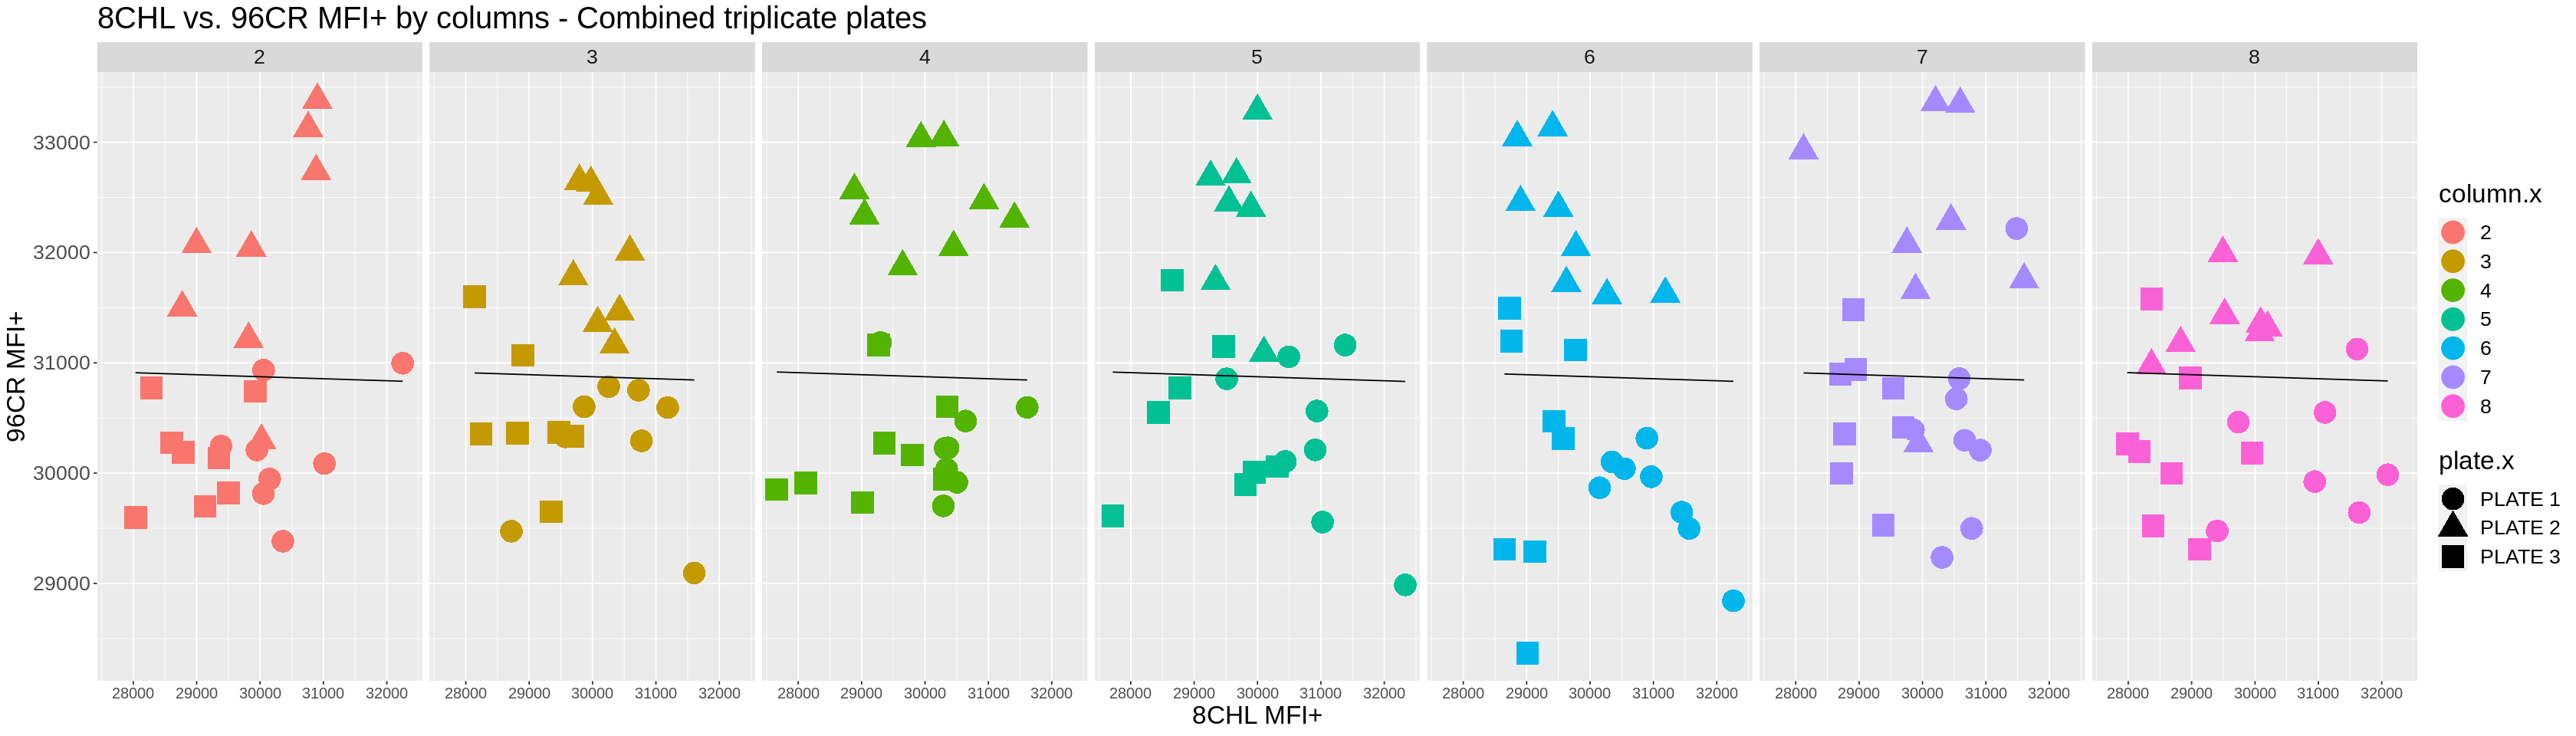

In [96]:
# MFI+
ggplot(dfm.t) + 
    geom_point(size = 8, aes(x = MFI..x, 
                   y = MFI..y, 
                   color=column.x,
                   shape=plate.x)) + 
    geom_line(aes(x = MFI..x, 
                  y = regline)) + 
    ggtitle("8CHL vs. 96CR MFI+ by columns - Combined triplicate plates") + 
    xlab("8CHL MFI+") + 
    ylab("96CR MFI+") + 
    facet_wrap(~column.x, ncol = 7) + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

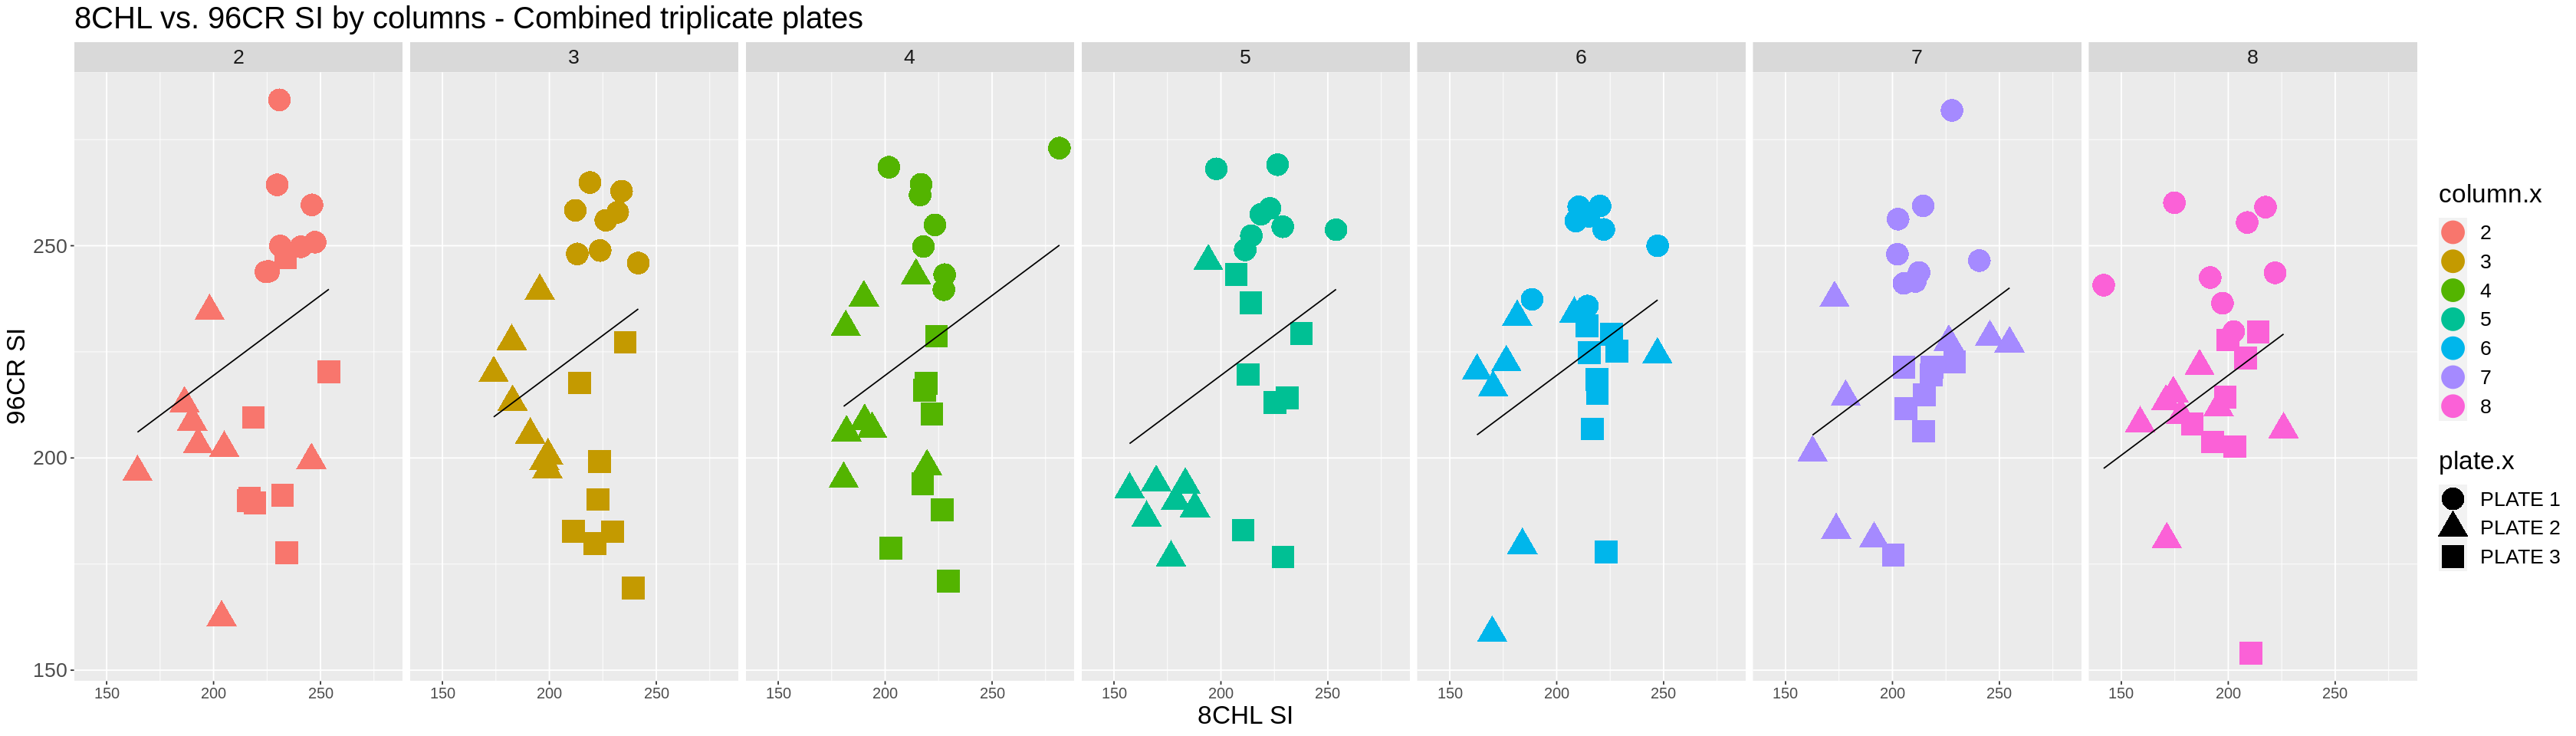

In [54]:
# SI
ggplot(dfm.t) + 
    geom_point(size = 8, aes(x = SI.x, 
                   y = SI.y, 
                   color=column.x,
                   shape=plate.x)) + 
    geom_line(aes(x = SI.x, 
                  y = regline)) + 
    ggtitle("8CHL vs. 96CR SI by columns - Combined triplicate plates") + 
    xlab("8CHL SI") + 
    ylab("96CR SI") + 
    facet_wrap(~column.x, ncol = 7) + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 


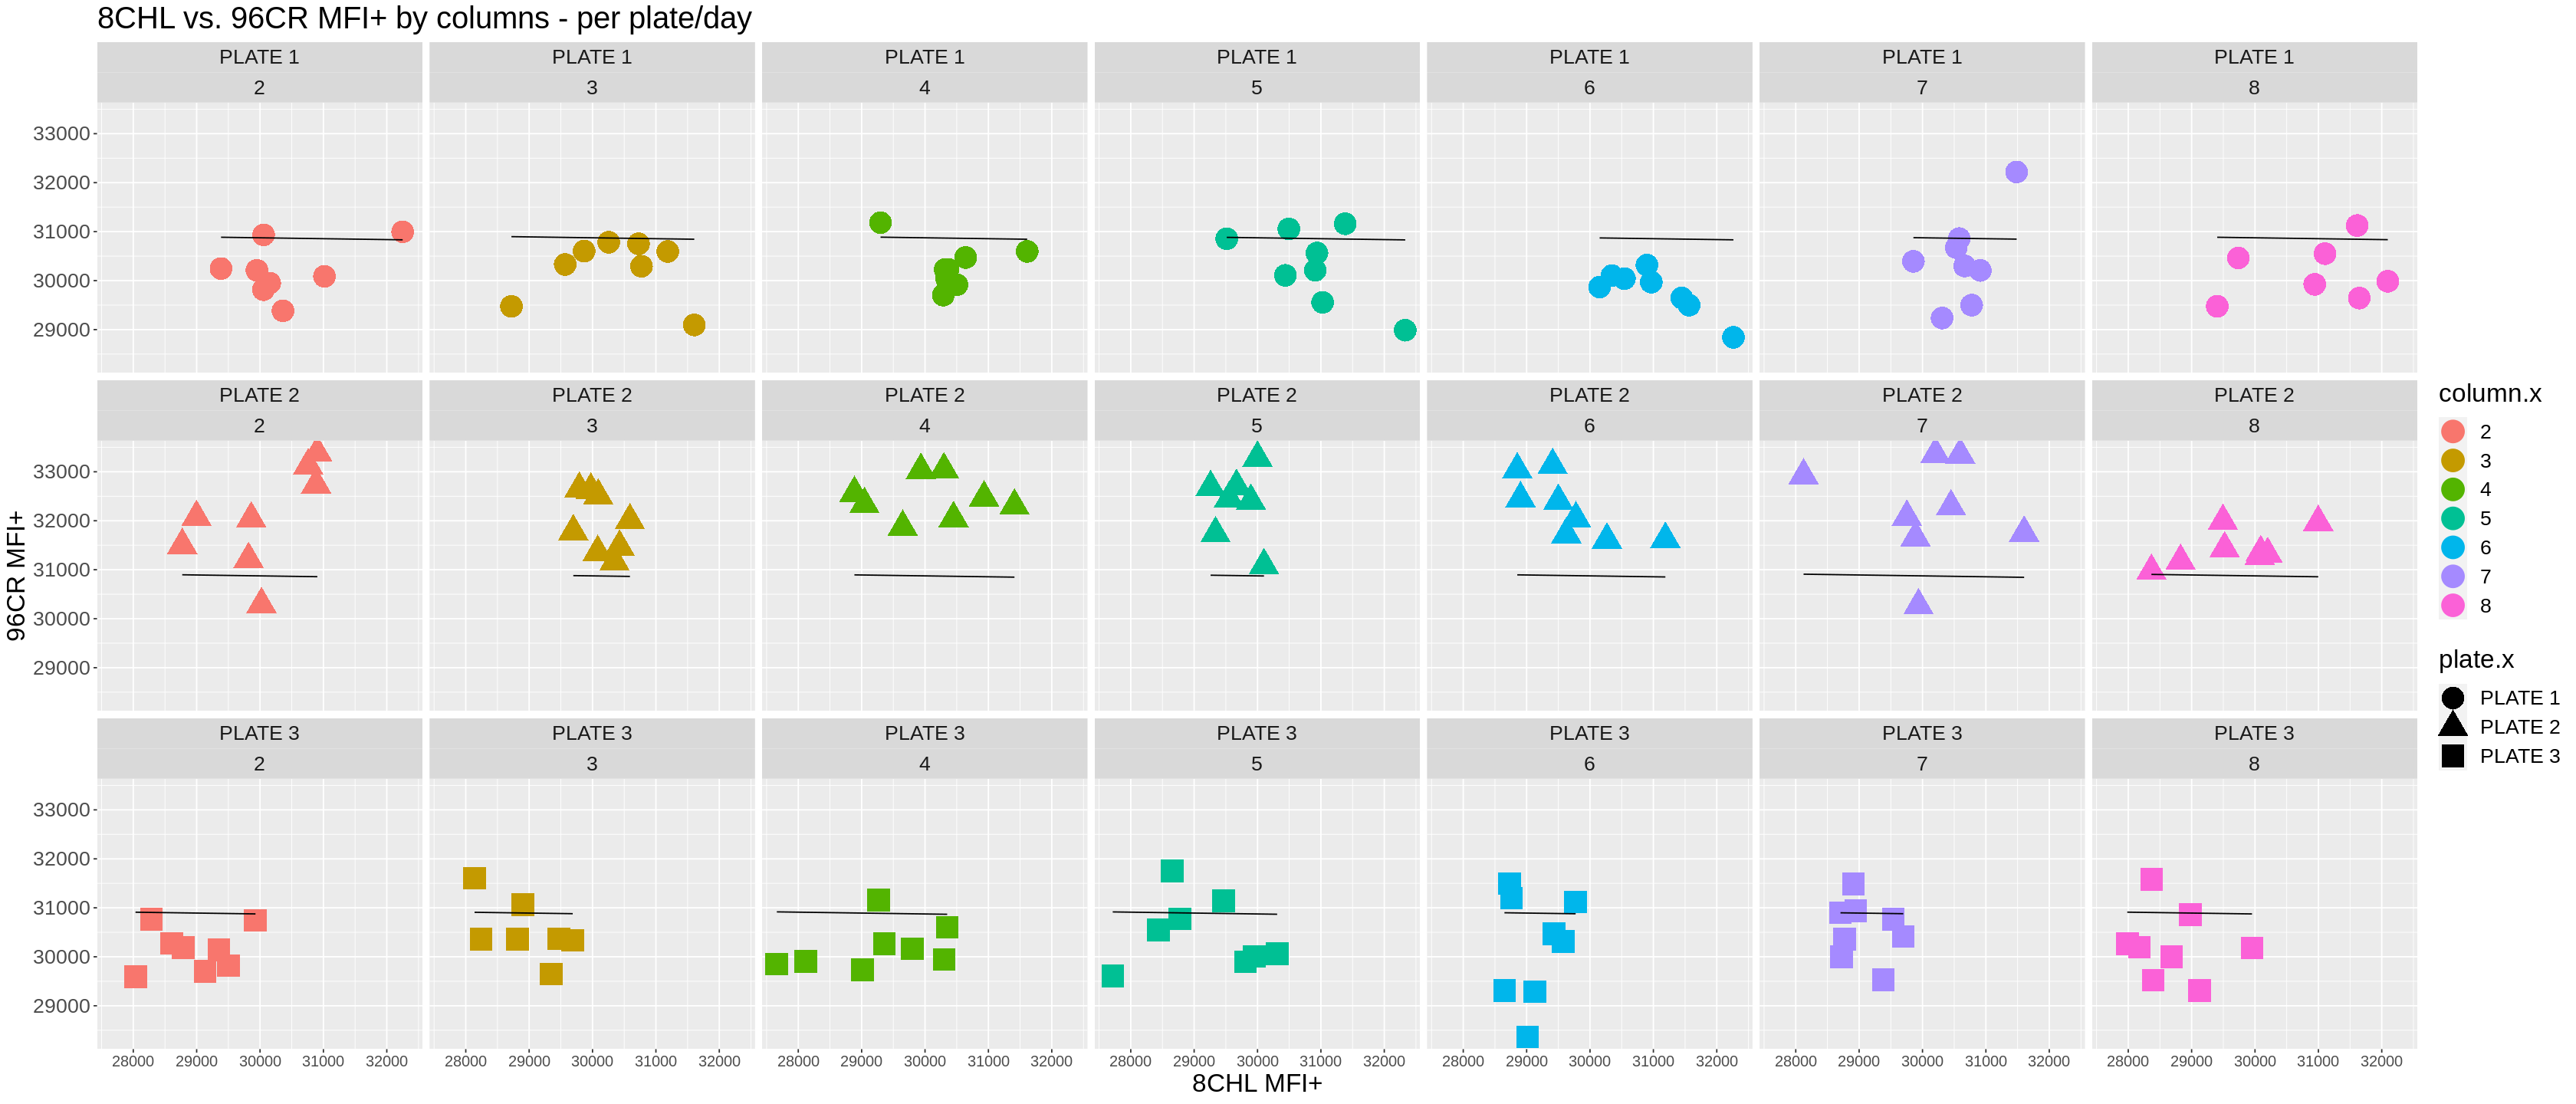

In [107]:
# per day/plate basis MFI+ 
options(repr.plot.width=28, repr.plot.height=12)
ggplot(dfm.t) + 
    geom_point(size = 8, aes(x = MFI..x, 
                   y = MFI..y, 
                   color=column.x,
                   shape=plate.x)) + 
    geom_line(aes(x = MFI..x, 
                  y = regline)) + 
    ggtitle("8CHL vs. 96CR MFI+ by columns - per plate/day") + 
    xlab("8CHL MFI+") + 
    ylab("96CR MFI+") + 
    facet_wrap(plate.x~column.x, ncol = 7) + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

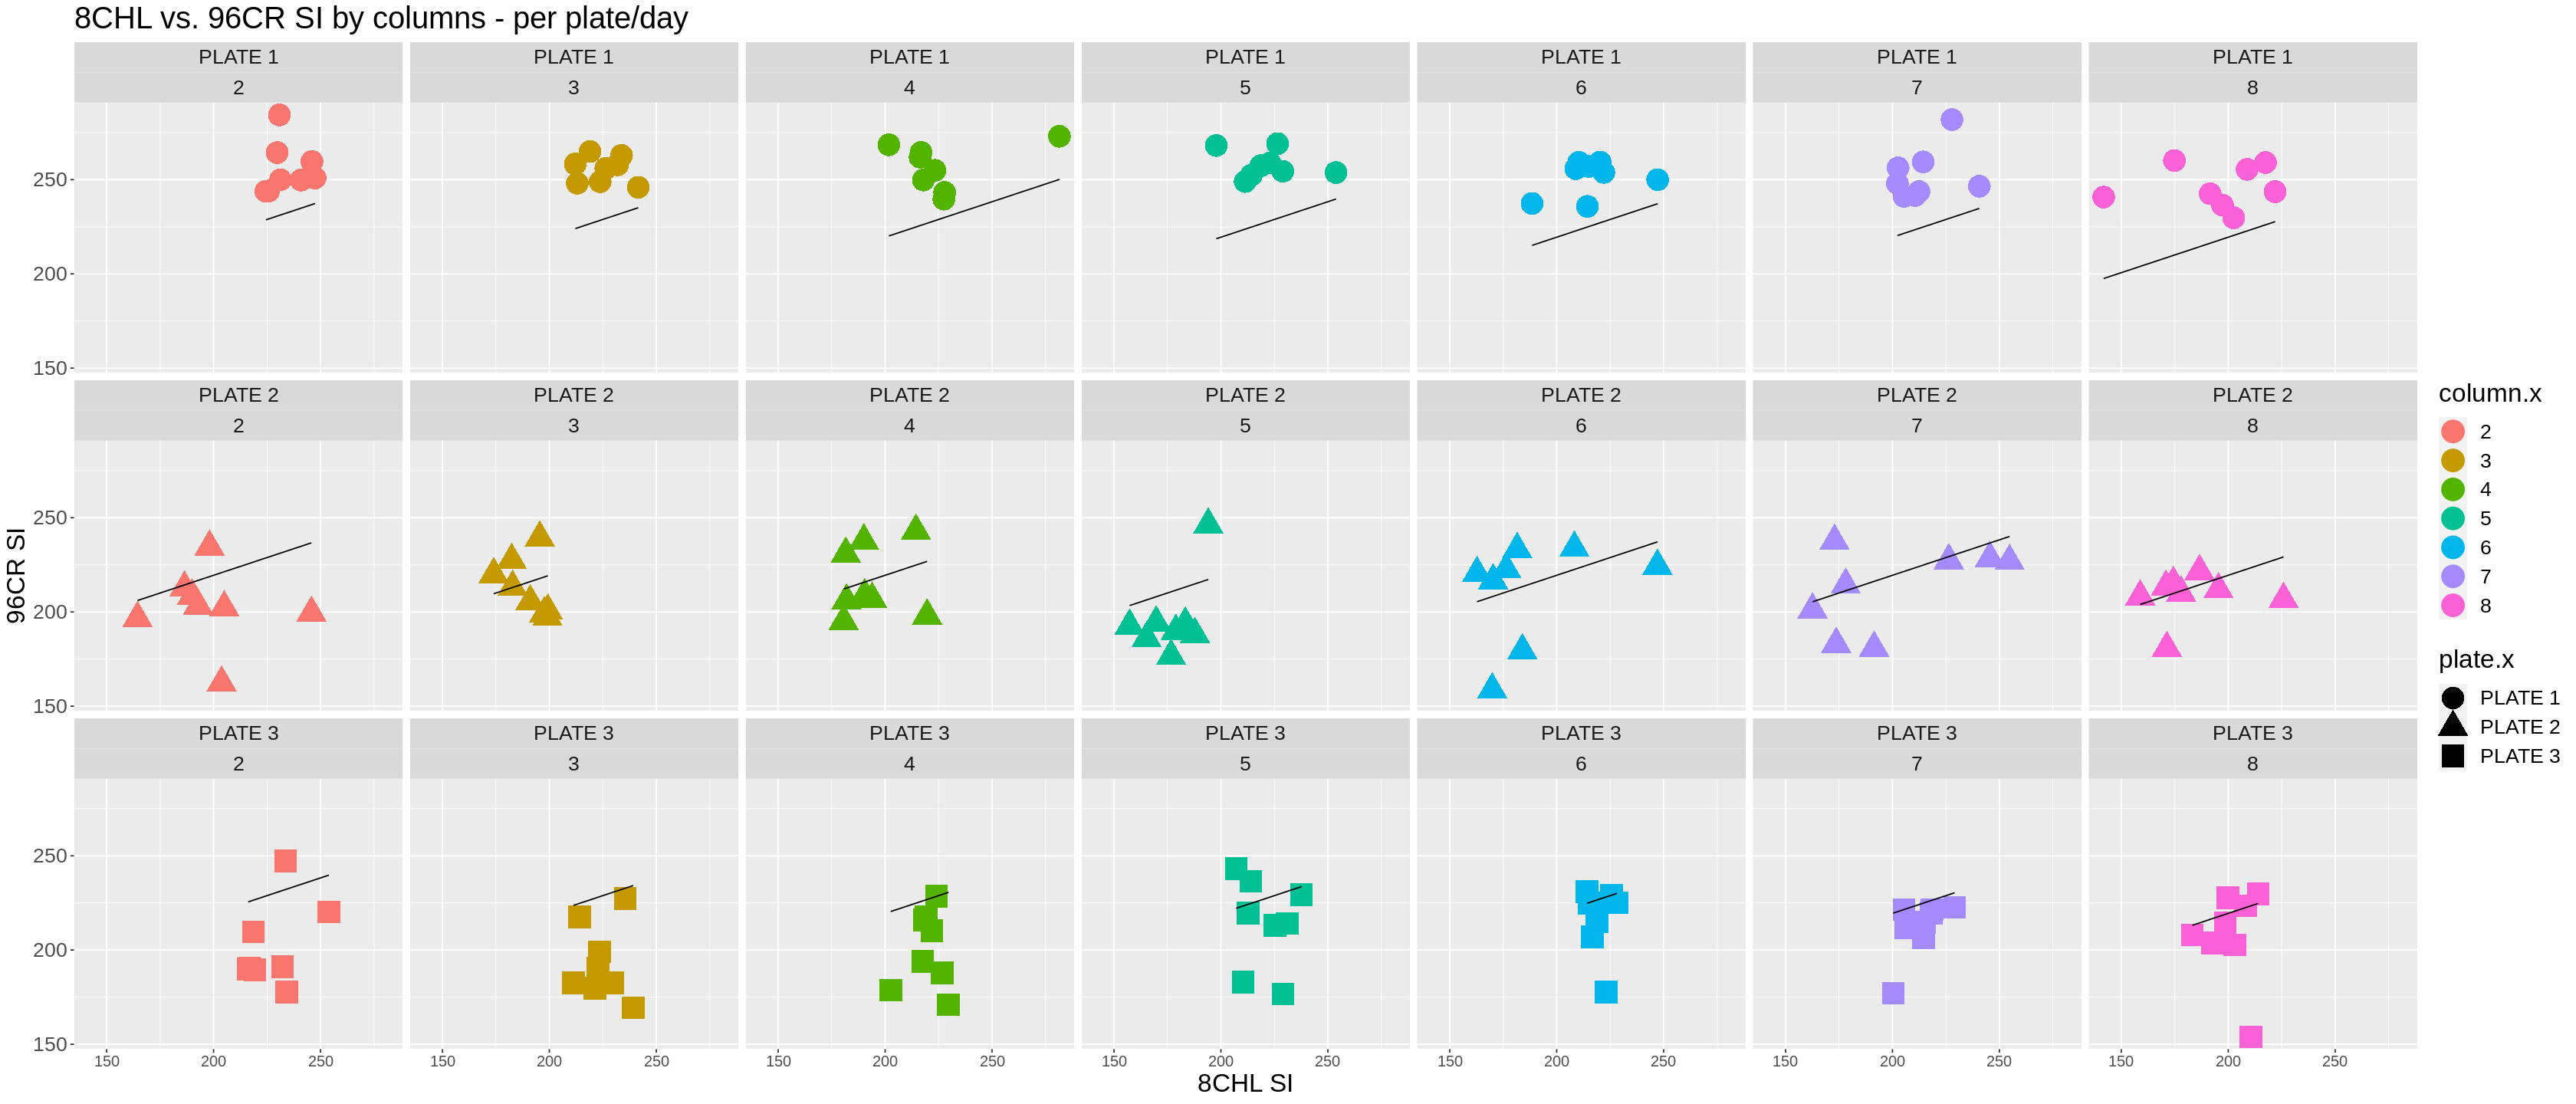

In [55]:
# per day/plate basis SI
options(repr.plot.width=28, repr.plot.height=12)
ggplot(dfm.t) + 
    geom_point(size = 8, aes(x = SI.x, 
                   y = SI.y, 
                   color=column.x,
                   shape=plate.x)) + 
    geom_line(aes(x = SI.x, 
                  y = regline)) + 
    ggtitle("8CHL vs. 96CR SI by columns - per plate/day") + 
    xlab("8CHL SI") + 
    ylab("96CR SI") + 
    facet_wrap(plate.x~column.x, ncol = 7) + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

In [13]:
head(dfm)

SAMPLE_NAME                 MFI.     MFI..1 SI       SN       method plate  
1 Specimen_001_A2_A02_002.fcs 32250.40 68.93  240.8973 467.8717 8CHL   PLATE 1
2 Specimen_001_A3_A03_003.fcs 31186.86 70.15  223.7325 444.5739 8CHL   PLATE 1
3 Specimen_001_A4_A04_004.fcs 30341.10 67.10  201.7459 452.1773 8CHL   PLATE 1
4 Specimen_001_A5_A05_005.fcs 30937.68 68.93  222.9273 448.8274 8CHL   PLATE 1
5 Specimen_001_A6_A06_006.fcs 30543.31 72.59  188.4981 420.7647 8CHL   PLATE 1
6 Specimen_001_A7_A07_007.fcs 30579.30 72.59  202.3096 421.2605 8CHL   PLATE 1
  wellid
1 A2    
2 A3    
3 A4    
4 A5    
5 A6    
6 A7

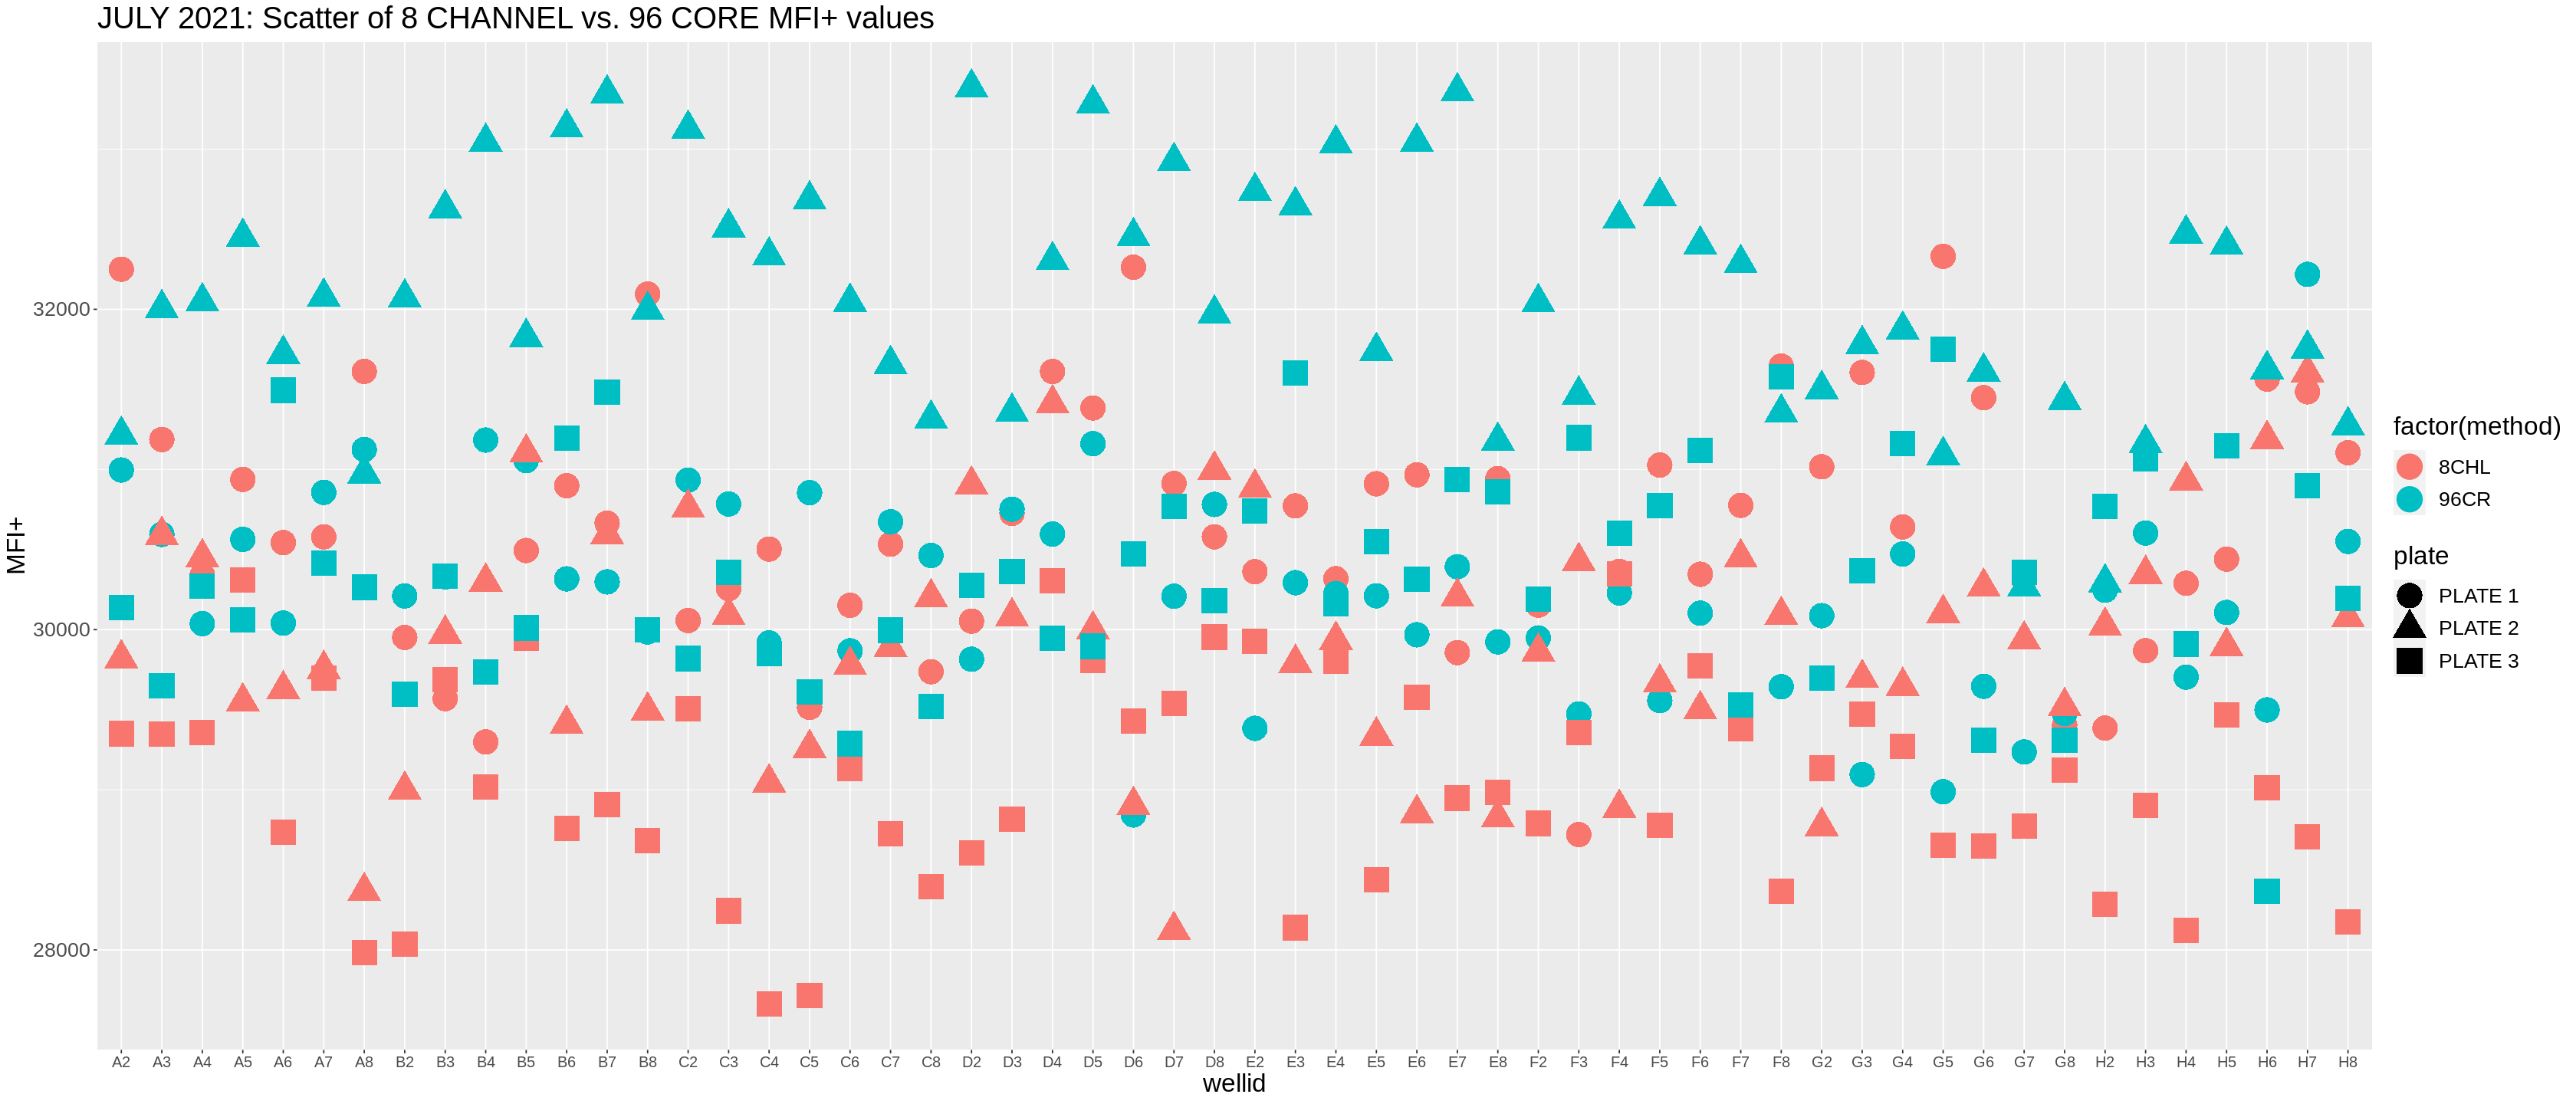

In [108]:
# MFI
ggplot(dfm, aes(x = wellid, y = MFI., group = method)) + 
    geom_point(size = 9, aes(colour = factor(method), shape = plate)) + 
    ggtitle("JULY 2021: Scatter of 8 CHANNEL vs. 96 CORE MFI+ values")  +
    ylab("MFI+") + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

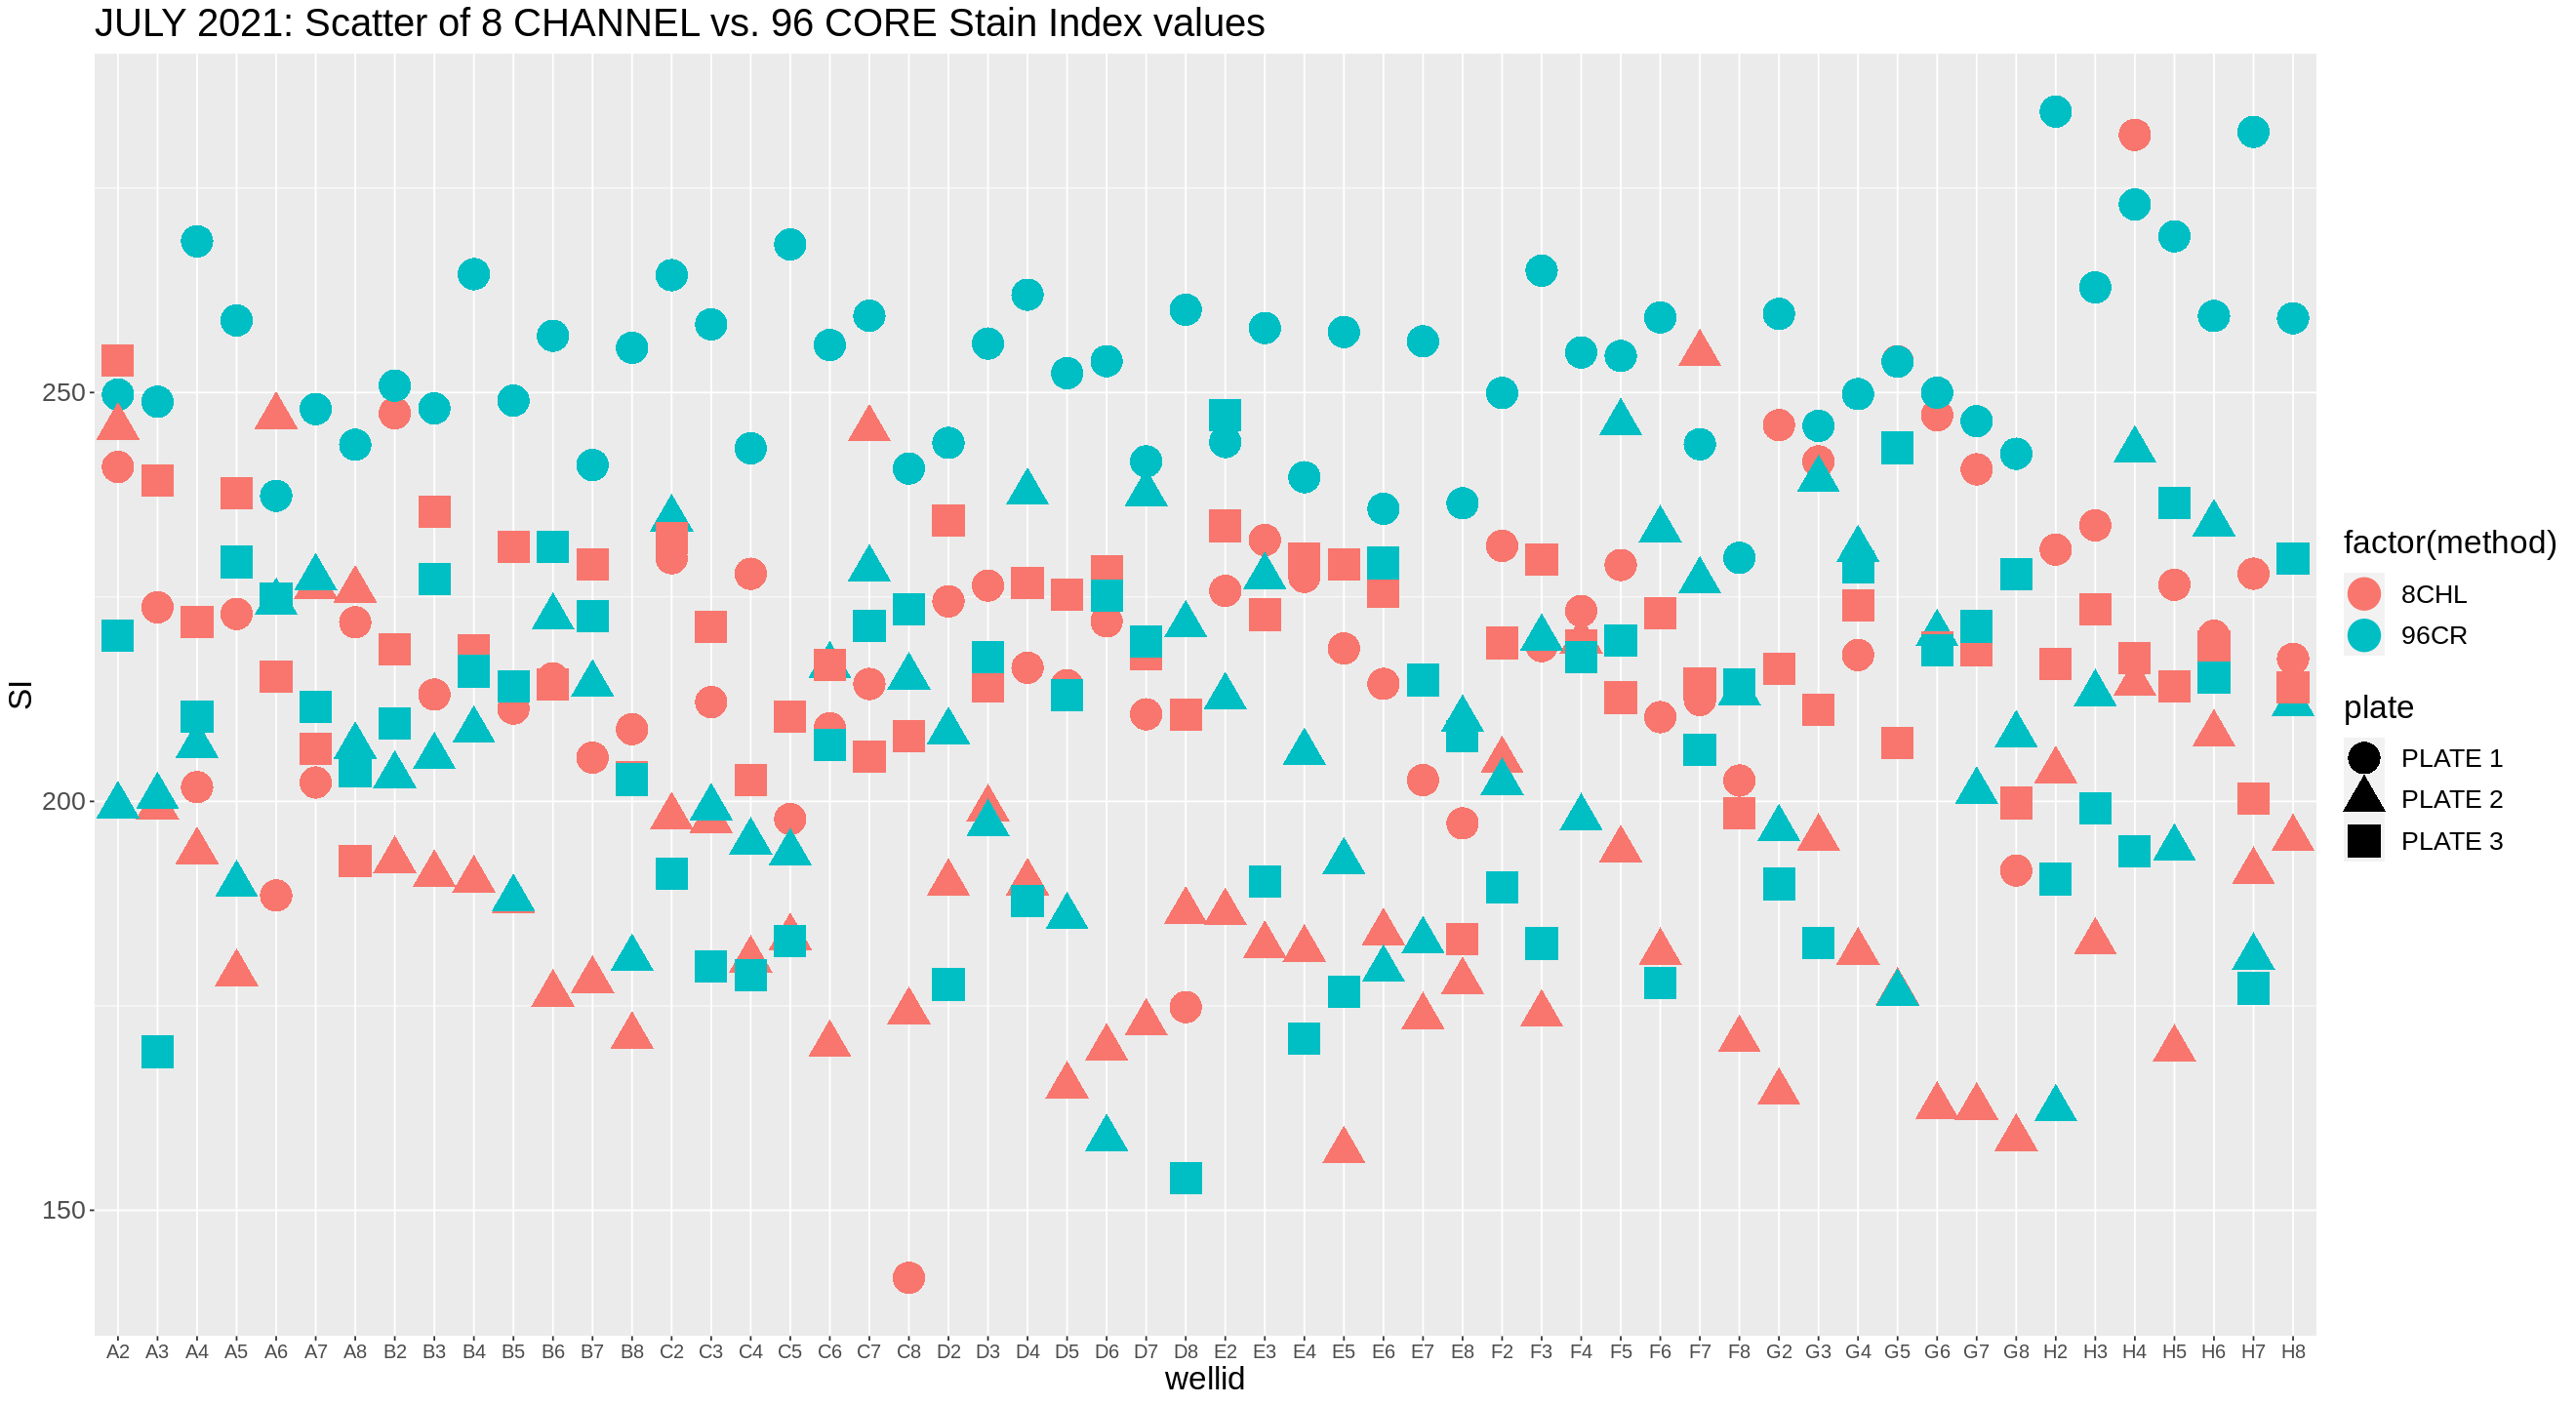

In [16]:
# SI
ggplot(dfm, aes(x = wellid, y = SI, group = method)) + 
    geom_point(size = 9, aes(colour = factor(method), shape = plate)) + 
    ggtitle("JULY 2021: Scatter of 8 CHANNEL vs. 96 CORE Stain Index values")  +
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) 

### XmR charts to show data series

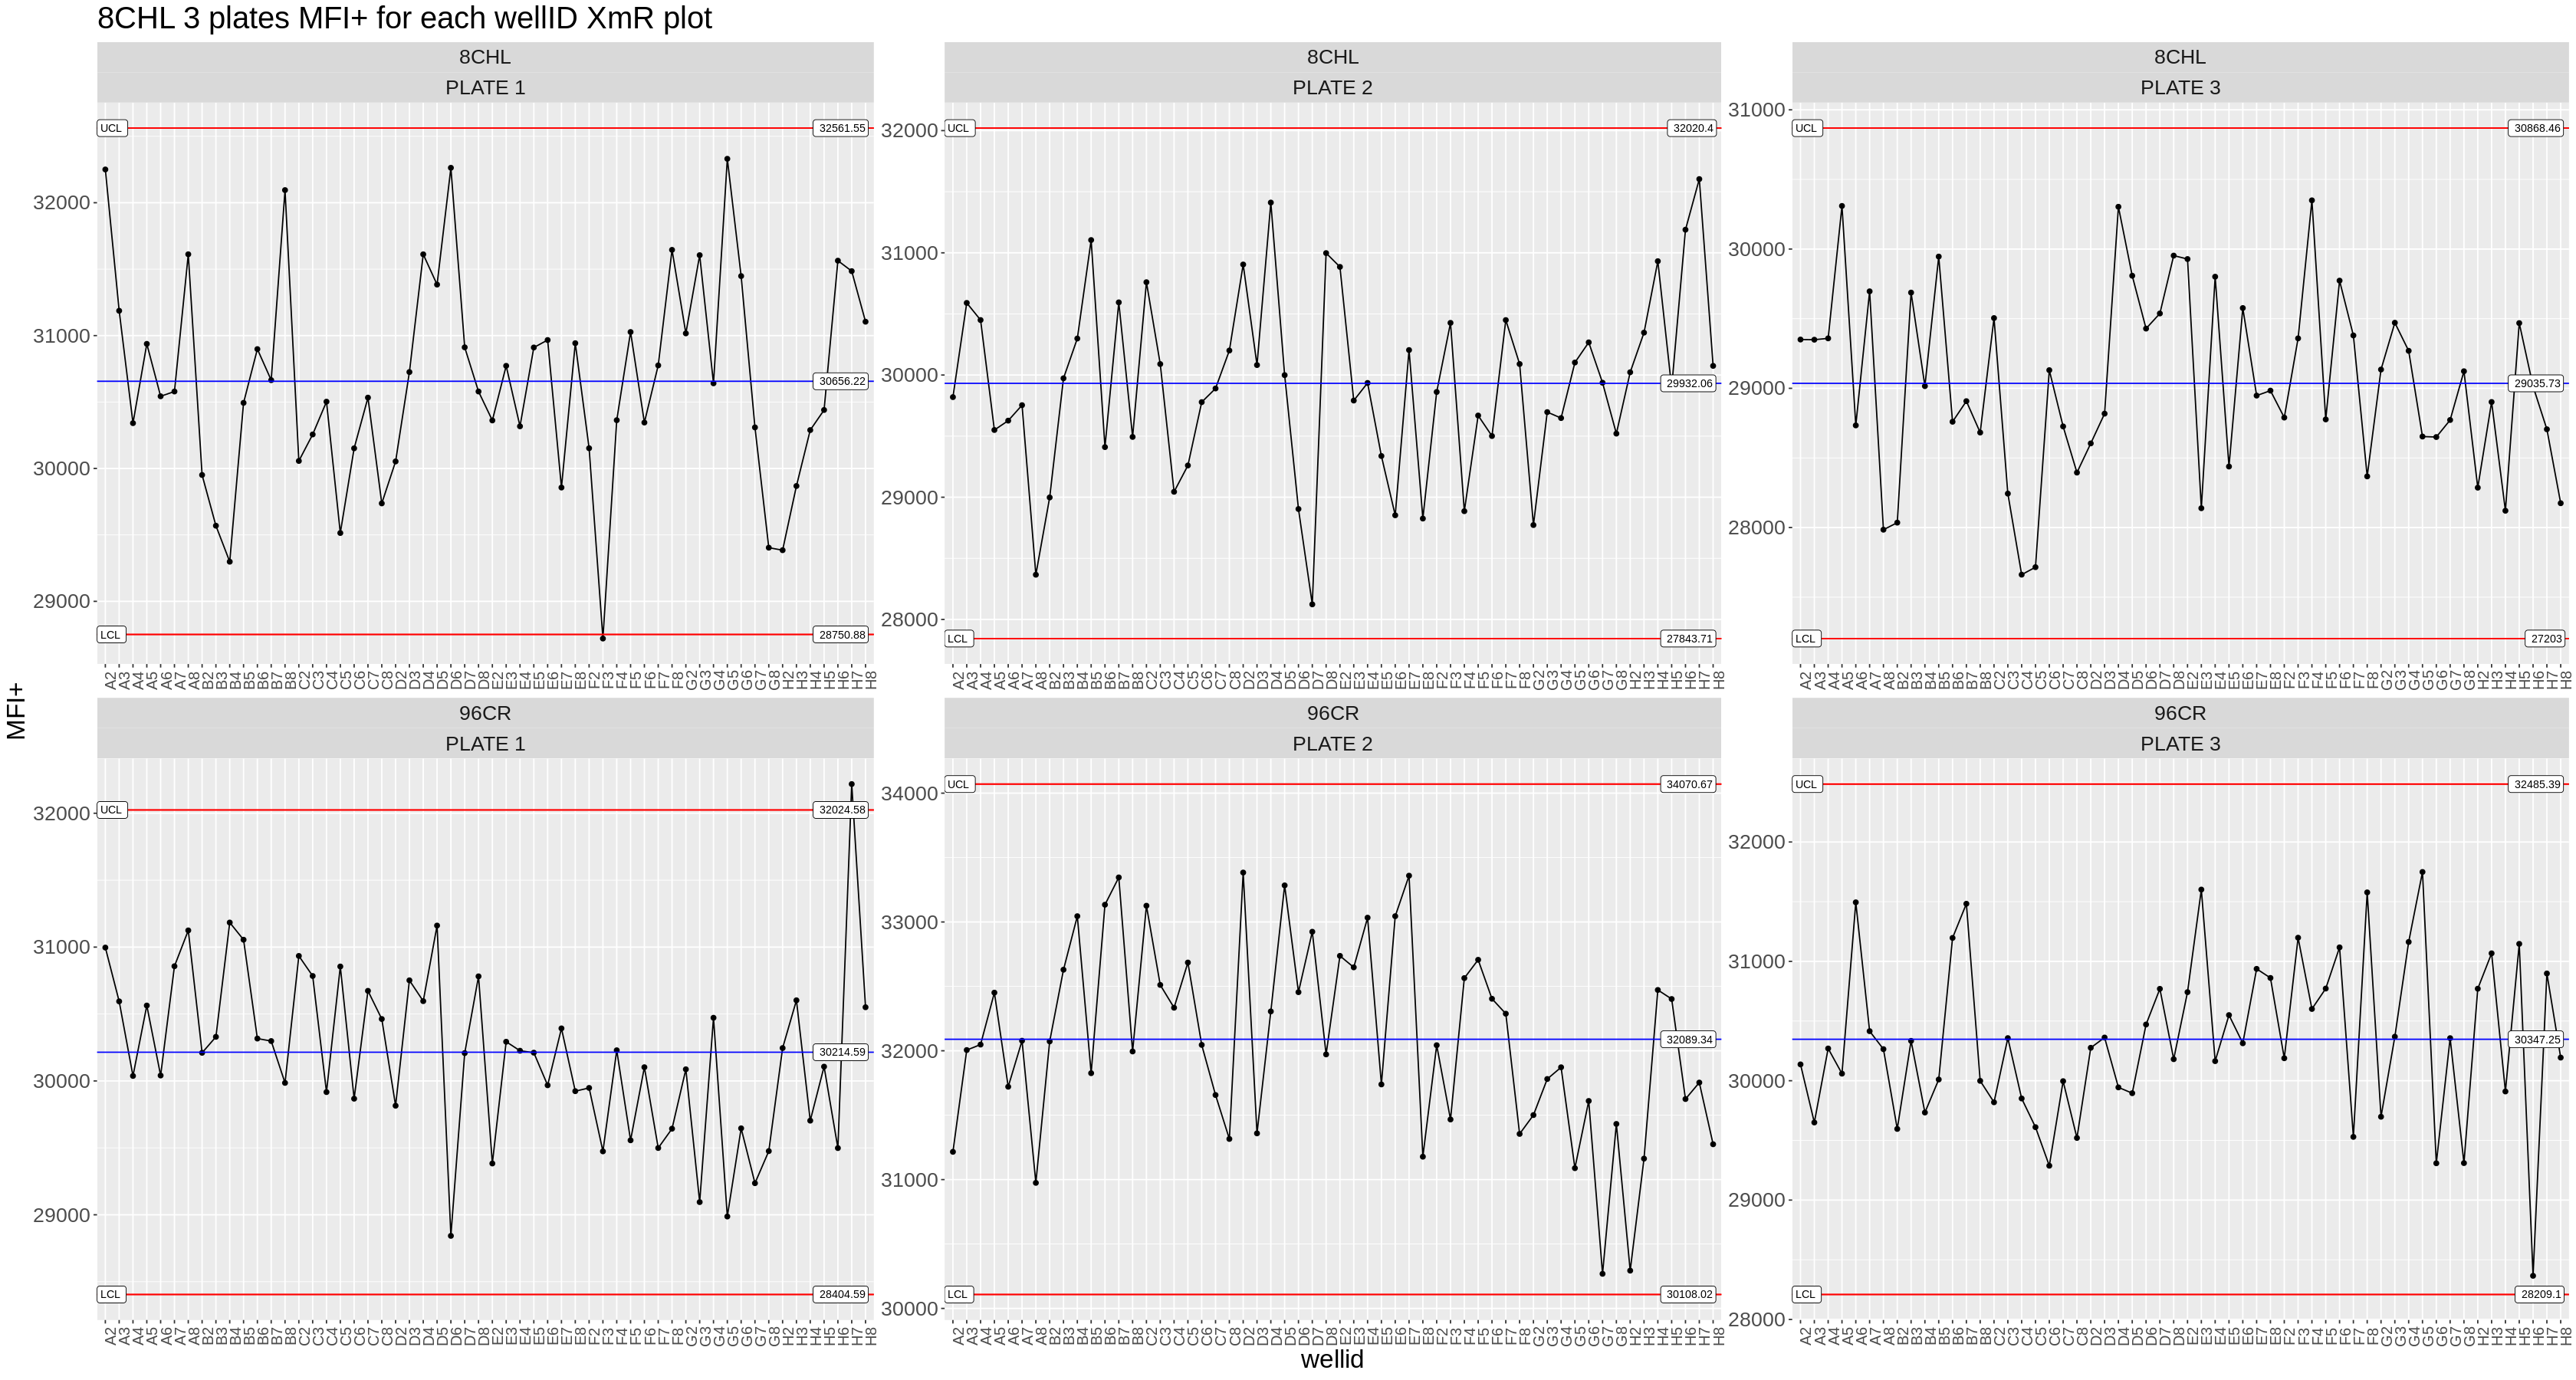

In [35]:
# MFI
options(repr.plot.width=28, repr.plot.height=15)
ggplot(dfm, aes(x=wellid, y=MFI., group = plate)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("MFI+") +
  facet_wrap(method~plate, ncol = 3, scales = "free") + 
  ggtitle("8CHL 3 plates MFI+ for each wellID XmR plot") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12, angle = 90))

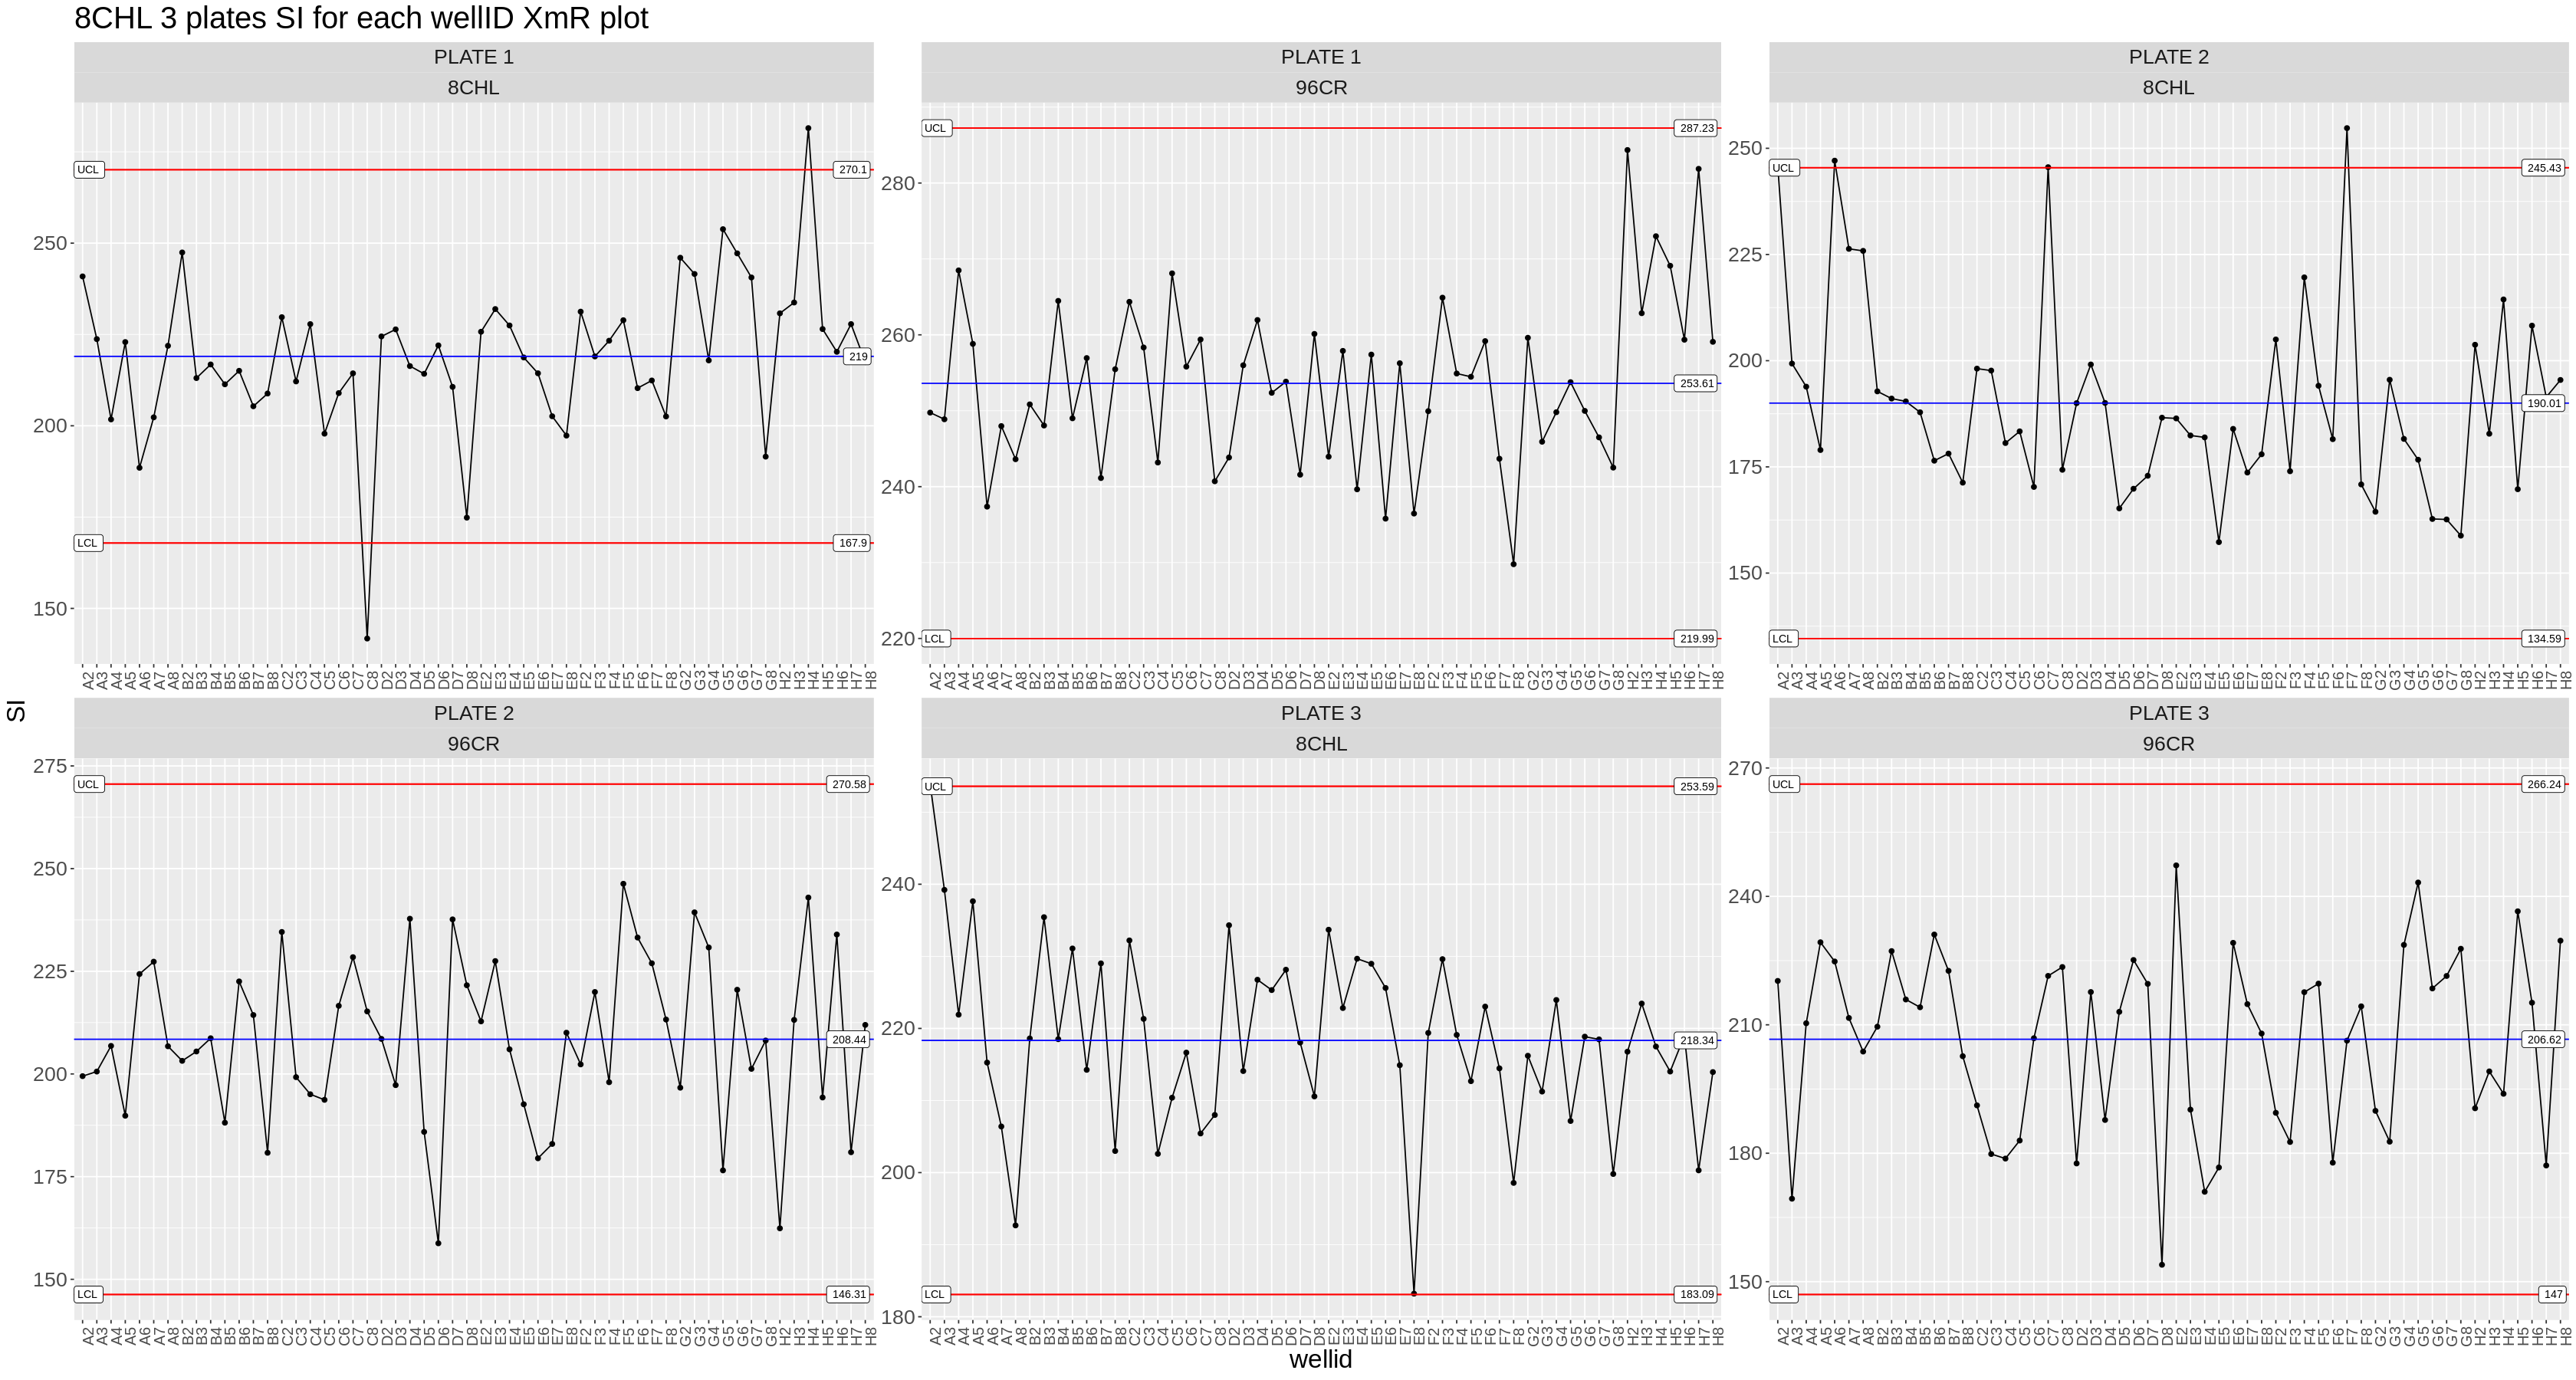

In [33]:
# SI
options(repr.plot.width=28, repr.plot.height=15)
ggplot(dfm, aes(x=wellid, y=SI, group = plate)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("SI") +
  facet_wrap(plate~ method, ncol = 3, scales = "free") + 
  ggtitle("8CHL 3 plates SI for each wellID XmR plot") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12, angle = 90))

In [55]:
dft2 <- dfm %>% 
    mutate(row = substr(wellid, 1,1) ) %>% 
    group_by(row, method) %>%
    summarise(AvgRow = mean(SI))
head(dft2)

`summarise()` regrouping output by 'row' (override with `.groups` argument)



row method AvgRow  
1 A   8CHL   218.3925
2 A   96CR   222.8298
3 B   8CHL   207.4192
4 B   96CR   224.3920
5 C   8CHL   203.7682
6 C   96CR   221.7697

In [100]:
dft2 <- dfm %>% 
    mutate(row = substr(wellid, 1,1) ) %>% 
    group_by(row, method) %>%
    summarise(AvgRow = mean(MFI.))
head(dft2)

`summarise()` regrouping output by 'row' (override with `.groups` argument)



row method AvgRow  
1 A   8CHL   30018.49
2 A   96CR   30904.74
3 B   8CHL   29803.70
4 B   96CR   31132.31
5 C   8CHL   29483.38
6 C   96CR   30838.63

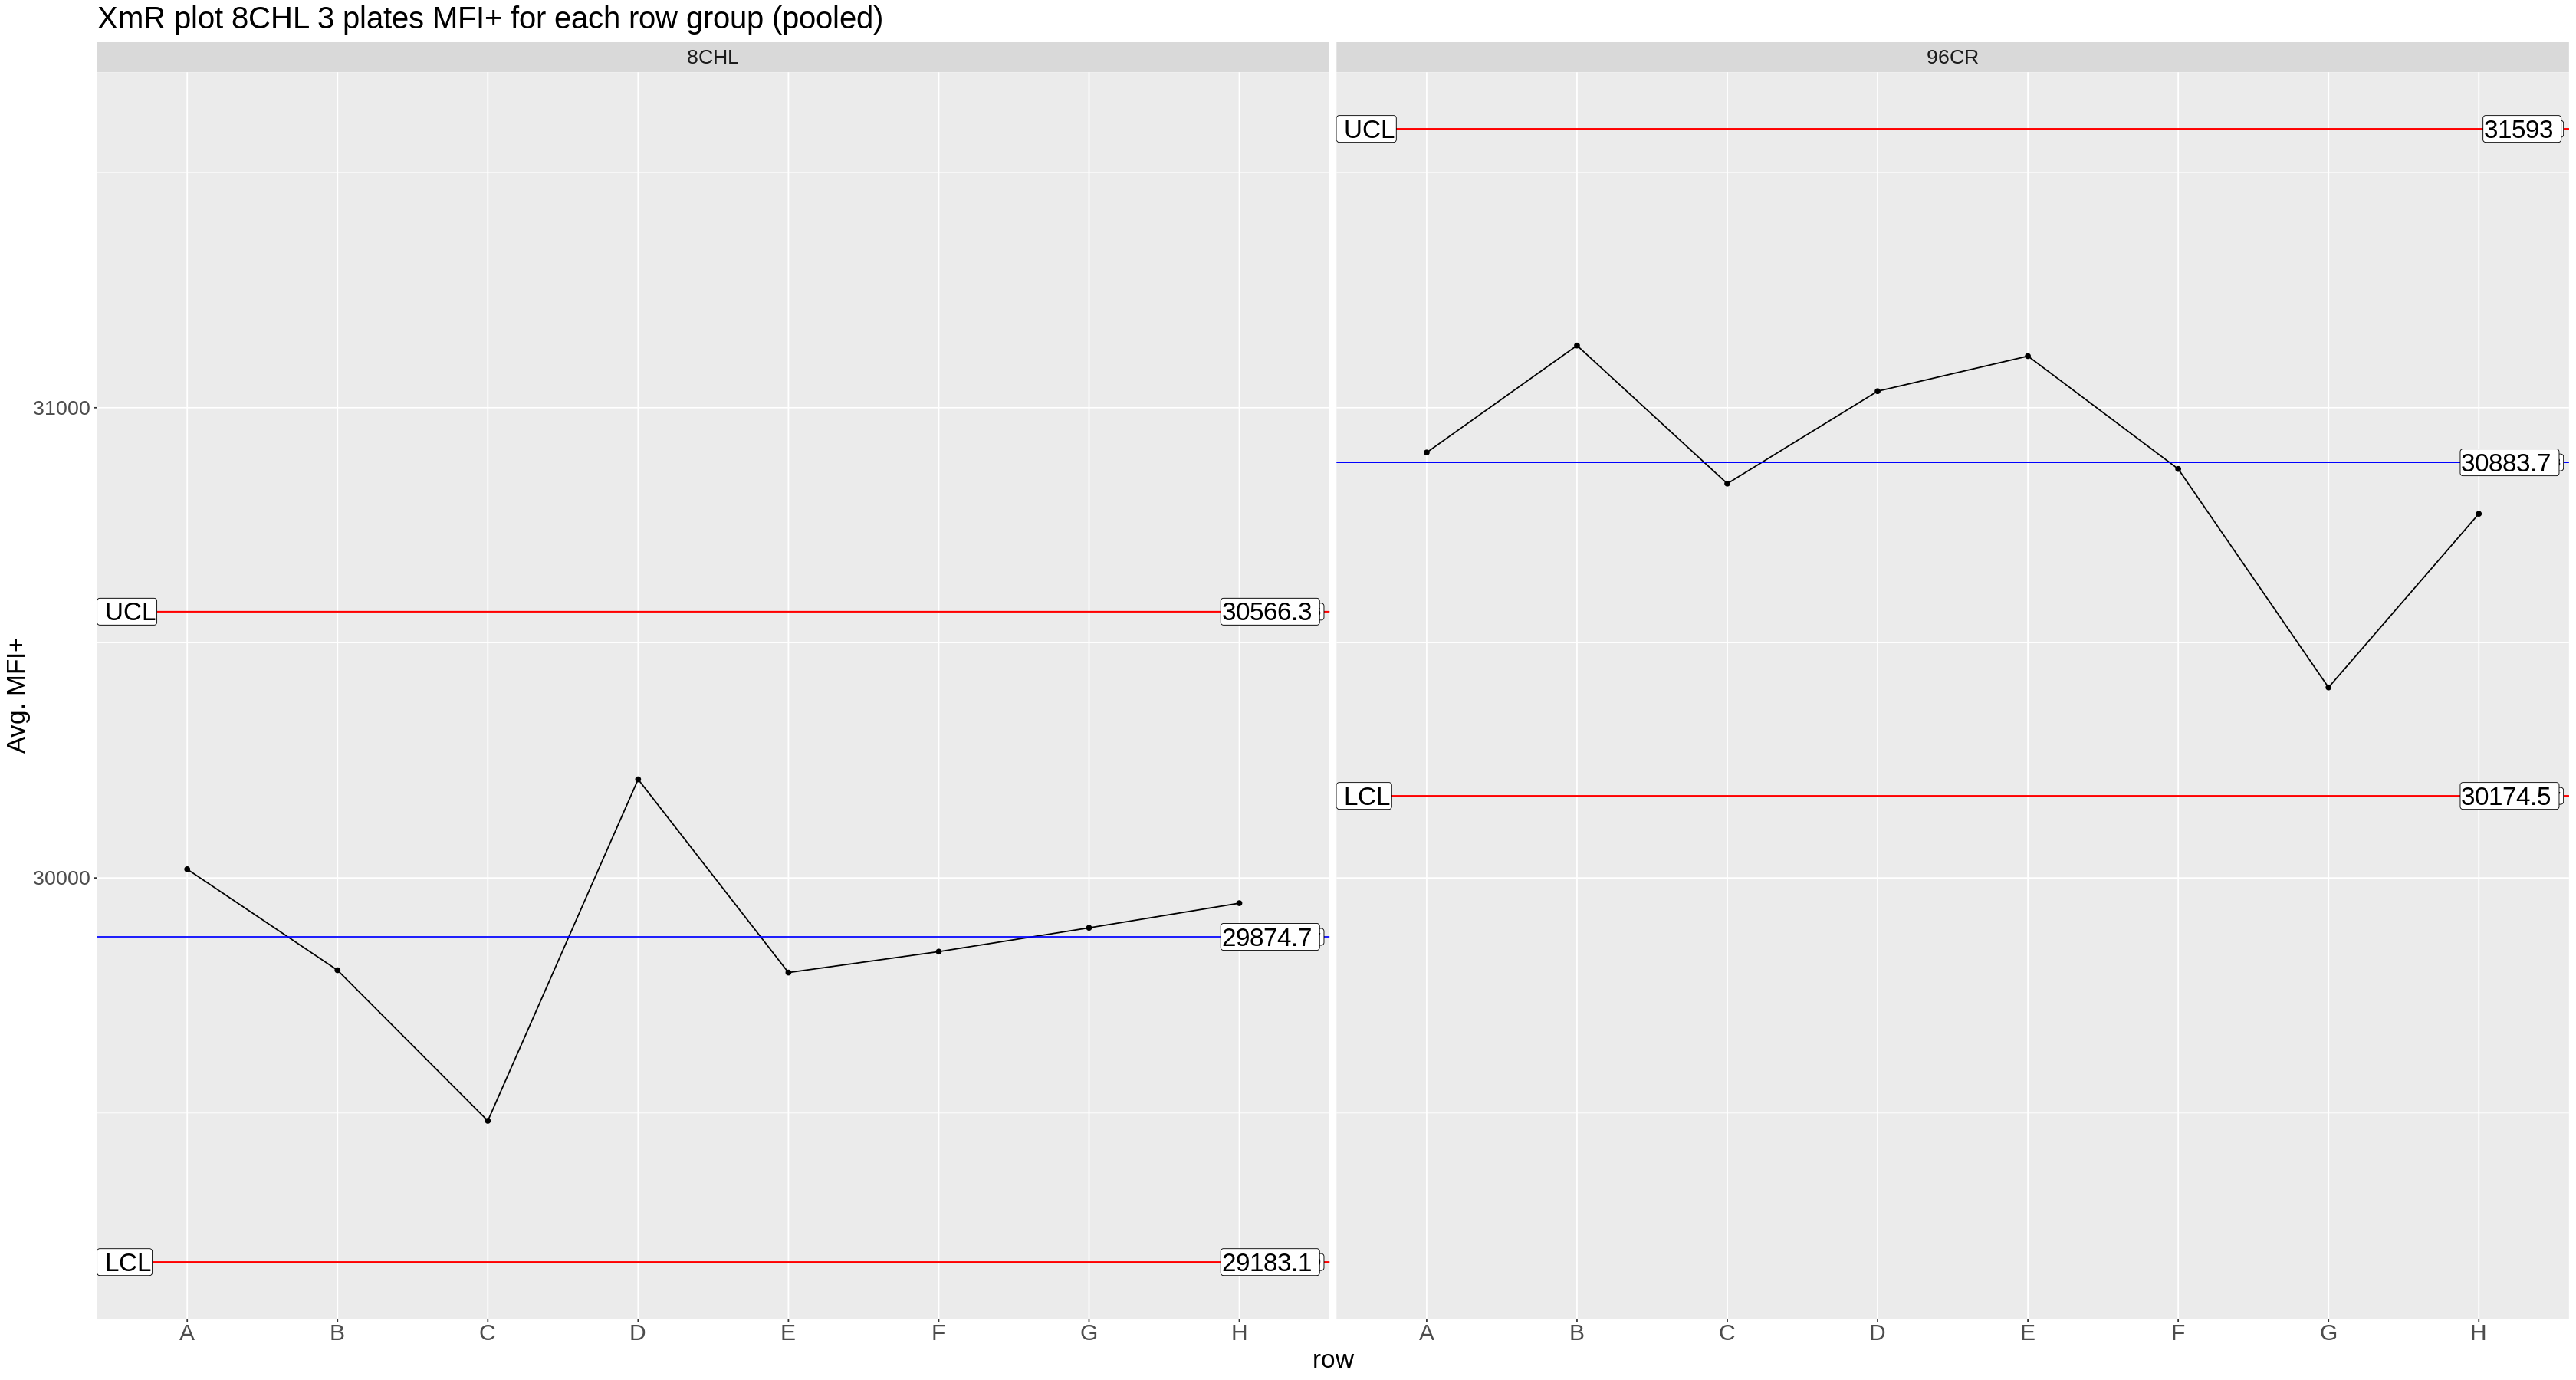

In [104]:
# MFI+
ggplot(dft2, aes(x=row, y=AvgRow, group = method)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("Avg. MFI+") +
  facet_wrap(~ method) + 
  ggtitle("XmR plot 8CHL 3 plates MFI+ for each row group (pooled)") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 18)) + 
  stat_QC_labels(method="XmR", text.size = 7)


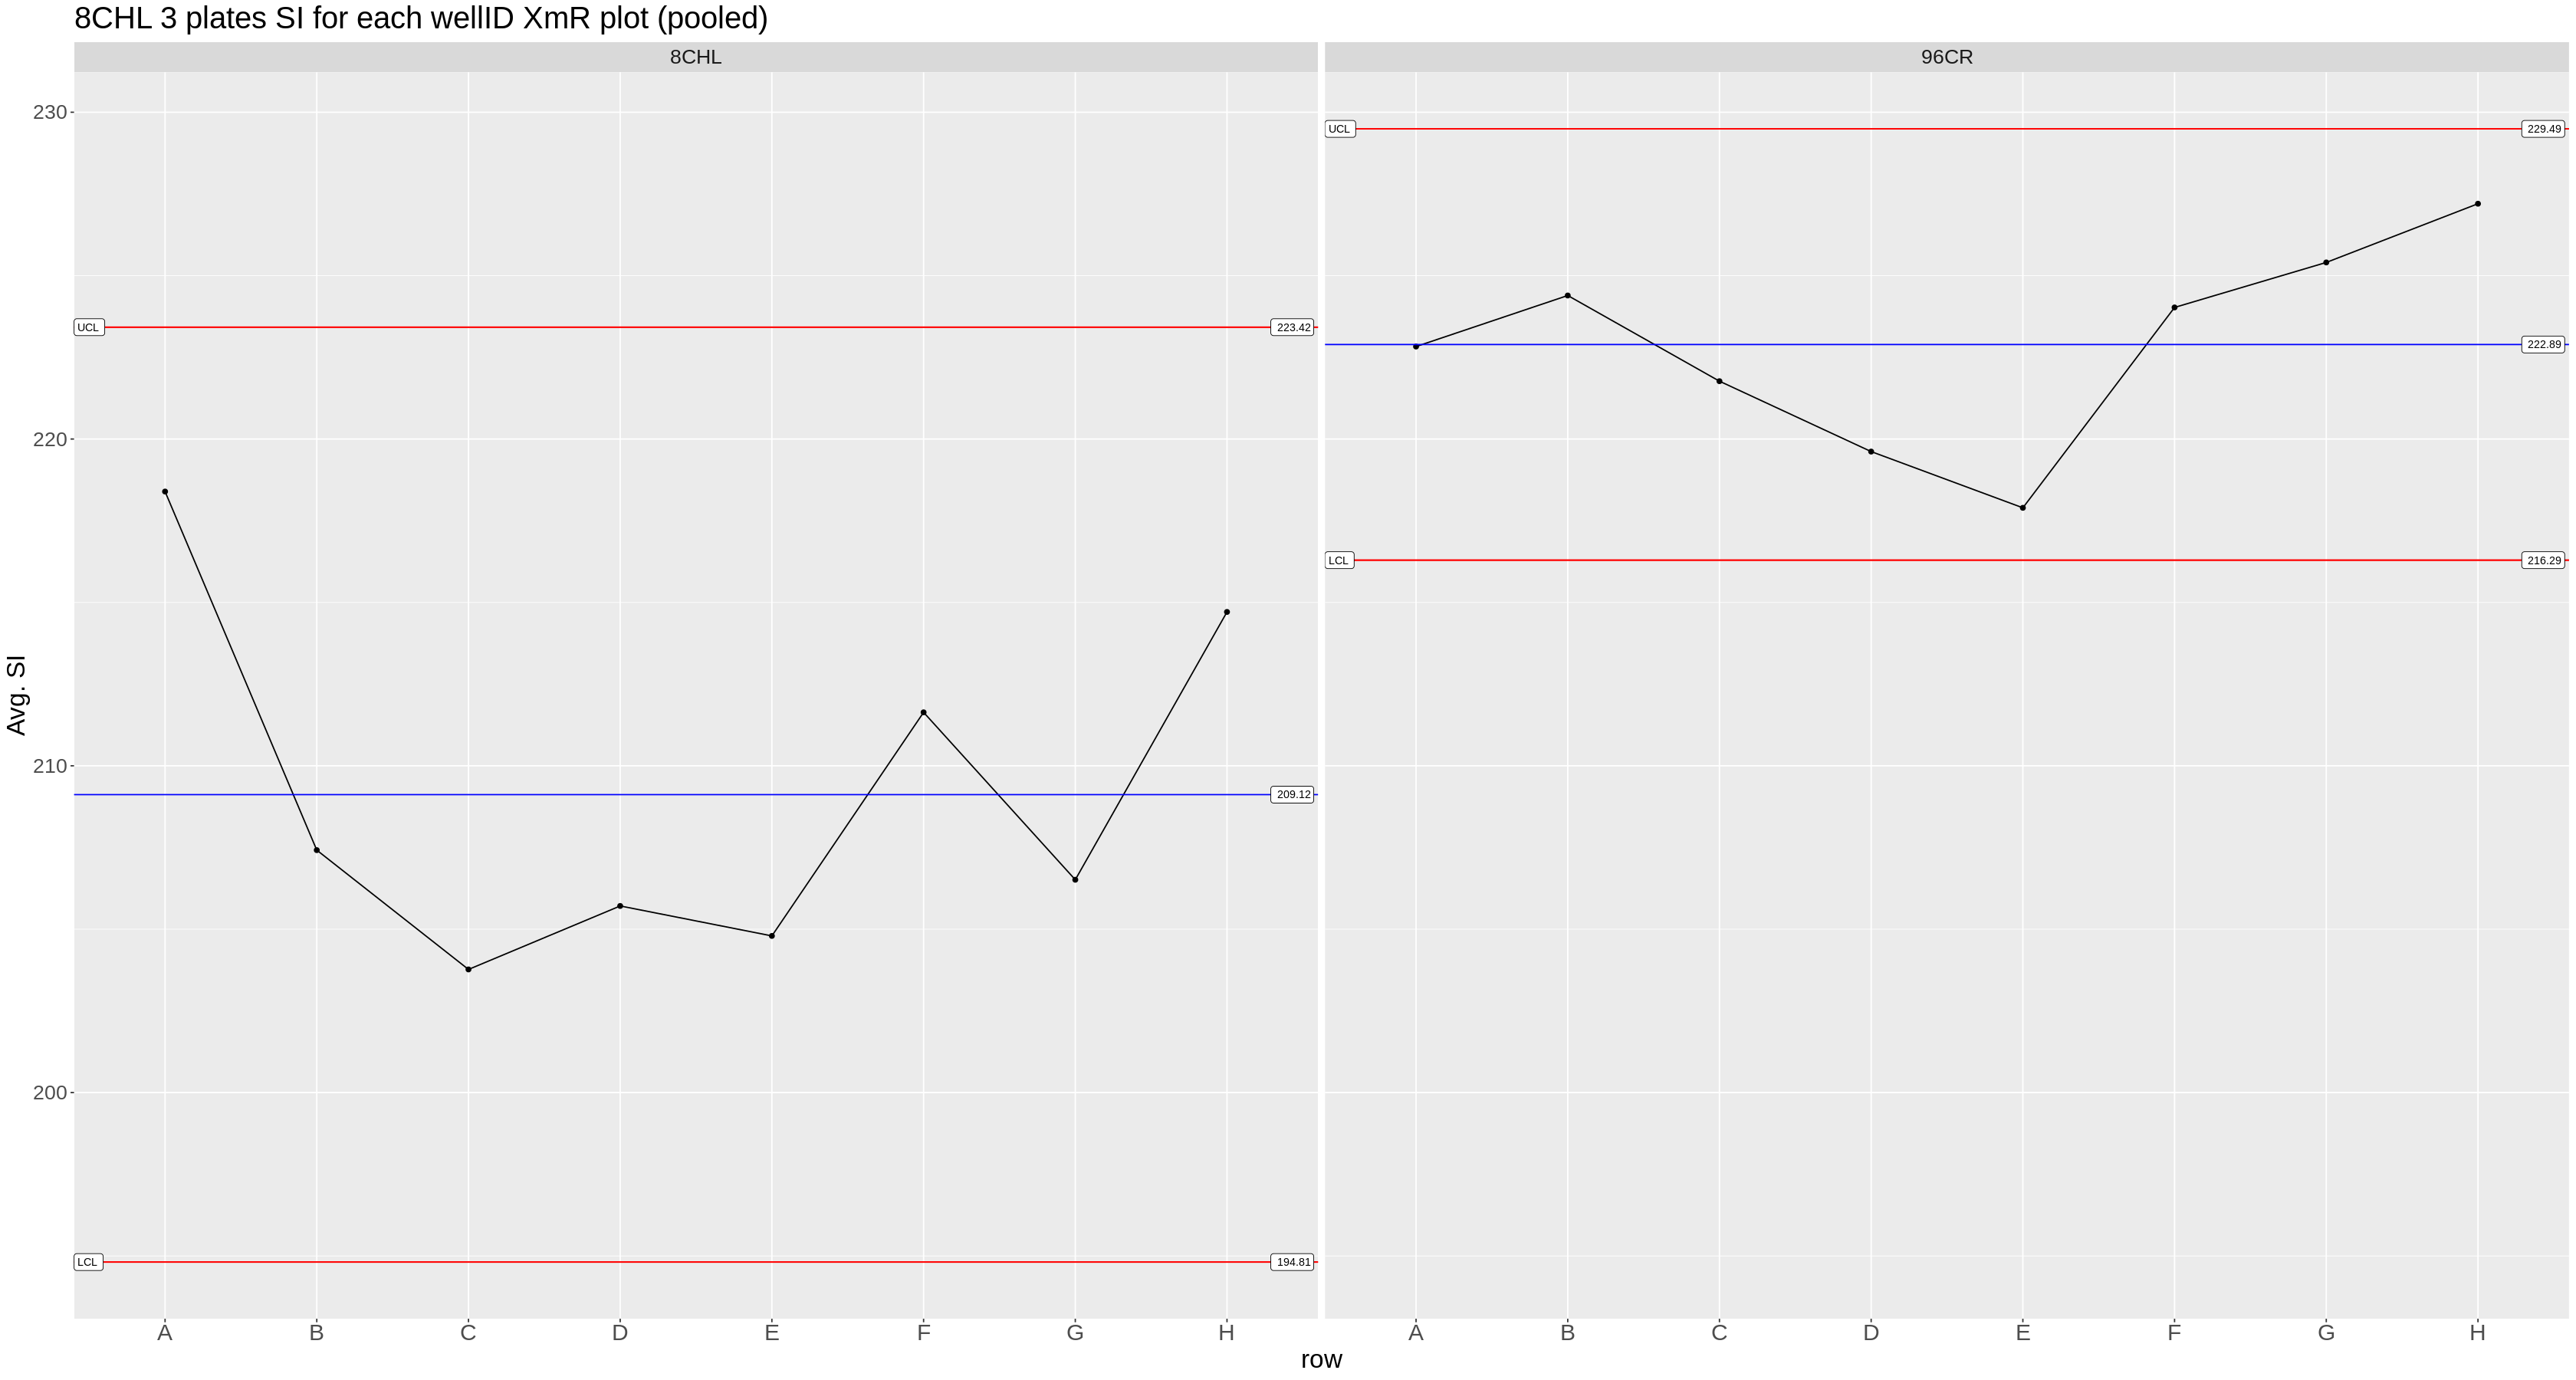

In [57]:
# SI
ggplot(dft2, aes(x=row, y=AvgRow, group = method)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("Avg. SI") +
  facet_wrap(~ method) + 
  ggtitle("XmR plot 8CHL 3 plates SI for each row group (pooled)") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 18))

In [59]:
# SI
dft2 <- dfm %>% 
    group_by(method, wellid) %>%
    summarise(Mean= mean(SI))
head(dft2)

`summarise()` regrouping output by 'method' (override with `.groups` argument)



method wellid Mean    
1 8CHL   A2     246.8556
2 8CHL   A3     220.7593
3 8CHL   A4     205.8456
4 8CHL   A5     213.1819
5 8CHL   A6     216.9492
6 8CHL   A7     211.6785

In [105]:
# MFI 
dft2 <- dfm %>% 
    group_by(method, wellid) %>%
    summarise(Mean= mean(MFI.))
head(dft2)

`summarise()` regrouping output by 'method' (override with `.groups` argument)



method wellid Mean    
1 8CHL   A2     30473.28
2 8CHL   A3     30375.28
3 8CHL   A4     30049.89
4 8CHL   A5     30265.84
5 8CHL   A6     29634.60
6 8CHL   A7     30009.69

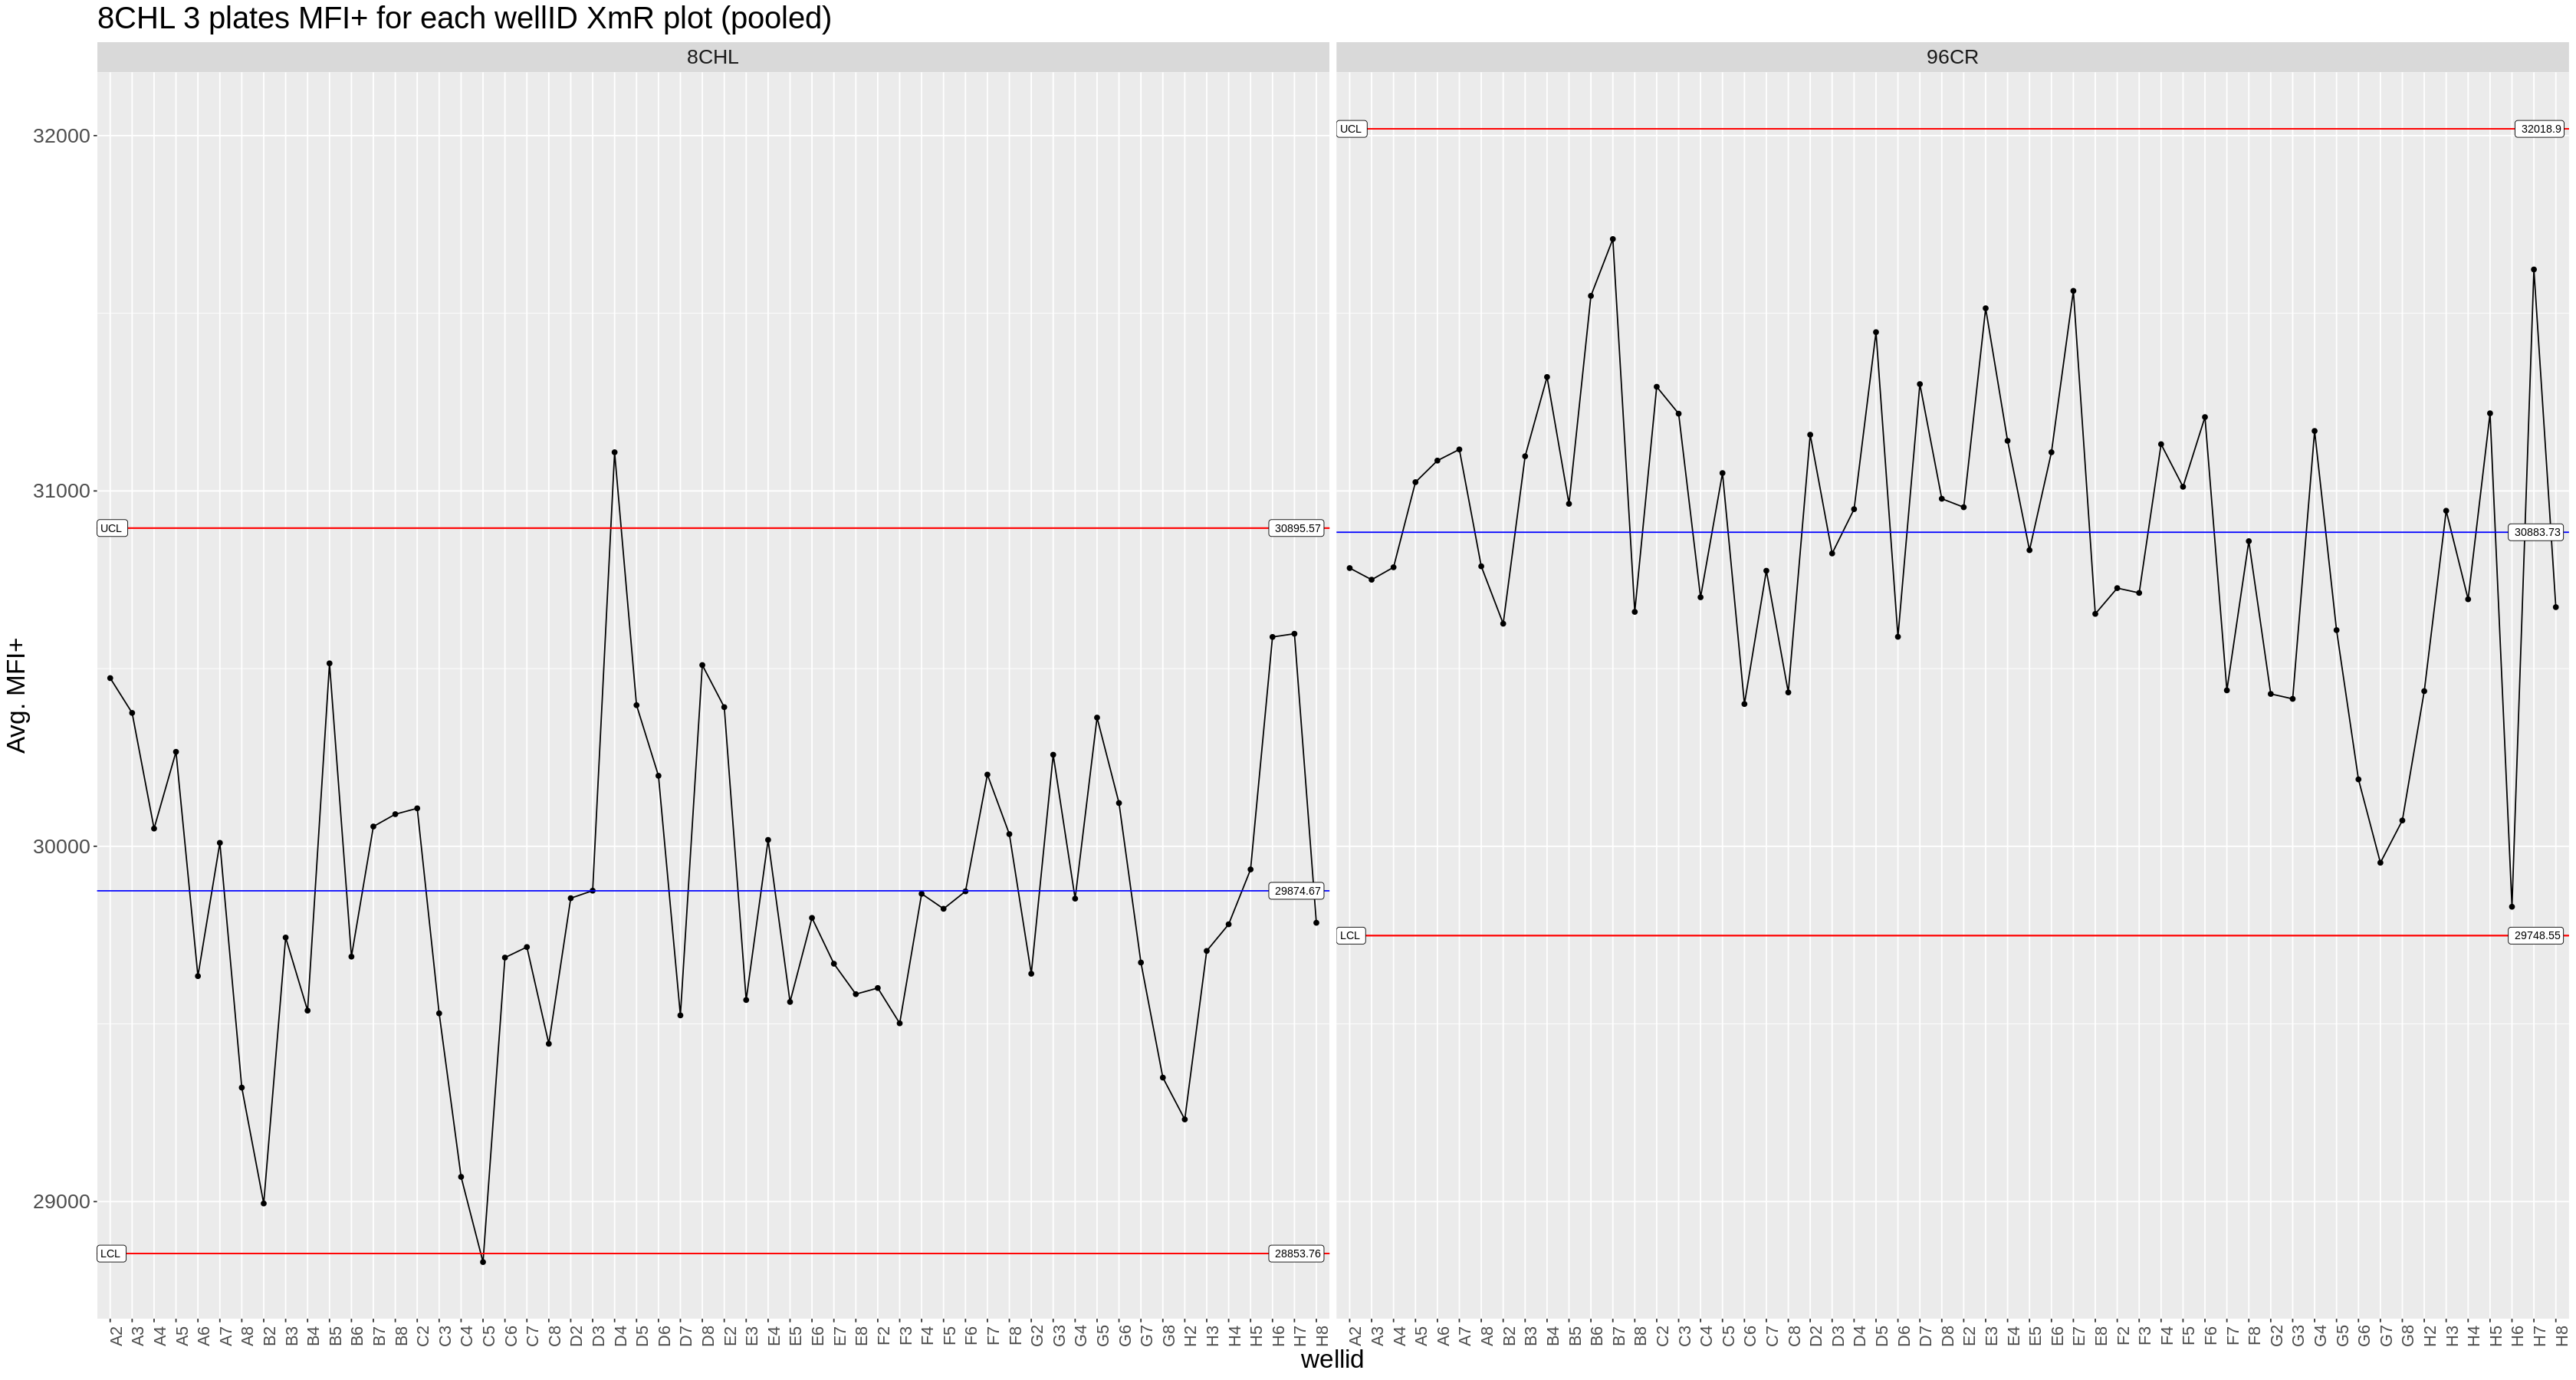

In [106]:
#  MFI+
ggplot(dft2, aes(x=wellid, y=Mean, group=method)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("Avg. MFI+") +
  facet_wrap(~ method) + 
  ggtitle("8CHL 3 plates MFI+ for each wellID XmR plot (pooled)") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 13, angle = 90))

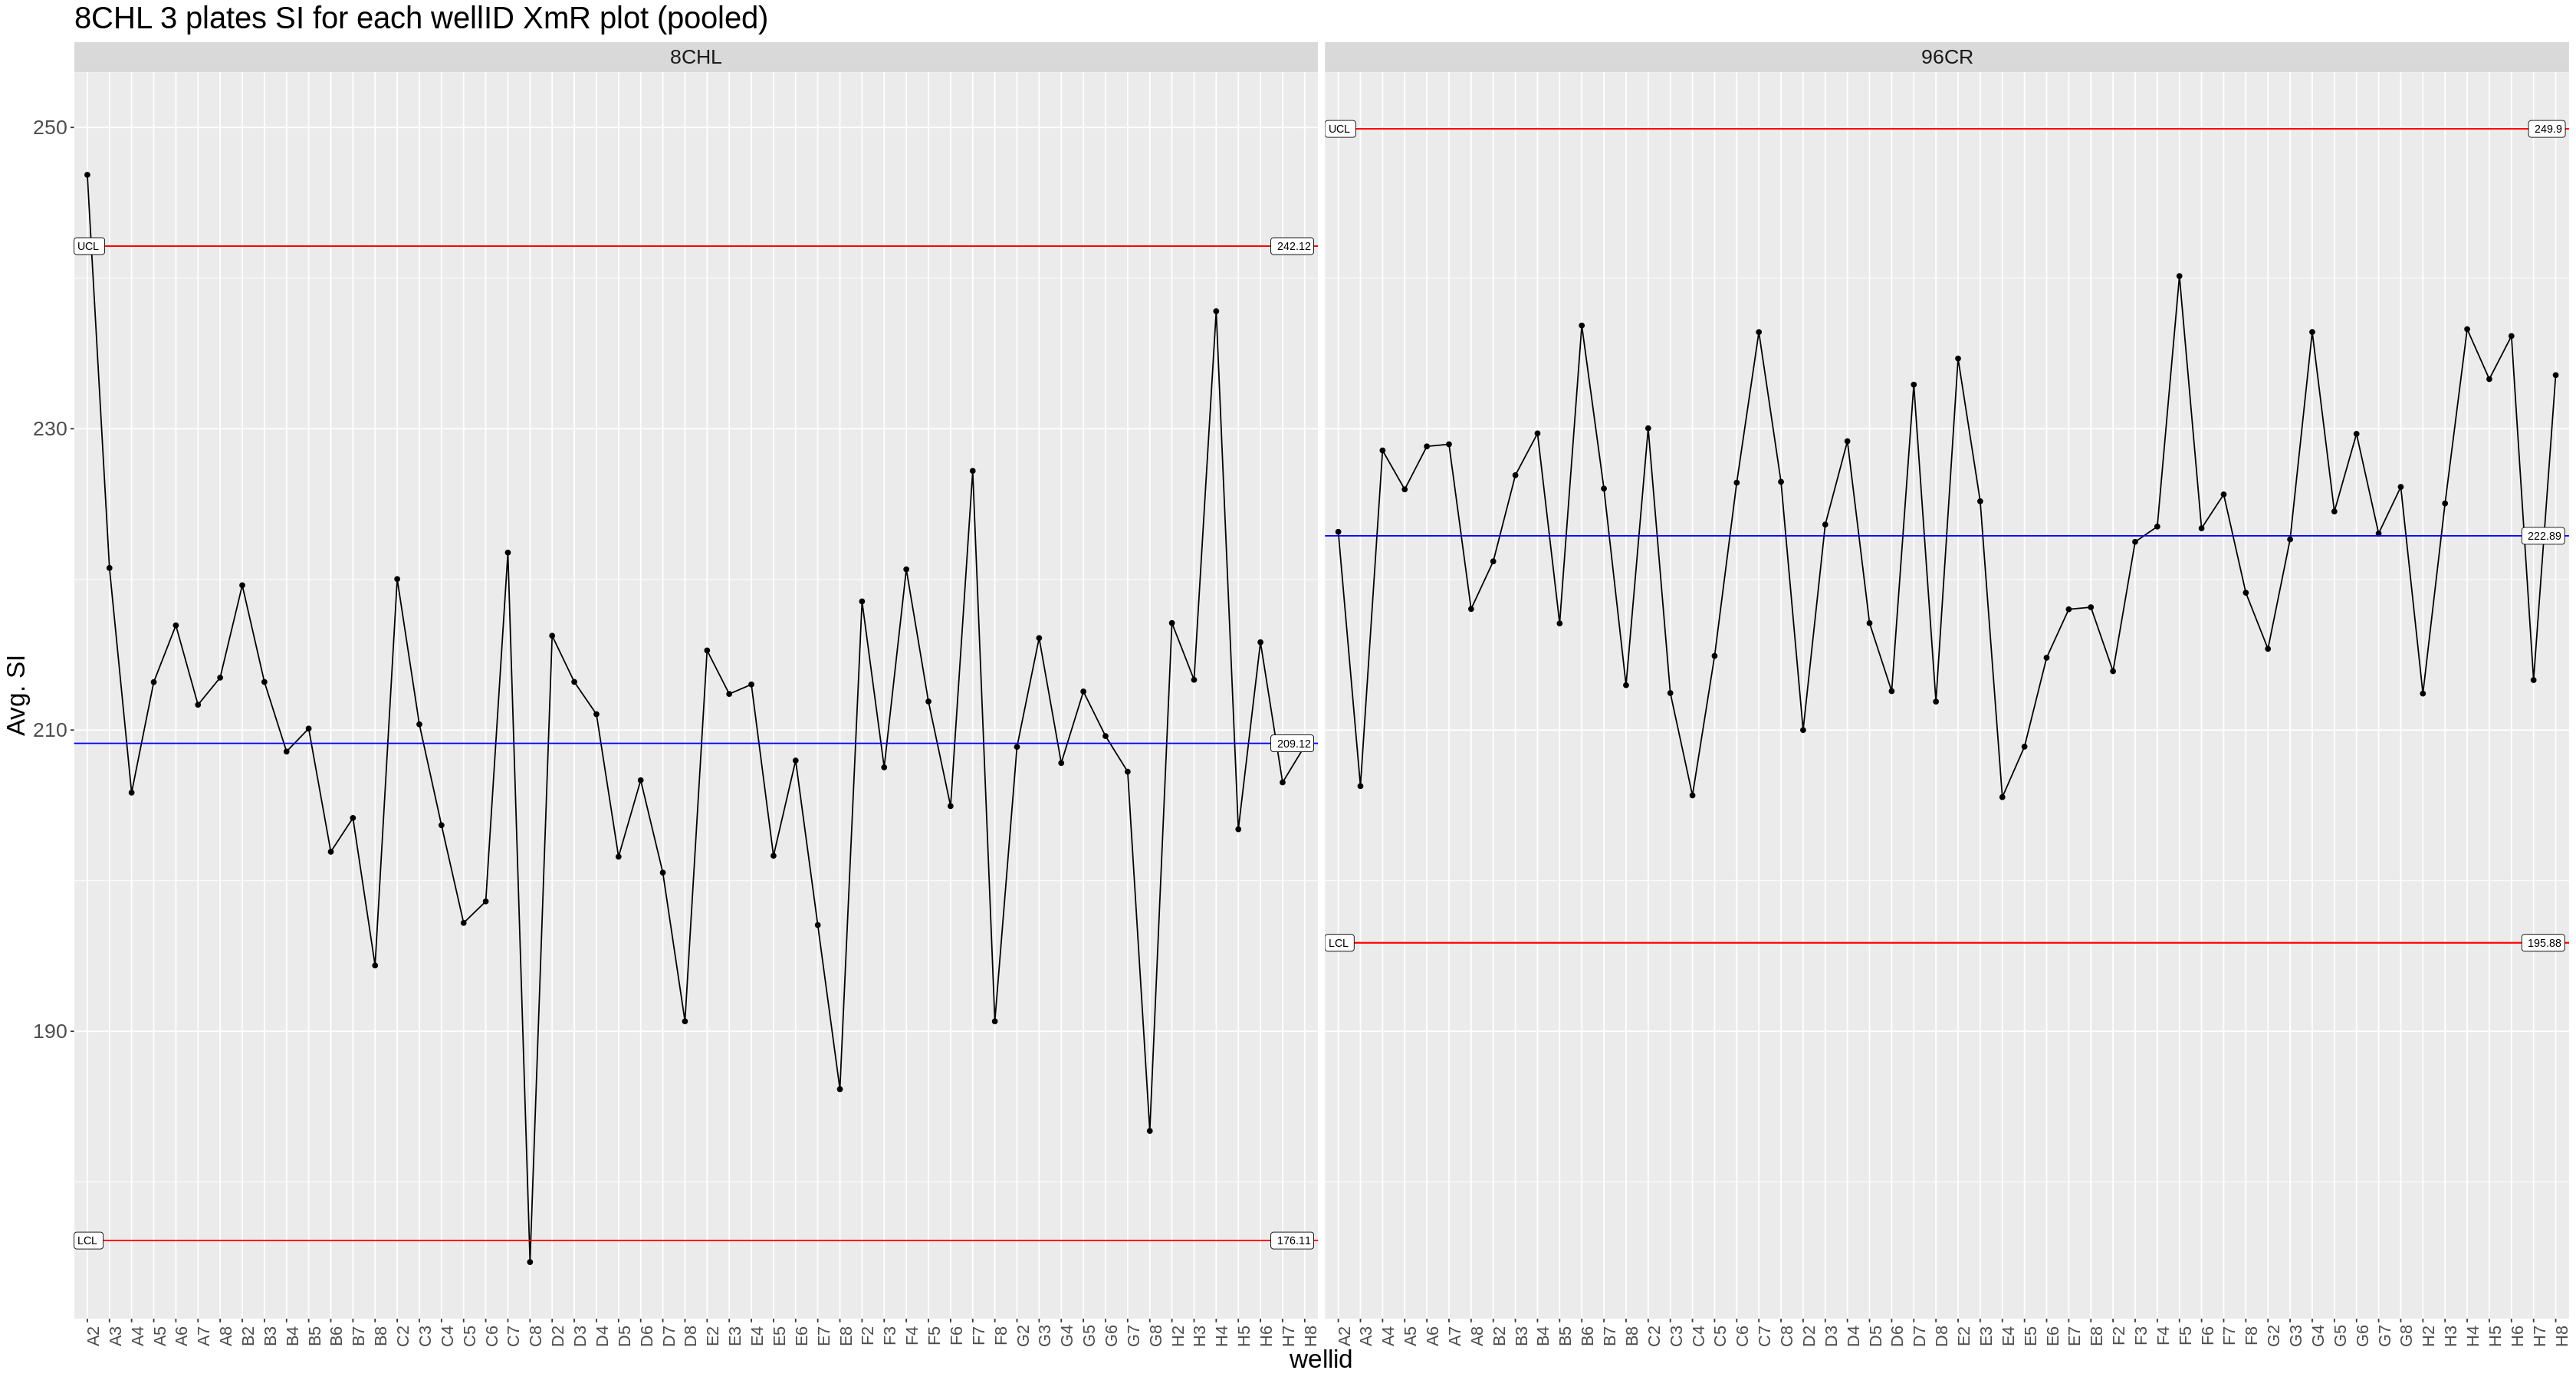

In [60]:
# SI
ggplot(dft2, aes(x=wellid, y=Mean, group=method)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("Avg. SI") +
  facet_wrap(~ method) + 
  ggtitle("8CHL 3 plates SI for each wellID XmR plot (pooled)") +
  theme(text = element_text(size=20),
        axis.text.x = element_text(size = 13, angle = 90))

# Conclusion

- pairwise tests show they are statistically different but that may be acceptable 
- still slight settling effect or lost in cell count over time
